# HEP-like INFERNO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor

## 1. Interpolation algorithm

In [2]:
from pytorch_inferno.inference import *

In [3]:
def smooth_function(x, smoothRegion = 1):
    
    mask_smooth_region = torch.abs(x) > smoothRegion
    xnorm = x / smoothRegion
    xnorm2 = xnorm*xnorm
    
    in_smooth = 0.125 * xnorm * (xnorm2 * (3.*xnorm2 - 10.) + 15)
    out_smooth = torch.where(x>0, torch.ones(x.shape).to(x.device), -1*torch.ones(x.shape).to(x.device))
    
    return torch.where(mask_smooth_region, out_smooth, in_smooth)

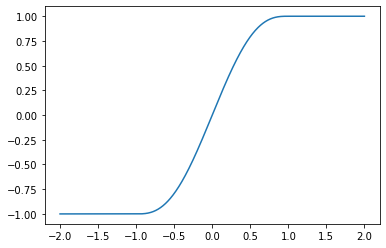

In [4]:
# Test 
x = torch.linspace(-2, 2, 1000)
y = smooth_function(x)
plt.plot(x, y)

In [5]:
def morph(x, nominal, lo, hi):
        
    dhi = hi - nominal
    dlo = lo - nominal
    #print(dhi)
    #print(dlo)
    diff_h = dhi - dlo
    sum_h = dhi + dlo
    alpha = x * 0.5 * ((diff_h) + (sum_h)*smooth_function(x))
    return alpha

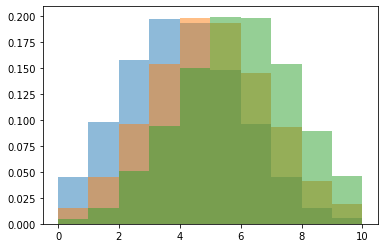

In [6]:
# Test
hi, y,_ = plt.hist(np.random.normal(loc=4, scale=2.0, size=10000), range=(0,10), alpha=0.5, density=True)
nominal, y,_ = plt.hist(np.random.normal(loc=5, scale=2.0, size=10000), range=(0,10), alpha=0.5, density=True)
lo, y,_ = plt.hist(np.random.normal(loc=6, scale=2.0, size=10000), range=(0,10), alpha=0.5, density=True)

In [7]:
y[:-1]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [8]:
hi_t = torch.Tensor(hi)
nominal_t = torch.Tensor(nominal)
lo_t = torch.Tensor(lo)

In [9]:
hi_stacked = torch.stack([hi_t, hi_t, hi_t])
lo_stacked = torch.stack([lo_t, lo_t, lo_t])

In [10]:
nominal_stacked = nominal_t.unsqueeze(0).repeat(3, 1)

In [11]:
nominal_stacked.shape

torch.Size([3, 10])

In [12]:
#alpha = torch.Tensor(np.array([-1, 0., 1.])).unsqueeze(1)
#alpha = torch.Tensor(np.array([-.5, 0., .5])).unsqueeze(1)
alpha = torch.Tensor(np.linspace(-2,2,20)).unsqueeze(1)

In [13]:
alpha.shape


torch.Size([20, 1])

In [14]:
nominal_stacked = nominal_t.unsqueeze(0).repeat(x.shape[0], 1)

In [15]:
nominal_stacked = nominal_t.unsqueeze(0).repeat(alpha.shape[0], 1)
morphed = morph(alpha, nominal_stacked, lo_stacked, hi_stacked)

RuntimeError: The size of tensor a (3) must match the size of tensor b (20) at non-singleton dimension 0

In [ ]:
nominal_morph = nominal_stacked + morphed

In [16]:
nominal_t += morphed.sum(0)

NameError: name 'morphed' is not defined

In [17]:
nominal_t

tensor([0.0149, 0.0446, 0.0957, 0.1539, 0.1986, 0.1934, 0.1449, 0.0935, 0.0417,
        0.0189])

NameError: name 'nominal_morph' is not defined

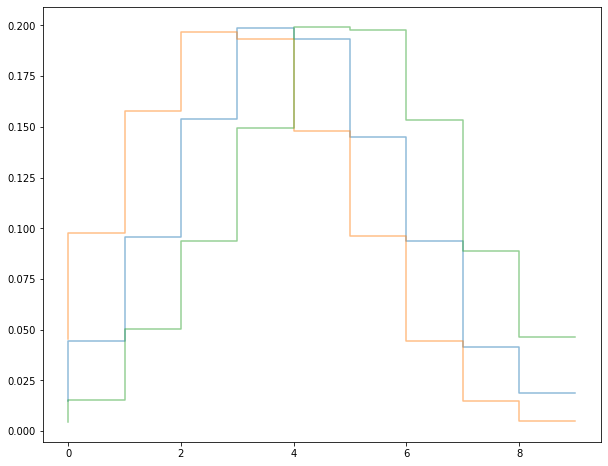

In [18]:
plt.figure(figsize=(10,8))
plt.step(y[:-1], nominal, alpha=0.5, label='nominal')
plt.step(y[:-1], hi, alpha=0.5, label = 'up')
plt.step(y[:-1], lo, alpha=0.5, label='down')
#plt.step(y[:-1], nominal_morph[2], linestyle='dashed', label='x = 0.5')
plt.step(y[:-1], nominal_morph[0], linestyle='dashed', label='x = -0.5')
plt.legend(loc="upper right")

In [19]:
def fast_vertical(alpha:Tensor, f_nom:Tensor, f_up:Tensor, f_dw:Tensor):
    
    f_nom_rep = f_nom.unsqueeze(0).repeat(alpha.shape[0], 1)
    return f_nom + morph(alpha.unsqueeze(1), f_nom_rep, f_dw, f_up).sum(0)

In [20]:
alpha = torch.Tensor(np.linspace(-2,2,10)).unsqueeze(1)
morphed = morph(alpha, nominal_t, lo_t, hi_t)

In [21]:
nominal_morphed = nominal_t.unsqueeze(0).repeat(alpha.shape[0], 1) + morphed

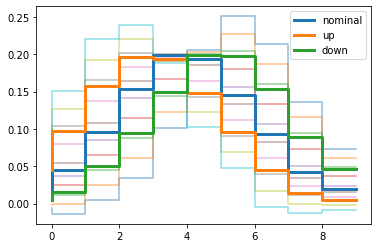

In [22]:
for i in range(len(nominal_morphed)):
    plt.step(y[:-1], nominal_morphed[i], alpha=0.5)
plt.step(y[:-1], nominal, alpha=1, label='nominal', linewidth=3)
plt.step(y[:-1], hi, alpha=1, label = 'up', linewidth=3)
plt.step(y[:-1], lo, alpha=1, label='down', linewidth=3)
plt.legend(loc="upper right")

## 2. constraints

In [23]:
def normal(theta, std):
    return 1. + theta*std

In [24]:
def log_normal(theta, kappa):
    return torch.exp(theta * torch.log(kappa))

In [25]:
def logKappaForX(x, logkappa_lo, logkappa_hi):
    
    logKhi =  logkappa_hi
    logKlo = -logkappa_lo

    kappa = torch.where(x >= 0, logkappa_hi, -logkappa_lo)
    
    avg = 0.5*(logKhi + logKlo) 
    halfdiff = 0.5*(logKhi - logKlo)
    twox = x+x 
    twox2 = twox*twox
    alpha = 0.125 * twox * (twox2 * (3*twox2 - 10.) + 15.)
    ret = avg + alpha*halfdiff
    return torch.where(torch.abs(x) >= 0.5, kappa, ret)

In [26]:
theta = torch.Tensor([1.0])
kappa = torch.Tensor([1.1])
std = torch.Tensor([0.1])
kappa_lo = torch.Tensor([0.9])
kappa_hi = torch.Tensor([1.2])
kappa_std_avg = (abs(kappa_hi-1)+abs(1-kappa_lo))/2

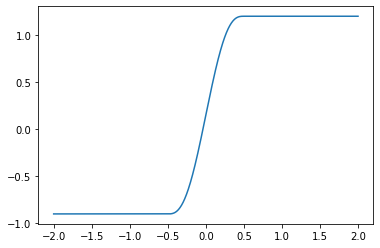

In [27]:
# Test 
x = torch.linspace(-2, 2, 1000)
y_logKappaForX = logKappaForX(x, kappa_lo, kappa_hi)
plt.plot(x, y_logKappaForX)

In [28]:
def asym_log_normal(theta, kappaLo, kappaHi):
    return torch.exp(theta * logKappaForX(theta, torch.log(kappaLo), torch.log(kappaHi)))

In [29]:
kappa_std_avg

tensor([0.1500])

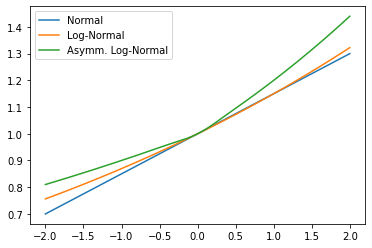

In [30]:
# Test 
x = torch.linspace(-2, 2, 1000)
y_norm = normal(x, kappa_std_avg)
y_ln = log_normal(x, (1+kappa_std_avg))
y_lnasym = asym_log_normal(x, kappa_lo, kappa_hi)
plt.plot(x, y_norm, label="Normal")
plt.plot(x, y_ln, label="Log-Normal")
plt.plot(x, y_lnasym, label="Asymm. Log-Normal")
plt.legend()

## 3. NLL

In [31]:
from typing import *
from torch import Tensor
from torch.distributions import Distribution
from torch.distributions import Normal

In [32]:
def hep_nll(s_true:float, b_true:float, mu:Tensor, f_s_nom:Tensor, f_b_nom:Tensor,
             shape_alpha:Optional[Tensor]=None, s_norm_alpha:Optional[Tensor]=None, 
             b_norm_alpha:Optional[Tensor]=None, b_rate_param_alpha:Optional[Tensor]=None,
             f_s_up:Optional[Tensor]=None, f_s_dw:Optional[Tensor]=None,
             f_b_up:Optional[Tensor]=None, f_b_dw:Optional[Tensor]=None,
             shape_norm_sigma:Optional[Tensor]=None, s_norm_sigma:Optional[Tensor]=None, 
             b_norm_sigma:Optional[Tensor]=None, 
             interp_algo:str="fast_vertical") -> Tensor:
    r'''Compute negative log-likelihood for specified parameters.'''
    
    #  Interpolate shapes
    if interp_algo == "fast_vertical":
        f_s = fast_vertical(shape_alpha, f_s_nom, f_s_up, f_s_dw) if shape_alpha is not None and f_s_up is not None else f_s_nom
        f_b = fast_vertical(shape_alpha, f_b_nom, f_b_up, f_b_dw) if shape_alpha is not None and f_b_up is not None else f_b_nom        
    else:
        #print(shape_alpha)
        #print(f_s_nom, f_s_up, f_s_dw)
        f_s = interp_shape(shape_alpha, f_s_nom, f_s_up, f_s_dw) if shape_alpha is not None and f_s_up is not None else f_s_nom
        f_b = interp_shape(shape_alpha, f_b_nom, f_b_up, f_b_dw) if shape_alpha is not None and f_b_up is not None else f_b_nom
        
    # Normalizations !!! careful if signal and background shapes mix!!
    #print("shape_norm_sigma", shape_norm_sigma)
    s_exp, b_exp = mu, b_true
    if len(shape_alpha) > 0:
        #print("Norms shape", normal(shape_alpha, shape_norm_sigma))
        s_exp *= normal(shape_alpha, shape_norm_sigma).prod()  
    if len(s_norm_alpha) > 0:
        s_exp *= normal(s_norm_alpha, s_norm_sigma).prod()
    if len(b_norm_alpha) > 0:
        b_exp *= normal(b_norm_alpha, b_norm_sigma).prod()
    if (b_rate_param_alpha  is not None) and (len(b_rate_param_alpha) > 0):
        b_exp *= b_rate_param_alpha
        
    #  Compute NLL
    t_exp = (s_exp*f_s)+(b_exp*f_b)
    asimov = (s_true*f_s_nom)+(b_true*f_b_nom)
    nll = -torch.distributions.Poisson(t_exp, False).log_prob(asimov).sum()

    # Constrain shape +norm nuisances
    for a in shape_alpha: nll = nll - Normal(0,1).log_prob(a)
    for a in b_norm_alpha: nll = nll - Normal(0,1).log_prob(a)
    for a in s_norm_alpha: nll = nll - Normal(0,1).log_prob(a)
    return nll

## 4. Callback

In [42]:
#https://discuss.pytorch.org/t/differentiable-torch-histc/25865
class SoftHistogram(nn.Module):
    def __init__(self, bins, min, max, sigma, device=None):
        super(SoftHistogram, self).__init__()
        self.bins = bins
        self.min = min
        self.max = max
        self.sigma = sigma
        self.delta = float(max - min) / float(bins)
        self.centers = float(min) + self.delta * (torch.arange(bins).float() + 0.5)
        if device is not None:
            self.centers = self.centers.to(device)

    def forward(self, x):
        x = torch.unsqueeze(torch.squeeze(x), 0) - torch.unsqueeze(self.centers, 1)
        x = torch.sigmoid(self.sigma * (x + self.delta/2)) - torch.sigmoid(self.sigma * (x - self.delta/2))
        x = x.sum(dim=1)
        return x

In [43]:
hist = SoftHistogram(bins=10, min=0., max=1., sigma=1.)

In [44]:
hist(tt).shape

NameError: name 'tt' is not defined

In [45]:
print(x)

tensor([-2.0000, -1.9960, -1.9920, -1.9880, -1.9840, -1.9800, -1.9760, -1.9720,
        -1.9680, -1.9640, -1.9600, -1.9560, -1.9520, -1.9479, -1.9439, -1.9399,
        -1.9359, -1.9319, -1.9279, -1.9239, -1.9199, -1.9159, -1.9119, -1.9079,
        -1.9039, -1.8999, -1.8959, -1.8919, -1.8879, -1.8839, -1.8799, -1.8759,
        -1.8719, -1.8679, -1.8639, -1.8599, -1.8559, -1.8519, -1.8478, -1.8438,
        -1.8398, -1.8358, -1.8318, -1.8278, -1.8238, -1.8198, -1.8158, -1.8118,
        -1.8078, -1.8038, -1.7998, -1.7958, -1.7918, -1.7878, -1.7838, -1.7798,
        -1.7758, -1.7718, -1.7678, -1.7638, -1.7598, -1.7558, -1.7518, -1.7477,
        -1.7437, -1.7397, -1.7357, -1.7317, -1.7277, -1.7237, -1.7197, -1.7157,
        -1.7117, -1.7077, -1.7037, -1.6997, -1.6957, -1.6917, -1.6877, -1.6837,
        -1.6797, -1.6757, -1.6717, -1.6677, -1.6637, -1.6597, -1.6557, -1.6517,
        -1.6476, -1.6436, -1.6396, -1.6356, -1.6316, -1.6276, -1.6236, -1.6196,
        -1.6156, -1.6116, -1.6076, -1.60

In [46]:
torch.squeeze(tt).shape

NameError: name 'tt' is not defined

In [54]:
x = torch.unsqueeze(data, 0)  - torch.unsqueeze(hist.centers, 1)

In [57]:
x = torch.sigmoid(hist.sigma * (x + hist.delta/2)) - torch.sigmoid(hist.sigma * (x - hist.delta/2))

In [59]:
x = x.sum(dim=1)

In [61]:
x

tensor([0.3052, 0.3127, 0.3203, 0.3282, 0.3362, 0.3443, 0.3524, 0.3604, 0.3684,
        0.3761])

In [60]:
x.shape

torch.Size([10])

In [73]:
t = torch.unsqueeze(x, 1)

In [78]:
torch.squeeze(t).shape

torch.Size([10])

In [52]:
torch.unsqueeze(data, 0).shape

torch.Size([1, 1000])

In [103]:
tt = 50 + 25 * torch.randn(1000)

In [55]:
torch.unsqueeze(data, 0).shape

torch.Size([1, 1000])

In [81]:
class CovTracker(AbsCallback):
    r'''Tracks training and validation losses during training.
    Losses are assumed to be averaged and will be re-averaged over the epoch unless `loss_is_meaned` is false.'''
    def __init__(self, b_true:float, mu_true:float, n_shape_alphas:int=0, interp_algo:str="default", shape_norm_sigma:Optional[List[float]]=None,
                 s_norm_sigma:Optional[List[float]]=None, b_norm_sigma:Optional[List[float]]=None, 
                 b_rate_param:bool=False,  loss_is_meaned:bool=True):
        
        self.mu_true = mu_true
        self.b_true = b_true
        self.n_shape_alphas = n_shape_alphas
        self.interp_algo = interp_algo
        self.shape_norm_sigma = shape_norm_sigma #torch.Tensor(shape_norm_sigma)
        self.s_norm_sigma = s_norm_sigma
        self.b_norm_sigma = b_norm_sigma
        self.b_rate_param = b_rate_param
        # Compute nuisance indeces
        self.poi_idx = [0]
        # Shape + norm
        if self.shape_norm_sigma is not None and len(self.shape_norm_sigma) != self.n_shape_alphas: raise ValueError("Number of norm uncertainties on shape nuisances must match the number of shape nuisance parameters")
        if self.n_shape_alphas > 0:
            self.shape_idxs = list(range(1,self.n_shape_alphas+1))
            self.n_alpha = 1+self.n_shape_alphas
        else:
            self.shape_idxs = []
        # Signal norms
        if self.s_norm_sigma is not None and len(self.s_norm_sigma) > 0:
            self.s_norm_idxs = list(range(self.n_alpha, self.n_alpha+len(self.s_norm_sigma)))
            self.n_alpha += len(self.s_norm_sigma)
        else:
            self.s_norm_idxs = []
        # Background norms + possible rate param
        if self.b_norm_sigma is not None and len(self.b_norm_sigma) > 0:
            self.b_norm_idxs = list(range(self.n_alpha, self.n_alpha+len(self.b_norm_sigma)))
            self.n_alpha += len(self.b_norm_sigma)
        else:
            self.b_norm_idxs = []
        if self.b_rate_param:
            self.b_rate_param_idx = list(self.n_alpha, self.n_alpha+1)
            self.n_alpha += 1
        else:
            self.b_rate_param_idx = []
        
        # Store covariance matrix
        self.covs, self.cov, self.cnt = {'val':[]}, 0, 0
        self.val_shapes, self.sig_shape, self.bkg_shape  = {'sig':[], 'bkg':[]}, 0, 0

        
    def on_train_begin(self) -> None:
        if self.shape_norm_sigma is not None: self.shape_norm_sigma = torch.Tensor(self.shape_norm_sigma).to(self.wrapper.device)
        if self.s_norm_sigma is not None: self.s_norm_sigma = torch.Tensor(self.s_norm_sigma).to(self.wrapper.device)
        if self.b_norm_sigma is not None: self.b_norm_sigma = torch.Tensor(self.b_norm_sigma).to(self.wrapper.device)
     
    def to_shape(self, p:Tensor, w:Optional[Tensor]=None) -> Tensor:
        #f = (p*w).sum(0)+1e-7 if w is not None else p.sum(0)+1e-7
        #return f/f.sum()   
        
        #print(torch.unsqueeze(torch.squeeze(p), 0).shape)
        
        h = torch.histc(p, bins=10, min=0., max=1.)
        hist = SoftHistogram(bins=10, min=0., max=1., sigma=200., device=self.wrapper.device)
        print(p.shape)
        eps=1e-7
        h = h.div(h.sum())+eps
        h_soft = hist(p)
        h_soft = h_soft.div(h_soft.sum())+eps
        print("h_soft", h_soft)
        print("h", h)
        return h
    
    def calc_cov(self, f_s_nom:Tensor, f_b_nom:Tensor, f_s_up:Optional[Tensor], f_s_dw:Optional[Tensor], f_b_up:Optional[Tensor], f_b_dw:Optional[Tensor]) -> Tensor:
        r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
        alpha = torch.zeros((self.n_alpha), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): alpha[self.poi_idx] += self.mu_true
        #print("alpha", alpha)
        get_nll = partialler(hep_nll, s_true=self.mu_true, b_true=self.b_true, # Expectation values
                             f_s_nom=f_s_nom, f_b_nom=f_b_nom, # Nominal shapes
                             f_s_up=f_s_up, f_s_dw=f_s_dw, # Signal shapes
                             f_b_up=f_b_up, f_b_dw=f_b_dw, #Background shapes
                             shape_norm_sigma = self.shape_norm_sigma, # Norm unct on shapes
                             s_norm_sigma = self.s_norm_sigma, b_norm_sigma = self.b_norm_sigma # Norm unct on sig and bkg
                             ) 
        nll = get_nll(mu=alpha[self.poi_idx], s_norm_alpha=alpha[self.s_norm_idxs], 
                      b_norm_alpha=alpha[self.b_norm_idxs], shape_alpha=alpha[self.shape_idxs],
                      b_rate_param_alpha = alpha[self.b_rate_param_idx],
                      interp_algo = self.interp_algo)
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        cov = torch.inverse(h)
        #print(cov)
        with torch.no_grad(): 
            self.cov += cov.detach().cpu().numpy()
            self.sig_shape += f_s_nom.detach().cpu().numpy()
            self.bkg_shape += f_b_nom.detach().cpu().numpy()
        self.cnt += 1
        
    def _get_up_down(self, x_s:Tensor, x_b:Tensor, w_s:Optional[Tensor]=None, w_b:Optional[Tensor]=None) -> Tuple[Tuple[Optional[Tensor],Optional[Tensor]],Tuple[Optional[Tensor],Optional[Tensor]]]:

        if self.n_shape_alphas != ((x_s.shape[-1]-1)/2): 
            raise ValueError("Number of specified shape nuisances n_shape_alphas", self.n_shape_alphas,
                             "must match the number of systematic variations:", (x_s.shape[-1]-1)/2 )
        
        u,d = [],[]
        # modified template variations
        for i in range(self.n_shape_alphas):
            idx_up = 1 + 2*i
            idx_down = 2 + 2*i
            up_batch = self.to_shape(self.wrapper.model(x_s[:,:,idx_up]))
            down_batch = self.to_shape(self.wrapper.model(x_s[:,:,idx_down]))
            u.append(up_batch)
            d.append(down_batch)    
        return (torch.stack(u),torch.stack(d)), (None,None)


    def on_forwards_end(self)-> None:
        
        if self.wrapper.state != 'train':
            b = self.wrapper.y.squeeze() == 0
            w_s = self.wrapper.w[~b] if self.wrapper.w is not None else None
            w_b = self.wrapper.w[b] if self.wrapper.w is not None else None
            f_s = self.to_shape(self.wrapper.y_pred[~b], w_s)
            f_b = self.to_shape(self.wrapper.y_pred[b], w_b)
            (f_s_up,f_s_dw),(f_b_up,f_b_dw)= self._get_up_down(self.wrapper.x[~b], self.wrapper.x[b], w_s, w_b)
            self.calc_cov(f_s_nom=f_s, f_b_nom=f_b, f_s_up=f_s_up, f_s_dw=f_s_dw, f_b_up=f_b_up, f_b_dw=f_b_dw)

            
    def on_epoch_begin(self) -> None: 
        self.cov, self.cnt = 0, 0
        self.sig_shape, self.bkg_shape = 0, 0
        
    def on_epoch_end(self) -> None:
        if self.wrapper.state != 'train':
            self.covs['val'].append(  self.cov / self.cnt  )
            self.val_shapes['sig'].append( self.sig_shape / self.cnt )
            self.val_shapes['bkg'].append( self.bkg_shape / self.cnt )
        

In [82]:
shape_norm_sigma = [0.05, 0.02]
s_norm_sigma = []#[0.05, 0.1]

ct = CovTracker(b_true=qcd, mu_true=mu, n_shape_alphas=2, shape_norm_sigma=shape_norm_sigma,
                                 s_norm_sigma=s_norm_sigma, interp_algo="default")

In [83]:
net_bce = nn.Sequential(nn.Linear(4,12),  nn.ReLU(),
                        nn.Linear(12,8), nn.ReLU(),
                        nn.Linear(8,1),  nn.Sigmoid())
#init_net(net)    
lt = LossTracker()
model_bce = ModelWrapper(net_bce)
model_bce.fit(100, data=data, opt=partialler(optim.Adam), loss=nn.BCELoss(),
              cbs=[lt, ct])

torch.Size([781, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.4640e-07, 4.6500e-01, 5.3255e-01,
        2.4507e-03, 1.0002e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.7247e-01, 5.2497e-01,
        2.5609e-03, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([219, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.7745e-07, 6.1007e-01, 3.8992e-01,
        3.4546e-06, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.1187e-01, 3.8813e-01,
        1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([781, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5373e-07, 4.9040e-01, 5.0833e-01,
        1.2705e-03, 1.0001e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5824e-07, 4.9847e-01, 4.9794e-01,
        3.5937e-03, 1.3915e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.0472e-01, 4.9258e-01,
        2.6992e-03, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7594e-07, 5.4638e-01, 4.5362e-01,
        1.5636e-06, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.8687e-01, 4.1313e-01,
        1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.6725e-07, 5.2380e-01, 4.7324e-01,
        2.9650e-03, 1.0694e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.3949e-01, 4.5917e-01,
        1.3388e-03, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.4513e-07, 4.8443e-01, 5.1314e-01,
        2.4273e-03, 1.0003e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.9869e-01, 4.9869e-01,
        2.6111e-03, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([234, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7081e-07, 5.2838e-01, 4.7162e-01,
        1.7588e-06, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.5556e-01, 4.4444e-01,
        1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

torch.Size([745, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.2800e-07, 4.5441e-01, 5.4310e-01,
        2.4871e-03, 1.0289e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.6846e-01, 5.3020e-01,
        1.3424e-03, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([255, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.1220e-07, 5.7209e-01, 4.2791e-01,
        9.7106e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.1569e-01, 3.8431e-01,
        1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3248e-07, 4.7761e-01, 5.2069e-01,
        1.7063e-03, 1.0070e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([729, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.6525e-07, 4.9807e-01, 5.0050e-01,
        1.4285e-03, 1.0193e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.1166e-01, 4.8697e-01,
        1.3718e-03, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([271, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.8094e-07, 5.5816e-01, 4.4183e-01,
        7.3815e-06, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.7934e-01, 4.2066e-01,
        1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([729, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7816e-07, 5.2223e-01, 4.7639e-01,
        1.3744e-03, 1.0024e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([730, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3348e-07, 4.8103e-01, 5.1892e-01,
        5.5510e-05, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.8767e-01, 5.1233e-01,
        1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([270, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.1700e-07, 5.3135e-01, 4.6696e-01,
        1.6863e-03, 1.0001e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.6667e-01, 4.3333e-01,
        1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([730, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.4099e-07, 5.0131e-01, 4.9867e-01,
        1.7222e-05, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

1: Train=0.7059318065643311 Valid=0.6880026536936908
torch.Size([765, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.5429e-02, 8.7207e-01,
        4.1757e-02, 7.4180e-04, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.1830e-02, 9.1895e-01,
        3.7909e-02, 1.3073e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7939e-01, 8.0933e-01,
        1.1272e-02, 1.0016e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.4894e-01, 8.4255e-01,
        8.5107e-03, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.4515e-02, 8.7185e-01,
        3.3526e-02, 1.0837e-04, 1.0000e

torch.Size([745, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0029e-01, 8.6729e-01,
        3.2422e-02, 3.8869e-06, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.1745e-02, 9.0738e-01,
        3.0873e-02, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([255, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5540e-01, 8.3493e-01,
        9.6726e-03, 1.1103e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.8039e-02, 8.9804e-01,
        3.9217e-03, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0881e-01, 8.6577e-01,
        2.5415e-02, 5.0480e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.4046e-02, 8.8039e-01,
        3.5567e-02, 3.1089e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.3421e-02, 9.2500e-01,
        3.1579e-02, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.6101e-02, 8.7123e-01,
        3.2667e-02, 5.1417e-06, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.4000e-02, 9.0667e-01,
        2.9333e-02, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7912e-01, 8.1609e-01,
        4.7943e-03, 1.0001e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([770, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.7383e-02, 8.6548e-01,
        3.7130e-02, 3.3939e-06, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.3247e-02, 9.0909e-01,
        3.7662e-02, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([230, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.8296e-01, 8.1228e-01,
        4.7623e-03, 1.0001e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.4783e-01, 8.5217e-01,
        1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0600e-01, 8.6382e-01,
        3.0184e-02, 5.5785e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.3877e-02, 9.1590e-01,
        3.0223e-02, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0016e-07, 9.9599e-02, 8.6381e-01,
        3.6588e-02, 1.7073e-06, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.8620e-02, 9.1721e-01,
        3.4166e-02, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([716, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.7024e-02, 8.7256e-01,
        2.9019e-02, 1.3984e-03, 1.2929e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.0056e-02, 9.1341e-01,
        2.5140e-02, 1.3967e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([2

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.6634e-02, 8.6640e-01,
        3.5358e-02, 1.6062e-03, 1.0006e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.3257e-02, 9.0310e-01,
        3.2302e-02, 1.3460e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.5099e-02, 8.7132e-01,
        3.1475e-02, 2.1017e-03, 1.0001e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.7874e-02, 9.0983e-01,
        2.9610e-02, 2.6919e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([724, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0208e-01, 8.6381e-01,
        3.2209e-02, 1.9036e-03, 1.0001e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([583, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0330e-01, 8.4524e-01,
        5.1425e-02, 4.1021e-05, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.6604e-02, 8.9365e-01,
        4.9743e-02, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([187, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3483e-01, 8.6085e-01,
        4.3232e-03, 1.0001e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.5562e-02, 9.1444e-01,
        1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([583, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.1104e-01, 8.4658e-01,
        4.2373e-02, 6.6753e-06, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([751, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.1293e-03, 7.6725e-01,
        2.1086e-01, 1.8748e-02, 5.6871e-06, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.7763e-01,
        2.0240e-01, 1.9973e-02, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([249, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0747e-02, 8.0642e-01,
        1.8284e-01, 1.6795e-06, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.1928e-01,
        1.8072e-01, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.5431e-03, 7.8738e-01,
        1.9448e-01, 1.4592e-02, 5.2174e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([752, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.2144e-03, 7.5052e-01,
        2.3526e-01, 1.0874e-02, 1.2729e-04, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.5931e-01,
        2.3138e-01, 9.3086e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.5353e-03, 7.7175e-01,
        2.1772e-01, 6.9955e-03, 1.5952e-06, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.8192e-01,
        2.1144e-01, 6.6490e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.3272e-03, 7.8271e-01,
        2.0842e-01, 5.5378e-03, 1.9037e-06, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([755, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.1335e-03, 7.8482e-01,
        1.9451e-01, 1.6193e-02, 1.3471e-03, 1.0165e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.9205e-01,
        1.8940e-01, 1.7219e-02, 1.3246e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([245, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.0346e-03, 8.1376e-01,
        1.7427e-01, 3.9322e-03, 1.0017e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.2041e-01,
        1.7551e-01, 4.0817e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.4376e-03, 8.0202e-01,
        1.8220e-01, 1.1040e-02, 1.3064e-03, 1.0018e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([756, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.9248e-03, 7.8846e-01,
        2.0046e-01, 8.1558e-03, 5.3616e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.9762e-01,
        1.9577e-01, 6.6139e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0186e-02, 8.1383e-01,
        1.7598e-01, 7.6463e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.3197e-01,
        1.6803e-01, 1.0000e-07, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.4689e-03, 8.0796e-01,
        1.8294e-01, 5.6328e-03, 1.2227e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([743, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.8321e-03, 7.8758e-01,
        1.9797e-01, 1.0276e-02, 3.4949e-04, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.9677e-01,
        1.9381e-01, 9.4214e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([774, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.4508e-03, 7.6391e-01,
        2.2726e-01, 6.3794e-03, 7.1852e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.6873e-01,
        2.2739e-01, 3.8761e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([226, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.5477e-03, 7.9474e-01,
        1.9850e-01, 2.0542e-04, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([732, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.8905e-03, 7.5864e-01,
        2.2893e-01, 9.5431e-03, 2.7293e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.7049e-01,
        2.1995e-01, 9.5629e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([732, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.9458e-03, 7.6700e-01,
        2.2187e-01, 8.1842e-03, 1.5210e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.6913e-01,
        2.2404e-01, 6.8307e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([560, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.0372e-03, 7.5645e-01,
        2.2802e-01, 1.2488e-02, 6.8437e-06, 1.0000e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([761, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0262e-04, 5.2047e-01,
        3.8734e-01, 8.1696e-02, 8.5302e-03, 1.8610e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.2037e-01,
        3.9159e-01, 7.7530e-02, 7.8845e-03, 2.6282e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([239, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.4073e-04, 6.2680e-01,
        3.6259e-01, 9.8758e-03, 1.0564e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.2762e-01,
        3.6820e-01, 4.1842e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.2330e-04, 5.4442e-01,
        3.7701e-01, 7.0394e-02, 7.6827e-03, 3.6921e-04], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.3091e-01,
        4.0054e-01, 6.5860e-02, 2.6883e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.7789e-05, 4.7944e-01,
        4.2392e-01, 8.9404e-02, 7.1551e-03, 2.3065e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.8656e-01,
        4.1532e-01, 9.1398e-02, 6.7205e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.2356e-05, 5.0374e-01,
        4.1705e-01, 7.4732e-02, 4.3886e-03, 1.0389e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.0941e-01,
        4.1532e-01, 7.1237e-02, 4.0324e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5853e-04, 5.2817e-01,
        3.6779e-01, 9.6785e-02, 7.0878e-03, 4.2047e-06], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.3604e-01,
        3.6173e-01, 9.5675e-02, 6.5532e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0173e-04, 4.7416e-01,
        4.0386e-01, 1.0776e-01, 1.3187e-02, 9.3169e-04], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.7837e-01,
        4.0105e-01, 1.0616e-01, 1.3106e-02, 1.3107e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.2274e-04, 5.0396e-01,
        3.8084e-01, 1.0308e-01, 1.1946e-02, 4.0901e-05], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.2418e-05, 5.3353e-01,
        3.8431e-01, 7.9198e-02, 2.8683e-03, 1.1243e-06], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.3752e-01,
        3.8199e-01, 7.7763e-02, 2.7286e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([267, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.5009e-04, 6.7784e-01,
        3.1035e-01, 1.1161e-02, 1.1284e-06, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.7790e-01,
        3.1086e-01, 1.1236e-02, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([733, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0643e-04, 5.6042e-01,
        3.6869e-01, 6.8036e-02, 2.7445e-03, 1.6326e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([731, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.5504e-05, 4.8456e-01,
        4.3151e-01, 7.3463e-02, 1.0122e-02, 2.5967e-04], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.8564e-01,
        4.3092e-01, 7.2504e-02, 1.0944e-02, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([269, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.0461e-04, 7.1125e-01,
        2.8051e-01, 7.5310e-03, 6.2348e-06, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.1004e-01,
        2.8253e-01, 7.4350e-03, 1.0000e-07, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([731, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0492e-04, 5.1090e-01,
        4.1574e-01, 6.4678e-02, 8.5702e-03, 1.3485e-05], device='cuda:0',
       grad_fn=<Ad

torch.Size([749, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5455e-04, 5.2170e-01,
        3.9052e-01, 8.4638e-02, 2.9843e-03, 1.0166e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.2603e-01,
        3.8852e-01, 8.2777e-02, 2.6703e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.9985e-04, 6.6234e-01,
        3.1974e-01, 1.3440e-02, 2.2776e-03, 1.7067e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.6135e-01,
        3.2271e-01, 1.1952e-02, 3.9842e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.9312e-04, 5.4585e-01,
        3.7877e-01, 7.1768e-02, 3.4231e-03, 1.0010e-07], device='cuda:0',
       grad_fn=<Ad

torch.Size([762, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.3605e-06, 3.2948e-01,
        4.4342e-01, 1.7912e-01, 4.4935e-02, 3.0304e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.2677e-01,
        4.4751e-01, 1.7979e-01, 4.1995e-02, 3.9371e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.6090e-04, 6.1261e-01,
        3.3226e-01, 4.7524e-02, 7.4506e-03, 1.5347e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.0504e-01,
        3.4454e-01, 4.2017e-02, 8.4035e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.1671e-05, 3.4927e-01,
        4.4369e-01, 1.6442e-01, 4.1034e-02, 1.5758e-03], device='cuda:0',
       grad_fn=<Ad

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.8774e-06, 3.1528e-01,
        4.1689e-01, 2.1912e-01, 4.4829e-02, 3.8677e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.2241e-01,
        4.1022e-01, 2.1887e-01, 4.4561e-02, 3.9319e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([237, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.8242e-04, 6.2444e-01,
        3.3629e-01, 3.5164e-02, 2.0686e-05, 3.8963e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.1603e-01,
        3.4177e-01, 3.7975e-02, 1.0000e-07, 4.2195e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0649e-05, 3.3341e-01,
        4.2279e-01, 2.0292e-01, 3.7684e-02, 3.1831e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.4120e-06, 3.0559e-01,
        4.0154e-01, 2.1556e-01, 7.0397e-02, 6.9024e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.0390e-01,
        4.0130e-01, 2.1429e-01, 7.2727e-02, 7.7923e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.1670e-06, 3.2392e-01,
        4.1052e-01, 2.0491e-01, 5.5860e-02, 4.7802e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.2857e-01,
        4.0390e-01, 2.0779e-01, 5.5844e-02, 3.8962e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.8556e-06, 3.2638e-01,
        4.2028e-01, 1.9642e-01, 5.2004e-02, 4.9158e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([764, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.9179e-06, 3.1722e-01,
        4.2253e-01, 1.9251e-01, 6.3133e-02, 4.6102e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.1545e-01,
        4.2539e-01, 1.9110e-01, 6.4136e-02, 3.9268e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([236, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5922e-04, 5.8819e-01,
        3.3084e-01, 7.2525e-02, 8.2867e-03, 1.0025e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.8475e-01,
        3.3898e-01, 6.7797e-02, 8.4747e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.8944e-06, 3.4042e-01,
        4.1937e-01, 1.8190e-01, 5.6279e-02, 2.0239e-03], device='cuda:0',
       grad_fn=<Ad

torch.Size([734, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.4399e-06, 3.0920e-01,
        4.4993e-01, 1.9460e-01, 4.4789e-02, 1.4702e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.0926e-01,
        4.4823e-01, 1.9619e-01, 4.4959e-02, 1.3625e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([266, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3041e-04, 6.7857e-01,
        2.9698e-01, 1.6929e-02, 7.3888e-03, 2.4711e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.8421e-01,
        2.9323e-01, 1.5038e-02, 7.5189e-03, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.3963e-06, 3.3309e-01,
        4.4620e-01, 1.8154e-01, 3.7912e-02, 1.2531e-03], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.1565e-01,
        4.2561e-01, 2.1345e-01, 4.0104e-02, 5.1747e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.6654e-06, 3.2143e-01,
        4.4294e-01, 1.8728e-01, 4.3963e-02, 4.3765e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.2083e-01,
        4.4243e-01, 1.8758e-01, 4.3985e-02, 5.1747e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([721, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0823e-05, 3.1224e-01,
        4.2071e-01, 2.0723e-01, 5.6709e-02, 3.1050e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.0652e-01,
        4.2996e-01, 2.0527e-01, 5.5479e-02, 2.7740e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([2

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.5126e-01,
        3.9328e-01, 1.9664e-01, 5.2101e-02, 6.7228e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
5: Train=0.5518426394462586 Valid=0.5543777902231228
torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.4636e-05, 2.0495e-01,
        3.7096e-01, 2.6674e-01, 1.2837e-01, 2.8980e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.9921e-01,
        3.7335e-01, 2.6913e-01, 1.3061e-01, 2.7705e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.4502e-03, 5.6222e-01,
        3.2364e-01, 8.5424e-02, 2.1162e-02, 1.0335e-04], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.1323e-03, 5.6612e-01,
        3.2231e-01, 8.6777e-02, 2.0661e-02, 1.0000e-07], device='

torch.Size([750, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.1759e-06, 2.1276e-01,
        3.8455e-01, 2.5347e-01, 1.3276e-01, 1.6457e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.1200e-01,
        3.8933e-01, 2.5067e-01, 1.3200e-01, 1.6000e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.1288e-04, 6.1732e-01,
        2.6686e-01, 8.8249e-02, 2.2861e-02, 4.0007e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.1200e-01,
        2.7200e-01, 8.8000e-02, 2.4000e-02, 4.0001e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.2797e-06, 2.2736e-01,
        3.9352e-01, 2.4867e-01, 1.1746e-01, 1.2987e-02], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.9892e-01,
        3.9107e-01, 2.6252e-01, 1.2585e-01, 2.1651e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5803e-05, 1.7413e-01,
        3.8047e-01, 2.6183e-01, 1.5419e-01, 2.9373e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7727e-01,
        3.7618e-01, 2.5981e-01, 1.5968e-01, 2.7064e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.8630e-05, 1.8766e-01,
        3.8873e-01, 2.6202e-01, 1.3635e-01, 2.5226e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.8674e-01,
        3.8972e-01, 2.6387e-01, 1.3396e-01, 2.5711e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.5774e-05, 2.0731e-01,
        3.7917e-01, 2.5343e-01, 1.3842e-01, 2.1645e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.0639e-01,
        3.7816e-01, 2.5433e-01, 1.3848e-01, 2.2637e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.0088e-06, 1.6837e-01,
        3.8026e-01, 2.7596e-01, 1.4030e-01, 3.5107e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.6755e-01,
        3.7766e-01, 2.7527e-01, 1.4362e-01, 3.5904e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([248, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.3061e-03, 6.1324e-01,
        3.0911e-01, 6.2140e-02, 1.3211e-02, 3.4639e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([744, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3237e-05, 2.0833e-01,
        3.6176e-01, 2.7458e-01, 1.3044e-01, 2.4885e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.0968e-01,
        3.6022e-01, 2.7419e-01, 1.3038e-01, 2.5538e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.0647e-03, 5.4078e-01,
        3.5557e-01, 9.0006e-02, 7.6711e-03, 3.9043e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.4297e-01,
        3.5938e-01, 8.5938e-02, 7.8126e-03, 3.9064e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.1830e-05, 2.2639e-01,
        3.7117e-01, 2.6390e-01, 1.1964e-01, 1.8871e-02], device='cuda:0',
       grad_fn=<Ad

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.1200e-05, 1.8274e-01,
        3.8225e-01, 2.7581e-01, 1.3646e-01, 2.2698e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.8241e-01,
        3.8320e-01, 2.7822e-01, 1.3255e-01, 2.3622e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.7773e-06, 1.9853e-01,
        3.5867e-01, 2.7803e-01, 1.4723e-01, 1.7532e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.9735e-01,
        3.5762e-01, 2.8212e-01, 1.4702e-01, 1.5894e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([245, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.9427e-03, 6.1962e-01,
        2.6304e-01, 9.0021e-02, 1.7484e-02, 3.8862e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.4987e-06, 2.2776e-01,
        3.3739e-01, 2.6610e-01, 1.4823e-01, 2.0523e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.3351e-01,
        3.2850e-01, 2.6913e-01, 1.4908e-01, 1.9789e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.3440e-03, 5.8825e-01,
        2.9559e-01, 6.8364e-02, 4.4192e-02, 1.2625e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.9091e-01,
        2.9752e-01, 6.6116e-02, 4.5455e-02, 1.0000e-07], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.9855e-06, 2.4560e-01,
        3.4402e-01, 2.5832e-01, 1.3489e-01, 1.7165e-02], device='cuda:0',
       grad_fn=<Ad

torch.Size([761, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0063e-07, 6.3969e-03, 1.5591e-01,
        2.9665e-01, 2.3882e-01, 2.1384e-01, 8.8388e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 5.2563e-03, 1.6032e-01,
        2.9172e-01, 2.4179e-01, 2.1025e-01, 9.0670e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([239, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.6335e-07, 8.2961e-02, 5.4619e-01,
        2.4508e-01, 6.9601e-02, 3.9790e-02, 1.6379e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 8.3682e-02, 5.5230e-01,
        2.3849e-01, 7.1130e-02, 3.7657e-02, 1.6737e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0094e-07, 7.5329e-03, 1.7135e-01,
        3.0463e-01, 2.3276e-01, 2.0926e-01, 7.4469e-02], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0588e-01, 5.4510e-01,
        2.3137e-01, 5.8824e-02, 5.0980e-02, 7.8432e-03], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0016e-07, 3.7913e-03, 1.6019e-01,
        3.0196e-01, 2.3834e-01, 2.2178e-01, 7.3932e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.0269e-03, 1.5973e-01,
        3.0067e-01, 2.4027e-01, 2.2148e-01, 7.3826e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.3858e-03, 1.4060e-01,
        2.9030e-01, 2.2454e-01, 2.4973e-01, 9.2457e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.6847e-03, 1.3960e-01,
        2.9262e-01, 2.2148e-01, 2.5503e-01, 8.8591e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0129e-07, 1.0775e-02, 1.6484e-01,
        3.0556e-01, 2.3767e-01, 1.9936e-01, 8.1793e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0840e-02, 1.6396e-01,
        3.0352e-01, 2.3984e-01, 1.9648e-01, 8.5366e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0226e-07, 9.8325e-03, 1.6053e-01,
        3.2092e-01, 2.3315e-01, 2.0352e-01, 7.2044e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 9.4852e-03, 1.5718e-01,
        3.2249e-01, 2.3713e-01, 2.0461e-01, 6.9106e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.3420e-03, 1.4180e-01,
        3.2448e-01, 2.3995e-01, 2.1052e-01, 7.9912e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0031e-07, 1.0670e-02, 1.4561e-01,
        2.5372e-01, 2.5546e-01, 2.4976e-01, 8.4779e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0390e-02, 1.4416e-01,
        2.5325e-01, 2.5584e-01, 2.5325e-01, 8.3117e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0015e-07, 8.3152e-03, 1.4296e-01,
        2.6288e-01, 2.5893e-01, 2.5160e-01, 7.5325e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.7923e-03, 1.4805e-01,
        2.6104e-01, 2.5455e-01, 2.5455e-01, 7.4026e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0032e-07, 4.9538e-03, 1.5687e-01,
        3.0442e-01, 2.2851e-01, 2.1954e-01, 8.5707e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.7205e-03, 1.5323e-01,
        2.7419e-01, 2.3387e-01, 2.3925e-01, 9.2742e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0064e-07, 6.3934e-03, 1.6575e-01,
        2.9198e-01, 2.3497e-01, 2.2299e-01, 7.7908e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 6.7205e-03, 1.7070e-01,
        2.8898e-01, 2.2984e-01, 2.2312e-01, 8.0645e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0032e-07, 4.7479e-03, 1.6186e-01,
        3.0282e-01, 2.4747e-01, 2.1351e-01, 6.9592e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.6883e-03, 1.7070e-01,
        2.9435e-01, 2.4731e-01, 2.1774e-01, 6.7204e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

torch.Size([763, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0047e-07, 9.5561e-03, 1.2857e-01,
        2.7926e-01, 2.5734e-01, 2.2382e-01, 1.0145e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 7.8638e-03, 1.2844e-01,
        2.8047e-01, 2.5950e-01, 2.2412e-01, 9.9607e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0813e-07, 1.1351e-02, 1.3916e-01,
        2.8597e-01, 2.6361e-01, 2.1028e-01, 8.9634e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0485e-02, 1.3893e-01,
        2.8703e-01, 2.6343e-01, 2.1232e-01, 8.7811e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.1032e-07, 1.0083e-02, 1.3711e-01,
        2.9548e-01, 2.6957e-01, 2.0717e-01, 8.0589e-02], device='cuda:0',
       grad_fn=<Ad

torch.Size([759, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.2856e-03, 2.6770e-02, 1.3421e-01,
        2.2560e-01, 1.9543e-01, 2.3348e-01, 1.8322e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3176e-03, 2.6351e-02, 1.3307e-01,
        2.2661e-01, 1.9368e-01, 2.3452e-01, 1.8445e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 5.5484e-03, 2.8571e-01, 3.8256e-01,
        2.0388e-01, 6.2702e-02, 3.7344e-02, 2.2261e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 4.1495e-03, 2.8216e-01, 3.9004e-01,
        2.0332e-01, 6.2241e-02, 3.3195e-02, 2.4896e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3437e-03, 3.2578e-02, 1.4064e-01,
        2.3095e-01, 2.0074e-01, 2.2800e-01, 1.6575e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3536e-05, 2.1771e-02, 1.0404e-01,
        2.2404e-01, 2.3493e-01, 2.4727e-01, 1.6794e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.1593e-02, 1.0121e-01,
        2.2267e-01, 2.3887e-01, 2.4292e-01, 1.7274e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5665e-03, 2.4708e-01, 3.3581e-01,
        2.4911e-01, 6.8499e-02, 7.5172e-02, 2.2767e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.5097e-01, 3.2819e-01,
        2.5483e-01, 6.5637e-02, 7.3359e-02, 2.7027e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 6.5201e-05, 2.4934e-02, 1.1115e-01,
        2.3998e-01, 2.3182e-01, 2.4000e-01, 1.5206e-01], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.5992e-02, 9.9863e-02,
        2.3119e-01, 1.9562e-01, 2.5992e-01, 1.8741e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([731, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.2546e-04, 2.6098e-02, 1.1921e-01,
        2.3162e-01, 1.9837e-01, 2.6904e-01, 1.5544e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.7360e-02, 1.1491e-01,
        2.3119e-01, 2.0383e-01, 2.6539e-01, 1.5732e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([731, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 6.1274e-05, 2.5922e-02, 1.1320e-01,
        2.4344e-01, 2.0223e-01, 2.6979e-01, 1.4535e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.5992e-02, 1.1218e-01,
        2.4624e-01, 2.0246e-01, 2.6949e-01, 1.4364e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

torch.Size([726, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 6.8121e-04, 3.0167e-02, 1.0647e-01,
        2.2493e-01, 1.8340e-01, 2.7146e-01, 1.8289e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.3058e-02, 1.0193e-01,
        2.2727e-01, 1.8044e-01, 2.7686e-01, 1.8044e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([274, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 6.3975e-03, 2.2496e-01, 3.9823e-01,
        1.9122e-01, 9.9911e-02, 5.6653e-02, 2.2626e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 3.6497e-03, 2.2993e-01, 3.9416e-01,
        1.9708e-01, 9.4891e-02, 5.8394e-02, 2.1898e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([726, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.5534e-04, 3.3275e-02, 1.1490e-01,
        2.2509e-01, 1.9016e-01, 2.7411e-01, 1.6220e-01], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.6281e-02, 9.8555e-02,
        2.0762e-01, 2.1551e-01, 2.5361e-01, 1.9842e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.2815e-04, 3.1736e-02, 1.0059e-01,
        2.2903e-01, 2.1831e-01, 2.4887e-01, 1.7134e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 3.2852e-02, 9.8555e-02,
        2.2865e-01, 2.1945e-01, 2.4967e-01, 1.7083e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 5.6387e-04, 2.5066e-02, 1.0353e-01,
        2.3634e-01, 2.2492e-01, 2.5534e-01, 1.5424e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.4967e-02, 9.9869e-02,
        2.3785e-01, 2.2602e-01, 2.5493e-01, 1.5637e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 9.3570e-06, 1.7298e-02, 1.2289e-01,
        2.3330e-01, 2.2031e-01, 2.3935e-01, 1.6684e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5727e-02, 1.2713e-01,
        2.2936e-01, 2.1756e-01, 2.4115e-01, 1.6907e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 9.2075e-05, 1.5335e-02, 1.2059e-01,
        2.4318e-01, 2.2561e-01, 2.4077e-01, 1.5443e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3106e-02, 1.2451e-01,
        2.4377e-01, 2.2280e-01, 2.3984e-01, 1.5596e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 8.0162e-04, 3.1173e-02, 1.2207e-01,
        2.2527e-01, 2.1074e-01, 2.3231e-01, 1.7764e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([774, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.1344e-07, 5.2683e-03, 4.5334e-02, 1.0192e-01,
        1.3646e-01, 2.0538e-01, 2.5245e-01, 2.5319e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 3.8761e-03, 4.7804e-02, 1.0078e-01,
        1.3308e-01, 2.0543e-01, 2.5581e-01, 2.5323e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([226, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 9.1918e-07, 6.9558e-02, 2.6600e-01, 2.4953e-01,
        2.3016e-01, 9.7759e-02, 5.1634e-02, 3.5362e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 6.6372e-02, 2.7876e-01, 2.3894e-01,
        2.2566e-01, 1.0619e-01, 4.8673e-02, 3.5398e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([774, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.5788e-07, 6.4949e-03, 4.7295e-02, 1.0737e-01,
        1.4330e-01, 2.2190e-01, 2.3662e-01, 2.3702e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([751, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.1355e-07, 5.8559e-03, 4.1714e-02, 8.2645e-02,
        1.9045e-01, 2.0099e-01, 2.0787e-01, 2.7048e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 6.6579e-03, 3.9947e-02, 8.2557e-02,
        1.9174e-01, 1.9574e-01, 2.0772e-01, 2.7563e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([249, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 4.8493e-07, 9.2702e-02, 2.8642e-01, 2.7410e-01,
        1.7621e-01, 1.0313e-01, 4.9171e-02, 1.8267e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 8.4337e-02, 3.0120e-01, 2.7309e-01,
        1.6466e-01, 1.0843e-01, 4.8193e-02, 2.0080e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0462e-07, 8.7989e-03, 4.4906e-02, 8.3387e-02,
        2.0613e-01, 1.9718e-01, 2.1059e-01, 2.4901e-01], device='cuda:0',
       grad_fn=<Ad

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0048e-07, 4.9686e-03, 3.4915e-02, 8.4617e-02,
        1.8522e-01, 2.1434e-01, 2.2225e-01, 2.5369e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 5.3620e-03, 3.3512e-02, 8.7131e-02,
        1.8499e-01, 2.0643e-01, 2.2520e-01, 2.5737e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.1249e-07, 3.2574e-03, 4.5734e-02, 1.0131e-01,
        1.6514e-01, 1.9118e-01, 2.3314e-01, 2.6023e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.6386e-03, 4.7494e-02, 9.8945e-02,
        1.6227e-01, 1.8997e-01, 2.3351e-01, 2.6517e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 3.0690e-07, 8.8526e-02, 3.1699e-01, 2.3938e-01,
        1.9477e-01, 7.7219e-02, 6.6496e-02, 1.6619e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([737, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0636e-07, 9.3308e-03, 3.5801e-02, 7.9244e-02,
        1.5858e-01, 1.7526e-01, 2.4235e-01, 2.9943e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 9.4981e-03, 3.3921e-02, 7.8698e-02,
        1.6282e-01, 1.6825e-01, 2.4016e-01, 3.0665e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([263, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 4.7706e-06, 1.0122e-01, 2.7757e-01, 3.2653e-01,
        1.6246e-01, 8.4642e-02, 3.3185e-02, 1.4389e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 9.5057e-02, 2.8137e-01, 3.3840e-01,
        1.5209e-01, 8.7453e-02, 3.0418e-02, 1.5209e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.9933e-07, 1.0783e-02, 3.9418e-02, 8.3843e-02,
        1.6925e-01, 1.7434e-01, 2.4828e-01, 2.7409e-01], device='cuda:0',
       grad_fn=<Ad

h_soft tensor([1.0000e-07, 1.0000e-07, 1.0290e-07, 2.9200e-03, 3.9251e-02, 1.1251e-01,
        1.6588e-01, 1.7233e-01, 2.5188e-01, 2.5524e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.6883e-03, 3.7635e-02, 1.1425e-01,
        1.6398e-01, 1.6935e-01, 2.5538e-01, 2.5672e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.1026e-06, 7.1522e-02, 2.4023e-01, 2.9567e-01,
        2.2827e-01, 7.5459e-02, 5.7723e-02, 3.1132e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 7.4219e-02, 2.4219e-01, 2.8516e-01,
        2.3438e-01, 7.4219e-02, 5.8594e-02, 3.1250e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0274e-07, 3.8484e-03, 4.4264e-02, 1.1656e-01,
        1.7093e-01, 1.9006e-01, 2.3951e-01, 2.3483e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([754, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.1711e-03, 3.4040e-02, 9.1361e-02,
        1.8356e-01, 1.9236e-01, 2.4997e-01, 2.4755e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3264e-03, 3.3157e-02, 9.0186e-02,
        1.8568e-01, 1.8568e-01, 2.5464e-01, 2.4934e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([246, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.3359e-06, 7.3094e-02, 2.9392e-01, 2.7979e-01,
        1.8466e-01, 9.7597e-02, 3.6306e-02, 3.4632e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 7.7236e-02, 2.8862e-01, 2.7236e-01,
        1.9512e-01, 1.0163e-01, 3.2520e-02, 3.2520e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0016e-07, 2.3020e-03, 3.9562e-02, 9.9318e-02,
        1.8310e-01, 1.9551e-01, 2.5287e-01, 2.2733e-01], device='cuda:0',
       grad_fn=<Ad

9: Train=0.4095598828792572 Valid=0.4333464865560343
torch.Size([756, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.3694e-05, 8.1430e-03, 4.5124e-02, 7.7061e-02,
        1.3248e-01, 1.7099e-01, 2.4084e-01, 3.2535e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 7.9366e-03, 4.4974e-02, 7.5397e-02,
        1.2963e-01, 1.6799e-01, 2.4206e-01, 3.3201e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0088e-03, 1.8240e-01, 2.1292e-01, 2.1370e-01,
        1.6341e-01, 1.0836e-01, 7.8689e-02, 3.9513e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.9262e-01, 2.0492e-01, 2.1311e-01,
        1.5574e-01, 1.1475e-01, 8.1967e-02, 3.6885e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 5.3307e-05, 1.1073e-02, 4.9564e-02, 8.3802e-02,
        1.3806e-01, 1.7000e-01, 2.4862e

torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.8237e-04, 1.0299e-02, 4.8930e-02, 7.6706e-02,
        1.4508e-01, 1.5502e-01, 2.2550e-01, 3.3829e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0554e-02, 4.6174e-02, 7.6517e-02,
        1.4512e-01, 1.4908e-01, 2.2032e-01, 3.5224e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 3.4840e-03, 1.3599e-01, 2.4265e-01, 2.2880e-01,
        1.9414e-01, 1.0354e-01, 5.9974e-02, 3.1426e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 4.1323e-03, 1.4050e-01, 2.3967e-01, 2.2314e-01,
        1.9835e-01, 1.0331e-01, 5.7851e-02, 3.3058e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 6.1559e-04, 1.1348e-02, 5.3147e-02, 7.7911e-02,
        1.5109e-01, 1.6039e-01, 2.3161e-01, 3.1389e-01], device='cuda:0',
       grad_fn=<Ad

h_soft tensor([1.0000e-07, 1.0000e-07, 5.0878e-07, 1.6201e-02, 3.2484e-02, 7.6115e-02,
        1.3416e-01, 1.5926e-01, 2.1695e-01, 3.6483e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5979e-02, 3.1957e-02, 7.5899e-02,
        1.3182e-01, 1.5846e-01, 2.1438e-01, 3.7150e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.9090e-05, 1.4720e-02, 2.8261e-02, 7.7156e-02,
        1.3863e-01, 1.6311e-01, 2.2642e-01, 3.5168e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.4647e-02, 2.7963e-02, 7.8562e-02,
        1.3582e-01, 1.6378e-01, 2.1971e-01, 3.5952e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 3.0654e-04, 1.7600e-02, 3.9287e-02, 6.7051e-02,
        1.2801e-01, 1.7112e-01, 2.3898e-01, 3.3765e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([781, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 7.5364e-07, 6.4331e-03, 3.7754e-02, 9.4175e-02,
        1.1196e-01, 1.6007e-01, 2.3236e-01, 3.5725e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 6.4021e-03, 3.7132e-02, 9.6031e-02,
        1.0627e-01, 1.6005e-01, 2.2791e-01, 3.6620e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([219, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 3.0259e-04, 1.8047e-01, 2.0860e-01, 1.9790e-01,
        1.7711e-01, 1.1419e-01, 7.8923e-02, 4.2512e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.9178e-01, 2.0091e-01, 1.9635e-01,
        1.7352e-01, 1.1416e-01, 8.2192e-02, 4.1096e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([781, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 5.9324e-07, 7.9735e-03, 4.6065e-02, 9.3695e-02,
        1.2387e-01, 1.6108e-01, 2.3246e-01, 3.3486e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([762, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.2720e-05, 1.4905e-02, 3.3270e-02, 7.5991e-02,
        1.4552e-01, 1.7708e-01, 2.0278e-01, 3.5044e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.4436e-02, 3.4121e-02, 7.0866e-02,
        1.4436e-01, 1.7979e-01, 1.9816e-01, 3.5827e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.9012e-03, 1.4736e-01, 2.7682e-01, 2.0186e-01,
        2.0141e-01, 6.6265e-02, 5.3507e-02, 5.0882e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.5126e-01, 2.7731e-01, 2.0168e-01,
        1.9748e-01, 6.7227e-02, 5.0420e-02, 5.4622e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 2.4891e-06, 1.5714e-02, 4.2729e-02, 7.3230e-02,
        1.5551e-01, 1.8287e-01, 2.0936e-01, 3.2058e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([738, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.6521e-07, 1.3463e-02, 4.7117e-02, 8.6476e-02,
        1.1681e-01, 1.7040e-01, 2.1380e-01, 3.5193e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3550e-02, 4.4716e-02, 8.5366e-02,
        1.1382e-01, 1.7344e-01, 2.0461e-01, 3.6450e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 2.6481e-03, 1.6209e-01, 2.1340e-01, 2.2041e-01,
        1.8564e-01, 7.8564e-02, 8.3482e-02, 5.3772e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.6031e-01, 2.1756e-01, 2.1756e-01,
        1.9084e-01, 7.6336e-02, 8.3970e-02, 5.3435e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.5331e-07, 1.6911e-02, 4.8821e-02, 8.9684e-02,
        1.2358e-01, 1.7062e-01, 2.1849e-01, 3.3190e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([561, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.3597e-04, 1.0757e-02, 3.5855e-02, 6.8817e-02,
        1.3179e-01, 1.8604e-01, 2.1091e-01, 3.5570e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0695e-02, 3.7433e-02, 6.4171e-02,
        1.3191e-01, 1.8182e-01, 2.0677e-01, 3.6720e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([209, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 3.2347e-03, 1.8737e-01, 2.7931e-01, 2.4914e-01,
        1.3303e-01, 6.0007e-02, 5.0088e-02, 3.7814e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.9617e-01, 2.6794e-01, 2.5837e-01,
        1.2919e-01, 5.7416e-02, 5.2632e-02, 3.8278e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([561, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.6683e-04, 1.0883e-02, 4.2106e-02, 7.0753e-02,
        1.3274e-01, 1.9242e-01, 2.1032e-01, 3.4062e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([755, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.8716e-04, 1.8401e-02, 3.7900e-02, 6.3878e-02,
        1.0422e-01, 1.6549e-01, 2.1495e-01, 3.9498e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.8543e-02, 3.5762e-02, 6.3576e-02,
        1.0199e-01, 1.7086e-01, 2.0927e-01, 4.0000e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([245, 1])
h_soft tensor([1.0000e-07, 1.1989e-06, 5.2114e-02, 1.3471e-01, 1.7727e-01, 2.3921e-01,
        1.8669e-01, 1.0644e-01, 6.1619e-02, 4.1952e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 5.3061e-02, 1.3061e-01, 1.7959e-01, 2.4082e-01,
        1.8776e-01, 1.0204e-01, 6.1225e-02, 4.4898e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.1313e-03, 2.0649e-02, 4.3280e-02, 6.1902e-02,
        1.1712e-01, 1.6937e-01, 2.0740e-01, 3.7915e-01], device='cuda:0',
       grad_fn=<Ad

h_soft tensor([1.0000e-07, 1.0000e-07, 4.2954e-04, 9.0263e-03, 3.8351e-02, 6.5503e-02,
        1.1413e-01, 1.5860e-01, 2.1297e-01, 4.0099e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0309e-02, 3.7371e-02, 6.4433e-02,
        1.0825e-01, 1.5593e-01, 2.1263e-01, 4.1108e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 7.2570e-05, 1.8280e-02, 2.6214e-02, 6.0480e-02,
        1.1598e-01, 1.5991e-01, 2.2435e-01, 3.9470e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.8667e-02, 2.4000e-02, 5.7333e-02,
        1.1467e-01, 1.6267e-01, 2.1467e-01, 4.0800e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([1.0000e-07, 2.4886e-07, 5.9069e-02, 1.8878e-01, 1.9646e-01, 1.8426e-01,
        1.6359e-01, 9.1099e-02, 6.3978e-02, 5.2771e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([748, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.5584e-04, 1.5965e-02, 4.7558e-02, 8.3744e-02,
        1.1857e-01, 1.6491e-01, 2.2297e-01, 3.4613e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.6043e-02, 4.6792e-02, 8.4225e-02,
        1.1497e-01, 1.6043e-01, 2.1658e-01, 3.6096e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([1.0000e-07, 1.0473e-07, 2.6192e-02, 2.0881e-01, 2.1755e-01, 2.2407e-01,
        1.3759e-01, 6.3782e-02, 5.3730e-02, 6.8273e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.3810e-02, 2.1429e-01, 2.1825e-01, 2.1825e-01,
        1.3889e-01, 6.3492e-02, 5.5556e-02, 6.7460e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 6.5278e-04, 1.7139e-02, 5.5799e-02, 8.2097e-02,
        1.2603e-01, 1.7086e-01, 2.1605e-01, 3.3137e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([759, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 6.0347e-06, 1.3269e-02, 3.2449e-02, 6.2744e-02,
        1.0684e-01, 1.5310e-01, 2.2669e-01, 4.0491e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.3175e-02, 3.1621e-02, 6.1924e-02,
        1.0540e-01, 1.4625e-01, 2.2398e-01, 4.1765e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([1.0000e-07, 3.4157e-07, 3.5831e-02, 1.7883e-01, 2.2328e-01, 2.4432e-01,
        1.3161e-01, 9.3800e-02, 4.1845e-02, 5.0485e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 3.7345e-02, 1.8257e-01, 2.1992e-01, 2.4066e-01,
        1.2863e-01, 9.9585e-02, 4.1494e-02, 4.9793e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.1233e-03, 1.4674e-02, 3.4895e-02, 6.4548e-02,
        1.1160e-01, 1.6657e-01, 2.2572e-01, 3.8087e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([714, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 2.3750e-04, 2.6016e-02, 4.3730e-02, 6.9934e-02,
        8.9547e-02, 1.6327e-01, 2.1633e-01, 3.9094e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.6611e-02, 4.2017e-02, 7.0028e-02,
        8.4034e-02, 1.6106e-01, 2.1429e-01, 4.0196e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([286, 1])
h_soft tensor([1.0000e-07, 2.6132e-07, 3.0662e-02, 1.8579e-01, 1.8807e-01, 2.0050e-01,
        1.8806e-01, 1.2241e-01, 4.0004e-02, 4.4495e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 3.1469e-02, 1.8531e-01, 1.8881e-01, 1.9580e-01,
        1.9231e-01, 1.2238e-01, 4.1958e-02, 4.1958e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([714, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.1604e-03, 2.6218e-02, 4.7960e-02, 7.6366e-02,
        9.5959e-02, 1.6818e-01, 2.1269e-01, 3.7146e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([590, 1])
h_soft tensor([1.0000e-07, 1.0226e-07, 3.0401e-03, 1.9395e-02, 2.7203e-02, 7.0683e-02,
        1.0567e-01, 1.6723e-01, 2.0462e-01, 4.0216e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 3.3899e-03, 1.8644e-02, 2.7119e-02, 6.7797e-02,
        1.0508e-01, 1.6610e-01, 1.9661e-01, 4.1525e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([180, 1])
h_soft tensor([1.0000e-07, 2.4872e-07, 7.5879e-02, 1.2974e-01, 1.9081e-01, 2.1460e-01,
        1.8688e-01, 1.4060e-01, 3.1963e-02, 2.9543e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 7.7778e-02, 1.2222e-01, 1.9444e-01, 2.1111e-01,
        1.8889e-01, 1.4444e-01, 2.7778e-02, 3.3333e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([590, 1])
h_soft tensor([1.0000e-07, 1.0020e-07, 4.3596e-03, 1.8872e-02, 2.9958e-02, 7.5199e-02,
        1.1419e-01, 1.7272e-01, 2.0439e-01, 3.8032e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([770, 1])
h_soft tensor([1.0000e-07, 1.0032e-07, 2.5613e-03, 1.9303e-02, 3.1059e-02, 8.5367e-02,
        9.8396e-02, 1.6647e-01, 1.8775e-01, 4.0910e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.5975e-03, 1.8182e-02, 2.9870e-02, 8.3117e-02,
        9.7403e-02, 1.5844e-01, 1.8312e-01, 4.2727e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([230, 1])
h_soft tensor([1.0000e-07, 3.9701e-07, 6.4933e-02, 1.9402e-01, 2.1695e-01, 1.8810e-01,
        1.4427e-01, 1.1864e-01, 4.1171e-02, 3.1925e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.0870e-02, 1.8696e-01, 2.3043e-01, 1.8261e-01,
        1.4783e-01, 1.1739e-01, 3.9131e-02, 3.4783e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([1.0000e-07, 1.0158e-07, 4.5279e-03, 2.2936e-02, 3.1682e-02, 9.5149e-02,
        9.8710e-02, 1.7387e-01, 1.8523e-01, 3.8790e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([743, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.3240e-03, 1.0295e-02, 4.1990e-02, 7.1888e-02,
        1.0108e-01, 1.4979e-01, 1.8356e-01, 4.4007e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0767e-02, 4.0377e-02, 7.2678e-02,
        9.9596e-02, 1.4266e-01, 1.7631e-01, 4.5760e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([724, 1])
h_soft tensor([1.0000e-07, 1.0051e-07, 1.6586e-03, 1.9435e-02, 4.0482e-02, 6.4061e-02,
        1.0039e-01, 1.4014e-01, 1.8604e-01, 4.4779e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.3813e-03, 1.9337e-02, 3.8674e-02, 6.3536e-02,
        9.6685e-02, 1.3674e-01, 1.8370e-01, 4.5994e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([276, 1])
h_soft tensor([1.0000e-07, 2.2184e-05, 5.9583e-02, 1.8964e-01, 2.0181e-01, 1.8899e-01,
        1.3482e-01, 1.0762e-01, 5.8190e-02, 5.9326e-02], device='cuda:0',
       grad_fn=<Ad

torch.Size([750, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 4.4705e-04, 1.9025e-02, 4.1388e-02, 5.3888e-02,
        9.7548e-02, 1.3528e-01, 2.1555e-01, 4.3687e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7333e-02, 4.0000e-02, 5.6000e-02,
        9.2000e-02, 1.3467e-01, 2.0533e-01, 4.5467e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([1.0000e-07, 8.7118e-06, 7.4852e-02, 1.8534e-01, 2.0997e-01, 2.2286e-01,
        1.4082e-01, 7.2158e-02, 5.0646e-02, 4.3342e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 8.0000e-02, 1.7200e-01, 2.1200e-01, 2.3200e-01,
        1.3600e-01, 7.2000e-02, 5.2000e-02, 4.4000e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.5062e-03, 2.1127e-02, 5.0221e-02, 5.4453e-02,
        1.0222e-01, 1.4052e-01, 2.1491e-01, 4.1504e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.1827e-07, 2.1471e-03, 1.5830e-02, 4.4808e-02, 6.3260e-02,
        1.0099e-01, 1.3613e-01, 1.9832e-01, 4.3851e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.6992e-03, 1.4845e-02, 4.5884e-02, 5.8030e-02,
        1.0121e-01, 1.2955e-01, 1.9028e-01, 4.5749e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([1.0000e-07, 4.3872e-05, 5.8898e-02, 1.9796e-01, 1.9454e-01, 1.8787e-01,
        1.2655e-01, 8.7644e-02, 8.9166e-02, 5.7327e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 5.7915e-02, 1.9305e-01, 2.0077e-01, 1.8533e-01,
        1.3127e-01, 8.1081e-02, 9.2664e-02, 5.7915e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.4230e-07, 3.0760e-03, 1.6382e-02, 4.9585e-02, 7.2720e-02,
        1.0275e-01, 1.3406e-01, 2.0611e-01, 4.1532e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([735, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.7104e-05, 1.7825e-02, 3.6765e-02, 4.7895e-02,
        9.2837e-02, 1.6318e-01, 1.8642e-01, 4.5505e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7687e-02, 3.5374e-02, 4.7619e-02,
        9.1157e-02, 1.5918e-01, 1.8095e-01, 4.6803e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([265, 1])
h_soft tensor([1.0000e-07, 8.5345e-06, 9.0706e-02, 1.9472e-01, 1.8495e-01, 1.7815e-01,
        1.2923e-01, 9.3361e-02, 5.3521e-02, 7.5349e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 8.6793e-02, 2.0000e-01, 1.7736e-01, 1.8113e-01,
        1.2830e-01, 9.0566e-02, 5.6604e-02, 7.9245e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.2961e-04, 2.2136e-02, 3.9075e-02, 5.3914e-02,
        9.8561e-02, 1.5137e-01, 2.0341e-01, 4.3141e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([582, 1])
h_soft tensor([1.0000e-07, 1.1885e-07, 3.5223e-03, 1.6447e-02, 3.3677e-02, 5.1105e-02,
        9.2278e-02, 1.6710e-01, 2.1022e-01, 4.2565e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 3.4365e-03, 1.5464e-02, 3.2646e-02, 4.8110e-02,
        8.9347e-02, 1.6838e-01, 1.9759e-01, 4.4502e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([188, 1])
h_soft tensor([1.0000e-07, 2.0360e-07, 4.8305e-02, 2.5828e-01, 1.6881e-01, 1.9562e-01,
        1.5948e-01, 8.6405e-02, 5.7534e-02, 2.5571e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 4.7872e-02, 2.6064e-01, 1.6489e-01, 1.9681e-01,
        1.5957e-01, 8.5106e-02, 5.8511e-02, 2.6596e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([582, 1])
h_soft tensor([1.0000e-07, 2.0110e-07, 3.7967e-03, 1.9050e-02, 3.3012e-02, 5.6265e-02,
        1.0364e-01, 1.6913e-01, 2.0779e-01, 4.0732e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([748, 1])
h_soft tensor([1.0000e-07, 1.5183e-07, 4.1727e-03, 2.5959e-02, 4.7993e-02, 6.9301e-02,
        9.1467e-02, 1.1924e-01, 1.9840e-01, 4.4347e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.6739e-03, 2.5401e-02, 4.6792e-02, 6.5508e-02,
        8.9572e-02, 1.1497e-01, 1.9385e-01, 4.6123e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([1.0000e-07, 9.8706e-05, 9.1235e-02, 2.2404e-01, 2.2993e-01, 1.7654e-01,
        1.2925e-01, 9.5577e-02, 1.1182e-02, 4.2145e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 8.7302e-02, 2.4206e-01, 2.1429e-01, 1.7857e-01,
        1.2698e-01, 9.9206e-02, 7.9366e-03, 4.3651e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([1.0000e-07, 3.4430e-06, 5.5256e-03, 3.1096e-02, 4.8853e-02, 8.1978e-02,
        8.2231e-02, 1.3089e-01, 1.9963e-01, 4.1979e-01], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 2.6456e-03, 1.9841e-02, 3.4392e-02, 5.6878e-02,
        8.3333e-02, 1.3228e-01, 1.6402e-01, 5.0661e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([1.0000e-07, 1.0923e-07, 3.5159e-03, 1.4727e-02, 3.8361e-02, 4.7461e-02,
        9.3436e-02, 1.4890e-01, 1.9653e-01, 4.5707e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.6739e-03, 1.3369e-02, 3.7433e-02, 4.6792e-02,
        9.2246e-02, 1.4037e-01, 1.8850e-01, 4.7861e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([1.0000e-07, 4.9418e-05, 6.7243e-02, 1.9617e-01, 1.9131e-01, 1.7888e-01,
        1.5240e-01, 9.9253e-02, 6.8792e-02, 4.5904e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.7460e-02, 1.9841e-01, 1.9048e-01, 1.7460e-01,
        1.5476e-01, 9.9206e-02, 6.7460e-02, 4.7619e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

torch.Size([773, 1])
h_soft tensor([1.0000e-07, 1.0143e-07, 2.9655e-03, 1.3888e-02, 4.2530e-02, 7.4283e-02,
        9.2901e-02, 1.2324e-01, 1.7928e-01, 4.7092e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.5874e-03, 1.4230e-02, 4.1397e-02, 6.9858e-02,
        9.1850e-02, 1.2031e-01, 1.6947e-01, 4.9030e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([227, 1])
h_soft tensor([1.0000e-07, 1.1843e-03, 1.2001e-01, 1.7723e-01, 1.9605e-01, 2.0595e-01,
        1.2259e-01, 9.0416e-02, 4.5453e-02, 4.1125e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.1894e-01, 1.8502e-01, 1.8943e-01, 2.0264e-01,
        1.2775e-01, 8.8106e-02, 4.4053e-02, 4.4053e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([1.0000e-07, 4.6811e-07, 3.8089e-03, 1.5430e-02, 4.6446e-02, 8.7973e-02,
        9.1813e-02, 1.2171e-01, 1.8800e-01, 4.4482e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([747, 1])
h_soft tensor([1.0000e-07, 1.0083e-07, 3.0563e-03, 1.6423e-02, 3.6589e-02, 5.8751e-02,
        8.0004e-02, 1.2976e-01, 1.9660e-01, 4.7882e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.6775e-03, 1.6064e-02, 3.6145e-02, 5.7564e-02,
        7.7644e-02, 1.2450e-01, 1.8474e-01, 5.0067e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([1.0000e-07, 2.3308e-04, 7.7310e-02, 2.0238e-01, 2.3053e-01, 1.8054e-01,
        1.4169e-01, 5.5661e-02, 5.3622e-02, 5.8038e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 8.3004e-02, 1.9368e-01, 2.2925e-01, 1.8577e-01,
        1.3834e-01, 5.5336e-02, 5.5336e-02, 5.9289e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([1.0000e-07, 1.7878e-07, 4.3523e-03, 1.9076e-02, 3.8280e-02, 6.0356e-02,
        8.9075e-02, 1.3259e-01, 2.0835e-01, 4.4792e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([735, 1])
h_soft tensor([1.0000e-07, 1.0034e-07, 6.1273e-03, 1.9467e-02, 3.3226e-02, 5.8635e-02,
        7.4974e-02, 1.4103e-01, 1.8682e-01, 4.7972e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.8028e-03, 1.9048e-02, 3.1293e-02, 5.7143e-02,
        7.3469e-02, 1.3469e-01, 1.7823e-01, 4.9932e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([265, 1])
h_soft tensor([1.0000e-07, 1.2743e-03, 1.1305e-01, 2.1020e-01, 1.9941e-01, 1.7336e-01,
        1.4544e-01, 6.4206e-02, 5.7619e-02, 3.5444e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.1698e-01, 2.0377e-01, 2.0000e-01, 1.7359e-01,
        1.4340e-01, 7.1698e-02, 5.6604e-02, 3.3962e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([1.0000e-07, 1.3256e-07, 6.4246e-03, 2.0562e-02, 3.7393e-02, 6.0368e-02,
        8.8504e-02, 1.3800e-01, 1.9375e-01, 4.5500e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([758, 1])
h_soft tensor([1.0000e-07, 7.2719e-07, 7.6511e-03, 2.2045e-02, 4.1862e-02, 5.4298e-02,
        9.2452e-02, 1.5036e-01, 1.7183e-01, 4.5950e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 7.9157e-03, 2.1108e-02, 3.8259e-02, 5.4090e-02,
        9.1029e-02, 1.4776e-01, 1.6227e-01, 4.7757e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([1.0000e-07, 8.0162e-04, 4.1528e-02, 1.9218e-01, 2.1755e-01, 1.8153e-01,
        1.4792e-01, 1.1383e-01, 5.7388e-02, 4.7277e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 3.7190e-02, 1.9421e-01, 2.2314e-01, 1.7355e-01,
        1.5289e-01, 1.1157e-01, 5.3719e-02, 5.3719e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.9150e-06, 9.5262e-03, 2.2347e-02, 4.5116e-02, 6.0358e-02,
        1.0171e-01, 1.4553e-01, 1.7356e-01, 4.4185e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.0244e-07, 2.7789e-03, 1.3613e-02, 4.3829e-02, 6.3433e-02,
        8.4367e-02, 1.1486e-01, 1.9878e-01, 4.7834e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.6386e-03, 1.3193e-02, 4.2216e-02, 6.0686e-02,
        8.1794e-02, 1.1214e-01, 1.9393e-01, 4.9340e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([1.0000e-07, 6.9362e-03, 8.1902e-02, 1.7853e-01, 1.9132e-01, 2.3465e-01,
        1.7673e-01, 5.3825e-02, 3.1812e-02, 4.4286e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.2646e-03, 8.2645e-02, 1.7769e-01, 1.9008e-01, 2.3141e-01,
        1.8182e-01, 4.9587e-02, 2.8926e-02, 4.9587e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([1.0000e-07, 1.0032e-07, 3.7271e-03, 2.2504e-02, 4.3163e-02, 6.7470e-02,
        8.5461e-02, 1.2405e-01, 1.9864e-01, 4.5499e-01], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 6.8682e-03, 9.6155e-03, 3.2967e-02, 4.3956e-02,
        7.8297e-02, 1.3324e-01, 1.6621e-01, 5.2885e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([728, 1])
h_soft tensor([1.0000e-07, 1.4411e-07, 4.7693e-03, 1.4474e-02, 2.8486e-02, 4.5017e-02,
        8.1236e-02, 1.4120e-01, 1.8882e-01, 4.9599e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 4.1210e-03, 1.5110e-02, 2.7473e-02, 4.5330e-02,
        7.2802e-02, 1.3874e-01, 1.7857e-01, 5.1786e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([1.0000e-07, 1.0017e-07, 3.6038e-03, 2.5609e-02, 4.0269e-02, 5.3278e-02,
        7.5780e-02, 1.0600e-01, 1.7732e-01, 5.1815e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.7028e-03, 2.5676e-02, 3.6487e-02, 5.4054e-02,
        7.1622e-02, 9.8649e-02, 1.6892e-01, 5.4189e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([2

torch.Size([754, 1])
h_soft tensor([1.0000e-07, 2.0612e-07, 2.8658e-03, 1.8634e-02, 3.7849e-02, 5.5418e-02,
        7.5600e-02, 1.1370e-01, 1.6137e-01, 5.3456e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.6526e-03, 1.8568e-02, 3.5809e-02, 5.3050e-02,
        7.1618e-02, 1.0875e-01, 1.5252e-01, 5.5703e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([246, 1])
h_soft tensor([1.0000e-07, 1.1237e-05, 8.2076e-02, 1.9499e-01, 2.0198e-01, 1.5586e-01,
        1.1248e-01, 9.8769e-02, 8.2701e-02, 7.1143e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 8.5366e-02, 1.9919e-01, 1.9512e-01, 1.5854e-01,
        1.0569e-01, 1.0163e-01, 8.9431e-02, 6.5041e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([1.0000e-07, 6.4946e-07, 4.5764e-03, 1.9949e-02, 3.9583e-02, 5.9314e-02,
        7.7602e-02, 1.2432e-01, 1.5546e-01, 5.1920e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 8.6560e-04, 1.2287e-02, 2.9616e-02, 5.8448e-02,
        7.6752e-02, 1.4120e-01, 1.7405e-01, 5.0678e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.4845e-02, 2.5641e-02, 5.6680e-02,
        7.0176e-02, 1.3900e-01, 1.6059e-01, 5.3306e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([1.0000e-07, 2.9216e-03, 1.0031e-01, 2.2299e-01, 2.1076e-01, 2.0345e-01,
        1.1636e-01, 4.3630e-02, 4.5739e-02, 5.3841e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0039e-01, 2.3166e-01, 2.0849e-01, 1.9691e-01,
        1.1583e-01, 4.2471e-02, 4.6332e-02, 5.7915e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 2.7116e-03, 1.2101e-02, 3.9050e-02, 6.1563e-02,
        8.5345e-02, 1.4215e-01, 1.7503e-01, 4.8205e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([773, 1])
h_soft tensor([1.0000e-07, 1.1192e-07, 6.8604e-03, 2.1783e-02, 4.6470e-02, 5.2638e-02,
        7.1439e-02, 1.1939e-01, 1.9240e-01, 4.8902e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 7.7621e-03, 2.0699e-02, 4.2691e-02, 5.1747e-02,
        6.8564e-02, 1.1384e-01, 1.7982e-01, 5.1488e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([227, 1])
h_soft tensor([1.0000e-07, 3.4975e-04, 8.1382e-02, 2.0377e-01, 1.9000e-01, 1.7160e-01,
        1.3718e-01, 1.0089e-01, 6.3080e-02, 5.1763e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 7.9295e-02, 2.0705e-01, 1.8943e-01, 1.6300e-01,
        1.4537e-01, 1.0132e-01, 6.1674e-02, 5.2864e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([1.0000e-07, 7.3615e-07, 1.0754e-02, 2.1395e-02, 5.3714e-02, 4.9223e-02,
        8.4005e-02, 1.1795e-01, 1.9632e-01, 4.6664e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([759, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.4562e-03, 2.1850e-02, 4.1785e-02, 6.7366e-02,
        9.3647e-02, 1.0804e-01, 1.8726e-01, 4.7860e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.1080e-02, 3.9526e-02, 6.9829e-02,
        8.8274e-02, 1.0277e-01, 1.8050e-01, 4.9802e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([1.0000e-07, 3.3540e-03, 7.8310e-02, 2.1245e-01, 1.8323e-01, 1.8027e-01,
        1.6875e-01, 7.6028e-02, 2.4381e-02, 7.3234e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.1495e-03, 7.4689e-02, 2.1577e-01, 1.7427e-01, 1.7842e-01,
        1.7842e-01, 7.4689e-02, 2.0747e-02, 7.8838e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([1.0000e-07, 1.0097e-07, 4.4262e-03, 2.4511e-02, 5.1295e-02, 6.4081e-02,
        9.5372e-02, 1.1546e-01, 1.9366e-01, 4.5120e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([739, 1])
h_soft tensor([1.0000e-07, 3.5886e-06, 1.0777e-02, 1.3180e-02, 4.4047e-02, 5.9148e-02,
        7.3960e-02, 1.2483e-01, 1.9680e-01, 4.7725e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 9.4724e-03, 1.2179e-02, 4.4655e-02, 5.5480e-02,
        6.9012e-02, 1.2043e-01, 1.8539e-01, 5.0338e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([261, 1])
h_soft tensor([1.0000e-07, 8.6067e-04, 1.5905e-01, 1.6684e-01, 1.9265e-01, 1.5736e-01,
        1.4774e-01, 6.3944e-02, 4.7454e-02, 6.4104e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.6092e-01, 1.6475e-01, 1.8774e-01, 1.6092e-01,
        1.4943e-01, 6.5134e-02, 4.2146e-02, 6.8966e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([1.0000e-07, 4.7061e-05, 1.5949e-02, 1.0823e-02, 5.0828e-02, 6.8193e-02,
        7.1312e-02, 1.2922e-01, 1.9747e-01, 4.5616e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 3.0239e-03, 1.8495e-02, 3.3282e-02, 5.5105e-02,
        8.4709e-02, 1.1810e-01, 1.9045e-01, 4.9683e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.6992e-03, 1.7544e-02, 3.5088e-02, 4.7234e-02,
        8.5020e-02, 1.1336e-01, 1.7949e-01, 5.1957e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([1.0000e-07, 4.2907e-03, 1.1105e-01, 2.0880e-01, 2.1252e-01, 1.7769e-01,
        1.1455e-01, 5.4355e-02, 6.6200e-02, 5.0545e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.8611e-03, 1.1197e-01, 2.1236e-01, 2.0463e-01, 1.8533e-01,
        1.1197e-01, 5.4054e-02, 6.5637e-02, 5.0193e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0134e-07, 4.7044e-03, 2.1869e-02, 3.6726e-02, 6.2453e-02,
        8.6956e-02, 1.2485e-01, 1.8973e-01, 4.7271e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([742, 1])
h_soft tensor([1.0000e-07, 2.0846e-07, 9.7604e-03, 3.5015e-02, 3.5693e-02, 4.3146e-02,
        7.8830e-02, 1.2138e-01, 1.6926e-01, 5.0691e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 9.4341e-03, 3.3693e-02, 3.3693e-02, 4.0431e-02,
        7.5472e-02, 1.1321e-01, 1.6442e-01, 5.2965e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([1.0000e-07, 6.8935e-03, 1.0063e-01, 1.8008e-01, 2.2124e-01, 1.4869e-01,
        1.2627e-01, 5.9369e-02, 7.9073e-02, 7.7763e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.8761e-03, 1.0078e-01, 1.8605e-01, 2.1705e-01, 1.5116e-01,
        1.2403e-01, 5.8140e-02, 7.7519e-02, 8.1395e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([1.0000e-07, 2.6051e-05, 1.0361e-02, 3.9781e-02, 3.7295e-02, 4.6076e-02,
        8.8692e-02, 1.2212e-01, 1.6805e-01, 4.8760e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([762, 1])
h_soft tensor([1.0000e-07, 1.8495e-05, 1.0541e-02, 1.5577e-02, 2.5875e-02, 6.5446e-02,
        8.8931e-02, 1.2931e-01, 1.8584e-01, 4.7846e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0499e-02, 1.5748e-02, 2.3622e-02, 6.4305e-02,
        8.5302e-02, 1.2730e-01, 1.7454e-01, 4.9869e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([1.0000e-07, 1.7541e-02, 1.2969e-01, 2.1669e-01, 2.0366e-01, 1.2578e-01,
        1.4276e-01, 8.4995e-02, 3.7374e-02, 4.1499e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.6807e-02, 1.2605e-01, 2.1849e-01, 2.0588e-01, 1.2605e-01,
        1.4286e-01, 7.9832e-02, 3.7815e-02, 4.6219e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([1.0000e-07, 1.0860e-05, 1.1119e-02, 1.6748e-02, 3.4486e-02, 7.4878e-02,
        9.9542e-02, 1.1808e-01, 1.9144e-01, 4.5370e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([739, 1])
h_soft tensor([1.0000e-07, 9.5473e-06, 5.7430e-03, 1.6374e-02, 3.1225e-02, 5.2356e-02,
        8.8241e-02, 1.0229e-01, 1.8467e-01, 5.1909e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 5.4128e-03, 1.6238e-02, 2.8417e-02, 4.8715e-02,
        8.7957e-02, 9.7429e-02, 1.7456e-01, 5.4127e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([261, 1])
h_soft tensor([1.0046e-07, 6.3756e-03, 1.0768e-01, 2.0179e-01, 1.9183e-01, 1.6112e-01,
        1.1887e-01, 8.7560e-02, 6.0781e-02, 6.3992e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.6629e-03, 1.0345e-01, 2.1073e-01, 1.8391e-01, 1.6092e-01,
        1.1877e-01, 8.4291e-02, 6.5134e-02, 6.5134e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([1.0000e-07, 1.7610e-05, 8.4270e-03, 1.7616e-02, 3.4014e-02, 6.2528e-02,
        9.3603e-02, 1.0533e-01, 1.8488e-01, 4.9359e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([741, 1])
h_soft tensor([1.0000e-07, 2.2350e-07, 5.6759e-03, 2.3367e-02, 2.8974e-02, 7.4339e-02,
        8.7848e-02, 1.0943e-01, 1.7210e-01, 4.9827e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 5.3982e-03, 2.2942e-02, 2.5641e-02, 7.2875e-02,
        8.2321e-02, 1.0391e-01, 1.7004e-01, 5.1687e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([1.0046e-07, 1.4005e-02, 1.2032e-01, 2.0037e-01, 2.0271e-01, 1.5170e-01,
        1.2747e-01, 8.4396e-02, 5.4119e-02, 4.4904e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.5444e-02, 1.1583e-01, 1.9691e-01, 2.0463e-01, 1.5444e-01,
        1.2355e-01, 8.4942e-02, 5.4054e-02, 5.0193e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0000e-07, 2.5228e-07, 7.7114e-03, 2.3572e-02, 3.9071e-02, 7.6080e-02,
        1.0384e-01, 1.0140e-01, 1.7206e-01, 4.7626e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([756, 1])
h_soft tensor([1.0000e-07, 1.1067e-07, 2.7301e-03, 1.5097e-02, 4.8074e-02, 5.7512e-02,
        8.7671e-02, 1.1997e-01, 1.5843e-01, 5.1052e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.6456e-03, 1.4550e-02, 4.4974e-02, 5.2910e-02,
        8.5979e-02, 1.1243e-01, 1.5212e-01, 5.3439e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([1.0000e-07, 4.0803e-03, 1.4262e-01, 2.0067e-01, 1.9703e-01, 1.6134e-01,
        8.9960e-02, 6.9318e-02, 6.1224e-02, 7.3759e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0985e-03, 1.4344e-01, 2.0492e-01, 1.8443e-01, 1.7213e-01,
        8.1967e-02, 7.3771e-02, 6.5574e-02, 6.9672e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([1.0000e-07, 5.7549e-07, 4.2518e-03, 1.8271e-02, 5.1424e-02, 6.9544e-02,
        8.1995e-02, 1.1653e-01, 1.6471e-01, 4.9328e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([756, 1])
h_soft tensor([1.0000e-07, 1.0166e-07, 2.9077e-03, 2.0047e-02, 2.7759e-02, 6.9811e-02,
        1.0180e-01, 1.0556e-01, 1.6361e-01, 5.0851e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 2.6456e-03, 1.9841e-02, 2.6455e-02, 6.6138e-02,
        9.7884e-02, 9.9206e-02, 1.5079e-01, 5.3704e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([1.0000e-07, 1.6051e-02, 1.3094e-01, 1.8730e-01, 2.2354e-01, 1.4381e-01,
        1.6544e-01, 6.4255e-02, 2.5730e-02, 4.2935e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.4590e-02, 1.2295e-01, 1.7623e-01, 2.3771e-01, 1.3525e-01,
        1.7213e-01, 5.7377e-02, 2.8689e-02, 4.5082e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([1.0000e-07, 4.7220e-07, 3.5877e-03, 2.2398e-02, 3.5700e-02, 8.3425e-02,
        9.6808e-02, 1.0863e-01, 1.6427e-01, 4.8518e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([736, 1])
h_soft tensor([1.0000e-07, 1.1729e-07, 6.4454e-03, 2.6353e-02, 4.2399e-02, 6.6206e-02,
        7.1923e-02, 1.0333e-01, 1.8265e-01, 5.0069e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.7936e-03, 2.5815e-02, 3.9402e-02, 6.3859e-02,
        6.7935e-02, 9.9185e-02, 1.7391e-01, 5.2310e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([264, 1])
h_soft tensor([1.0045e-07, 1.1936e-02, 1.1505e-01, 2.0783e-01, 2.0475e-01, 1.7357e-01,
        1.0279e-01, 8.1223e-02, 5.8497e-02, 4.4363e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.1364e-02, 1.0985e-01, 2.1212e-01, 2.0455e-01, 1.7803e-01,
        9.4697e-02, 8.3333e-02, 5.6818e-02, 4.9243e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([736, 1])
h_soft tensor([1.0000e-07, 1.6239e-07, 7.5881e-03, 3.3794e-02, 3.9628e-02, 7.2405e-02,
        7.6096e-02, 1.0778e-01, 1.8486e-01, 4.7785e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([723, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0056e-03, 7.8335e-03, 2.8531e-02, 5.8052e-02,
        7.8881e-02, 1.1278e-01, 1.6310e-01, 5.4982e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.3832e-03, 6.9157e-03, 2.4896e-02, 5.6708e-02,
        7.8838e-02, 1.0373e-01, 1.5629e-01, 5.7123e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([277, 1])
h_soft tensor([1.0086e-07, 6.5082e-03, 1.2539e-01, 1.6563e-01, 2.0997e-01, 1.5822e-01,
        1.3333e-01, 1.0591e-01, 6.8721e-02, 2.6322e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.2203e-03, 1.2274e-01, 1.6245e-01, 2.1661e-01, 1.5884e-01,
        1.2996e-01, 1.0469e-01, 6.4982e-02, 3.2491e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([723, 1])
h_soft tensor([1.0000e-07, 1.0017e-07, 1.5651e-03, 1.1469e-02, 3.6710e-02, 6.0267e-02,
        8.0058e-02, 1.1765e-01, 1.6218e-01, 5.3010e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([750, 1])
h_soft tensor([1.0000e-07, 1.2857e-05, 7.8131e-03, 1.5104e-02, 3.8790e-02, 4.1096e-02,
        8.5608e-02, 1.0618e-01, 1.9217e-01, 5.1322e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.6668e-03, 1.4667e-02, 3.7333e-02, 3.8667e-02,
        8.1333e-02, 1.0133e-01, 1.7867e-01, 5.4133e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([1.0096e-07, 1.1398e-02, 1.6438e-01, 2.0009e-01, 1.9319e-01, 1.2058e-01,
        1.2066e-01, 7.2231e-02, 8.3889e-02, 3.3581e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.2000e-02, 1.6400e-01, 2.0000e-01, 1.9200e-01, 1.2400e-01,
        1.1200e-01, 7.6000e-02, 8.4000e-02, 3.6000e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.0000e-07, 2.7035e-04, 9.4155e-03, 2.0797e-02, 3.4670e-02, 5.1147e-02,
        8.8439e-02, 1.0047e-01, 2.0333e-01, 4.9147e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([587, 1])
h_soft tensor([1.0000e-07, 1.0176e-06, 2.0435e-03, 3.0402e-02, 4.6702e-02, 7.2913e-02,
        7.5574e-02, 1.0256e-01, 1.7308e-01, 4.9672e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.7037e-03, 2.8961e-02, 4.2590e-02, 6.9847e-02,
        7.3254e-02, 9.3697e-02, 1.6014e-01, 5.2981e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([183, 1])
h_soft tensor([1.0196e-07, 1.9311e-02, 1.3402e-01, 2.2582e-01, 1.9508e-01, 1.2613e-01,
        8.5935e-02, 1.0708e-01, 3.7404e-02, 6.9216e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.6394e-02, 1.3115e-01, 2.2951e-01, 1.9126e-01, 1.3115e-01,
        8.1967e-02, 1.0929e-01, 3.8251e-02, 7.1038e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([587, 1])
h_soft tensor([1.0000e-07, 7.6411e-05, 3.5989e-03, 3.5707e-02, 5.6500e-02, 7.4491e-02,
        7.5887e-02, 1.1619e-01, 1.6462e-01, 4.7293e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([748, 1])
h_soft tensor([1.0000e-07, 1.6100e-07, 5.5933e-03, 2.3367e-02, 2.7989e-02, 4.8098e-02,
        8.1768e-02, 9.4727e-02, 1.8231e-01, 5.3615e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 5.3477e-03, 2.1390e-02, 2.9412e-02, 4.1444e-02,
        8.2888e-02, 8.5562e-02, 1.7513e-01, 5.5882e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([1.3896e-07, 2.8238e-02, 1.4545e-01, 2.3074e-01, 2.0000e-01, 1.1037e-01,
        1.0640e-01, 6.8810e-02, 3.0841e-02, 7.9157e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.7778e-02, 1.4683e-01, 2.3016e-01, 1.9444e-01, 1.1111e-01,
        1.1111e-01, 6.3492e-02, 3.1746e-02, 8.3333e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([1.0000e-07, 3.2578e-07, 8.1215e-03, 2.6236e-02, 2.9020e-02, 6.5172e-02,
        6.4671e-02, 1.1311e-01, 1.8159e-01, 5.1208e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([749, 1])
h_soft tensor([1.0000e-07, 8.6960e-05, 4.2017e-03, 2.1270e-02, 2.3848e-02, 4.4496e-02,
        8.5216e-02, 9.6389e-02, 1.8559e-01, 5.3890e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 4.0054e-03, 2.0027e-02, 2.4032e-02, 4.0054e-02,
        7.7437e-02, 8.9453e-02, 1.7490e-01, 5.7009e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([6.0156e-07, 5.1949e-02, 1.6237e-01, 1.6803e-01, 2.0023e-01, 1.4905e-01,
        1.0764e-01, 8.7501e-02, 3.9028e-02, 3.4198e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.1793e-02, 1.7131e-01, 1.5936e-01, 2.0319e-01, 1.4741e-01,
        1.0359e-01, 9.1634e-02, 3.5857e-02, 3.5857e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([1.0000e-07, 1.0217e-03, 3.9303e-03, 2.1743e-02, 3.2212e-02, 5.3386e-02,
        8.1023e-02, 1.0412e-01, 1.8590e-01, 5.1667e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([750, 1])
h_soft tensor([1.0000e-07, 4.3896e-07, 8.0240e-03, 2.5295e-02, 4.3238e-02, 5.2380e-02,
        7.6922e-02, 1.0543e-01, 1.7970e-01, 5.0901e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.6668e-03, 2.4000e-02, 4.1333e-02, 4.9333e-02,
        7.6000e-02, 9.8667e-02, 1.6533e-01, 5.3867e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([1.0574e-07, 3.5411e-02, 1.2302e-01, 2.3224e-01, 1.2332e-01, 1.4268e-01,
        1.4236e-01, 8.4257e-02, 5.6142e-02, 6.0578e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.2000e-02, 1.2400e-01, 2.3200e-01, 1.2400e-01, 1.4000e-01,
        1.4400e-01, 8.8000e-02, 5.2000e-02, 6.4000e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.0000e-07, 6.5266e-06, 9.4148e-03, 3.4183e-02, 3.9349e-02, 5.7514e-02,
        7.3205e-02, 1.1487e-01, 1.8154e-01, 4.8992e-01], device='cuda:0',
       grad_fn=<Ad

h_soft tensor([1.0000e-07, 9.6598e-04, 7.3369e-03, 7.7957e-03, 2.4187e-02, 4.9699e-02,
        7.0953e-02, 1.1407e-01, 2.0669e-01, 5.1831e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3211e-03, 6.6051e-03, 6.6051e-03, 2.2457e-02, 4.7556e-02,
        6.8692e-02, 1.0700e-01, 2.0343e-01, 5.3633e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([1.0000e-07, 1.6633e-07, 6.7673e-03, 2.4517e-02, 3.2746e-02, 5.6612e-02,
        7.8973e-02, 1.0748e-01, 1.6549e-01, 5.2742e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.7844e-03, 2.4423e-02, 2.7137e-02, 5.6988e-02,
        7.3270e-02, 1.0041e-01, 1.5468e-01, 5.5631e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([263, 1])
h_soft tensor([1.1681e-07, 1.7276e-02, 1.6336e-01, 1.7710e-01, 1.8574e-01, 1.8731e-01,
        9.2615e-02, 8.5210e-02, 4.7816e-02, 4.3573e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([728, 1])
h_soft tensor([1.0000e-07, 1.7452e-07, 1.0750e-02, 7.9126e-03, 4.2183e-02, 6.3929e-02,
        6.2977e-02, 9.9430e-02, 2.1273e-01, 5.0008e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0989e-02, 6.8682e-03, 4.1209e-02, 5.9066e-02,
        5.9066e-02, 9.6154e-02, 2.0604e-01, 5.2060e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([1.0000e-07, 4.7444e-07, 5.0673e-03, 1.7212e-02, 3.4885e-02, 5.3582e-02,
        8.1247e-02, 1.0738e-01, 1.7758e-01, 5.2305e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 5.3620e-03, 1.4745e-02, 3.3512e-02, 5.0938e-02,
        7.5067e-02, 1.0322e-01, 1.6890e-01, 5.4826e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([1.0753e-07, 1.8467e-02, 1.4967e-01, 1.9983e-01, 1.8384e-01, 1.4152e-01,
        1.0200e-01, 7.5611e-02, 6.3629e-02, 6.5431e-02], device='cuda:0',
       grad_fn=<Ad

torch.Size([566, 1])
h_soft tensor([1.0000e-07, 1.0022e-07, 2.1404e-03, 2.2461e-02, 2.7976e-02, 5.1709e-02,
        8.0134e-02, 9.0024e-02, 1.8721e-01, 5.3835e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.7669e-03, 2.1202e-02, 2.4735e-02, 4.9470e-02,
        8.1272e-02, 8.4806e-02, 1.7668e-01, 5.6007e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([204, 1])
h_soft tensor([4.7759e-07, 2.7163e-02, 1.4736e-01, 2.1830e-01, 2.2286e-01, 1.3608e-01,
        1.0090e-01, 6.5481e-02, 3.6334e-02, 4.5508e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.4510e-02, 1.5196e-01, 2.1569e-01, 2.3039e-01, 1.2745e-01,
        9.8039e-02, 6.8628e-02, 3.9216e-02, 4.4118e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([566, 1])
h_soft tensor([1.0000e-07, 1.0022e-07, 5.4292e-03, 2.3904e-02, 3.3284e-02, 5.8584e-02,
        8.2618e-02, 8.6818e-02, 1.9573e-01, 5.1363e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([728, 1])
h_soft tensor([1.0000e-07, 1.2306e-07, 7.0331e-03, 2.3844e-02, 4.7459e-02, 4.7924e-02,
        5.8973e-02, 9.4261e-02, 1.8395e-01, 5.3656e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.8682e-03, 2.3352e-02, 4.3956e-02, 4.2583e-02,
        5.7692e-02, 8.9286e-02, 1.7445e-01, 5.6181e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([272, 1])
h_soft tensor([1.2506e-07, 2.9333e-02, 1.5283e-01, 1.9625e-01, 1.7564e-01, 1.0167e-01,
        1.0653e-01, 1.2553e-01, 5.5801e-02, 5.6427e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.9412e-02, 1.5441e-01, 1.8750e-01, 1.8015e-01, 9.9265e-02,
        1.1029e-01, 1.2500e-01, 5.5147e-02, 5.8824e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([728, 1])
h_soft tensor([1.0000e-07, 1.2458e-07, 1.0452e-02, 2.8816e-02, 5.1394e-02, 5.0181e-02,
        5.1920e-02, 1.0816e-01, 1.8764e-01, 5.1144e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([743, 1])
h_soft tensor([1.0000e-07, 9.3322e-06, 1.1415e-02, 1.4776e-02, 2.3126e-02, 4.2675e-02,
        6.4320e-02, 1.1527e-01, 1.8004e-01, 5.4837e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0767e-02, 1.3459e-02, 2.1534e-02, 4.0377e-02,
        5.9219e-02, 1.0767e-01, 1.6689e-01, 5.8008e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([1.0000e-07, 1.1479e-03, 3.9519e-03, 1.9911e-02, 3.7636e-02, 5.3775e-02,
        7.3815e-02, 1.0621e-01, 1.8047e-01, 5.2308e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3090e-03, 2.6179e-03, 1.8325e-02, 3.6649e-02, 5.1047e-02,
        6.8063e-02, 1.0209e-01, 1.7016e-01, 5.4974e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([236, 1])
h_soft tensor([3.7835e-06, 4.8774e-02, 9.9743e-02, 1.9631e-01, 2.4075e-01, 1.2788e-01,
        9.4540e-02, 6.8593e-02, 6.1063e-02, 6.2334e-02], device='cuda:0',
       grad_fn=<Ad

torch.Size([731, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 1.0099e-03, 2.2653e-02, 3.2443e-02, 4.1760e-02,
        7.8946e-02, 9.7242e-02, 1.8109e-01, 5.4486e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 2.1888e-02, 3.1464e-02, 3.8304e-02,
        7.3872e-02, 9.0287e-02, 1.6689e-01, 5.7729e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([269, 1])
h_soft tensor([1.2181e-07, 2.8485e-02, 1.1315e-01, 2.2717e-01, 1.7925e-01, 1.1764e-01,
        9.4401e-02, 8.9107e-02, 8.5932e-02, 6.4870e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6022e-02, 1.1896e-01, 2.2305e-01, 1.7844e-01, 1.1896e-01,
        9.2937e-02, 8.5502e-02, 8.9219e-02, 6.6915e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([731, 1])
h_soft tensor([1.0000e-07, 1.0000e-07, 3.6870e-03, 2.8110e-02, 3.0079e-02, 5.1472e-02,
        7.8625e-02, 1.0633e-01, 1.7399e-01, 5.2772e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([721, 1])
h_soft tensor([1.0000e-07, 1.3862e-06, 4.9230e-03, 1.6074e-02, 1.7432e-02, 5.2935e-02,
        7.7777e-02, 8.7267e-02, 1.9157e-01, 5.5202e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 4.1610e-03, 1.6644e-02, 1.3870e-02, 5.2705e-02,
        7.2122e-02, 8.3218e-02, 1.7753e-01, 5.7975e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([279, 1])
h_soft tensor([9.6896e-07, 3.1510e-02, 1.1240e-01, 2.2559e-01, 1.9439e-01, 1.3896e-01,
        1.1585e-01, 7.6368e-02, 4.6934e-02, 5.7990e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.8674e-02, 1.1470e-01, 2.2581e-01, 2.0072e-01, 1.2903e-01,
        1.1828e-01, 7.8853e-02, 4.6595e-02, 5.7348e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([721, 1])
h_soft tensor([1.0000e-07, 3.1886e-05, 6.0113e-03, 2.2267e-02, 1.9156e-02, 5.8403e-02,
        7.2970e-02, 1.0137e-01, 1.8727e-01, 5.3252e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([754, 1])
h_soft tensor([1.0000e-07, 1.5050e-07, 4.7067e-03, 2.2091e-02, 3.5489e-02, 4.3525e-02,
        9.0664e-02, 9.4390e-02, 1.6591e-01, 5.4322e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 3.9789e-03, 2.1220e-02, 3.3157e-02, 3.9788e-02,
        8.8860e-02, 8.6207e-02, 1.6048e-01, 5.6631e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([246, 1])
h_soft tensor([9.5884e-07, 2.1745e-02, 1.5492e-01, 1.8128e-01, 1.7151e-01, 1.3944e-01,
        1.0553e-01, 8.5100e-02, 7.4033e-02, 6.6444e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.0325e-02, 1.5447e-01, 1.7886e-01, 1.7480e-01, 1.4228e-01,
        1.0163e-01, 8.5366e-02, 7.7236e-02, 6.5041e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([1.0000e-07, 1.8152e-06, 5.8130e-03, 2.5847e-02, 4.3117e-02, 5.6137e-02,
        8.2866e-02, 9.5490e-02, 1.7007e-01, 5.2066e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([746, 1])
h_soft tensor([1.0000e-07, 1.3565e-03, 2.9709e-03, 2.2266e-02, 3.1175e-02, 4.5358e-02,
        8.1983e-02, 8.8287e-02, 1.8775e-01, 5.3886e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3406e-03, 2.6811e-03, 2.1448e-02, 2.9491e-02, 4.0215e-02,
        8.1770e-02, 8.0429e-02, 1.7828e-01, 5.6434e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([1.4716e-06, 2.1629e-02, 1.6298e-01, 1.7602e-01, 2.0074e-01, 1.5721e-01,
        1.1587e-01, 8.9509e-02, 3.5080e-02, 4.0954e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.9685e-02, 1.6535e-01, 1.6929e-01, 2.0866e-01, 1.4567e-01,
        1.1811e-01, 9.0551e-02, 3.5433e-02, 4.7244e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([1.0000e-07, 7.2608e-04, 4.9289e-03, 2.2900e-02, 3.8224e-02, 5.3035e-02,
        7.6069e-02, 9.2766e-02, 1.9575e-01, 5.1560e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([734, 1])
h_soft tensor([1.0277e-07, 1.4507e-03, 4.7458e-03, 2.0328e-02, 2.8084e-02, 5.0101e-02,
        7.8910e-02, 7.4140e-02, 1.7866e-01, 5.6358e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3625e-03, 2.7249e-03, 2.0436e-02, 2.4523e-02, 4.9046e-02,
        7.3570e-02, 6.6758e-02, 1.7166e-01, 5.8992e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([266, 1])
h_soft tensor([0.0004, 0.0689, 0.1231, 0.2182, 0.1651, 0.1208, 0.0879, 0.0791, 0.0779,
        0.0585], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.1429e-02, 1.1654e-01, 2.1805e-01, 1.6541e-01, 1.2406e-01,
        8.6466e-02, 7.8947e-02, 7.8947e-02, 6.0150e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([1.4711e-07, 1.4459e-03, 8.0600e-03, 2.0680e-02, 3.7020e-02, 5.5857e-02,
        7.2827e-02, 8.6873e-02, 1.7298e-01, 5.4426e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3625e-03, 

h_soft tensor([1.0000e-07, 5.6467e-06, 1.1662e-02, 1.8662e-02, 3.5319e-02, 5.4032e-02,
        6.5281e-02, 8.8004e-02, 1.7763e-01, 5.4941e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0710e-02, 1.7403e-02, 3.3467e-02, 5.2209e-02,
        5.8902e-02, 8.0321e-02, 1.7269e-01, 5.7430e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([1.0000e-07, 1.1697e-03, 1.0539e-02, 1.7241e-02, 3.1615e-02, 4.6920e-02,
        6.5359e-02, 9.1287e-02, 1.8489e-01, 5.5098e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3388e-03, 1.0710e-02, 1.6064e-02, 3.0790e-02, 4.0161e-02,
        6.2918e-02, 8.2999e-02, 1.7671e-01, 5.7831e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([1.0237e-07, 2.7725e-03, 6.8810e-03, 1.6389e-02, 3.6125e-02, 4.6989e-02,
        6.2112e-02, 9.2200e-02, 1.9037e-01, 5.4616e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([763, 1])
h_soft tensor([1.0000e-07, 2.8879e-04, 7.5321e-03, 1.7826e-02, 2.2024e-02, 5.0072e-02,
        6.8514e-02, 1.0269e-01, 1.6536e-01, 5.6569e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 7.8638e-03, 1.5727e-02, 2.0970e-02, 4.7182e-02,
        6.2910e-02, 9.8296e-02, 1.4679e-01, 6.0026e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([237, 1])
h_soft tensor([0.0005, 0.0740, 0.1866, 0.1853, 0.1334, 0.1480, 0.1055, 0.0718, 0.0577,
        0.0372], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.1730e-02, 1.8987e-01, 1.8143e-01, 1.3080e-01, 1.5190e-01,
        1.0549e-01, 6.7511e-02, 5.9072e-02, 4.2194e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([1.0000e-07, 2.1740e-03, 7.8126e-03, 1.4946e-02, 3.2790e-02, 5.6074e-02,
        6.8342e-02, 1.1145e-01, 1.5945e-01, 5.4696e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3107e-03, 

torch.Size([767, 1])
h_soft tensor([1.0000e-07, 2.6361e-04, 1.0655e-02, 3.1402e-02, 2.9061e-02, 5.4064e-02,
        6.6202e-02, 8.8250e-02, 1.8998e-01, 5.3012e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0430e-02, 2.9987e-02, 2.7380e-02, 5.2151e-02,
        5.9974e-02, 8.4746e-02, 1.7601e-01, 5.5932e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([233, 1])
h_soft tensor([6.1195e-07, 4.5577e-02, 1.6927e-01, 1.7276e-01, 1.6230e-01, 1.3002e-01,
        9.0495e-02, 1.0595e-01, 7.3754e-02, 4.9876e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.2919e-02, 1.7167e-01, 1.6309e-01, 1.6309e-01, 1.3305e-01,
        9.0129e-02, 1.0300e-01, 7.2961e-02, 6.0086e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([1.0000e-07, 1.3574e-03, 1.2243e-02, 3.6883e-02, 3.6897e-02, 5.1215e-02,
        6.5863e-02, 8.9730e-02, 2.0064e-01, 5.0517e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([727, 1])
h_soft tensor([1.0000e-07, 1.0018e-07, 2.3755e-03, 1.9660e-02, 3.3270e-02, 5.8074e-02,
        8.3437e-02, 9.5936e-02, 1.6575e-01, 5.4150e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.3756e-03, 1.9257e-02, 3.0261e-02, 5.6396e-02,
        7.7029e-02, 8.6658e-02, 1.6231e-01, 5.6671e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([273, 1])
h_soft tensor([6.8793e-05, 8.8584e-02, 1.4174e-01, 1.6696e-01, 1.7452e-01, 1.2305e-01,
        7.9310e-02, 8.9780e-02, 7.2383e-02, 6.3602e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.7912e-02, 1.4652e-01, 1.6117e-01, 1.7216e-01, 1.2454e-01,
        8.0586e-02, 9.1575e-02, 6.9597e-02, 6.5934e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([727, 1])
h_soft tensor([1.0000e-07, 1.0765e-07, 2.7018e-03, 2.3425e-02, 4.3731e-02, 5.8268e-02,
        7.4879e-02, 1.0761e-01, 1.7245e-01, 5.1693e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([765, 1])
h_soft tensor([3.0380e-07, 2.8018e-03, 5.1330e-03, 2.4401e-02, 2.0969e-02, 4.5846e-02,
        5.3477e-02, 8.8732e-02, 1.9997e-01, 5.5868e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6145e-03, 5.2289e-03, 2.3530e-02, 1.6994e-02, 4.4445e-02,
        4.9673e-02, 8.2353e-02, 1.8693e-01, 5.8824e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.0004, 0.0585, 0.1819, 0.1760, 0.1748, 0.1323, 0.0848, 0.0972, 0.0381,
        0.0560], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.5319e-02, 1.8298e-01, 1.8298e-01, 1.7021e-01, 1.3192e-01,
        8.0851e-02, 1.0213e-01, 3.4043e-02, 5.9575e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([3.5261e-07, 2.7736e-03, 5.8794e-03, 2.7739e-02, 2.6549e-02, 4.7537e-02,
        5.6074e-02, 1.0242e-01, 1.9599e-01, 5.3504e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6145e-03, 

torch.Size([740, 1])
h_soft tensor([1.0000e-07, 9.8909e-04, 3.4937e-03, 2.2575e-02, 2.9672e-02, 4.0668e-02,
        6.2668e-02, 9.1819e-02, 1.7780e-01, 5.7032e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3515e-03, 2.7028e-03, 2.0270e-02, 2.9730e-02, 3.6487e-02,
        5.8108e-02, 8.3784e-02, 1.6216e-01, 6.0541e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([260, 1])
h_soft tensor([1.0707e-04, 6.8993e-02, 1.6322e-01, 1.8325e-01, 1.6315e-01, 1.1931e-01,
        9.8739e-02, 6.6744e-02, 7.9446e-02, 5.7040e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.9231e-02, 1.6538e-01, 1.8077e-01, 1.5385e-01, 1.2308e-01,
        1.0000e-01, 6.5385e-02, 8.0769e-02, 6.1539e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([1.0000e-07, 1.3796e-03, 7.0639e-03, 2.0672e-02, 3.3554e-02, 4.9872e-02,
        6.3101e-02, 1.0357e-01, 1.7329e-01, 5.4750e-01], device='cuda:0',
       grad_fn=<Ad

h tensor([1.0000e-07, 1.0000e-07, 1.3496e-03, 1.8893e-02, 2.4292e-02, 3.5088e-02,
        6.2078e-02, 9.3118e-02, 1.7814e-01, 5.8704e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0000e-07, 2.1943e-06, 5.1547e-03, 2.1209e-02, 2.9873e-02, 4.1194e-02,
        7.5291e-02, 9.4173e-02, 2.0265e-01, 5.3045e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 5.3982e-03, 1.8893e-02, 2.8340e-02, 3.7787e-02,
        7.1525e-02, 8.6370e-02, 1.8893e-01, 5.6275e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0017e-07, 4.9550e-03, 2.2629e-02, 2.8101e-02, 3.0330e-02,
        6.8711e-02, 1.0580e-01, 2.0878e-01, 5.3070e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 4.0487e-03, 2.1593e-02, 2.5641e-02, 2.8340e-02,
        6.6127e-02, 9.4467e-02, 1.9838e-01, 5.6140e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

torch.Size([779, 1])
h_soft tensor([1.0049e-07, 1.3597e-03, 6.0859e-03, 1.7079e-02, 3.0995e-02, 5.4432e-02,
        6.4158e-02, 7.6926e-02, 1.8482e-01, 5.6415e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.2838e-03, 6.4186e-03, 1.5404e-02, 2.9525e-02, 5.0064e-02,
        6.1618e-02, 7.0603e-02, 1.7073e-01, 5.9435e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([221, 1])
h_soft tensor([0.0005, 0.0953, 0.1341, 0.2007, 0.1665, 0.1167, 0.0830, 0.1115, 0.0443,
        0.0475], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.5023e-02, 1.4027e-01, 1.9457e-01, 1.6742e-01, 1.1765e-01,
        7.6923e-02, 1.1312e-01, 4.5249e-02, 4.9774e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([779, 1])
h_soft tensor([1.0032e-07, 1.3444e-03, 8.1930e-03, 1.7855e-02, 4.0834e-02, 5.0921e-02,
        7.3166e-02, 9.2121e-02, 1.6793e-01, 5.4764e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.2838e-03, 

torch.Size([761, 1])
h_soft tensor([1.0000e-07, 7.6772e-04, 7.1579e-03, 2.9470e-02, 2.7637e-02, 5.0213e-02,
        7.9095e-02, 8.3485e-02, 1.5278e-01, 5.6939e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3142e-03, 6.5704e-03, 2.6281e-02, 2.6281e-02, 4.3364e-02,
        7.4902e-02, 7.4902e-02, 1.4060e-01, 6.0578e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([239, 1])
h_soft tensor([9.6096e-05, 5.6393e-02, 1.3467e-01, 2.2464e-01, 1.8019e-01, 1.3957e-01,
        8.7830e-02, 6.0350e-02, 6.0653e-02, 5.5608e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.0209e-02, 1.3389e-01, 2.3849e-01, 1.7155e-01, 1.4226e-01,
        8.3682e-02, 6.2762e-02, 5.8578e-02, 5.8578e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([1.0000e-07, 1.3652e-03, 1.1369e-02, 2.6302e-02, 3.5199e-02, 5.5225e-02,
        7.6645e-02, 8.2565e-02, 1.6396e-01, 5.4737e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([744, 1])
h_soft tensor([1.0000e-07, 1.3832e-03, 1.4640e-02, 1.7874e-02, 2.7615e-02, 5.5656e-02,
        7.3947e-02, 7.6476e-02, 1.8101e-01, 5.5140e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3442e-03, 1.3441e-02, 1.7473e-02, 2.4194e-02, 5.5108e-02,
        6.8548e-02, 7.1237e-02, 1.7070e-01, 5.7796e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.0002, 0.0843, 0.1619, 0.1721, 0.1514, 0.1185, 0.0979, 0.0634, 0.1132,
        0.0370], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.5938e-02, 1.6016e-01, 1.6797e-01, 1.5625e-01, 1.1719e-01,
        9.7656e-02, 6.2500e-02, 1.1328e-01, 3.9063e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([1.0017e-07, 2.4722e-03, 1.4579e-02, 2.1078e-02, 3.4932e-02, 6.3801e-02,
        6.6005e-02, 8.9093e-02, 1.8584e-01, 5.2220e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6883e-03, 

torch.Size([756, 1])
h_soft tensor([1.0000e-07, 3.6448e-04, 5.3114e-03, 2.0769e-02, 3.2384e-02, 4.9135e-02,
        7.2724e-02, 8.4300e-02, 1.6038e-01, 5.7463e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 5.2911e-03, 1.9841e-02, 3.0423e-02, 4.7619e-02,
        6.6138e-02, 7.9365e-02, 1.4947e-01, 6.0185e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.0003, 0.0476, 0.1630, 0.1567, 0.1471, 0.1372, 0.1185, 0.0900, 0.0741,
        0.0654], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.9180e-02, 1.5574e-01, 1.5984e-01, 1.5164e-01, 1.3115e-01,
        1.2295e-01, 8.6066e-02, 7.3771e-02, 6.9672e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([1.0017e-07, 1.4730e-03, 5.4701e-03, 2.9460e-02, 3.4720e-02, 4.5999e-02,
        8.6088e-02, 8.0146e-02, 1.6417e-01, 5.5248e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3229e-03, 

torch.Size([746, 1])
h_soft tensor([1.2143e-07, 5.6609e-03, 8.9200e-03, 1.3873e-02, 3.4419e-02, 5.3269e-02,
        5.6048e-02, 9.2487e-02, 1.6960e-01, 5.6573e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3620e-03, 8.0430e-03, 1.3405e-02, 3.0831e-02, 5.0938e-02,
        5.0938e-02, 8.9812e-02, 1.5147e-01, 5.9920e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.0033, 0.1182, 0.1520, 0.1738, 0.1632, 0.1386, 0.0592, 0.0652, 0.0601,
        0.0664], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.1220, 0.1417, 0.1850, 0.1496, 0.1457, 0.0591, 0.0630, 0.0551,
        0.0748], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([6.2110e-07, 6.8584e-03, 1.0918e-02, 1.7376e-02, 4.2996e-02, 4.5977e-02,
        6.5483e-02, 8.7905e-02, 1.8551e-01, 5.3698e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.7025e-03, 1.0724e-02, 1.3405e-02, 4.2896e-02, 4.1555e-02,

torch.Size([736, 1])
h_soft tensor([3.3659e-07, 1.4570e-03, 1.5825e-03, 2.1949e-02, 3.0885e-02, 3.6302e-02,
        5.4126e-02, 1.0539e-01, 1.6839e-01, 5.7992e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3588e-03, 2.7175e-03, 1.9022e-02, 2.9891e-02, 3.2609e-02,
        5.0272e-02, 9.6467e-02, 1.5761e-01, 6.1005e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([736, 1])
h_soft tensor([1.0000e-07, 1.1714e-03, 4.8844e-03, 1.6862e-02, 2.8748e-02, 3.7384e-02,
        5.0337e-02, 9.7047e-02, 1.8129e-01, 5.8228e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3588e-03, 4.0762e-03, 1.6304e-02, 2.5815e-02, 3.6685e-02,
        4.6196e-02, 8.9674e-02, 1.6848e-01, 6.1141e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([1.0000e-07, 8.5970e-05, 6.5211e-03, 2.4166e-02, 2.8116e-02, 5.0657e-02,
        6.6626e-02, 8.7682e-02, 1.6270e-01, 5.7345e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([760, 1])
h_soft tensor([1.0034e-07, 1.9920e-03, 8.9676e-03, 2.1906e-02, 3.0076e-02, 4.5431e-02,
        5.7241e-02, 7.9565e-02, 1.5799e-01, 5.9683e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3159e-03, 7.8948e-03, 2.2369e-02, 2.6316e-02, 4.3421e-02,
        5.1316e-02, 7.5000e-02, 1.4605e-01, 6.2632e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.0063, 0.0963, 0.2316, 0.1551, 0.1324, 0.1212, 0.0981, 0.0468, 0.0753,
        0.0369], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0083, 0.0875, 0.2417, 0.1500, 0.1375, 0.1167, 0.1000, 0.0458, 0.0792,
        0.0333], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([1.0218e-07, 2.7603e-03, 1.2287e-02, 2.5346e-02, 3.3722e-02, 4.3436e-02,
        6.2744e-02, 8.4368e-02, 1.5825e-01, 5.7709e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6317e-03, 1.1842e-02, 2.2369e-02, 3.4211e-02, 3.6842e-02,

torch.Size([756, 1])
h_soft tensor([6.2230e-07, 2.8734e-03, 1.5481e-02, 2.4300e-02, 3.4908e-02, 4.3232e-02,
        6.2773e-02, 8.7627e-02, 1.5414e-01, 5.7466e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6456e-03, 1.3228e-02, 2.3810e-02, 3.0423e-02, 4.1005e-02,
        5.5556e-02, 8.0688e-02, 1.4550e-01, 6.0714e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.0036, 0.0977, 0.1613, 0.1348, 0.1729, 0.1332, 0.1169, 0.0794, 0.0512,
        0.0491], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0984, 0.1598, 0.1352, 0.1762, 0.1270, 0.1148, 0.0820, 0.0492,
        0.0533], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([3.6504e-07, 3.0763e-03, 1.9172e-02, 3.2797e-02, 3.1469e-02, 4.6938e-02,
        6.7751e-02, 1.0164e-01, 1.4306e-01, 5.5410e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6456e-03, 1.8519e-02, 3.1746e-02, 2.9101e-02, 4.2328e-02,

torch.Size([775, 1])
h_soft tensor([4.2076e-06, 4.2278e-03, 9.4189e-03, 2.2113e-02, 2.4282e-02, 4.0900e-02,
        7.5869e-02, 8.7179e-02, 1.5710e-01, 5.7891e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.8711e-03, 9.0324e-03, 2.0645e-02, 2.3226e-02, 3.6129e-02,
        7.0968e-02, 8.1290e-02, 1.4581e-01, 6.0903e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([225, 1])
h_soft tensor([0.0008, 0.1092, 0.1752, 0.1617, 0.1609, 0.0973, 0.1037, 0.0725, 0.0578,
        0.0608], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.1556e-01, 1.6889e-01, 1.6444e-01, 1.6444e-01, 9.3333e-02,
        9.7778e-02, 7.1111e-02, 5.7778e-02, 6.6667e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([775, 1])
h_soft tensor([1.7476e-05, 4.7526e-03, 1.2186e-02, 2.0574e-02, 3.0368e-02, 4.7272e-02,
        8.2094e-02, 8.2143e-02, 1.7063e-01, 5.4997e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.8711e-03, 

torch.Size([589, 1])
h_soft tensor([1.0000e-07, 1.0131e-07, 7.3698e-03, 1.8482e-02, 3.1853e-02, 4.7903e-02,
        6.0955e-02, 9.2359e-02, 1.6332e-01, 5.7776e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.7913e-03, 1.6978e-02, 2.8863e-02, 4.5841e-02,
        5.7725e-02, 8.6588e-02, 1.4941e-01, 6.0781e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([181, 1])
h_soft tensor([0.0023, 0.0897, 0.1384, 0.1598, 0.1749, 0.1156, 0.1004, 0.0776, 0.1018,
        0.0395], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.9448e-02, 1.3260e-01, 1.6022e-01, 1.7127e-01, 1.2155e-01,
        9.3923e-02, 7.7348e-02, 9.9448e-02, 4.4199e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([589, 1])
h_soft tensor([1.0000e-07, 2.3229e-07, 9.0571e-03, 2.5370e-02, 3.2014e-02, 4.7827e-02,
        6.7340e-02, 8.9566e-02, 1.7856e-01, 5.5027e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 

torch.Size([757, 1])
h_soft tensor([5.6670e-06, 4.3878e-03, 1.4211e-02, 2.7607e-02, 2.0370e-02, 4.3234e-02,
        4.2027e-02, 8.1431e-02, 1.5881e-01, 6.0792e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9631e-03, 1.1889e-02, 2.7741e-02, 1.7173e-02, 4.2272e-02,
        3.6988e-02, 7.2655e-02, 1.4795e-01, 6.3937e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.0076, 0.1292, 0.2168, 0.1713, 0.1281, 0.1201, 0.0778, 0.0494, 0.0448,
        0.0550], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0082, 0.1276, 0.2222, 0.1605, 0.1317, 0.1193, 0.0782, 0.0494, 0.0453,
        0.0576], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([9.7710e-05, 4.6351e-03, 1.9542e-02, 2.3027e-02, 2.9877e-02, 4.0304e-02,
        5.3467e-02, 8.1956e-02, 1.6020e-01, 5.8689e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9631e-03, 1.8494e-02, 2.2457e-02, 2.9062e-02, 3.4346e-02,

torch.Size([726, 1])
h_soft tensor([9.1061e-06, 3.0521e-03, 6.5656e-03, 1.1461e-02, 2.8298e-02, 3.6345e-02,
        6.4887e-02, 8.9944e-02, 1.8572e-01, 5.7372e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.7549e-03, 6.8872e-03, 9.6420e-03, 2.7548e-02, 3.3058e-02,
        5.9229e-02, 8.4022e-02, 1.7493e-01, 6.0193e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([1.0000e-07, 2.6912e-05, 8.1283e-03, 2.9287e-02, 2.5586e-02, 4.3666e-02,
        6.9210e-02, 8.0573e-02, 1.5697e-01, 5.8656e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 8.1192e-03, 2.7064e-02, 2.3004e-02, 4.1949e-02,
        6.2246e-02, 7.3072e-02, 1.4750e-01, 6.1705e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([261, 1])
h_soft tensor([0.0107, 0.0959, 0.1669, 0.1646, 0.1495, 0.1371, 0.0537, 0.1048, 0.0563,
        0.0606], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0115, 0.0958, 0.1648, 

torch.Size([750, 1])
h_soft tensor([2.1225e-04, 3.4539e-03, 7.7773e-03, 2.2768e-02, 2.9553e-02, 3.9084e-02,
        4.6709e-02, 8.8399e-02, 1.5798e-01, 6.0407e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0001e-03, 6.6668e-03, 2.0000e-02, 3.0667e-02, 3.6000e-02,
        4.1333e-02, 8.4000e-02, 1.4267e-01, 6.3467e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([0.0011, 0.1296, 0.1859, 0.1505, 0.1089, 0.1093, 0.1199, 0.0866, 0.0729,
        0.0353], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.2800e-01, 1.9200e-01, 1.4800e-01, 1.0400e-01, 1.1600e-01,
        1.1600e-01, 8.8000e-02, 7.2000e-02, 3.6000e-02], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([2.5496e-04, 3.6274e-03, 1.1934e-02, 2.1060e-02, 3.1869e-02, 4.1615e-02,
        5.9775e-02, 8.9119e-02, 1.6399e-01, 5.7676e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0001e-03, 

torch.Size([741, 1])
h_soft tensor([1.0000e-07, 3.8471e-05, 6.1500e-03, 1.5921e-02, 2.3357e-02, 4.2268e-02,
        5.1426e-02, 7.8957e-02, 1.6091e-01, 6.2097e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 5.3982e-03, 1.4845e-02, 2.1593e-02, 4.0486e-02,
        4.4535e-02, 7.2875e-02, 1.4575e-01, 6.5452e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([0.0145, 0.1359, 0.1437, 0.1284, 0.1296, 0.1436, 0.0959, 0.0781, 0.0780,
        0.0522], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0116, 0.1429, 0.1390, 0.1274, 0.1236, 0.1467, 0.1004, 0.0772, 0.0772,
        0.0541], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0000e-07, 1.0433e-03, 6.2785e-03, 1.7035e-02, 3.2997e-02, 4.3232e-02,
        6.3093e-02, 7.3469e-02, 1.6676e-01, 5.9609e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3496e-03, 5.3982e-03, 1.4845e-02, 3.2389e-02, 4.0486e-02,

torch.Size([750, 1])
h_soft tensor([1.0000e-07, 5.3418e-05, 1.2735e-02, 2.5935e-02, 2.3518e-02, 3.7622e-02,
        7.1645e-02, 7.2197e-02, 1.6831e-01, 5.8798e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.0667e-02, 2.4000e-02, 2.2667e-02, 3.6000e-02,
        6.8000e-02, 6.1333e-02, 1.5333e-01, 6.2400e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([0.0118, 0.0988, 0.1990, 0.1624, 0.1188, 0.1092, 0.1065, 0.0652, 0.0787,
        0.0497], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0120, 0.0960, 0.2000, 0.1680, 0.1160, 0.1040, 0.1080, 0.0640, 0.0840,
        0.0480], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.0000e-07, 1.1837e-04, 1.5512e-02, 2.5849e-02, 2.2218e-02, 5.3558e-02,
        7.2752e-02, 8.3346e-02, 1.6254e-01, 5.6410e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.4667e-02, 2.4000e-02, 2.0000e-02, 5.0667e-02,

torch.Size([759, 1])
h_soft tensor([3.2871e-04, 5.4797e-03, 7.2677e-03, 2.5886e-02, 2.2634e-02, 4.4582e-02,
        6.8947e-02, 7.5585e-02, 1.7317e-01, 5.7612e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.5877e-03, 5.2702e-03, 2.3716e-02, 2.1080e-02, 4.0843e-02,
        6.5876e-02, 6.8511e-02, 1.6074e-01, 6.0738e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.0039, 0.1073, 0.1557, 0.1603, 0.1317, 0.1032, 0.1033, 0.1023, 0.0671,
        0.0652], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.1079, 0.1577, 0.1577, 0.1245, 0.1037, 0.1037, 0.1037, 0.0622,
        0.0747], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0012, 0.0042, 0.0103, 0.0262, 0.0330, 0.0460, 0.0712, 0.0728, 0.1832,
        0.5520], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0079, 0.0250, 0.0316, 0.0422, 0.0685, 0.0646, 0.1726,
        0.5823], device='cuda:0', grad_fn=<Add

torch.Size([750, 1])
h_soft tensor([1.4840e-04, 4.2105e-03, 1.1406e-02, 2.9736e-02, 3.0850e-02, 4.3870e-02,
        5.8796e-02, 8.7458e-02, 1.3748e-01, 5.9605e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0001e-03, 1.0667e-02, 2.6667e-02, 2.8000e-02, 4.2667e-02,
        5.2000e-02, 7.8667e-02, 1.2267e-01, 6.3467e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([0.0259, 0.1489, 0.1545, 0.1458, 0.1122, 0.1030, 0.1345, 0.0790, 0.0764,
        0.0197], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0280, 0.1440, 0.1560, 0.1520, 0.1040, 0.1040, 0.1400, 0.0760, 0.0760,
        0.0200], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.4922e-04, 4.3605e-03, 1.5919e-02, 3.1056e-02, 3.7330e-02, 4.2086e-02,
        7.2000e-02, 8.2886e-02, 1.4556e-01, 5.6866e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0001e-03, 1.3333e-02, 3.0667e-02, 3.3333e-02, 4.0000e-02,

h_soft tensor([1.0017e-07, 1.4282e-03, 8.5026e-03, 1.6838e-02, 2.7714e-02, 4.1957e-02,
        6.4807e-02, 8.1230e-02, 1.4852e-01, 6.0901e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3442e-03, 8.0646e-03, 1.6129e-02, 2.5538e-02, 3.6290e-02,
        6.1828e-02, 7.3925e-02, 1.4113e-01, 6.3575e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([3.9974e-06, 2.0857e-03, 7.9927e-03, 1.3229e-02, 2.2341e-02, 2.7696e-02,
        7.1947e-02, 8.2025e-02, 1.5867e-01, 6.1401e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3442e-03, 8.0646e-03, 1.2097e-02, 2.0161e-02, 2.5538e-02,
        6.7204e-02, 7.6613e-02, 1.4651e-01, 6.4247e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([2.0025e-05, 6.5186e-03, 9.2593e-03, 1.7121e-02, 2.7640e-02, 2.3551e-02,
        5.4956e-02, 8.0085e-02, 1.6442e-01, 6.1643e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([746, 1])
h_soft tensor([1.4039e-07, 7.2574e-03, 1.0427e-02, 1.0306e-02, 2.2032e-02, 4.5349e-02,
        6.0402e-02, 6.0847e-02, 1.4317e-01, 6.4021e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.7025e-03, 1.0724e-02, 8.0430e-03, 2.0107e-02, 4.2896e-02,
        5.3619e-02, 5.6300e-02, 1.3271e-01, 6.6890e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.0127, 0.1168, 0.1645, 0.1296, 0.1539, 0.1347, 0.1189, 0.0682, 0.0515,
        0.0491], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0079, 0.1181, 0.1693, 0.1260, 0.1535, 0.1299, 0.1181, 0.0709, 0.0512,
        0.0551], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([5.0091e-07, 6.0627e-03, 1.4026e-02, 1.4653e-02, 3.0733e-02, 4.1922e-02,
        6.3399e-02, 6.3198e-02, 1.5414e-01, 6.1187e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3620e-03, 1.3405e-02, 1.3405e-02, 2.8150e-02, 3.8874e-02,

torch.Size([739, 1])
h_soft tensor([2.2615e-05, 4.4349e-03, 3.6314e-03, 1.4073e-02, 3.3225e-02, 5.1217e-02,
        5.4569e-02, 6.5855e-02, 1.8840e-01, 5.8457e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0596e-03, 4.0596e-03, 1.0826e-02, 3.1123e-02, 4.7361e-02,
        5.0068e-02, 5.8187e-02, 1.7185e-01, 6.2246e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([261, 1])
h_soft tensor([0.0119, 0.1180, 0.1380, 0.1503, 0.1631, 0.1263, 0.0759, 0.0884, 0.0800,
        0.0482], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0115, 0.1188, 0.1379, 0.1494, 0.1571, 0.1303, 0.0728, 0.0881, 0.0805,
        0.0536], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([2.4246e-04, 4.1672e-03, 2.7034e-03, 2.0420e-02, 4.0581e-02, 5.4861e-02,
        4.9601e-02, 7.4428e-02, 1.9254e-01, 5.6046e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0596e-03, 1.3533e-03, 1.8945e-02, 3.7889e-02, 5.0068e-02,

torch.Size([783, 1])
h_soft tensor([1.0668e-07, 2.7264e-03, 1.7048e-02, 2.2196e-02, 2.8974e-02, 4.2061e-02,
        7.1992e-02, 9.1269e-02, 1.6658e-01, 5.5716e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.5544e-03, 1.5326e-02, 2.1711e-02, 2.5543e-02, 3.9591e-02,
        6.6411e-02, 8.8123e-02, 1.5581e-01, 5.8493e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([217, 1])
h_soft tensor([0.0115, 0.1028, 0.1588, 0.1947, 0.1357, 0.1094, 0.1044, 0.0462, 0.0704,
        0.0661], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0138, 0.0968, 0.1659, 0.1889, 0.1382, 0.1060, 0.1014, 0.0461, 0.0737,
        0.0691], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([783, 1])
h_soft tensor([1.4339e-06, 2.7113e-03, 2.1635e-02, 1.9569e-02, 4.0893e-02, 4.1399e-02,
        8.2206e-02, 8.9728e-02, 1.6849e-01, 5.3337e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.5544e-03, 2.0434e-02, 1.7880e-02, 3.9591e-02, 3.7037e-02,

torch.Size([744, 1])
h_soft tensor([1.0261e-07, 3.0601e-03, 1.5577e-02, 1.7352e-02, 2.5922e-02, 3.9869e-02,
        5.3222e-02, 7.1353e-02, 1.6515e-01, 6.0849e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6883e-03, 1.4785e-02, 1.6129e-02, 2.2850e-02, 3.8979e-02,
        4.8387e-02, 6.4516e-02, 1.5054e-01, 6.4113e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.0214, 0.1341, 0.2049, 0.1585, 0.1451, 0.0732, 0.1014, 0.0450, 0.0778,
        0.0386], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0234, 0.1328, 0.2031, 0.1523, 0.1484, 0.0742, 0.1016, 0.0391, 0.0820,
        0.0430], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([1.3162e-07, 4.0811e-03, 1.5539e-02, 2.1936e-02, 3.0340e-02, 4.2360e-02,
        5.8616e-02, 7.7777e-02, 1.6572e-01, 5.8363e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0324e-03, 1.4785e-02, 1.8817e-02, 2.9570e-02, 3.8979e-02,

torch.Size([753, 1])
h_soft tensor([1.0828e-07, 1.4951e-03, 7.2989e-03, 1.3490e-02, 2.2700e-02, 3.5283e-02,
        7.5448e-02, 7.9215e-02, 1.3775e-01, 6.2732e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3281e-03, 6.6402e-03, 1.3280e-02, 1.9920e-02, 3.1873e-02,
        7.0385e-02, 7.3041e-02, 1.2616e-01, 6.5737e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.0149, 0.1308, 0.1643, 0.1217, 0.1428, 0.1061, 0.1525, 0.0461, 0.0647,
        0.0560], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0121, 0.1336, 0.1700, 0.1174, 0.1457, 0.1012, 0.1498, 0.0486, 0.0607,
        0.0607], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([1.1602e-07, 1.6242e-03, 9.7654e-03, 1.6438e-02, 2.1775e-02, 4.8947e-02,
        7.1598e-02, 8.6831e-02, 1.3133e-01, 6.1170e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3281e-03, 9.2962e-03, 1.4608e-02, 2.1248e-02, 4.3825e-02,

torch.Size([753, 1])
h_soft tensor([1.0000e-07, 2.1258e-05, 9.8079e-03, 1.0055e-02, 2.0093e-02, 4.1958e-02,
        5.6630e-02, 8.1979e-02, 1.6650e-01, 6.1296e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 9.2962e-03, 9.2962e-03, 1.8592e-02, 3.7185e-02,
        5.4449e-02, 7.7025e-02, 1.5007e-01, 6.4409e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([1.0000e-07, 6.5569e-05, 7.1981e-03, 1.0061e-02, 1.8148e-02, 3.3900e-02,
        5.2862e-02, 8.2053e-02, 1.7237e-01, 6.2335e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 6.6402e-03, 9.2962e-03, 1.7264e-02, 3.0545e-02,
        5.0465e-02, 7.3041e-02, 1.6202e-01, 6.5073e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([1.2358e-04, 6.3657e-03, 8.1754e-03, 2.4867e-02, 2.7968e-02, 3.6541e-02,
        5.8263e-02, 8.0535e-02, 1.7221e-01, 5.8495e-01], device='cuda:0',
       grad_fn=<Ad

torch.Size([724, 1])
h_soft tensor([1.0018e-07, 1.4773e-03, 8.7641e-03, 1.7301e-02, 2.6724e-02, 4.8654e-02,
        5.5132e-02, 6.7624e-02, 1.4153e-01, 6.3279e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3813e-03, 8.2874e-03, 1.5193e-02, 2.4862e-02, 4.4199e-02,
        4.9724e-02, 6.3536e-02, 1.2707e-01, 6.6575e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([276, 1])
h_soft tensor([0.0199, 0.1479, 0.1510, 0.1571, 0.1364, 0.1174, 0.0641, 0.0794, 0.0783,
        0.0486], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0181, 0.1522, 0.1449, 0.1558, 0.1413, 0.1087, 0.0652, 0.0833, 0.0797,
        0.0507], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([724, 1])
h_soft tensor([1.0461e-07, 1.5604e-03, 9.4225e-03, 2.1288e-02, 2.6813e-02, 5.9839e-02,
        5.6613e-02, 6.7866e-02, 1.4720e-01, 6.0940e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3813e-03, 8.2874e-03, 2.0718e-02, 2.4862e-02, 5.8011e-02,

torch.Size([734, 1])
h_soft tensor([1.7896e-06, 5.9681e-03, 1.0492e-02, 1.4187e-02, 2.9345e-02, 4.4074e-02,
        4.7837e-02, 7.0752e-02, 1.5462e-01, 6.2273e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.4497e-03, 9.5369e-03, 1.2262e-02, 2.7248e-02, 4.0872e-02,
        4.3597e-02, 6.4033e-02, 1.4033e-01, 6.5668e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([266, 1])
h_soft tensor([0.0158, 0.1404, 0.1697, 0.1429, 0.1301, 0.1201, 0.1021, 0.0619, 0.0736,
        0.0434], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0150, 0.1353, 0.1767, 0.1391, 0.1353, 0.1128, 0.1015, 0.0602, 0.0714,
        0.0526], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([1.9631e-05, 6.0980e-03, 1.0515e-02, 2.3132e-02, 2.9133e-02, 4.4481e-02,
        4.9189e-02, 7.6227e-02, 1.6162e-01, 5.9958e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.4497e-03, 9.5369e-03, 2.1798e-02, 2.5886e-02, 4.2234e-02,

torch.Size([734, 1])
h_soft tensor([1.0513e-07, 3.2017e-03, 1.4506e-02, 1.0304e-02, 2.4939e-02, 4.7643e-02,
        4.9747e-02, 8.1514e-02, 1.5682e-01, 6.1132e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.7249e-03, 1.3624e-02, 9.5369e-03, 2.3161e-02, 4.3597e-02,
        4.4959e-02, 7.6294e-02, 1.4305e-01, 6.4305e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([266, 1])
h_soft tensor([0.0217, 0.1305, 0.1723, 0.1228, 0.1351, 0.0849, 0.1056, 0.0623, 0.0847,
        0.0802], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0188, 0.1278, 0.1805, 0.1090, 0.1429, 0.0827, 0.1090, 0.0564, 0.0865,
        0.0865], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([1.3616e-07, 4.3962e-03, 1.5167e-02, 1.7518e-02, 2.4247e-02, 4.8285e-02,
        5.7046e-02, 8.9540e-02, 1.5623e-01, 5.8757e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0873e-03, 1.4986e-02, 1.4986e-02, 2.0436e-02, 4.7684e-02,

torch.Size([591, 1])
h_soft tensor([2.1664e-06, 5.3530e-03, 7.4940e-03, 2.3182e-02, 2.3183e-02, 2.7853e-02,
        5.3376e-02, 8.6220e-02, 1.5735e-01, 6.1599e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.0762e-03, 6.7683e-03, 2.1997e-02, 2.0305e-02, 2.5381e-02,
        4.7377e-02, 8.1218e-02, 1.4890e-01, 6.4298e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([179, 1])
h_soft tensor([0.0194, 0.1112, 0.1349, 0.1471, 0.1436, 0.0907, 0.0945, 0.0808, 0.1114,
        0.0664], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0168, 0.1061, 0.1397, 0.1453, 0.1453, 0.0950, 0.0950, 0.0782, 0.1117,
        0.0670], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([591, 1])
h_soft tensor([1.2462e-06, 4.7797e-03, 1.1260e-02, 2.5732e-02, 2.4881e-02, 3.0347e-02,
        7.0972e-02, 7.1330e-02, 1.5864e-01, 6.0206e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.0762e-03, 1.0152e-02, 2.1997e-02, 2.5381e-02, 2.7073e-02,

torch.Size([778, 1])
h_soft tensor([2.5830e-04, 2.5271e-03, 1.0932e-02, 1.7635e-02, 2.9987e-02, 5.1870e-02,
        6.0915e-02, 7.5208e-02, 1.4231e-01, 6.0835e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.5708e-03, 1.0283e-02, 1.6710e-02, 2.8278e-02, 4.3702e-02,
        5.7841e-02, 7.0694e-02, 1.2982e-01, 6.4010e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([222, 1])
h_soft tensor([0.0572, 0.1490, 0.1809, 0.1303, 0.1207, 0.1232, 0.1020, 0.0379, 0.0458,
        0.0530], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0631, 0.1351, 0.1892, 0.1261, 0.1261, 0.1216, 0.1036, 0.0360, 0.0450,
        0.0541], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([778, 1])
h_soft tensor([6.3458e-05, 2.7315e-03, 1.3692e-02, 2.0682e-02, 3.2592e-02, 5.8417e-02,
        6.6063e-02, 7.6068e-02, 1.4482e-01, 5.8488e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.5708e-03, 1.2854e-02, 1.9280e-02, 2.9563e-02, 5.5270e-02,

h tensor([1.0000e-07, 2.7587e-03, 4.1380e-03, 2.3448e-02, 2.8966e-02, 3.3104e-02,
        3.3104e-02, 7.1724e-02, 1.5034e-01, 6.5241e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([725, 1])
h_soft tensor([1.2815e-07, 3.4495e-03, 1.3017e-02, 1.5107e-02, 3.7983e-02, 3.6682e-02,
        4.8096e-02, 7.1177e-02, 1.7696e-01, 5.9753e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.7587e-03, 1.2414e-02, 1.2414e-02, 3.5862e-02, 3.1724e-02,
        4.6897e-02, 6.3448e-02, 1.6414e-01, 6.3034e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([725, 1])
h_soft tensor([1.6901e-07, 5.3679e-03, 1.0664e-02, 9.5133e-03, 3.3304e-02, 3.6139e-02,
        3.4191e-02, 7.9515e-02, 1.8845e-01, 6.0285e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.5173e-03, 9.6553e-03, 8.2760e-03, 3.1724e-02, 3.1724e-02,
        3.0345e-02, 7.3104e-02, 1.7517e-01, 6.3448e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([7

torch.Size([749, 1])
h_soft tensor([0.0025, 0.0078, 0.0100, 0.0143, 0.0296, 0.0355, 0.0487, 0.0747, 0.1522,
        0.6246], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0080, 0.0107, 0.0120, 0.0254, 0.0347, 0.0467, 0.0668, 0.1429,
        0.6515], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.0452, 0.1555, 0.1520, 0.1536, 0.0924, 0.1009, 0.0853, 0.0929, 0.0618,
        0.0606], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0398, 0.1594, 0.1514, 0.1554, 0.0916, 0.1036, 0.0837, 0.0916, 0.0558,
        0.0677], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0033, 0.0070, 0.0109, 0.0211, 0.0331, 0.0398, 0.0498, 0.0830, 0.1485,
        0.6035], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0107, 0.0187, 0.0320, 0.0360, 0.0467, 0.0788, 0.1375,
        0.6302], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0021, 0.0083, 0.0078, 0.0151, 0.0208, 0.0436

torch.Size([749, 1])
h_soft tensor([1.0052e-07, 2.8311e-03, 6.2047e-03, 1.7009e-02, 3.4992e-02, 5.1327e-02,
        6.2041e-02, 7.5818e-02, 1.5438e-01, 5.9540e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6703e-03, 5.3406e-03, 1.4686e-02, 3.2043e-02, 4.5394e-02,
        5.8745e-02, 6.9426e-02, 1.4286e-01, 6.2884e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.0369, 0.1315, 0.1690, 0.1452, 0.0910, 0.1246, 0.0999, 0.0793, 0.0679,
        0.0546], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0398, 0.1275, 0.1673, 0.1474, 0.0956, 0.1195, 0.0996, 0.0757, 0.0717,
        0.0558], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([1.1348e-07, 3.1622e-03, 8.5474e-03, 2.5255e-02, 3.5491e-02, 5.9646e-02,
        5.6201e-02, 8.1930e-02, 1.4915e-01, 5.8062e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6703e-03, 8.0108e-03, 2.2697e-02, 3.4713e-02, 5.4740e-02,

torch.Size([759, 1])
h_soft tensor([2.9111e-05, 5.7213e-03, 1.3081e-02, 1.3802e-02, 1.7480e-02, 3.9963e-02,
        6.4358e-02, 7.2557e-02, 1.3403e-01, 6.3898e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2702e-03, 1.1858e-02, 1.3175e-02, 1.5810e-02, 3.5573e-02,
        5.6654e-02, 6.8511e-02, 1.1858e-01, 6.7457e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.0303, 0.1637, 0.1225, 0.1423, 0.1101, 0.0826, 0.0982, 0.1100, 0.0975,
        0.0427], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0290, 0.1618, 0.1245, 0.1452, 0.0996, 0.0871, 0.0996, 0.1079, 0.0996,
        0.0456], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([9.3303e-05, 6.1389e-03, 1.3926e-02, 1.1572e-02, 2.8841e-02, 4.1480e-02,
        6.6511e-02, 7.0108e-02, 1.3939e-01, 6.2194e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2702e-03, 1.3175e-02, 1.0540e-02, 2.6351e-02, 3.8208e-02,

torch.Size([589, 1])
h_soft tensor([0.0018, 0.0074, 0.0108, 0.0094, 0.0265, 0.0535, 0.0688, 0.0870, 0.1569,
        0.5781], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0017, 0.0068, 0.0102, 0.0085, 0.0255, 0.0492, 0.0645, 0.0798, 0.1443,
        0.6095], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([181, 1])
h_soft tensor([0.0478, 0.1687, 0.1583, 0.1422, 0.1236, 0.1299, 0.0878, 0.0360, 0.0680,
        0.0378], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0442, 0.1713, 0.1547, 0.1436, 0.1160, 0.1436, 0.0829, 0.0387, 0.0663,
        0.0387], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([589, 1])
h_soft tensor([0.0030, 0.0061, 0.0108, 0.0152, 0.0374, 0.0495, 0.0795, 0.0872, 0.1516,
        0.5596], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0034, 0.0051, 0.0102, 0.0136, 0.0357, 0.0475, 0.0747, 0.0781, 0.1409,
        0.5908], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([589, 1])
h_soft tensor([0.0008, 0.0062, 0.0077, 0.0134, 0.0201, 0.0435

torch.Size([723, 1])
h_soft tensor([1.5008e-06, 3.3271e-03, 1.1490e-02, 2.4991e-02, 2.8519e-02, 4.7690e-02,
        6.0408e-02, 6.7872e-02, 1.2304e-01, 6.3266e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.7664e-03, 1.1065e-02, 2.3513e-02, 2.6279e-02, 4.2877e-02,
        5.5325e-02, 6.0858e-02, 1.1342e-01, 6.6390e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([277, 1])
h_soft tensor([0.0713, 0.1490, 0.1323, 0.1223, 0.1291, 0.1082, 0.1012, 0.0743, 0.0430,
        0.0692], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0794, 0.1372, 0.1372, 0.1227, 0.1336, 0.1011, 0.1011, 0.0758, 0.0397,
        0.0722], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([723, 1])
h_soft tensor([4.9051e-05, 6.3419e-03, 1.0743e-02, 3.0305e-02, 2.5158e-02, 5.2540e-02,
        6.1100e-02, 7.3848e-02, 1.3076e-01, 6.0915e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.9157e-03, 8.2989e-03, 2.7663e-02, 2.3513e-02, 4.9793e-02,

h tensor([1.0000e-07, 2.6526e-03, 7.9577e-03, 7.9577e-03, 1.8568e-02, 2.2547e-02,
        4.6419e-02, 7.8249e-02, 1.4456e-01, 6.7109e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([1.8695e-07, 5.2083e-03, 9.0782e-03, 6.2597e-03, 1.8044e-02, 2.1908e-02,
        3.2317e-02, 7.7218e-02, 1.7593e-01, 6.5404e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3051e-03, 7.9577e-03, 5.3051e-03, 1.7241e-02, 1.9894e-02,
        2.7852e-02, 7.2944e-02, 1.6313e-01, 6.8037e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([1.3081e-04, 8.0641e-03, 1.4486e-02, 1.0659e-02, 2.8720e-02, 2.7236e-02,
        5.9404e-02, 8.3071e-02, 1.4714e-01, 6.2109e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.9682e-03, 1.3280e-02, 9.2962e-03, 2.6561e-02, 2.5233e-02,
        5.5777e-02, 7.5697e-02, 1.3679e-01, 6.4940e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([2

torch.Size([757, 1])
h_soft tensor([5.4456e-04, 3.7986e-03, 7.7198e-03, 1.3475e-02, 3.4199e-02, 4.6365e-02,
        5.3550e-02, 7.7090e-02, 1.4142e-01, 6.2184e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9631e-03, 6.6051e-03, 1.3210e-02, 3.0383e-02, 4.2272e-02,
        4.8877e-02, 7.0013e-02, 1.3210e-01, 6.5258e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.0184, 0.1769, 0.1345, 0.1413, 0.1281, 0.0847, 0.0720, 0.0958, 0.0887,
        0.0595], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0165, 0.1770, 0.1317, 0.1440, 0.1317, 0.0823, 0.0700, 0.0988, 0.0864,
        0.0617], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([3.0662e-04, 4.0125e-03, 9.5414e-03, 2.1354e-02, 3.8467e-02, 3.8967e-02,
        6.6032e-02, 7.0388e-02, 1.5195e-01, 5.9899e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9631e-03, 9.2471e-03, 1.8494e-02, 3.8309e-02, 3.3025e-02,

torch.Size([770, 1])
h_soft tensor([0.0023, 0.0040, 0.0170, 0.0154, 0.0408, 0.0442, 0.0483, 0.0747, 0.1764,
        0.5768], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0026, 0.0156, 0.0143, 0.0377, 0.0416, 0.0416, 0.0714, 0.1610,
        0.6117], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([230, 1])
h_soft tensor([0.0209, 0.1217, 0.1810, 0.0795, 0.1435, 0.1119, 0.1099, 0.0905, 0.0828,
        0.0582], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0217, 0.1261, 0.1739, 0.0783, 0.1478, 0.1043, 0.1130, 0.0870, 0.0826,
        0.0652], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([0.0027, 0.0047, 0.0176, 0.0275, 0.0353, 0.0431, 0.0574, 0.0863, 0.1736,
        0.5518], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0039, 0.0169, 0.0247, 0.0338, 0.0390, 0.0558, 0.0805, 0.1584,
        0.5844], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([0.0015, 0.0052, 0.0135, 0.0152, 0.0309, 0.0452

torch.Size([753, 1])
h_soft tensor([0.0014, 0.0053, 0.0090, 0.0086, 0.0263, 0.0310, 0.0536, 0.0873, 0.1563,
        0.6212], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0080, 0.0066, 0.0252, 0.0279, 0.0518, 0.0770, 0.1408,
        0.6560], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.0338, 0.1466, 0.1496, 0.1487, 0.1055, 0.0974, 0.0925, 0.0741, 0.0930,
        0.0588], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0364, 0.1457, 0.1417, 0.1498, 0.1053, 0.0972, 0.0931, 0.0729, 0.1012,
        0.0567], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0014, 0.0055, 0.0112, 0.0145, 0.0247, 0.0361, 0.0589, 0.0916, 0.1586,
        0.5975], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0093, 0.0133, 0.0239, 0.0332, 0.0544, 0.0837, 0.1487,
        0.6268], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0014, 0.0054, 0.0065, 0.0082, 0.0212, 0.0247

torch.Size([585, 1])
h_soft tensor([1.9762e-06, 5.4663e-03, 1.4313e-02, 1.5780e-02, 2.7896e-02, 3.6050e-02,
        5.8732e-02, 7.5716e-02, 1.2325e-01, 6.4279e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.1283e-03, 1.3675e-02, 1.3675e-02, 2.3932e-02, 3.2479e-02,
        5.4701e-02, 6.8376e-02, 1.0769e-01, 6.8034e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([185, 1])
h_soft tensor([0.0431, 0.1662, 0.1752, 0.1065, 0.0944, 0.1002, 0.0779, 0.0928, 0.0788,
        0.0648], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0432, 0.1622, 0.1784, 0.1027, 0.0973, 0.0919, 0.0757, 0.0919, 0.0865,
        0.0703], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([585, 1])
h_soft tensor([1.6262e-06, 8.4823e-03, 1.3851e-02, 2.1222e-02, 2.8870e-02, 3.7935e-02,
        7.6285e-02, 5.7922e-02, 1.3308e-01, 6.2235e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.5471e-03, 1.1966e-02, 1.8804e-02, 2.7351e-02, 3.4188e-02,

torch.Size([761, 1])
h_soft tensor([8.7142e-06, 1.4549e-03, 9.5763e-03, 1.0096e-02, 2.2284e-02, 3.0040e-02,
        5.8973e-02, 7.5040e-02, 1.5074e-01, 6.4179e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3142e-03, 9.1985e-03, 7.8845e-03, 1.9711e-02, 2.8909e-02,
        5.2563e-02, 6.5703e-02, 1.3535e-01, 6.7937e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([239, 1])
h_soft tensor([0.0301, 0.1079, 0.1745, 0.1042, 0.1403, 0.1395, 0.0900, 0.0951, 0.0628,
        0.0556], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0335, 0.1046, 0.1715, 0.1046, 0.1381, 0.1423, 0.0921, 0.0962, 0.0628,
        0.0544], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([2.6559e-04, 1.2594e-03, 1.0073e-02, 1.4811e-02, 2.6114e-02, 3.7867e-02,
        6.0562e-02, 8.2712e-02, 1.4411e-01, 6.2223e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3142e-03, 9.1985e-03, 1.4455e-02, 2.3653e-02, 3.4166e-02,

torch.Size([747, 1])
h_soft tensor([0.0017, 0.0027, 0.0103, 0.0203, 0.0159, 0.0362, 0.0516, 0.0824, 0.1480,
        0.6307], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0094, 0.0187, 0.0147, 0.0335, 0.0455, 0.0736, 0.1379,
        0.6627], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([722, 1])
h_soft tensor([0.0029, 0.0022, 0.0094, 0.0159, 0.0156, 0.0346, 0.0353, 0.0878, 0.1353,
        0.6610], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0014, 0.0097, 0.0139, 0.0152, 0.0319, 0.0291, 0.0831, 0.1205,
        0.6925], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([278, 1])
h_soft tensor([0.0661, 0.1178, 0.1957, 0.1218, 0.0907, 0.1035, 0.1184, 0.0931, 0.0734,
        0.0194], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0683, 0.1187, 0.1906, 0.1187, 0.0971, 0.1007, 0.1151, 0.0935, 0.0755,
        0.0216], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([722, 1])
h_soft tensor([0.0034, 0.0056, 0.0056, 0.0183, 0.0191, 0.0362

torch.Size([750, 1])
h_soft tensor([1.4055e-05, 3.0277e-03, 8.9569e-03, 2.1636e-02, 3.1265e-02, 3.6966e-02,
        4.4912e-02, 7.6616e-02, 1.4262e-01, 6.3399e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6668e-03, 6.6668e-03, 2.0000e-02, 2.9333e-02, 3.4667e-02,
        4.1333e-02, 7.2000e-02, 1.2667e-01, 6.6667e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([0.0478, 0.1648, 0.1516, 0.1403, 0.1392, 0.0865, 0.0690, 0.0883, 0.0640,
        0.0484], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0520, 0.1600, 0.1480, 0.1400, 0.1440, 0.0840, 0.0680, 0.0960, 0.0600,
        0.0480], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.7916e-04, 3.8937e-03, 1.7298e-02, 1.9419e-02, 3.4380e-02, 4.1283e-02,
        4.7640e-02, 8.3776e-02, 1.4545e-01, 6.0669e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0001e-03, 1.6000e-02, 1.8667e-02, 3.0667e-02, 3.8667e-02,

torch.Size([747, 1])
h_soft tensor([0.0008, 0.0080, 0.0144, 0.0150, 0.0332, 0.0365, 0.0440, 0.0585, 0.1406,
        0.6490], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0134, 0.0134, 0.0308, 0.0321, 0.0428, 0.0509, 0.1232,
        0.6854], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.0559, 0.1411, 0.1286, 0.1086, 0.1296, 0.1037, 0.0928, 0.1003, 0.0605,
        0.0790], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0514, 0.1462, 0.1225, 0.1067, 0.1304, 0.1028, 0.0988, 0.0988, 0.0593,
        0.0830], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([4.8811e-04, 7.0144e-03, 1.6297e-02, 2.5711e-02, 3.0732e-02, 3.8521e-02,
        3.7892e-02, 7.7306e-02, 1.4678e-01, 6.1925e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.6935e-03, 1.6064e-02, 2.2758e-02, 2.8113e-02, 3.7483e-02,
        3.3467e-02, 7.2289e-02, 1.3655e-01, 6.4659e-01], device='cuda:0',
       grad_fn=<Add

h tensor([0.0027, 0.0093, 0.0120, 0.0146, 0.0279, 0.0306, 0.0545, 0.0652, 0.1223,
        0.6609], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0040, 0.0069, 0.0128, 0.0155, 0.0308, 0.0362, 0.0539, 0.0656, 0.1372,
        0.6370], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0053, 0.0120, 0.0133, 0.0306, 0.0319, 0.0505, 0.0598, 0.1250,
        0.6676], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([736, 1])
h_soft tensor([2.7062e-06, 7.3004e-03, 1.2050e-02, 1.9233e-02, 2.5135e-02, 3.6843e-02,
        4.8457e-02, 8.0496e-02, 1.3000e-01, 6.4049e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.7936e-03, 1.0870e-02, 1.7663e-02, 2.3098e-02, 3.3967e-02,
        4.2120e-02, 7.3370e-02, 1.1821e-01, 6.7391e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([264, 1])
h_soft tensor([0.0541, 0.1343, 0.1302, 0.1199, 0.1186, 0.1248, 0.0879, 0.0912, 0.0753,
        0.0637], device='cuda:0', grad_fn=<Add

27: Train=0.298602306842804 Valid=0.3397217748696447
torch.Size([726, 1])
h_soft tensor([0.0013, 0.0047, 0.0086, 0.0186, 0.0360, 0.0354, 0.0474, 0.0965, 0.1249,
        0.6267], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0041, 0.0083, 0.0165, 0.0331, 0.0344, 0.0413, 0.0895, 0.1171,
        0.6543], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([274, 1])
h_soft tensor([0.0720, 0.1466, 0.1166, 0.1507, 0.1097, 0.1277, 0.0944, 0.0520, 0.0746,
        0.0558], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0730, 0.1460, 0.1131, 0.1533, 0.1095, 0.1241, 0.0949, 0.0511, 0.0730,
        0.0620], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([726, 1])
h_soft tensor([0.0015, 0.0047, 0.0139, 0.0214, 0.0295, 0.0414, 0.0611, 0.0973, 0.1257,
        0.6034], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0041, 0.0138, 0.0193, 0.0262, 0.0386, 0.0551, 0.0950, 0.1143,
        0.6322], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([726, 1])
h_soft t

torch.Size([765, 1])
h_soft tensor([5.6078e-07, 5.9286e-03, 5.5383e-03, 1.7183e-02, 3.1066e-02, 3.4821e-02,
        7.1626e-02, 8.5511e-02, 1.5341e-01, 5.9491e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2289e-03, 5.2289e-03, 1.5686e-02, 3.0065e-02, 2.8758e-02,
        6.6667e-02, 7.7124e-02, 1.3726e-01, 6.3399e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.0592, 0.1767, 0.1621, 0.0991, 0.0884, 0.0895, 0.0967, 0.0853, 0.0836,
        0.0595], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0638, 0.1702, 0.1574, 0.1021, 0.0936, 0.0851, 0.0979, 0.0851, 0.0809,
        0.0638], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([9.6276e-06, 6.4513e-03, 7.7980e-03, 2.3766e-02, 3.3394e-02, 4.6076e-02,
        6.8151e-02, 9.6772e-02, 1.5482e-01, 5.6276e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.5360e-03, 5.2289e-03, 2.3530e-02, 3.1373e-02, 4.3137e-02,

h tensor([1.0000e-07, 1.3090e-03, 1.8325e-02, 7.8535e-03, 2.3560e-02, 3.0105e-02,
        3.5340e-02, 8.1152e-02, 1.3220e-01, 6.7016e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0014, 0.0087, 0.0172, 0.0140, 0.0192, 0.0458, 0.0521, 0.0846, 0.1296,
        0.6275], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0079, 0.0158, 0.0119, 0.0185, 0.0409, 0.0475, 0.0752, 0.1214,
        0.6596], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([0.0570, 0.1561, 0.1996, 0.1150, 0.0887, 0.0824, 0.0732, 0.0938, 0.0993,
        0.0349], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0537, 0.1570, 0.2066, 0.1074, 0.0868, 0.0868, 0.0702, 0.0950, 0.0992,
        0.0372], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0015, 0.0134, 0.0145, 0.0162, 0.0333, 0.0352, 0.0631, 0.0845, 0.1342,
        0.6042], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0132, 0.0132, 0

torch.Size([756, 1])
h_soft tensor([0.0014, 0.0075, 0.0127, 0.0110, 0.0244, 0.0421, 0.0540, 0.0744, 0.1378,
        0.6346], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0119, 0.0093, 0.0212, 0.0384, 0.0503, 0.0661, 0.1230,
        0.6720], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.0835, 0.1371, 0.1579, 0.1147, 0.1445, 0.0835, 0.1138, 0.0731, 0.0514,
        0.0405], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0779, 0.1393, 0.1557, 0.1148, 0.1475, 0.0820, 0.1148, 0.0697, 0.0492,
        0.0492], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0015, 0.0098, 0.0119, 0.0188, 0.0259, 0.0487, 0.0482, 0.0786, 0.1428,
        0.6138], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0093, 0.0106, 0.0185, 0.0212, 0.0463, 0.0450, 0.0701, 0.1310,
        0.6468], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0011, 0.0066, 0.0116, 0.0106, 0.0211, 0.0278

h tensor([1.0000e-07, 5.4202e-03, 1.0840e-02, 1.6260e-02, 2.4390e-02, 2.8455e-02,
        5.1491e-02, 6.6396e-02, 1.4092e-01, 6.5583e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0015, 0.0030, 0.0101, 0.0168, 0.0219, 0.0336, 0.0479, 0.0747, 0.1558,
        0.6348], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0027, 0.0095, 0.0149, 0.0190, 0.0339, 0.0434, 0.0691, 0.1436,
        0.6626], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0027, 0.0023, 0.0086, 0.0148, 0.0284, 0.0333, 0.0427, 0.0829, 0.1265,
        0.6578], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0013, 0.0081, 0.0134, 0.0255, 0.0309, 0.0363, 0.0753, 0.1116,
        0.6949], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.0504, 0.1750, 0.1463, 0.1090, 0.1074, 0.0877, 0.1046, 0.0685, 0.0802,
        0.0708], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0430, 0.1836, 0.1406, 0

torch.Size([744, 1])
h_soft tensor([3.4198e-04, 5.4935e-03, 4.4782e-03, 5.8766e-03, 2.2170e-02, 4.1046e-02,
        5.9450e-02, 7.5955e-02, 1.1723e-01, 6.6796e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3764e-03, 4.0324e-03, 5.3764e-03, 1.8817e-02, 4.0323e-02,
        5.3764e-02, 7.1237e-02, 1.0887e-01, 6.9220e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.0779, 0.1340, 0.1374, 0.1149, 0.1041, 0.0694, 0.0859, 0.0761, 0.1219,
        0.0783], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0820, 0.1250, 0.1445, 0.1133, 0.1055, 0.0625, 0.0898, 0.0781, 0.1133,
        0.0859], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([1.5700e-04, 4.8245e-03, 8.0569e-03, 7.5438e-03, 2.9103e-02, 3.8081e-02,
        7.4264e-02, 6.7858e-02, 1.2674e-01, 6.4337e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0324e-03, 8.0646e-03, 6.7205e-03, 2.5538e-02, 3.6290e-02,

torch.Size([769, 1])
h_soft tensor([0.0028, 0.0071, 0.0079, 0.0135, 0.0277, 0.0372, 0.0500, 0.0679, 0.1508,
        0.6351], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0065, 0.0078, 0.0117, 0.0247, 0.0338, 0.0468, 0.0611, 0.1391,
        0.6658], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([231, 1])
h_soft tensor([0.0477, 0.1457, 0.1469, 0.1114, 0.1172, 0.0975, 0.1042, 0.0724, 0.0828,
        0.0742], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0519, 0.1429, 0.1472, 0.1082, 0.1169, 0.0996, 0.1082, 0.0693, 0.0823,
        0.0736], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([769, 1])
h_soft tensor([0.0027, 0.0067, 0.0091, 0.0163, 0.0357, 0.0372, 0.0557, 0.0739, 0.1507,
        0.6118], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0065, 0.0078, 0.0143, 0.0351, 0.0338, 0.0507, 0.0702, 0.1378,
        0.6411], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([769, 1])
h_soft tensor([0.0022, 0.0078, 0.0072, 0.0100, 0.0212, 0.0367

h_soft tensor([3.3508e-05, 5.0205e-03, 1.5839e-02, 8.2288e-03, 3.1864e-02, 3.0085e-02,
        5.3462e-02, 8.2959e-02, 1.4056e-01, 6.3195e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.1552e-03, 1.5236e-02, 6.9253e-03, 3.0471e-02, 2.7701e-02,
        4.8477e-02, 7.6177e-02, 1.2881e-01, 6.6205e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([722, 1])
h_soft tensor([2.4325e-04, 1.4977e-02, 3.3029e-03, 1.5623e-02, 1.4946e-02, 2.6559e-02,
        6.0436e-02, 7.6929e-02, 1.4364e-01, 6.4335e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3851e-02, 2.7702e-03, 1.5236e-02, 1.2465e-02, 2.4931e-02,
        5.5402e-02, 7.2022e-02, 1.3019e-01, 6.7313e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0014, 0.0057, 0.0120, 0.0214, 0.0319, 0.0294, 0.0297, 0.0763, 0.1038,
        0.6886], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0105, 0.0184, 0.0316, 0.025

torch.Size([769, 1])
h_soft tensor([0.0014, 0.0032, 0.0138, 0.0065, 0.0138, 0.0350, 0.0466, 0.0844, 0.1388,
        0.6563], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0026, 0.0130, 0.0065, 0.0117, 0.0312, 0.0429, 0.0754, 0.1274,
        0.6879], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([231, 1])
h_soft tensor([0.0469, 0.1429, 0.1336, 0.1265, 0.1356, 0.0954, 0.0638, 0.1016, 0.0667,
        0.0871], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0476, 0.1429, 0.1299, 0.1342, 0.1299, 0.0952, 0.0606, 0.0996, 0.0693,
        0.0909], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([769, 1])
h_soft tensor([0.0014, 0.0033, 0.0124, 0.0129, 0.0142, 0.0446, 0.0461, 0.0944, 0.1415,
        0.6293], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0026, 0.0117, 0.0117, 0.0130, 0.0416, 0.0416, 0.0858, 0.1287,
        0.6619], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([769, 1])
h_soft tensor([0.0015, 0.0044, 0.0108, 0.0078, 0.0093, 0.0286

torch.Size([746, 1])
h_soft tensor([1.4442e-07, 3.5051e-03, 1.4622e-02, 1.9979e-02, 3.1957e-02, 4.5509e-02,
        6.7689e-02, 7.4934e-02, 1.3087e-01, 6.1093e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6811e-03, 1.3405e-02, 1.7426e-02, 3.0831e-02, 4.1555e-02,
        5.8981e-02, 6.9705e-02, 1.1930e-01, 6.4611e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.0649, 0.1536, 0.1041, 0.1166, 0.0960, 0.1131, 0.1082, 0.0976, 0.0818,
        0.0641], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0669, 0.1575, 0.0945, 0.1220, 0.0906, 0.1142, 0.1102, 0.1024, 0.0787,
        0.0630], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([2.5348e-06, 6.1174e-03, 1.4779e-02, 2.5016e-02, 3.6414e-02, 6.2327e-02,
        5.9196e-02, 7.8506e-02, 1.3768e-01, 5.7996e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.7025e-03, 1.3405e-02, 2.2788e-02, 3.2172e-02, 5.7641e-02,

torch.Size([765, 1])
h_soft tensor([1.0017e-07, 1.4236e-03, 1.7899e-02, 1.6352e-02, 2.9252e-02, 3.2608e-02,
        5.1941e-02, 7.6465e-02, 1.2838e-01, 6.4568e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3073e-03, 1.6994e-02, 1.4379e-02, 2.6144e-02, 3.0065e-02,
        4.7059e-02, 7.1896e-02, 1.1373e-01, 6.7843e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.0447, 0.1727, 0.1445, 0.1569, 0.0786, 0.0867, 0.1014, 0.0707, 0.0630,
        0.0807], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0426, 0.1702, 0.1447, 0.1574, 0.0809, 0.0851, 0.0979, 0.0723, 0.0596,
        0.0894], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([1.0169e-07, 3.9824e-03, 2.1158e-02, 2.2627e-02, 2.8006e-02, 3.1651e-02,
        5.0748e-02, 8.5659e-02, 1.3322e-01, 6.2295e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6145e-03, 2.0915e-02, 2.0915e-02, 2.4837e-02, 3.0065e-02,

29: Train=0.29654067039489745 Valid=0.33498997169971273
torch.Size([741, 1])
h_soft tensor([1.0036e-07, 3.1077e-03, 1.1731e-02, 1.6484e-02, 2.8758e-02, 3.8819e-02,
        6.3874e-02, 8.5656e-02, 1.2337e-01, 6.2820e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6992e-03, 1.0796e-02, 1.4845e-02, 2.5641e-02, 3.5088e-02,
        5.9379e-02, 7.5574e-02, 1.1201e-01, 6.6397e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([0.0977, 0.1442, 0.1378, 0.1037, 0.1279, 0.0915, 0.0656, 0.0794, 0.1120,
        0.0401], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1004, 0.1390, 0.1390, 0.1004, 0.1274, 0.0965, 0.0618, 0.0772, 0.1120,
        0.0463], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([1.0510e-07, 5.7505e-03, 1.3219e-02, 1.7587e-02, 3.4121e-02, 4.2343e-02,
        6.6840e-02, 8.4969e-02, 1.2793e-01, 6.0724e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3

torch.Size([753, 1])
h_soft tensor([3.6883e-06, 9.5124e-03, 9.3883e-03, 1.9681e-02, 2.7947e-02, 3.6209e-02,
        5.3546e-02, 6.6853e-02, 1.0986e-01, 6.6700e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.9682e-03, 9.2962e-03, 1.8592e-02, 2.3904e-02, 3.1873e-02,
        5.1793e-02, 5.7105e-02, 9.9602e-02, 6.9987e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.0342, 0.1147, 0.1459, 0.0992, 0.0928, 0.1168, 0.1142, 0.0857, 0.0963,
        0.1001], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0324, 0.1134, 0.1498, 0.0972, 0.0931, 0.1093, 0.1174, 0.0931, 0.0931,
        0.1012], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([1.4924e-04, 1.0531e-02, 1.0115e-02, 2.6460e-02, 3.0289e-02, 3.7100e-02,
        6.2106e-02, 5.8611e-02, 1.1797e-01, 6.4667e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.2962e-03, 9.2962e-03, 2.3904e-02, 2.9217e-02, 3.3201e-02,

       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6632e-03, 9.3210e-03, 7.9894e-03, 2.3968e-02, 2.3968e-02,
        4.1278e-02, 5.0599e-02, 1.1318e-01, 7.2703e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0009, 0.0008, 0.0082, 0.0183, 0.0293, 0.0275, 0.0423, 0.0603, 0.1425,
        0.6699], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.3317e-03, 1.0000e-07, 7.9894e-03, 1.5979e-02, 2.6631e-02, 2.3968e-02,
        3.8615e-02, 5.1931e-02, 1.2916e-01, 7.0439e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0015, 0.0015, 0.0055, 0.0210, 0.0234, 0.0310, 0.0419, 0.0572, 0.1345,
        0.6825], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0053, 0.0186, 0.0213, 0.0280, 0.0386, 0.0506, 0.1198,
        0.7150], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([5.8855e-04, 9.3081e-03, 1.8573e-02, 1.8755e-02, 1.7367e-02, 3.8588e-02,
        3.7037e

torch.Size([760, 1])
h_soft tensor([0.0018, 0.0056, 0.0108, 0.0185, 0.0216, 0.0341, 0.0565, 0.0582, 0.1288,
        0.6639], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0092, 0.0171, 0.0197, 0.0303, 0.0553, 0.0474, 0.1145,
        0.7000], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.0715, 0.2063, 0.1212, 0.1331, 0.0836, 0.0851, 0.0633, 0.0762, 0.0884,
        0.0714], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0667, 0.2125, 0.1208, 0.1292, 0.0833, 0.0875, 0.0583, 0.0792, 0.0875,
        0.0750], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0026, 0.0058, 0.0144, 0.0166, 0.0203, 0.0476, 0.0522, 0.0738, 0.1311,
        0.6355], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0053, 0.0132, 0.0158, 0.0171, 0.0447, 0.0487, 0.0671, 0.1158,
        0.6697], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([3.1186e-04, 6.2239e-03, 9.0578e-03, 1.9869e-02

torch.Size([747, 1])
h_soft tensor([0.0012, 0.0062, 0.0118, 0.0164, 0.0224, 0.0386, 0.0472, 0.0644, 0.1145,
        0.6774], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0054, 0.0107, 0.0147, 0.0187, 0.0348, 0.0428, 0.0602, 0.1044,
        0.7068], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.0807, 0.1820, 0.1485, 0.0873, 0.0908, 0.1173, 0.0916, 0.0591, 0.0667,
        0.0759], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0751, 0.1897, 0.1462, 0.0830, 0.0909, 0.1186, 0.0870, 0.0593, 0.0672,
        0.0830], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0017, 0.0073, 0.0090, 0.0232, 0.0269, 0.0376, 0.0523, 0.0690, 0.1204,
        0.6525], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0080, 0.0214, 0.0254, 0.0335, 0.0469, 0.0643, 0.1084,
        0.6841], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0008, 0.0068, 0.0076, 0.0181, 0.0183, 0.0421

30: Train=0.29552072525024414 Valid=0.33347579931895194
torch.Size([764, 1])
h_soft tensor([1.2683e-07, 3.7392e-03, 1.0828e-02, 1.4735e-02, 1.9816e-02, 2.8216e-02,
        5.0977e-02, 7.4063e-02, 1.6458e-01, 6.3305e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9268e-03, 9.1624e-03, 1.3089e-02, 1.8325e-02, 2.4869e-02,
        4.7121e-02, 6.9372e-02, 1.4660e-01, 6.6754e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([236, 1])
h_soft tensor([0.0762, 0.1666, 0.0966, 0.1250, 0.0951, 0.0921, 0.1242, 0.0952, 0.0598,
        0.0692], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0720, 0.1695, 0.0975, 0.1229, 0.0975, 0.0890, 0.1229, 0.1017, 0.0551,
        0.0720], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([1.9046e-07, 6.6075e-03, 8.8680e-03, 2.0759e-02, 2.3647e-02, 2.9146e-02,
        5.4895e-02, 9.0901e-02, 1.5966e-01, 6.0552e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.5

torch.Size([741, 1])
h_soft tensor([0.0012, 0.0046, 0.0110, 0.0191, 0.0341, 0.0378, 0.0547, 0.0800, 0.1170,
        0.6404], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0094, 0.0175, 0.0324, 0.0337, 0.0499, 0.0756, 0.1012,
        0.6748], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([0.0551, 0.1554, 0.1362, 0.1112, 0.0871, 0.1251, 0.1134, 0.0840, 0.0682,
        0.0643], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0541, 0.1583, 0.1351, 0.1120, 0.0849, 0.1274, 0.1081, 0.0888, 0.0656,
        0.0656], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0010, 0.0064, 0.0150, 0.0199, 0.0335, 0.0415, 0.0643, 0.0816, 0.1215,
        0.6153], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0054, 0.0135, 0.0189, 0.0297, 0.0405, 0.0621, 0.0715, 0.1120,
        0.6451], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0014, 0.0032, 0.0108, 0.0160, 0.0332, 0.0296

h tensor([1.0000e-07, 4.0707e-03, 4.0707e-03, 1.0855e-02, 2.0353e-02, 3.2565e-02,
        4.3419e-02, 5.0204e-02, 1.0448e-01, 7.2999e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([1.0000e-07, 8.6413e-06, 1.2705e-02, 1.0077e-02, 1.8834e-02, 3.1949e-02,
        4.8332e-02, 5.1393e-02, 1.1587e-01, 7.1083e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.2212e-02, 8.1412e-03, 1.7639e-02, 2.8494e-02,
        4.4776e-02, 4.3419e-02, 1.0312e-01, 7.4220e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0018, 0.0054, 0.0104, 0.0213, 0.0350, 0.0304, 0.0439, 0.0902, 0.1164,
        0.6453], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0041, 0.0108, 0.0176, 0.0339, 0.0271, 0.0393, 0.0827, 0.1016,
        0.6816], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.0932, 0.1237, 0.1975, 0.1066, 0.0928, 0.1029, 0.0956, 0.0824, 0.0589,

torch.Size([758, 1])
h_soft tensor([0.0016, 0.0128, 0.0098, 0.0125, 0.0262, 0.0210, 0.0503, 0.0660, 0.1304,
        0.6695], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0119, 0.0092, 0.0106, 0.0251, 0.0172, 0.0475, 0.0580, 0.1161,
        0.7032], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([0.0611, 0.1469, 0.1758, 0.1316, 0.0878, 0.0821, 0.0680, 0.0549, 0.1290,
        0.0627], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0661, 0.1405, 0.1736, 0.1322, 0.0909, 0.0826, 0.0661, 0.0537, 0.1322,
        0.0620], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0024, 0.0119, 0.0094, 0.0188, 0.0216, 0.0270, 0.0613, 0.0776, 0.1296,
        0.6402], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0119, 0.0079, 0.0185, 0.0185, 0.0251, 0.0567, 0.0699, 0.1161,
        0.6741], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0010, 0.0110, 0.0099, 0.0123, 0.0193, 0.0287

torch.Size([747, 1])
h_soft tensor([0.0013, 0.0107, 0.0098, 0.0096, 0.0287, 0.0438, 0.0542, 0.0764, 0.1352,
        0.6303], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0107, 0.0080, 0.0107, 0.0228, 0.0428, 0.0455, 0.0736, 0.1232,
        0.6613], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.0791, 0.1761, 0.1435, 0.1283, 0.1010, 0.0789, 0.1154, 0.0745, 0.0456,
        0.0575], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0791, 0.1779, 0.1383, 0.1304, 0.1028, 0.0711, 0.1186, 0.0791, 0.0395,
        0.0632], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0014, 0.0127, 0.0103, 0.0182, 0.0330, 0.0494, 0.0583, 0.0739, 0.1309,
        0.6119], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0107, 0.0107, 0.0161, 0.0308, 0.0469, 0.0549, 0.0696, 0.1165,
        0.6426], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0007, 0.0094, 0.0094, 0.0075, 0.0198, 0.0435

31: Train=0.29486934661865233 Valid=0.333295024230589
torch.Size([757, 1])
h_soft tensor([0.0020, 0.0060, 0.0131, 0.0175, 0.0231, 0.0371, 0.0468, 0.0845, 0.1385,
        0.6315], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0119, 0.0159, 0.0198, 0.0357, 0.0410, 0.0766, 0.1215,
        0.6711], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.0889, 0.1466, 0.1423, 0.1083, 0.1042, 0.0821, 0.1001, 0.1005, 0.0760,
        0.0512], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0823, 0.1523, 0.1440, 0.1070, 0.1029, 0.0823, 0.1029, 0.0947, 0.0782,
        0.0535], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0026, 0.0079, 0.0095, 0.0295, 0.0236, 0.0384, 0.0468, 0.0913, 0.1377,
        0.6127], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0066, 0.0079, 0.0277, 0.0211, 0.0343, 0.0423, 0.0819, 0.1215,
        0.6539], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft 

torch.Size([758, 1])
h_soft tensor([0.0031, 0.0060, 0.0080, 0.0120, 0.0269, 0.0432, 0.0451, 0.0811, 0.1330,
        0.6417], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0053, 0.0066, 0.0145, 0.0211, 0.0396, 0.0409, 0.0726, 0.1174,
        0.6794], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([0.0764, 0.1443, 0.1107, 0.1113, 0.0980, 0.1022, 0.1159, 0.0700, 0.1129,
        0.0582], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0702, 0.1488, 0.1116, 0.1074, 0.1033, 0.0950, 0.1198, 0.0661, 0.1157,
        0.0620], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0032, 0.0083, 0.0081, 0.0174, 0.0309, 0.0441, 0.0529, 0.0830, 0.1332,
        0.6189], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0079, 0.0066, 0.0172, 0.0277, 0.0422, 0.0462, 0.0752, 0.1240,
        0.6504], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0031, 0.0050, 0.0077, 0.0077, 0.0191, 0.0435

torch.Size([754, 1])
h_soft tensor([0.0020, 0.0063, 0.0212, 0.0198, 0.0228, 0.0315, 0.0416, 0.0685, 0.1207,
        0.6655], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0199, 0.0186, 0.0199, 0.0279, 0.0385, 0.0623, 0.1061,
        0.6989], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([246, 1])
h_soft tensor([0.0840, 0.1634, 0.1153, 0.1290, 0.1274, 0.0549, 0.0732, 0.1046, 0.1020,
        0.0464], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0813, 0.1667, 0.1138, 0.1260, 0.1301, 0.0528, 0.0732, 0.1057, 0.0976,
        0.0528], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0028, 0.0079, 0.0195, 0.0227, 0.0261, 0.0406, 0.0412, 0.0687, 0.1302,
        0.6402], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0066, 0.0172, 0.0225, 0.0252, 0.0371, 0.0358, 0.0610, 0.1220,
        0.6698], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0015, 0.0039, 0.0165, 0.0230, 0.0235, 0.0257

torch.Size([744, 1])
h_soft tensor([4.3260e-04, 3.9247e-03, 8.7051e-03, 1.0770e-02, 2.5499e-02, 3.8384e-02,
        5.0037e-02, 6.8116e-02, 1.3809e-01, 6.5604e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0324e-03, 8.0646e-03, 1.0753e-02, 2.2850e-02, 3.3602e-02,
        4.4355e-02, 6.1828e-02, 1.2366e-01, 6.9086e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.1067, 0.1946, 0.1736, 0.0900, 0.0815, 0.0699, 0.0984, 0.0633, 0.0656,
        0.0562], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1094, 0.1836, 0.1797, 0.0938, 0.0781, 0.0703, 0.0977, 0.0625, 0.0664,
        0.0586], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0007, 0.0056, 0.0089, 0.0137, 0.0257, 0.0530, 0.0478, 0.0780, 0.1400,
        0.6266], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3764e-03, 8.0646e-03, 1.3441e-02, 2.2850e-02, 4.8387e-02,
        4.5699e-02, 6.8548e-02, 1.2903e-01, 6.

h_soft tensor([1.0807e-06, 4.4948e-03, 1.6184e-02, 1.7405e-02, 2.5920e-02, 4.1997e-02,
        5.0568e-02, 6.6625e-02, 1.3210e-01, 6.4471e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0001e-03, 1.4667e-02, 1.6000e-02, 2.4000e-02, 3.8667e-02,
        4.6667e-02, 6.0000e-02, 1.2000e-01, 6.7600e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0017, 0.0055, 0.0101, 0.0129, 0.0314, 0.0422, 0.0557, 0.0762, 0.1149,
        0.6493], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0094, 0.0107, 0.0294, 0.0401, 0.0508, 0.0682, 0.1056,
        0.6791], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.0666, 0.1499, 0.1889, 0.0939, 0.0998, 0.1154, 0.0956, 0.0723, 0.0493,
        0.0682], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0635, 0.1429, 0.2024, 0.0913, 0.0992, 0.1151, 0.0913, 0.0754, 0.0437,
        0.0754], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

32: Train=0.294239764213562 Valid=0.3321207381084074
torch.Size([728, 1])
h_soft tensor([1.6792e-05, 7.9301e-03, 1.1372e-02, 1.4084e-02, 1.0743e-02, 2.9684e-02,
        3.6142e-02, 7.9056e-02, 1.3950e-01, 6.7148e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.8682e-03, 1.0989e-02, 1.3736e-02, 8.2419e-03, 2.6099e-02,
        3.2967e-02, 7.2802e-02, 1.2363e-01, 7.0467e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([272, 1])
h_soft tensor([0.0762, 0.1671, 0.1163, 0.1373, 0.1029, 0.0864, 0.0711, 0.0817, 0.0802,
        0.0808], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0662, 0.1801, 0.1103, 0.1360, 0.1029, 0.0882, 0.0699, 0.0809, 0.0772,
        0.0882], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([728, 1])
h_soft tensor([2.7249e-05, 9.1673e-03, 1.1797e-02, 1.4790e-02, 1.6656e-02, 3.1798e-02,
        4.7034e-02, 9.2635e-02, 1.3139e-01, 6.4471e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.2419

torch.Size([738, 1])
h_soft tensor([0.0015, 0.0041, 0.0130, 0.0133, 0.0167, 0.0382, 0.0447, 0.0614, 0.1327,
        0.6744], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0041, 0.0122, 0.0122, 0.0136, 0.0366, 0.0379, 0.0569, 0.1165,
        0.7087], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.1112, 0.1328, 0.1507, 0.1474, 0.0766, 0.0755, 0.1127, 0.0594, 0.0815,
        0.0522], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1145, 0.1298, 0.1412, 0.1489, 0.0763, 0.0725, 0.1183, 0.0534, 0.0878,
        0.0573], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0015, 0.0070, 0.0134, 0.0170, 0.0216, 0.0363, 0.0552, 0.0625, 0.1450,
        0.6405], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0068, 0.0122, 0.0163, 0.0203, 0.0325, 0.0528, 0.0569, 0.1328,
        0.6680], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0014, 0.0019, 0.0105, 0.0121, 0.0170, 0.0334

h_soft tensor([2.8634e-04, 3.9983e-03, 4.7928e-03, 2.0449e-02, 2.5879e-02, 3.8485e-02,
        3.0015e-02, 6.7502e-02, 1.1629e-01, 6.9230e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.8861e-03, 5.1814e-03, 1.6839e-02, 2.4611e-02, 3.4974e-02,
        2.4611e-02, 6.0881e-02, 1.0622e-01, 7.2280e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([772, 1])
h_soft tensor([2.0446e-05, 2.8662e-03, 1.5624e-02, 1.3717e-02, 1.7073e-02, 2.2725e-02,
        4.7608e-02, 5.1172e-02, 1.2065e-01, 7.0854e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.5908e-03, 1.4249e-02, 1.2953e-02, 1.4249e-02, 2.0725e-02,
        4.4042e-02, 4.1451e-02, 1.0751e-01, 7.4223e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0010, 0.0042, 0.0073, 0.0119, 0.0196, 0.0329, 0.0470, 0.0824, 0.1291,
        0.6647], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9423e-03, 6.5704e-03, 1.1827e-0

torch.Size([740, 1])
h_soft tensor([0.0014, 0.0104, 0.0060, 0.0131, 0.0273, 0.0291, 0.0479, 0.0578, 0.1435,
        0.6634], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0095, 0.0054, 0.0108, 0.0257, 0.0270, 0.0419, 0.0541, 0.1297,
        0.6946], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([260, 1])
h_soft tensor([0.0868, 0.1229, 0.1611, 0.1132, 0.0842, 0.0764, 0.1219, 0.0926, 0.0712,
        0.0697], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0808, 0.1231, 0.1692, 0.1077, 0.0846, 0.0769, 0.1231, 0.0885, 0.0692,
        0.0769], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([0.0014, 0.0103, 0.0062, 0.0212, 0.0243, 0.0378, 0.0460, 0.0694, 0.1515,
        0.6318], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0095, 0.0054, 0.0203, 0.0216, 0.0351, 0.0419, 0.0635, 0.1405,
        0.6608], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([0.0014, 0.0095, 0.0070, 0.0118, 0.0210, 0.0289

torch.Size([749, 1])
h_soft tensor([0.0015, 0.0026, 0.0122, 0.0255, 0.0177, 0.0327, 0.0420, 0.0597, 0.1257,
        0.6805], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0120, 0.0240, 0.0134, 0.0307, 0.0387, 0.0507, 0.1175,
        0.7103], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1122, 0.1172, 0.1402, 0.0857, 0.1092, 0.1047, 0.0967, 0.0951, 0.0842,
        0.0550], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1116, 0.1155, 0.1434, 0.0797, 0.1116, 0.1036, 0.0916, 0.0996, 0.0837,
        0.0598], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0014, 0.0068, 0.0088, 0.0276, 0.0209, 0.0385, 0.0476, 0.0652, 0.1302,
        0.6529], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0067, 0.0267, 0.0187, 0.0347, 0.0454, 0.0601, 0.1175,
        0.6822], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0015, 0.0013, 0.0128, 0.0180, 0.0253, 0.0215

33: Train=0.29038751125335693 Valid=0.33267475570167415
torch.Size([747, 1])
h_soft tensor([1.4771e-04, 2.8422e-03, 1.2931e-02, 1.4948e-02, 2.9170e-02, 3.1198e-02,
        5.7032e-02, 7.2946e-02, 1.0962e-01, 6.6917e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6775e-03, 1.2048e-02, 1.3387e-02, 2.6774e-02, 2.8113e-02,
        4.9532e-02, 6.6935e-02, 9.6386e-02, 7.0415e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.0728, 0.1175, 0.1560, 0.1074, 0.0996, 0.1068, 0.0865, 0.0814, 0.0951,
        0.0770], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0751, 0.1146, 0.1542, 0.1107, 0.0988, 0.1067, 0.0791, 0.0870, 0.0949,
        0.0791], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0006, 0.0038, 0.0142, 0.0158, 0.0357, 0.0453, 0.0535, 0.0755, 0.1177,
        0.6377], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0162e-03, 1.3387e-02, 1.3387e-02, 3.4806e-02, 4.

torch.Size([774, 1])
h_soft tensor([4.4314e-06, 5.5659e-03, 6.3794e-03, 1.7192e-02, 1.9648e-02, 3.1505e-02,
        4.1987e-02, 6.8563e-02, 1.3624e-01, 6.7292e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.1681e-03, 5.1681e-03, 1.5504e-02, 1.8088e-02, 2.8424e-02,
        3.8760e-02, 5.8140e-02, 1.2920e-01, 7.0155e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([226, 1])
h_soft tensor([0.1121, 0.1663, 0.1430, 0.1078, 0.1038, 0.0658, 0.0619, 0.1041, 0.0848,
        0.0505], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1106, 0.1726, 0.1416, 0.1018, 0.1106, 0.0619, 0.0575, 0.1106, 0.0841,
        0.0487], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([774, 1])
h_soft tensor([1.9549e-04, 4.5066e-03, 8.4356e-03, 2.3346e-02, 1.6090e-02, 4.2361e-02,
        4.5073e-02, 8.0098e-02, 1.3430e-01, 6.4560e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.8761e-03, 7.7520e-03, 2.3256e-02, 1.2920e-02, 4.0052e-02,

h_soft tensor([3.0425e-05, 2.9848e-03, 1.0434e-02, 1.7337e-02, 1.6940e-02, 2.1992e-02,
        5.3310e-02, 7.7376e-02, 1.1536e-01, 6.8424e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6668e-03, 9.3334e-03, 1.6000e-02, 1.6000e-02, 2.0000e-02,
        4.8000e-02, 6.9333e-02, 1.0533e-01, 7.1333e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([1.0000e-07, 3.1622e-03, 9.2083e-03, 9.4630e-03, 1.7709e-02, 2.1852e-02,
        4.3428e-02, 7.2335e-02, 1.1966e-01, 7.0319e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6668e-03, 9.3334e-03, 8.0001e-03, 1.7333e-02, 1.7333e-02,
        4.2667e-02, 6.4000e-02, 1.1067e-01, 7.2800e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([9.3842e-06, 8.8449e-03, 8.6011e-03, 1.3920e-02, 2.6689e-02, 2.1196e-02,
        3.2417e-02, 9.5937e-02, 8.5765e-02, 7.0662e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

torch.Size([743, 1])
h_soft tensor([2.5305e-04, 7.3116e-03, 9.4887e-03, 1.7409e-02, 2.0353e-02, 3.0729e-02,
        5.9402e-02, 7.2230e-02, 1.3830e-01, 6.4453e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.7296e-03, 8.0755e-03, 1.6151e-02, 1.8843e-02, 2.5572e-02,
        5.5182e-02, 6.7295e-02, 1.2382e-01, 6.7833e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([257, 1])
h_soft tensor([0.0847, 0.1418, 0.1751, 0.1024, 0.1045, 0.0629, 0.1069, 0.0907, 0.0608,
        0.0702], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0856, 0.1362, 0.1790, 0.0934, 0.1128, 0.0584, 0.1051, 0.0895, 0.0623,
        0.0778], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0009, 0.0095, 0.0103, 0.0187, 0.0266, 0.0468, 0.0509, 0.0715, 0.1407,
        0.6240], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0081, 0.0094, 0.0162, 0.0256, 0.0431, 0.0458, 0.0646, 0.1319,
        0.6541], device='cuda:0', grad_fn=<Add

torch.Size([783, 1])
h_soft tensor([2.8168e-04, 6.7966e-03, 1.0822e-02, 1.1073e-02, 1.8926e-02, 2.8829e-02,
        3.7735e-02, 7.8247e-02, 1.0897e-01, 6.9832e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.3858e-03, 1.0217e-02, 8.9401e-03, 1.6603e-02, 2.6820e-02,
        3.4483e-02, 7.0243e-02, 9.4508e-02, 7.3180e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([217, 1])
h_soft tensor([0.0805, 0.1672, 0.1586, 0.1032, 0.1115, 0.1036, 0.0617, 0.0586, 0.0796,
        0.0755], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0829, 0.1613, 0.1613, 0.1014, 0.1060, 0.1106, 0.0599, 0.0553, 0.0876,
        0.0737], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([783, 1])
h_soft tensor([0.0009, 0.0062, 0.0102, 0.0191, 0.0231, 0.0314, 0.0473, 0.0666, 0.1281,
        0.6671], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0051, 0.0089, 0.0179, 0.0204, 0.0294, 0.0434, 0.0587, 0.1188,
        0.6960], device='cuda:0', grad_fn=<Add

34: Train=0.2898707437515259 Valid=0.33301249447251985
torch.Size([737, 1])
h_soft tensor([2.7382e-07, 5.6477e-03, 1.2419e-02, 1.5785e-02, 1.3921e-02, 4.1110e-02,
        5.6640e-02, 6.7583e-02, 1.0239e-01, 6.8451e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.4275e-03, 1.0855e-02, 1.4925e-02, 1.2212e-02, 3.5278e-02,
        5.4274e-02, 5.9702e-02, 9.3623e-02, 7.1370e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([263, 1])
h_soft tensor([0.1005, 0.1118, 0.1558, 0.1029, 0.0794, 0.0872, 0.1138, 0.0575, 0.1143,
        0.0768], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0989, 0.1103, 0.1559, 0.1027, 0.0798, 0.0837, 0.1179, 0.0570, 0.1179,
        0.0760], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([7.8545e-07, 7.4245e-03, 9.8467e-03, 1.7831e-02, 2.3240e-02, 4.5803e-02,
        5.7952e-02, 6.5405e-02, 1.1533e-01, 6.5717e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.78

torch.Size([745, 1])
h_soft tensor([0.0027, 0.0072, 0.0137, 0.0172, 0.0233, 0.0380, 0.0387, 0.0583, 0.1119,
        0.6889], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0121, 0.0148, 0.0215, 0.0349, 0.0349, 0.0537, 0.1007,
        0.7181], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([255, 1])
h_soft tensor([0.0960, 0.1725, 0.1549, 0.1002, 0.0920, 0.0772, 0.0692, 0.0851, 0.0713,
        0.0815], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0941, 0.1647, 0.1647, 0.0980, 0.0902, 0.0784, 0.0667, 0.0902, 0.0706,
        0.0824], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0027, 0.0074, 0.0192, 0.0182, 0.0228, 0.0498, 0.0368, 0.0594, 0.1214,
        0.6624], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0174, 0.0161, 0.0201, 0.0470, 0.0336, 0.0577, 0.1087,
        0.6899], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0028, 0.0063, 0.0134, 0.0150, 0.0180, 0.0314

h_soft tensor([2.9276e-04, 9.8769e-03, 7.0574e-03, 1.7812e-02, 2.5951e-02, 2.5994e-02,
        4.5350e-02, 6.4828e-02, 1.3232e-01, 6.7052e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.5369e-03, 6.8121e-03, 1.6349e-02, 2.3161e-02, 2.4523e-02,
        4.3597e-02, 5.7221e-02, 1.2125e-01, 6.9755e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([772, 1])
h_soft tensor([0.0014, 0.0078, 0.0148, 0.0119, 0.0334, 0.0374, 0.0474, 0.0643, 0.1215,
        0.6600], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0065, 0.0142, 0.0104, 0.0298, 0.0350, 0.0415, 0.0583, 0.1101,
        0.6930], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([228, 1])
h_soft tensor([0.0899, 0.2095, 0.1351, 0.1151, 0.0848, 0.1033, 0.0518, 0.0751, 0.0775,
        0.0579], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0921, 0.2061, 0.1360, 0.1096, 0.0833, 0.1096, 0.0439, 0.0789, 0.0789,
        0.0614], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

torch.Size([734, 1])
h_soft tensor([8.4881e-05, 5.4223e-03, 1.1119e-02, 1.2444e-02, 2.1296e-02, 2.2485e-02,
        3.4070e-02, 7.3359e-02, 1.1877e-01, 7.0095e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.4497e-03, 9.5369e-03, 1.0899e-02, 1.9074e-02, 2.0436e-02,
        2.8610e-02, 6.9482e-02, 1.0354e-01, 7.3297e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([266, 1])
h_soft tensor([0.0802, 0.1344, 0.1139, 0.1112, 0.1007, 0.1138, 0.1252, 0.0688, 0.0728,
        0.0789], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0827, 0.1316, 0.1128, 0.1090, 0.1053, 0.1090, 0.1316, 0.0639, 0.0714,
        0.0827], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([1.3450e-04, 7.2303e-03, 1.0185e-02, 1.9743e-02, 2.1430e-02, 2.9009e-02,
        3.2267e-02, 8.5867e-02, 1.2205e-01, 6.7209e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.8121e-03, 9.5369e-03, 1.7711e-02, 1.9074e-02, 2.7248e-02,

h_soft tensor([0.0015, 0.0040, 0.0154, 0.0154, 0.0266, 0.0300, 0.0427, 0.0635, 0.1119,
        0.6889], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0134, 0.0134, 0.0242, 0.0269, 0.0390, 0.0538, 0.0995,
        0.7245], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0015, 0.0054, 0.0175, 0.0171, 0.0246, 0.0399, 0.0349, 0.0673, 0.1239,
        0.6678], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0054, 0.0148, 0.0161, 0.0228, 0.0376, 0.0309, 0.0618, 0.1089,
        0.7003], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0035, 0.0068, 0.0137, 0.0158, 0.0259, 0.0240, 0.0446, 0.0558, 0.1254,
        0.6844], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0121, 0.0148, 0.0242, 0.0228, 0.0403, 0.0497, 0.1129,
        0.7137], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0020, 0.0083, 0.0131, 0.0200, 0.0215, 0.0326, 0.0383, 0.0680, 0.1

torch.Size([590, 1])
h_soft tensor([0.0019, 0.0056, 0.0108, 0.0166, 0.0246, 0.0435, 0.0582, 0.0814, 0.1326,
        0.6249], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0017, 0.0051, 0.0102, 0.0153, 0.0203, 0.0424, 0.0508, 0.0746, 0.1186,
        0.6610], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([180, 1])
h_soft tensor([0.1183, 0.1688, 0.1320, 0.0900, 0.1006, 0.0836, 0.0959, 0.0758, 0.0832,
        0.0518], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1222, 0.1611, 0.1389, 0.0833, 0.1056, 0.0833, 0.0944, 0.0722, 0.0833,
        0.0556], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([590, 1])
h_soft tensor([0.0023, 0.0062, 0.0140, 0.0187, 0.0326, 0.0467, 0.0636, 0.0934, 0.1227,
        0.5998], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0017, 0.0051, 0.0136, 0.0169, 0.0288, 0.0458, 0.0559, 0.0881, 0.1136,
        0.6305], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([590, 1])
h_soft tensor([0.0019, 0.0056, 0.0037, 0.0188, 0.0203, 0.0370

torch.Size([736, 1])
h_soft tensor([0.0044, 0.0060, 0.0141, 0.0110, 0.0230, 0.0355, 0.0456, 0.0725, 0.1336,
        0.6545], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0054, 0.0122, 0.0109, 0.0204, 0.0326, 0.0421, 0.0666, 0.1223,
        0.6834], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([264, 1])
h_soft tensor([0.1016, 0.1767, 0.1254, 0.1026, 0.1050, 0.1043, 0.0917, 0.0739, 0.0653,
        0.0535], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0985, 0.1818, 0.1250, 0.0985, 0.1061, 0.1061, 0.0871, 0.0758, 0.0644,
        0.0568], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([736, 1])
h_soft tensor([0.0044, 0.0066, 0.0152, 0.0188, 0.0256, 0.0399, 0.0478, 0.0837, 0.1336,
        0.6244], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0054, 0.0149, 0.0163, 0.0245, 0.0380, 0.0421, 0.0788, 0.1250,
        0.6508], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([736, 1])
h_soft tensor([0.0038, 0.0051, 0.0139, 0.0088, 0.0183, 0.0297

h_soft tensor([4.0009e-04, 5.5055e-03, 8.5826e-03, 9.8558e-03, 2.3237e-02, 2.1800e-02,
        4.7961e-02, 6.0018e-02, 1.1554e-01, 7.0710e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3192e-03, 7.9788e-03, 7.9788e-03, 2.2606e-02, 1.8617e-02,
        4.3883e-02, 5.5851e-02, 1.0505e-01, 7.3271e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([778, 1])
h_soft tensor([0.0028, 0.0056, 0.0109, 0.0230, 0.0191, 0.0322, 0.0550, 0.0634, 0.1122,
        0.6756], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0051, 0.0103, 0.0206, 0.0167, 0.0283, 0.0514, 0.0578, 0.1003,
        0.7069], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([222, 1])
h_soft tensor([0.0969, 0.0963, 0.1527, 0.1156, 0.0813, 0.1002, 0.0995, 0.0809, 0.0967,
        0.0799], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0991, 0.0901, 0.1532, 0.1171, 0.0856, 0.0946, 0.0991, 0.0766, 0.0946,
        0.0901], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

torch.Size([742, 1])
h_soft tensor([0.0025, 0.0049, 0.0133, 0.0129, 0.0136, 0.0347, 0.0567, 0.0790, 0.1323,
        0.6501], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0054, 0.0121, 0.0108, 0.0135, 0.0283, 0.0526, 0.0714, 0.1173,
        0.6873], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.0667, 0.1314, 0.1037, 0.1072, 0.1445, 0.1023, 0.0783, 0.0848, 0.1020,
        0.0792], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0659, 0.1318, 0.1047, 0.1008, 0.1512, 0.0969, 0.0775, 0.0891, 0.0969,
        0.0853], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0030, 0.0056, 0.0168, 0.0149, 0.0210, 0.0393, 0.0561, 0.0837, 0.1431,
        0.6165], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0148, 0.0148, 0.0175, 0.0377, 0.0499, 0.0755, 0.1294,
        0.6523], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0027, 0.0038, 0.0099, 0.0124, 0.0175, 0.0278

torch.Size([753, 1])
h_soft tensor([0.0025, 0.0118, 0.0100, 0.0122, 0.0326, 0.0223, 0.0357, 0.0642, 0.1238,
        0.6850], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0106, 0.0093, 0.0106, 0.0305, 0.0199, 0.0305, 0.0598, 0.1155,
        0.7105], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.0799, 0.1482, 0.1536, 0.1077, 0.0798, 0.0567, 0.0860, 0.0856, 0.1046,
        0.0979], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0769, 0.1457, 0.1498, 0.1134, 0.0850, 0.0526, 0.0850, 0.0850, 0.1053,
        0.1012], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0039, 0.0130, 0.0107, 0.0201, 0.0288, 0.0256, 0.0463, 0.0676, 0.1310,
        0.6531], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0120, 0.0093, 0.0186, 0.0266, 0.0226, 0.0438, 0.0624, 0.1195,
        0.6813], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0017, 0.0090, 0.0105, 0.0094, 0.0272, 0.0278

h_soft tensor([1.0000e-07, 1.5518e-03, 5.0592e-03, 2.2366e-02, 1.8670e-02, 2.7964e-02,
        4.2376e-02, 5.9354e-02, 1.0774e-01, 7.1492e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.7332e-03, 3.4663e-03, 2.0797e-02, 1.7331e-02, 2.4264e-02,
        3.9861e-02, 5.1993e-02, 9.8787e-02, 7.4177e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
36: Train=0.28904381990432737 Valid=0.33139476151200714
torch.Size([757, 1])
h_soft tensor([0.0013, 0.0069, 0.0091, 0.0262, 0.0299, 0.0161, 0.0480, 0.0856, 0.1151,
        0.6619], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0092, 0.0238, 0.0264, 0.0132, 0.0449, 0.0793, 0.0991,
        0.6962], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.0973, 0.1410, 0.1484, 0.1230, 0.0855, 0.1081, 0.1042, 0.0674, 0.0692,
        0.0559], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1029, 0.1440, 0.1358, 0.1235, 0.0864, 0.1111, 0.1070, 0.0617, 0.0658,
        0.0

torch.Size([754, 1])
h_soft tensor([0.0015, 0.0070, 0.0032, 0.0056, 0.0196, 0.0245, 0.0497, 0.0681, 0.1044,
        0.7164], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0027, 0.0053, 0.0159, 0.0225, 0.0464, 0.0597, 0.0915,
        0.7480], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([246, 1])
h_soft tensor([0.0743, 0.1567, 0.1872, 0.1211, 0.0933, 0.0727, 0.0809, 0.0862, 0.0629,
        0.0646], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0732, 0.1585, 0.1870, 0.1179, 0.0935, 0.0772, 0.0772, 0.0813, 0.0691,
        0.0650], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0014, 0.0078, 0.0064, 0.0110, 0.0196, 0.0341, 0.0513, 0.0610, 0.1121,
        0.6952], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0080, 0.0053, 0.0106, 0.0172, 0.0318, 0.0464, 0.0557, 0.1021,
        0.7215], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0015, 0.0061, 0.0023, 0.0064, 0.0131, 0.0250

h tensor([0.0041, 0.0054, 0.0109, 0.0218, 0.0123, 0.0150, 0.0341, 0.0640, 0.0995,
        0.7330], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([0.0044, 0.0067, 0.0116, 0.0231, 0.0179, 0.0235, 0.0429, 0.0704, 0.1168,
        0.6827], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0068, 0.0109, 0.0204, 0.0177, 0.0218, 0.0381, 0.0640, 0.1049,
        0.7125], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([0.0019, 0.0093, 0.0122, 0.0168, 0.0176, 0.0243, 0.0398, 0.0564, 0.1319,
        0.6898], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0095, 0.0109, 0.0150, 0.0150, 0.0232, 0.0354, 0.0518, 0.1213,
        0.7166], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([6.9784e-06, 9.3790e-03, 1.3345e-02, 1.5213e-02, 1.3599e-02, 3.0239e-02,
        4.9682e-02, 6.9627e-02, 1.3567e-01, 6.6324e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.2839e-03, 1

torch.Size([786, 1])
h_soft tensor([0.0023, 0.0086, 0.0074, 0.0207, 0.0210, 0.0264, 0.0417, 0.0776, 0.0953,
        0.6989], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0025, 0.0076, 0.0064, 0.0178, 0.0204, 0.0229, 0.0394, 0.0712, 0.0852,
        0.7265], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([214, 1])
h_soft tensor([0.1087, 0.1247, 0.1637, 0.0858, 0.1054, 0.0784, 0.0926, 0.0867, 0.0760,
        0.0780], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1075, 0.1308, 0.1542, 0.0888, 0.1028, 0.0794, 0.0888, 0.0888, 0.0748,
        0.0841], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([786, 1])
h_soft tensor([0.0025, 0.0103, 0.0117, 0.0211, 0.0203, 0.0320, 0.0511, 0.0757, 0.0944,
        0.6809], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0025, 0.0102, 0.0089, 0.0204, 0.0191, 0.0280, 0.0483, 0.0712, 0.0852,
        0.7061], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([786, 1])
h_soft tensor([0.0019, 0.0085, 0.0047, 0.0144, 0.0264, 0.0260

h_soft tensor([2.2071e-04, 6.6096e-03, 9.3303e-03, 1.5430e-02, 2.0250e-02, 2.2551e-02,
        4.1096e-02, 6.3569e-02, 1.1386e-01, 7.0709e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2702e-03, 9.2228e-03, 1.4493e-02, 1.7128e-02, 1.9763e-02,
        3.5573e-02, 5.6654e-02, 1.0145e-01, 7.4045e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([1.0001e-05, 8.3047e-03, 1.1752e-02, 1.0786e-02, 2.0530e-02, 2.2811e-02,
        4.7220e-02, 7.2757e-02, 1.0941e-01, 6.9643e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.5877e-03, 1.1858e-02, 9.2228e-03, 1.7128e-02, 2.2398e-02,
        4.2161e-02, 6.7194e-02, 9.6179e-02, 7.2727e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0013, 0.0077, 0.0081, 0.0081, 0.0157, 0.0261, 0.0419, 0.0710, 0.1110,
        0.7091], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0079, 0.0066, 0.0145, 0.023

torch.Size([767, 1])
h_soft tensor([0.0029, 0.0059, 0.0096, 0.0130, 0.0261, 0.0395, 0.0517, 0.0844, 0.1278,
        0.6392], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0052, 0.0091, 0.0117, 0.0248, 0.0365, 0.0456, 0.0743, 0.1173,
        0.6728], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([233, 1])
h_soft tensor([0.0750, 0.1737, 0.0964, 0.1251, 0.0741, 0.1260, 0.0620, 0.0883, 0.1197,
        0.0597], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0730, 0.1760, 0.0901, 0.1245, 0.0815, 0.1245, 0.0601, 0.0858, 0.1202,
        0.0644], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0028, 0.0065, 0.0128, 0.0164, 0.0248, 0.0493, 0.0517, 0.0979, 0.1244,
        0.6134], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0052, 0.0130, 0.0143, 0.0222, 0.0482, 0.0443, 0.0913, 0.1147,
        0.6441], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0029, 0.0054, 0.0083, 0.0122, 0.0177, 0.0387

torch.Size([759, 1])
h_soft tensor([7.0994e-06, 3.6490e-03, 6.5461e-03, 1.5751e-02, 1.5507e-02, 2.7444e-02,
        6.0477e-02, 6.1609e-02, 1.0956e-01, 6.9945e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6351e-03, 6.5877e-03, 1.4493e-02, 1.3175e-02, 2.3716e-02,
        5.5336e-02, 5.7971e-02, 9.6179e-02, 7.2991e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.0929, 0.1918, 0.1235, 0.1317, 0.0967, 0.0714, 0.0682, 0.0359, 0.0952,
        0.0928], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0913, 0.1909, 0.1203, 0.1369, 0.0913, 0.0705, 0.0705, 0.0332, 0.0954,
        0.0996], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([2.8707e-06, 5.4194e-03, 7.3433e-03, 1.4998e-02, 2.5319e-02, 4.0885e-02,
        5.6573e-02, 6.5396e-02, 1.1381e-01, 6.7025e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2702e-03, 5.2702e-03, 1.4493e-02, 2.3716e-02, 3.5573e-02,

torch.Size([777, 1])
h_soft tensor([0.0013, 0.0045, 0.0112, 0.0287, 0.0240, 0.0327, 0.0326, 0.0745, 0.1112,
        0.6793], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0039, 0.0103, 0.0257, 0.0219, 0.0296, 0.0283, 0.0708, 0.0978,
        0.7104], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([777, 1])
h_soft tensor([0.0020, 0.0066, 0.0112, 0.0180, 0.0385, 0.0271, 0.0402, 0.0719, 0.1179,
        0.6667], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0064, 0.0116, 0.0142, 0.0373, 0.0245, 0.0360, 0.0669, 0.1094,
        0.6924], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([777, 1])
h_soft tensor([0.0036, 0.0099, 0.0074, 0.0080, 0.0317, 0.0303, 0.0375, 0.0656, 0.1155,
        0.6905], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0090, 0.0064, 0.0077, 0.0283, 0.0283, 0.0347, 0.0592, 0.1042,
        0.7181], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0016, 0.0073, 0.0048, 0.0180, 0.0241, 0.0328

torch.Size([745, 1])
h_soft tensor([0.0029, 0.0076, 0.0114, 0.0176, 0.0231, 0.0299, 0.0340, 0.0648, 0.1123,
        0.6966], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0107, 0.0161, 0.0201, 0.0268, 0.0322, 0.0604, 0.0980,
        0.7262], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([255, 1])
h_soft tensor([0.0850, 0.1959, 0.1205, 0.0728, 0.1497, 0.0822, 0.0923, 0.0779, 0.0653,
        0.0583], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0863, 0.1922, 0.1176, 0.0784, 0.1490, 0.0784, 0.0902, 0.0824, 0.0627,
        0.0627], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0029, 0.0120, 0.0093, 0.0243, 0.0222, 0.0405, 0.0326, 0.0672, 0.1180,
        0.6711], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0121, 0.0081, 0.0228, 0.0188, 0.0389, 0.0282, 0.0658, 0.1034,
        0.6993], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0030, 0.0062, 0.0088, 0.0149, 0.0242, 0.0254

h tensor([1.0000e-07, 2.6992e-03, 1.0796e-02, 1.4845e-02, 2.1593e-02, 3.2389e-02,
        3.3738e-02, 6.2078e-02, 8.7719e-02, 7.3414e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0011, 0.0048, 0.0049, 0.0166, 0.0190, 0.0306, 0.0358, 0.0597, 0.1197,
        0.7077], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0040, 0.0148, 0.0175, 0.0297, 0.0310, 0.0540, 0.1093,
        0.7341], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0022, 0.0051, 0.0141, 0.0092, 0.0142, 0.0342, 0.0456, 0.0787, 0.1261,
        0.6706], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0133, 0.0080, 0.0120, 0.0319, 0.0399, 0.0691, 0.1157,
        0.7035], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([248, 1])
h_soft tensor([0.0802, 0.1688, 0.1345, 0.0999, 0.0910, 0.0835, 0.1003, 0.0801, 0.0873,
        0.0744], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0847, 0.1613, 0.1331, 0

h_soft tensor([0.0025, 0.0065, 0.0101, 0.0147, 0.0286, 0.0438, 0.0379, 0.0624, 0.1262,
        0.6673], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0053, 0.0093, 0.0133, 0.0267, 0.0400, 0.0373, 0.0573, 0.1160,
        0.6920], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([3.0828e-04, 1.0283e-02, 6.4210e-03, 1.5923e-02, 2.8275e-02, 2.7927e-02,
        4.1891e-02, 5.7541e-02, 1.2044e-01, 6.9099e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0667e-02, 5.3334e-03, 1.3333e-02, 2.6667e-02, 2.5333e-02,
        3.8667e-02, 5.6000e-02, 1.0533e-01, 7.1867e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([3.3397e-05, 5.2673e-03, 9.4740e-03, 1.3570e-02, 2.0025e-02, 3.2421e-02,
        6.1555e-02, 5.9603e-02, 1.2626e-01, 6.7179e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2084e-03, 7.8126e-03, 1.3021e-02, 1.6927e-02, 3.1250e-02,
        5.5990e-02, 

38: Train=0.2883743011951447 Valid=0.33118344081184486
torch.Size([746, 1])
h_soft tensor([0.0022, 0.0036, 0.0123, 0.0224, 0.0263, 0.0509, 0.0514, 0.0766, 0.1073,
        0.6471], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0107, 0.0201, 0.0255, 0.0456, 0.0483, 0.0684, 0.0952,
        0.6810], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.1011, 0.1705, 0.1609, 0.1141, 0.0880, 0.0681, 0.0548, 0.1040, 0.0761,
        0.0624], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0984, 0.1732, 0.1575, 0.1142, 0.0866, 0.0709, 0.0472, 0.1102, 0.0748,
        0.0669], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0027, 0.0038, 0.0163, 0.0306, 0.0287, 0.0537, 0.0504, 0.0903, 0.0940,
        0.6295], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0147, 0.0295, 0.0241, 0.0523, 0.0469, 0.0845, 0.0831,
        0.6595], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft

torch.Size([767, 1])
h_soft tensor([0.0018, 0.0051, 0.0129, 0.0181, 0.0190, 0.0375, 0.0379, 0.0782, 0.0952,
        0.6943], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0039, 0.0130, 0.0169, 0.0169, 0.0326, 0.0326, 0.0730, 0.0834,
        0.7262], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([233, 1])
h_soft tensor([0.1085, 0.1096, 0.1589, 0.1313, 0.0788, 0.1287, 0.1013, 0.0798, 0.0417,
        0.0613], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1073, 0.1073, 0.1631, 0.1288, 0.0773, 0.1330, 0.0944, 0.0858, 0.0386,
        0.0644], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0025, 0.0088, 0.0121, 0.0226, 0.0266, 0.0382, 0.0475, 0.0724, 0.0991,
        0.6701], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0078, 0.0117, 0.0209, 0.0235, 0.0352, 0.0443, 0.0639, 0.0874,
        0.7027], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0015, 0.0038, 0.0109, 0.0161, 0.0188, 0.0326

h_soft tensor([0.0028, 0.0031, 0.0108, 0.0153, 0.0152, 0.0388, 0.0409, 0.0642, 0.1231,
        0.6856], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0095, 0.0149, 0.0122, 0.0378, 0.0378, 0.0595, 0.1122,
        0.7108], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([1.1354e-07, 8.8995e-03, 9.6479e-03, 1.5578e-02, 2.6692e-02, 3.6969e-02,
        4.3920e-02, 7.2806e-02, 1.1134e-01, 6.7415e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.1745e-03, 9.5369e-03, 1.2262e-02, 2.4523e-02, 3.4060e-02,
        3.9510e-02, 6.8120e-02, 9.8093e-02, 7.0572e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([266, 1])
h_soft tensor([0.0988, 0.1810, 0.1566, 0.1216, 0.0934, 0.0719, 0.0654, 0.0564, 0.0891,
        0.0657], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0977, 0.1805, 0.1541, 0.1203, 0.0940, 0.0714, 0.0639, 0.0564, 0.0902,
        0.0714], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

torch.Size([761, 1])
h_soft tensor([0.0029, 0.0078, 0.0109, 0.0170, 0.0281, 0.0353, 0.0418, 0.0763, 0.1166,
        0.6635], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0066, 0.0105, 0.0158, 0.0250, 0.0329, 0.0368, 0.0710, 0.1051,
        0.6938], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([239, 1])
h_soft tensor([0.0909, 0.1390, 0.1487, 0.0945, 0.1065, 0.0991, 0.0782, 0.0800, 0.0742,
        0.0888], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0879, 0.1464, 0.1464, 0.0921, 0.1046, 0.1046, 0.0711, 0.0837, 0.0795,
        0.0837], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0029, 0.0116, 0.0090, 0.0249, 0.0304, 0.0438, 0.0418, 0.0715, 0.1251,
        0.6389], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0105, 0.0079, 0.0250, 0.0276, 0.0407, 0.0407, 0.0618, 0.1143,
        0.6689], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0026, 0.0047, 0.0128, 0.0152, 0.0262, 0.0263

torch.Size([762, 1])
h_soft tensor([3.2841e-04, 1.0070e-02, 1.1461e-02, 1.5363e-02, 1.7671e-02, 3.2883e-02,
        3.8373e-02, 7.6835e-02, 1.0799e-01, 6.8903e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.1865e-03, 1.0499e-02, 1.4436e-02, 1.5748e-02, 3.1496e-02,
        3.4121e-02, 6.8242e-02, 9.7113e-02, 7.1916e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([0.1151, 0.1187, 0.1154, 0.0846, 0.1069, 0.1388, 0.0917, 0.0863, 0.0713,
        0.0713], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1092, 0.1261, 0.1134, 0.0798, 0.1092, 0.1345, 0.0966, 0.0840, 0.0756,
        0.0714], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([5.7906e-04, 1.1588e-02, 1.0617e-02, 2.2876e-02, 1.9093e-02, 3.4869e-02,
        4.2135e-02, 8.3018e-02, 1.1038e-01, 6.6485e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.1811e-02, 9.1865e-03, 2.0997e-02, 1.7060e-02, 3.2809e-02,

39: Train=0.28815963089466096 Valid=0.3304510401245274
torch.Size([756, 1])
h_soft tensor([0.0048, 0.0080, 0.0134, 0.0197, 0.0276, 0.0277, 0.0400, 0.0714, 0.1047,
        0.6827], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0066, 0.0132, 0.0185, 0.0238, 0.0251, 0.0384, 0.0635, 0.0913,
        0.7156], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.0780, 0.1595, 0.1492, 0.1025, 0.1063, 0.1181, 0.0900, 0.0563, 0.0825,
        0.0575], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0820, 0.1516, 0.1557, 0.0984, 0.1107, 0.1148, 0.0861, 0.0574, 0.0820,
        0.0615], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0062, 0.0095, 0.0139, 0.0206, 0.0302, 0.0304, 0.0476, 0.0758, 0.1055,
        0.6602], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0093, 0.0132, 0.0185, 0.0278, 0.0291, 0.0423, 0.0714, 0.0939,
        0.6892], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft

torch.Size([772, 1])
h_soft tensor([0.0029, 0.0060, 0.0060, 0.0205, 0.0253, 0.0326, 0.0418, 0.0759, 0.0931,
        0.6961], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0052, 0.0052, 0.0194, 0.0220, 0.0298, 0.0389, 0.0699, 0.0842,
        0.7228], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([228, 1])
h_soft tensor([0.1127, 0.1200, 0.1474, 0.1501, 0.0814, 0.0858, 0.0881, 0.0882, 0.0690,
        0.0573], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1096, 0.1184, 0.1491, 0.1579, 0.0746, 0.0833, 0.0877, 0.0877, 0.0702,
        0.0614], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([772, 1])
h_soft tensor([0.0028, 0.0071, 0.0109, 0.0176, 0.0300, 0.0375, 0.0519, 0.0709, 0.1025,
        0.6689], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0065, 0.0104, 0.0168, 0.0259, 0.0350, 0.0479, 0.0674, 0.0907,
        0.6969], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([772, 1])
h_soft tensor([0.0029, 0.0049, 0.0070, 0.0157, 0.0253, 0.0263

h tensor([1.0000e-07, 2.7065e-03, 6.7660e-03, 1.3532e-02, 2.1651e-02, 3.1123e-02,
        3.7889e-02, 4.7361e-02, 8.7957e-02, 7.5102e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0028, 0.0050, 0.0120, 0.0144, 0.0280, 0.0413, 0.0461, 0.0631, 0.1110,
        0.6764], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0108, 0.0135, 0.0256, 0.0363, 0.0431, 0.0592, 0.0969,
        0.7079], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([257, 1])
h_soft tensor([0.1046, 0.1799, 0.1385, 0.1213, 0.0762, 0.0951, 0.0761, 0.0680, 0.0723,
        0.0680], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1012, 0.1829, 0.1362, 0.1206, 0.0739, 0.0973, 0.0778, 0.0661, 0.0739,
        0.0700], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0031, 0.0083, 0.0130, 0.0224, 0.0323, 0.0384, 0.0497, 0.0639, 0.1139,
        0.6550], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0081, 0.0121, 0

torch.Size([770, 1])
h_soft tensor([0.0059, 0.0068, 0.0145, 0.0144, 0.0245, 0.0358, 0.0446, 0.0690, 0.1254,
        0.6589], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0065, 0.0130, 0.0130, 0.0221, 0.0312, 0.0416, 0.0636, 0.1156,
        0.6883], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([230, 1])
h_soft tensor([0.0934, 0.1626, 0.1051, 0.1077, 0.1197, 0.0918, 0.1024, 0.0866, 0.0607,
        0.0700], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0870, 0.1652, 0.1043, 0.1087, 0.1217, 0.0870, 0.1000, 0.0913, 0.0609,
        0.0739], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([0.0064, 0.0086, 0.0126, 0.0202, 0.0282, 0.0453, 0.0453, 0.0819, 0.1174,
        0.6341], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0078, 0.0117, 0.0182, 0.0273, 0.0416, 0.0429, 0.0740, 0.1078,
        0.6636], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([0.0051, 0.0066, 0.0105, 0.0133, 0.0223, 0.0319

h_soft tensor([0.0012, 0.0062, 0.0145, 0.0172, 0.0313, 0.0293, 0.0546, 0.0551, 0.1153,
        0.6754], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0052, 0.0130, 0.0169, 0.0261, 0.0274, 0.0482, 0.0522, 0.1030,
        0.7066], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([2.9953e-04, 6.6078e-03, 1.5840e-02, 1.4238e-02, 1.6005e-02, 3.4823e-02,
        5.2502e-02, 5.7435e-02, 1.0749e-01, 6.9476e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.5190e-03, 1.4342e-02, 1.3038e-02, 1.4342e-02, 3.1291e-02,
        4.8240e-02, 5.2151e-02, 9.6480e-02, 7.2360e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([0.0026, 0.0104, 0.0139, 0.0174, 0.0186, 0.0293, 0.0507, 0.0744, 0.1342,
        0.6486], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0092, 0.0118, 0.0170, 0.0170, 0.0262, 0.0459, 0.0682, 0.1206,
        0.6815], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

40: Train=0.28791081488132475 Valid=0.33000779692136234
torch.Size([766, 1])
h_soft tensor([3.8018e-04, 7.8437e-03, 3.3605e-03, 1.4976e-02, 1.4662e-02, 2.9032e-02,
        4.6194e-02, 7.7295e-02, 1.3023e-01, 6.7603e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.8330e-03, 2.6111e-03, 1.4360e-02, 1.3055e-02, 2.4804e-02,
        4.3081e-02, 7.1802e-02, 1.1880e-01, 7.0366e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([234, 1])
h_soft tensor([0.1193, 0.1107, 0.1727, 0.1112, 0.0920, 0.0763, 0.0980, 0.0670, 0.0795,
        0.0733], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1154, 0.1111, 0.1709, 0.1154, 0.0855, 0.0812, 0.0983, 0.0684, 0.0769,
        0.0769], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0008, 0.0090, 0.0047, 0.0138, 0.0209, 0.0341, 0.0581, 0.0749, 0.1270,
        0.6567], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0078, 0.0052, 0.0117, 0.0196, 0.0313, 0.0535, 0.0705

torch.Size([748, 1])
h_soft tensor([1.6393e-04, 5.9120e-03, 1.2913e-02, 1.0847e-02, 2.2121e-02, 2.6236e-02,
        4.6670e-02, 7.0709e-02, 1.3012e-01, 6.7431e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3477e-03, 1.2032e-02, 9.3584e-03, 2.0054e-02, 2.2727e-02,
        4.5455e-02, 6.4171e-02, 1.1497e-01, 7.0588e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.0818, 0.1733, 0.1469, 0.1216, 0.0858, 0.0889, 0.0808, 0.0675, 0.0839,
        0.0694], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0794, 0.1746, 0.1468, 0.1190, 0.0873, 0.0873, 0.0794, 0.0714, 0.0833,
        0.0714], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0015, 0.0053, 0.0176, 0.0151, 0.0257, 0.0288, 0.0568, 0.0710, 0.1367,
        0.6415], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0174, 0.0147, 0.0227, 0.0281, 0.0508, 0.0668, 0.1270,
        0.6671], device='cuda:0', grad_fn=<Add

h tensor([0.0040, 0.0094, 0.0081, 0.0296, 0.0188, 0.0363, 0.0269, 0.0552, 0.0861,
        0.7254], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0051, 0.0068, 0.0145, 0.0192, 0.0149, 0.0194, 0.0432, 0.0713, 0.1259,
        0.6797], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0067, 0.0147, 0.0160, 0.0133, 0.0187, 0.0400, 0.0667, 0.1080,
        0.7120], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([0.0992, 0.1855, 0.1015, 0.0975, 0.1068, 0.1233, 0.0753, 0.0822, 0.0782,
        0.0505], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0920, 0.1920, 0.1040, 0.0920, 0.1080, 0.1280, 0.0680, 0.0840, 0.0800,
        0.0520], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0067, 0.0054, 0.0232, 0.0134, 0.0185, 0.0233, 0.0435, 0.0814, 0.1224,
        0.6621], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0067, 0.0040, 0.0227, 0.0120, 0.0160, 0.0227, 0.0400, 0.0733, 0.1133,


torch.Size([775, 1])
h_soft tensor([5.4173e-04, 1.2209e-02, 9.4079e-03, 1.3019e-02, 1.7759e-02, 2.7199e-02,
        5.1100e-02, 6.5631e-02, 1.1844e-01, 6.8470e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.1613e-02, 7.7420e-03, 1.2903e-02, 1.5484e-02, 2.4516e-02,
        4.6452e-02, 5.9355e-02, 1.0710e-01, 7.1484e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([225, 1])
h_soft tensor([0.0904, 0.1098, 0.1196, 0.1373, 0.1306, 0.1013, 0.0937, 0.0623, 0.0785,
        0.0765], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0933, 0.1067, 0.1156, 0.1333, 0.1378, 0.0978, 0.0978, 0.0578, 0.0800,
        0.0800], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([775, 1])
h_soft tensor([0.0015, 0.0134, 0.0124, 0.0164, 0.0141, 0.0351, 0.0589, 0.0663, 0.1188,
        0.6631], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0129, 0.0116, 0.0142, 0.0116, 0.0323, 0.0555, 0.0606, 0.1071,
        0.6929], device='cuda:0', grad_fn=<Add

h tensor([0.0027, 0.0106, 0.0119, 0.0119, 0.0159, 0.0252, 0.0385, 0.0690, 0.0902,
        0.7241], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0018, 0.0042, 0.0107, 0.0218, 0.0212, 0.0325, 0.0499, 0.0733, 0.1207,
        0.6639], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0093, 0.0200, 0.0200, 0.0307, 0.0441, 0.0681, 0.1081,
        0.6943], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.0845, 0.1562, 0.1404, 0.1064, 0.0713, 0.0891, 0.0938, 0.0929, 0.0859,
        0.0795], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0876, 0.1514, 0.1394, 0.1076, 0.0717, 0.0876, 0.0916, 0.0956, 0.0837,
        0.0837], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0029, 0.0043, 0.0127, 0.0287, 0.0222, 0.0417, 0.0437, 0.0851, 0.1176,
        0.6411], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0120, 0.0280, 0.0187, 0.0387, 0.0414, 0.0801, 0.1055,


torch.Size([575, 1])
h_soft tensor([1.0000e-07, 4.1779e-03, 1.3587e-02, 1.5383e-02, 1.9059e-02, 3.9521e-02,
        5.2485e-02, 6.7168e-02, 1.0321e-01, 6.8541e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.4784e-03, 1.2174e-02, 1.5652e-02, 1.7391e-02, 3.6522e-02,
        4.6957e-02, 6.2609e-02, 9.3913e-02, 7.1130e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([195, 1])
h_soft tensor([0.0909, 0.1594, 0.1255, 0.1107, 0.1105, 0.1016, 0.1094, 0.0747, 0.0670,
        0.0502], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0923, 0.1538, 0.1282, 0.1128, 0.1077, 0.1026, 0.1026, 0.0718, 0.0718,
        0.0564], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([575, 1])
h_soft tensor([1.0089e-07, 7.5444e-03, 1.6472e-02, 1.3194e-02, 1.9424e-02, 4.5773e-02,
        6.0778e-02, 6.5238e-02, 1.1257e-01, 6.5901e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.9566e-03, 1.5652e-02, 1.2174e-02, 1.5652e-02, 4.3478e-02,

torch.Size([748, 1])
h_soft tensor([0.0042, 0.0083, 0.0097, 0.0159, 0.0280, 0.0303, 0.0484, 0.0689, 0.1111,
        0.6752], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0080, 0.0080, 0.0147, 0.0267, 0.0267, 0.0441, 0.0642, 0.1003,
        0.7032], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.0969, 0.1628, 0.1487, 0.0989, 0.1344, 0.0803, 0.0676, 0.0690, 0.0741,
        0.0672], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0992, 0.1627, 0.1468, 0.1032, 0.1310, 0.0754, 0.0675, 0.0714, 0.0754,
        0.0675], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0058, 0.0073, 0.0119, 0.0193, 0.0272, 0.0407, 0.0508, 0.0709, 0.1041,
        0.6620], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0067, 0.0120, 0.0174, 0.0254, 0.0361, 0.0468, 0.0682, 0.0909,
        0.6912], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0024, 0.0080, 0.0073, 0.0165, 0.0238, 0.0286

h_soft tensor([0.0013, 0.0031, 0.0090, 0.0145, 0.0158, 0.0338, 0.0346, 0.0722, 0.1550,
        0.6607], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0026, 0.0090, 0.0141, 0.0141, 0.0308, 0.0308, 0.0679, 0.1436,
        0.6859], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([736, 1])
h_soft tensor([2.0150e-04, 9.3864e-03, 1.1603e-02, 1.1823e-02, 2.1255e-02, 2.7978e-02,
        4.2016e-02, 7.5283e-02, 1.0494e-01, 6.9551e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.1523e-03, 1.0870e-02, 1.0870e-02, 2.0381e-02, 2.5815e-02,
        3.6685e-02, 6.9294e-02, 9.3750e-02, 7.2418e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([264, 1])
h_soft tensor([0.0802, 0.1544, 0.1418, 0.1285, 0.1131, 0.0947, 0.0660, 0.0803, 0.0835,
        0.0577], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0758, 0.1553, 0.1439, 0.1288, 0.1098, 0.0985, 0.0644, 0.0833, 0.0795,
        0.0606], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

torch.Size([767, 1])
h_soft tensor([0.0036, 0.0062, 0.0068, 0.0329, 0.0237, 0.0290, 0.0418, 0.0673, 0.1008,
        0.6880], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0052, 0.0065, 0.0300, 0.0222, 0.0261, 0.0391, 0.0613, 0.0939,
        0.7119], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([233, 1])
h_soft tensor([0.1071, 0.1664, 0.1201, 0.1026, 0.1115, 0.0546, 0.0908, 0.0831, 0.0876,
        0.0761], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1073, 0.1631, 0.1202, 0.1030, 0.1116, 0.0515, 0.0987, 0.0773, 0.0901,
        0.0773], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0041, 0.0067, 0.0136, 0.0291, 0.0237, 0.0420, 0.0388, 0.0715, 0.1098,
        0.6607], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0065, 0.0117, 0.0274, 0.0222, 0.0391, 0.0352, 0.0652, 0.0991,
        0.6897], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0029, 0.0056, 0.0065, 0.0251, 0.0223, 0.0265

torch.Size([730, 1])
h_soft tensor([0.0017, 0.0116, 0.0068, 0.0181, 0.0190, 0.0311, 0.0394, 0.0524, 0.1016,
        0.7183], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0110, 0.0055, 0.0164, 0.0164, 0.0288, 0.0356, 0.0466, 0.0904,
        0.7479], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([730, 1])
h_soft tensor([0.0017, 0.0123, 0.0092, 0.0149, 0.0312, 0.0340, 0.0371, 0.0564, 0.1027,
        0.7006], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0110, 0.0096, 0.0137, 0.0301, 0.0274, 0.0342, 0.0534, 0.0932,
        0.7260], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([730, 1])
h_soft tensor([0.0039, 0.0091, 0.0035, 0.0159, 0.0218, 0.0291, 0.0384, 0.0537, 0.1091,
        0.7155], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0082, 0.0027, 0.0137, 0.0219, 0.0260, 0.0329, 0.0521, 0.0973,
        0.7411], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0015, 0.0057, 0.0094, 0.0173, 0.0223, 0.0231

h tensor([1.0000e-07, 4.0596e-03, 9.4724e-03, 1.6238e-02, 1.7591e-02, 3.5183e-02,
        2.9770e-02, 5.5480e-02, 9.2016e-02, 7.4019e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([1.3926e-07, 6.8005e-03, 1.6878e-02, 1.7096e-02, 1.7178e-02, 2.7646e-02,
        3.8340e-02, 6.1519e-02, 1.2563e-01, 6.8892e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.6051e-03, 1.4531e-02, 1.5852e-02, 1.5852e-02, 2.6420e-02,
        3.5667e-02, 5.4161e-02, 1.1493e-01, 7.1598e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.0758, 0.1506, 0.1551, 0.0681, 0.0949, 0.1142, 0.1086, 0.0736, 0.0729,
        0.0862], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0741, 0.1481, 0.1605, 0.0700, 0.0864, 0.1111, 0.1111, 0.0741, 0.0782,
        0.0864], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([1.1900e-06, 7.8634e-03, 2.1126e-02, 1.7966e-02, 1.9462e-02, 2.8563e-02,

torch.Size([742, 1])
h_soft tensor([0.0025, 0.0069, 0.0149, 0.0200, 0.0253, 0.0189, 0.0358, 0.0707, 0.1262,
        0.6789], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0148, 0.0175, 0.0229, 0.0175, 0.0337, 0.0606, 0.1173,
        0.7075], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.0988, 0.1680, 0.1123, 0.0972, 0.0965, 0.0751, 0.1083, 0.0687, 0.0981,
        0.0770], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1008, 0.1667, 0.1085, 0.0969, 0.1008, 0.0659, 0.1085, 0.0736, 0.0969,
        0.0814], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0031, 0.0072, 0.0195, 0.0217, 0.0211, 0.0243, 0.0469, 0.0764, 0.1243,
        0.6554], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0175, 0.0202, 0.0202, 0.0229, 0.0431, 0.0674, 0.1132,
        0.6860], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([6.0230e-04, 6.9170e-03, 1.5058e-02, 1.7080e-02

h tensor([0.0027, 0.0080, 0.0067, 0.0120, 0.0146, 0.0253, 0.0426, 0.0692, 0.1092,
        0.7097], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0032, 0.0097, 0.0086, 0.0104, 0.0235, 0.0321, 0.0514, 0.0717, 0.1407,
        0.6487], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0093, 0.0067, 0.0107, 0.0200, 0.0306, 0.0493, 0.0639, 0.1278,
        0.6791], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0031, 0.0085, 0.0072, 0.0071, 0.0166, 0.0273, 0.0477, 0.0760, 0.1339,
        0.6727], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0080, 0.0067, 0.0053, 0.0160, 0.0253, 0.0439, 0.0706, 0.1198,
        0.7017], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0008, 0.0082, 0.0085, 0.0153, 0.0325, 0.0368, 0.0375, 0.0657, 0.1055,
        0.6892], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0079, 0.0132, 0.0304, 0.0343, 0.0330, 0.0621, 0.0951,


h tensor([0.0040, 0.0040, 0.0134, 0.0108, 0.0148, 0.0282, 0.0390, 0.0403, 0.1048,
        0.7406], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0052, 0.0077, 0.0085, 0.0186, 0.0190, 0.0341, 0.0509, 0.0439, 0.1111,
        0.7010], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0066, 0.0079, 0.0171, 0.0171, 0.0315, 0.0472, 0.0394, 0.1010,
        0.7270], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([0.1309, 0.1726, 0.1345, 0.1141, 0.0911, 0.0843, 0.0895, 0.0589, 0.0646,
        0.0596], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1345, 0.1681, 0.1345, 0.1134, 0.0924, 0.0840, 0.0882, 0.0588, 0.0630,
        0.0630], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0065, 0.0087, 0.0121, 0.0175, 0.0256, 0.0380, 0.0522, 0.0543, 0.1081,
        0.6770], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0066, 0.0079, 0.0105, 0.0157, 0.0249, 0.0341, 0.0499, 0.0486, 0.0971,


torch.Size([773, 1])
h_soft tensor([0.0028, 0.0068, 0.0105, 0.0143, 0.0206, 0.0312, 0.0465, 0.0633, 0.1023,
        0.7016], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0065, 0.0091, 0.0129, 0.0194, 0.0272, 0.0427, 0.0608, 0.0919,
        0.7270], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([227, 1])
h_soft tensor([0.0909, 0.1986, 0.1463, 0.0733, 0.0919, 0.0680, 0.0818, 0.0702, 0.0828,
        0.0962], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0969, 0.1850, 0.1498, 0.0661, 0.0969, 0.0705, 0.0793, 0.0705, 0.0837,
        0.1013], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([0.0028, 0.0083, 0.0123, 0.0195, 0.0256, 0.0359, 0.0479, 0.0579, 0.1210,
        0.6688], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0078, 0.0116, 0.0181, 0.0246, 0.0336, 0.0453, 0.0505, 0.1138,
        0.6921], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([0.0028, 0.0057, 0.0102, 0.0117, 0.0186, 0.0265

h_soft tensor([1.0123e-07, 4.9300e-03, 1.3517e-02, 1.8984e-02, 2.7650e-02, 3.3165e-02,
        3.6186e-02, 5.5709e-02, 1.2036e-01, 6.8950e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9684e-03, 1.3228e-02, 1.7196e-02, 2.5132e-02, 2.9101e-02,
        3.1746e-02, 5.0265e-02, 1.1111e-01, 7.1825e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([1.0000e-07, 6.4654e-03, 1.8163e-02, 1.7476e-02, 2.9967e-02, 4.0909e-02,
        2.7979e-02, 6.1429e-02, 1.1853e-01, 6.7908e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.6139e-03, 1.5873e-02, 1.7196e-02, 2.6455e-02, 3.7037e-02,
        2.5132e-02, 5.4233e-02, 1.0979e-01, 7.0767e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0024, 0.0035, 0.0135, 0.0208, 0.0239, 0.0273, 0.0286, 0.0680, 0.1160,
        0.6960], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0026, 0.0132, 0.0172, 0.0238, 0.023

43: Train=0.28729294776916503 Valid=0.3293948900714053
torch.Size([742, 1])
h_soft tensor([7.4602e-06, 4.1744e-03, 1.0510e-02, 1.0073e-02, 2.4275e-02, 3.4520e-02,
        3.9642e-02, 7.7641e-02, 1.1011e-01, 6.8905e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0432e-03, 9.4341e-03, 9.4341e-03, 2.2911e-02, 3.0997e-02,
        3.5041e-02, 7.4124e-02, 9.5687e-02, 7.1833e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.0931, 0.1458, 0.1437, 0.1021, 0.0870, 0.1060, 0.1088, 0.0664, 0.0685,
        0.0786], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0969, 0.1434, 0.1434, 0.0930, 0.0891, 0.1047, 0.1163, 0.0581, 0.0698,
        0.0853], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0010, 0.0035, 0.0109, 0.0114, 0.0323, 0.0351, 0.0472, 0.0805, 0.1124,
        0.6657], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0108, 0.0094, 0.0296, 0.0310, 0.0472, 0.0714,

torch.Size([772, 1])
h_soft tensor([6.0144e-04, 4.5003e-03, 1.4077e-02, 1.8378e-02, 2.0005e-02, 2.4255e-02,
        4.4250e-02, 5.9257e-02, 1.2416e-01, 6.9052e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.1814e-03, 1.2953e-02, 1.5544e-02, 1.9430e-02, 2.2021e-02,
        4.1451e-02, 5.4404e-02, 1.1399e-01, 7.1503e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([228, 1])
h_soft tensor([0.0829, 0.1569, 0.1317, 0.1237, 0.0926, 0.0960, 0.1071, 0.0875, 0.0642,
        0.0574], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0746, 0.1667, 0.1272, 0.1228, 0.0921, 0.1009, 0.1009, 0.0921, 0.0614,
        0.0614], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([772, 1])
h_soft tensor([0.0013, 0.0058, 0.0152, 0.0210, 0.0240, 0.0344, 0.0412, 0.0626, 0.1330,
        0.6615], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0052, 0.0142, 0.0194, 0.0220, 0.0324, 0.0363, 0.0596, 0.1192,
        0.6904], device='cuda:0', grad_fn=<Add

torch.Size([732, 1])
h_soft tensor([0.0038, 0.0036, 0.0056, 0.0190, 0.0222, 0.0260, 0.0546, 0.0747, 0.1158,
        0.6747], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0027, 0.0055, 0.0178, 0.0191, 0.0260, 0.0492, 0.0697, 0.1052,
        0.7008], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([268, 1])
h_soft tensor([0.1008, 0.1559, 0.1091, 0.1066, 0.0967, 0.1222, 0.0766, 0.0942, 0.0869,
        0.0510], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1007, 0.1567, 0.1082, 0.1082, 0.0933, 0.1269, 0.0709, 0.1007, 0.0821,
        0.0522], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([732, 1])
h_soft tensor([0.0043, 0.0038, 0.0098, 0.0158, 0.0300, 0.0384, 0.0526, 0.0754, 0.1152,
        0.6547], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0027, 0.0096, 0.0137, 0.0287, 0.0355, 0.0492, 0.0710, 0.1052,
        0.6803], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([732, 1])
h_soft tensor([0.0031, 0.0043, 0.0032, 0.0165, 0.0188, 0.0277

torch.Size([735, 1])
h_soft tensor([0.0022, 0.0096, 0.0111, 0.0138, 0.0220, 0.0360, 0.0420, 0.0798, 0.1262,
        0.6573], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0082, 0.0109, 0.0122, 0.0190, 0.0340, 0.0381, 0.0721, 0.1170,
        0.6857], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([265, 1])
h_soft tensor([0.0720, 0.1258, 0.1753, 0.1080, 0.1247, 0.0832, 0.1110, 0.0782, 0.0697,
        0.0521], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0717, 0.1321, 0.1736, 0.1019, 0.1283, 0.0792, 0.1057, 0.0906, 0.0642,
        0.0528], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0040, 0.0078, 0.0137, 0.0181, 0.0259, 0.0318, 0.0585, 0.0786, 0.1312,
        0.6305], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0068, 0.0122, 0.0163, 0.0245, 0.0299, 0.0558, 0.0707, 0.1197,
        0.6599], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([3.2512e-04, 8.6705e-03, 1.0136e-02, 1.9535e-02

torch.Size([773, 1])
h_soft tensor([0.0030, 0.0087, 0.0081, 0.0252, 0.0268, 0.0326, 0.0311, 0.0444, 0.1088,
        0.7113], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0078, 0.0078, 0.0233, 0.0246, 0.0285, 0.0298, 0.0388, 0.0996,
        0.7374], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([227, 1])
h_soft tensor([0.1230, 0.2001, 0.1243, 0.0821, 0.0755, 0.0703, 0.0767, 0.0860, 0.0845,
        0.0775], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1189, 0.2026, 0.1278, 0.0793, 0.0705, 0.0705, 0.0749, 0.0881, 0.0837,
        0.0837], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([0.0033, 0.0081, 0.0127, 0.0278, 0.0358, 0.0233, 0.0415, 0.0487, 0.1131,
        0.6856], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0078, 0.0116, 0.0259, 0.0336, 0.0220, 0.0375, 0.0466, 0.0983,
        0.7141], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([0.0030, 0.0095, 0.0077, 0.0155, 0.0243, 0.0335

torch.Size([594, 1])
h_soft tensor([0.0014, 0.0091, 0.0037, 0.0172, 0.0223, 0.0336, 0.0413, 0.0634, 0.1143,
        0.6936], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0017, 0.0084, 0.0017, 0.0168, 0.0202, 0.0320, 0.0354, 0.0606, 0.0993,
        0.7239], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([176, 1])
h_soft tensor([0.1076, 0.1348, 0.1274, 0.1187, 0.0686, 0.0737, 0.0738, 0.0980, 0.1171,
        0.0803], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1136, 0.1307, 0.1250, 0.1136, 0.0739, 0.0682, 0.0739, 0.0966, 0.1193,
        0.0852], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([594, 1])
h_soft tensor([0.0019, 0.0091, 0.0076, 0.0212, 0.0240, 0.0346, 0.0477, 0.0581, 0.1262,
        0.6698], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0017, 0.0084, 0.0067, 0.0202, 0.0202, 0.0337, 0.0438, 0.0522, 0.1162,
        0.6970], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([594, 1])
h_soft tensor([1.3865e-05, 8.7284e-03, 6.2546e-03, 7.4416e-03

torch.Size([757, 1])
h_soft tensor([0.0036, 0.0098, 0.0203, 0.0138, 0.0178, 0.0288, 0.0533, 0.0735, 0.1285,
        0.6507], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0092, 0.0185, 0.0132, 0.0159, 0.0264, 0.0515, 0.0661, 0.1176,
        0.6790], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.1080, 0.1636, 0.1092, 0.1235, 0.1174, 0.0798, 0.0788, 0.1078, 0.0546,
        0.0572], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1111, 0.1564, 0.1111, 0.1235, 0.1152, 0.0782, 0.0823, 0.1070, 0.0576,
        0.0576], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0053, 0.0104, 0.0202, 0.0132, 0.0223, 0.0412, 0.0493, 0.0778, 0.1349,
        0.6254], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0092, 0.0185, 0.0119, 0.0211, 0.0410, 0.0423, 0.0727, 0.1242,
        0.6539], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0031, 0.0083, 0.0187, 0.0119, 0.0217, 0.0205

h_soft tensor([0.0020, 0.0067, 0.0089, 0.0170, 0.0169, 0.0253, 0.0278, 0.0587, 0.0980,
        0.7387], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0080, 0.0160, 0.0160, 0.0240, 0.0240, 0.0559, 0.0839,
        0.7643], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([772, 1])
h_soft tensor([0.0015, 0.0092, 0.0155, 0.0214, 0.0239, 0.0317, 0.0467, 0.0644, 0.1176,
        0.6681], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0091, 0.0130, 0.0207, 0.0220, 0.0285, 0.0440, 0.0583, 0.1049,
        0.6982], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([228, 1])
h_soft tensor([0.0994, 0.1887, 0.1187, 0.0839, 0.1078, 0.1237, 0.0691, 0.0618, 0.0756,
        0.0713], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1053, 0.1842, 0.1140, 0.0877, 0.1053, 0.1228, 0.0702, 0.0570, 0.0789,
        0.0746], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([772, 1])
h_soft tensor([0.0025, 0.0091, 0.0247, 0.0201, 0.0233, 0.0364, 0.0510, 0.0783, 0.1

torch.Size([769, 1])
h_soft tensor([0.0021, 0.0082, 0.0137, 0.0199, 0.0283, 0.0263, 0.0490, 0.0646, 0.1098,
        0.6781], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0065, 0.0130, 0.0195, 0.0247, 0.0234, 0.0455, 0.0572, 0.1014,
        0.7061], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([231, 1])
h_soft tensor([0.0939, 0.1518, 0.1437, 0.1269, 0.0748, 0.0980, 0.0943, 0.0999, 0.0428,
        0.0739], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0996, 0.1429, 0.1515, 0.1212, 0.0736, 0.0996, 0.0996, 0.0952, 0.0433,
        0.0736], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([769, 1])
h_soft tensor([0.0028, 0.0113, 0.0160, 0.0281, 0.0246, 0.0321, 0.0465, 0.0804, 0.1124,
        0.6458], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0104, 0.0156, 0.0260, 0.0221, 0.0299, 0.0429, 0.0728, 0.1053,
        0.6723], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([769, 1])
h_soft tensor([3.8757e-04, 8.4029e-03, 7.9456e-03, 2.0230e-02

torch.Size([759, 1])
h_soft tensor([0.0029, 0.0067, 0.0146, 0.0201, 0.0252, 0.0358, 0.0406, 0.0561, 0.1197,
        0.6784], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0066, 0.0132, 0.0171, 0.0237, 0.0329, 0.0395, 0.0514, 0.1067,
        0.7062], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.1342, 0.1198, 0.1195, 0.1307, 0.0817, 0.0741, 0.0786, 0.0980, 0.0735,
        0.0899], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1411, 0.1162, 0.1162, 0.1286, 0.0830, 0.0747, 0.0788, 0.0913, 0.0788,
        0.0913], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0028, 0.0099, 0.0143, 0.0233, 0.0355, 0.0397, 0.0367, 0.0638, 0.1169,
        0.6571], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0092, 0.0132, 0.0224, 0.0316, 0.0382, 0.0343, 0.0593, 0.1080,
        0.6812], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0029, 0.0055, 0.0128, 0.0174, 0.0248, 0.0295

45: Train=0.286777600646019 Valid=0.32543502077249736
torch.Size([748, 1])
h_soft tensor([5.5064e-05, 5.7816e-03, 6.2198e-03, 1.2629e-02, 2.1307e-02, 2.8725e-02,
        5.2785e-02, 6.9810e-02, 1.1380e-01, 6.8889e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3477e-03, 5.3477e-03, 1.2032e-02, 1.8717e-02, 2.6738e-02,
        4.9465e-02, 6.2834e-02, 1.0160e-01, 7.1791e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.1206, 0.1414, 0.1214, 0.1222, 0.1061, 0.0793, 0.0772, 0.0882, 0.0608,
        0.0828], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1230, 0.1389, 0.1230, 0.1190, 0.1071, 0.0794, 0.0754, 0.0913, 0.0516,
        0.0913], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0014, 0.0045, 0.0083, 0.0193, 0.0184, 0.0426, 0.0560, 0.0664, 0.1110,
        0.6721], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0080, 0.0174, 0.0174, 0.0414, 0.0508, 0.0602, 

torch.Size([752, 1])
h_soft tensor([0.0015, 0.0033, 0.0133, 0.0212, 0.0348, 0.0265, 0.0491, 0.0583, 0.1069,
        0.6851], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0120, 0.0199, 0.0319, 0.0213, 0.0492, 0.0492, 0.0984,
        0.7141], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([248, 1])
h_soft tensor([0.1191, 0.1479, 0.1565, 0.0751, 0.0779, 0.0879, 0.0872, 0.0607, 0.1083,
        0.0796], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1250, 0.1371, 0.1653, 0.0726, 0.0726, 0.0927, 0.0847, 0.0605, 0.1089,
        0.0806], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0012, 0.0041, 0.0178, 0.0238, 0.0359, 0.0311, 0.0518, 0.0679, 0.0991,
        0.6673], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0146, 0.0226, 0.0346, 0.0279, 0.0492, 0.0625, 0.0878,
        0.6955], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0015, 0.0048, 0.0095, 0.0132, 0.0308, 0.0292

torch.Size([746, 1])
h_soft tensor([1.0574e-07, 6.5075e-03, 1.2366e-02, 1.5145e-02, 2.2227e-02, 2.9578e-02,
        4.8298e-02, 6.4744e-02, 1.0403e-01, 6.9710e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3620e-03, 1.2064e-02, 1.3405e-02, 2.1448e-02, 2.6810e-02,
        4.4236e-02, 5.8981e-02, 9.3834e-02, 7.2386e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.1525, 0.1469, 0.1227, 0.0761, 0.0842, 0.0774, 0.0952, 0.0923, 0.0534,
        0.0993], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1535, 0.1457, 0.1181, 0.0827, 0.0827, 0.0748, 0.0906, 0.0984, 0.0472,
        0.1063], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([2.6579e-07, 9.0810e-03, 1.4528e-02, 2.1174e-02, 1.8142e-02, 3.7572e-02,
        5.7398e-02, 6.2571e-02, 1.1108e-01, 6.6846e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.3835e-03, 1.2064e-02, 2.0107e-02, 1.7426e-02, 3.4853e-02,

torch.Size([773, 1])
h_soft tensor([0.0014, 0.0031, 0.0130, 0.0216, 0.0227, 0.0451, 0.0500, 0.0634, 0.1029,
        0.6768], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0129, 0.0207, 0.0207, 0.0401, 0.0479, 0.0582, 0.0931,
        0.7038], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([227, 1])
h_soft tensor([0.1210, 0.1247, 0.1418, 0.1369, 0.0837, 0.0850, 0.0735, 0.0754, 0.0813,
        0.0767], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1278, 0.1233, 0.1322, 0.1410, 0.0837, 0.0837, 0.0705, 0.0749, 0.0881,
        0.0749], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([0.0015, 0.0044, 0.0180, 0.0212, 0.0247, 0.0533, 0.0507, 0.0545, 0.1182,
        0.6536], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0039, 0.0168, 0.0194, 0.0220, 0.0492, 0.0505, 0.0492, 0.1087,
        0.6792], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([0.0014, 0.0028, 0.0114, 0.0208, 0.0246, 0.0296

h tensor([0.0014, 0.0054, 0.0081, 0.0081, 0.0257, 0.0297, 0.0405, 0.0554, 0.1108,
        0.7149], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([1.2891e-06, 7.1342e-03, 4.6526e-03, 1.5694e-02, 2.5971e-02, 1.9118e-02,
        3.9814e-02, 6.0304e-02, 1.1686e-01, 7.1045e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.7569e-03, 4.0542e-03, 1.4865e-02, 2.2973e-02, 1.7568e-02,
        3.6487e-02, 5.4054e-02, 1.0946e-01, 7.3378e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0025, 0.0059, 0.0075, 0.0095, 0.0227, 0.0357, 0.0498, 0.0504, 0.1003,
        0.7157], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0053, 0.0066, 0.0092, 0.0211, 0.0330, 0.0449, 0.0462, 0.0897,
        0.7414], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([0.0800, 0.1764, 0.1254, 0.0866, 0.0774, 0.1091, 0.0962, 0.1071, 0.0584,
        0.0834], device='cuda:0', grad_fn=<Add

46: Train=0.2865931308269501 Valid=0.3257535475490071
torch.Size([748, 1])
h_soft tensor([0.0030, 0.0120, 0.0124, 0.0195, 0.0185, 0.0314, 0.0374, 0.0887, 0.1117,
        0.6653], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0120, 0.0107, 0.0187, 0.0160, 0.0307, 0.0334, 0.0816, 0.1016,
        0.6925], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.1160, 0.1769, 0.0806, 0.1340, 0.0911, 0.0696, 0.0863, 0.0636, 0.0842,
        0.0977], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1151, 0.1746, 0.0794, 0.1310, 0.0952, 0.0675, 0.0873, 0.0635, 0.0833,
        0.1032], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0035, 0.0135, 0.0117, 0.0209, 0.0260, 0.0323, 0.0460, 0.1035, 0.0985,
        0.6441], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0134, 0.0107, 0.0187, 0.0241, 0.0334, 0.0401, 0.0976, 0.0882,
        0.6711], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft 

torch.Size([771, 1])
h_soft tensor([0.0046, 0.0098, 0.0197, 0.0211, 0.0314, 0.0278, 0.0543, 0.0630, 0.1117,
        0.6566], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0078, 0.0182, 0.0208, 0.0285, 0.0259, 0.0519, 0.0571, 0.0999,
        0.6848], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([229, 1])
h_soft tensor([0.0903, 0.1516, 0.1200, 0.0843, 0.1174, 0.0804, 0.1007, 0.0594, 0.0877,
        0.1081], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0917, 0.1441, 0.1223, 0.0830, 0.1223, 0.0786, 0.1004, 0.0568, 0.0917,
        0.1092], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([771, 1])
h_soft tensor([0.0056, 0.0126, 0.0202, 0.0289, 0.0297, 0.0362, 0.0626, 0.0586, 0.1128,
        0.6327], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0117, 0.0208, 0.0259, 0.0272, 0.0363, 0.0584, 0.0545, 0.1064,
        0.6537], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([771, 1])
h_soft tensor([0.0030, 0.0100, 0.0182, 0.0207, 0.0285, 0.0259

torch.Size([752, 1])
h_soft tensor([0.0014, 0.0099, 0.0089, 0.0212, 0.0244, 0.0200, 0.0549, 0.0638, 0.1223,
        0.6732], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0093, 0.0080, 0.0199, 0.0226, 0.0186, 0.0505, 0.0585, 0.1157,
        0.6955], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([248, 1])
h_soft tensor([0.1062, 0.1300, 0.1380, 0.1090, 0.0743, 0.0971, 0.1002, 0.1082, 0.0663,
        0.0708], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1089, 0.1290, 0.1331, 0.1089, 0.0726, 0.0968, 0.1048, 0.1089, 0.0685,
        0.0685], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0015, 0.0087, 0.0176, 0.0209, 0.0214, 0.0352, 0.0503, 0.0666, 0.1320,
        0.6458], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0080, 0.0173, 0.0173, 0.0213, 0.0332, 0.0465, 0.0612, 0.1263,
        0.6676], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0016, 0.0097, 0.0073, 0.0143, 0.0266, 0.0232

torch.Size([727, 1])
h_soft tensor([2.4190e-04, 5.9098e-03, 1.2374e-02, 1.4687e-02, 1.3896e-02, 3.5176e-02,
        4.5701e-02, 6.6248e-02, 1.1930e-01, 6.8646e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.5022e-03, 1.1004e-02, 1.3755e-02, 1.2380e-02, 3.1637e-02,
        4.2641e-02, 6.1898e-02, 1.0729e-01, 7.1389e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([273, 1])
h_soft tensor([0.1311, 0.1850, 0.1134, 0.0946, 0.0903, 0.0715, 0.0745, 0.0802, 0.0796,
        0.0798], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1319, 0.1832, 0.1136, 0.0952, 0.0842, 0.0806, 0.0696, 0.0842, 0.0696,
        0.0879], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([727, 1])
h_soft tensor([0.0021, 0.0059, 0.0117, 0.0197, 0.0212, 0.0390, 0.0532, 0.0661, 0.1276,
        0.6535], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0055, 0.0110, 0.0193, 0.0193, 0.0358, 0.0509, 0.0591, 0.1169,
        0.6809], device='cuda:0', grad_fn=<Add

h tensor([0.0039, 0.0092, 0.0066, 0.0197, 0.0170, 0.0301, 0.0367, 0.0629, 0.0996,
        0.7143], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0065, 0.0090, 0.0090, 0.0224, 0.0297, 0.0340, 0.0394, 0.0523, 0.1115,
        0.6863], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0066, 0.0079, 0.0079, 0.0211, 0.0276, 0.0303, 0.0368, 0.0474, 0.1053,
        0.7092], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.0930, 0.1553, 0.1272, 0.1166, 0.0780, 0.1148, 0.0798, 0.0894, 0.0629,
        0.0830], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1000, 0.1458, 0.1333, 0.1125, 0.0750, 0.1167, 0.0792, 0.0917, 0.0583,
        0.0875], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0068, 0.0105, 0.0100, 0.0295, 0.0336, 0.0359, 0.0430, 0.0600, 0.1136,
        0.6569], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0066, 0.0105, 0.0092, 0.0263, 0.0303, 0.0355, 0.0395, 0.0579, 0.1039,


47: Train=0.28304691672325133 Valid=0.32509128835396656
torch.Size([746, 1])
h_soft tensor([0.0020, 0.0034, 0.0117, 0.0240, 0.0259, 0.0363, 0.0517, 0.0717, 0.0888,
        0.6846], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0013, 0.0121, 0.0214, 0.0228, 0.0335, 0.0483, 0.0643, 0.0804,
        0.7131], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.1012, 0.1928, 0.1292, 0.1341, 0.0845, 0.0929, 0.0704, 0.0627, 0.0641,
        0.0680], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1063, 0.1929, 0.1220, 0.1378, 0.0827, 0.0945, 0.0709, 0.0591, 0.0591,
        0.0748], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0032, 0.0040, 0.0129, 0.0294, 0.0260, 0.0390, 0.0655, 0.0671, 0.0948,
        0.6583], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0121, 0.0268, 0.0228, 0.0362, 0.0643, 0.0603, 0.0858,
        0.6850], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_sof

torch.Size([756, 1])
h_soft tensor([0.0038, 0.0058, 0.0081, 0.0255, 0.0204, 0.0261, 0.0384, 0.0730, 0.1098,
        0.6891], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0040, 0.0093, 0.0225, 0.0185, 0.0238, 0.0344, 0.0675, 0.0979,
        0.7183], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.0959, 0.1553, 0.1328, 0.1102, 0.0947, 0.1218, 0.0595, 0.0788, 0.0657,
        0.0852], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1025, 0.1475, 0.1352, 0.1066, 0.0943, 0.1230, 0.0533, 0.0861, 0.0615,
        0.0902], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0043, 0.0061, 0.0138, 0.0259, 0.0212, 0.0378, 0.0403, 0.0807, 0.1026,
        0.6672], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0053, 0.0132, 0.0238, 0.0185, 0.0357, 0.0384, 0.0741, 0.0899,
        0.6971], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0008, 0.0079, 0.0061, 0.0224, 0.0182, 0.0273

torch.Size([754, 1])
h_soft tensor([0.0015, 0.0091, 0.0112, 0.0221, 0.0157, 0.0274, 0.0430, 0.0826, 0.1216,
        0.6657], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0093, 0.0093, 0.0199, 0.0159, 0.0225, 0.0411, 0.0756, 0.1127,
        0.6923], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([246, 1])
h_soft tensor([0.1234, 0.1201, 0.1154, 0.0987, 0.0997, 0.1070, 0.0975, 0.0841, 0.0817,
        0.0723], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1260, 0.1179, 0.1138, 0.0935, 0.1057, 0.1016, 0.1016, 0.0813, 0.0772,
        0.0813], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0015, 0.0117, 0.0152, 0.0186, 0.0184, 0.0393, 0.0468, 0.0820, 0.1292,
        0.6372], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0106, 0.0159, 0.0159, 0.0159, 0.0371, 0.0451, 0.0729, 0.1194,
        0.6658], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0015, 0.0074, 0.0081, 0.0156, 0.0231, 0.0191

torch.Size([749, 1])
h_soft tensor([0.0013, 0.0092, 0.0127, 0.0140, 0.0209, 0.0251, 0.0553, 0.0605, 0.0979,
        0.7030], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0080, 0.0120, 0.0134, 0.0187, 0.0240, 0.0507, 0.0547, 0.0895,
        0.7276], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1383, 0.1677, 0.1190, 0.1317, 0.0954, 0.0881, 0.0789, 0.0998, 0.0458,
        0.0355], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1394, 0.1673, 0.1235, 0.1275, 0.0916, 0.0916, 0.0757, 0.1036, 0.0438,
        0.0359], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0025, 0.0120, 0.0117, 0.0181, 0.0177, 0.0369, 0.0573, 0.0606, 0.1067,
        0.6764], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0107, 0.0107, 0.0174, 0.0160, 0.0347, 0.0534, 0.0547, 0.0988,
        0.7009], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0011, 0.0063, 0.0145, 0.0107, 0.0223, 0.0168

torch.Size([742, 1])
h_soft tensor([2.0888e-07, 4.8537e-03, 1.3380e-02, 8.9991e-03, 3.1917e-02, 2.5291e-02,
        4.0569e-02, 5.9845e-02, 1.1396e-01, 7.0118e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0432e-03, 1.3477e-02, 6.7386e-03, 2.9650e-02, 2.4259e-02,
        3.7736e-02, 5.2561e-02, 1.0647e-01, 7.2507e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.1010, 0.1614, 0.1379, 0.1088, 0.0905, 0.0953, 0.0833, 0.0522, 0.0936,
        0.0760], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0969, 0.1628, 0.1395, 0.1047, 0.0891, 0.1008, 0.0853, 0.0465, 0.0930,
        0.0814], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([5.4980e-06, 9.6243e-03, 8.7260e-03, 1.7536e-02, 3.2982e-02, 2.7849e-02,
        4.2326e-02, 7.3506e-02, 1.1353e-01, 6.7392e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.4341e-03, 8.0864e-03, 1.6173e-02, 2.9650e-02, 2.6954e-02,

48: Train=0.28305198431015016 Valid=0.3251633980387779
torch.Size([747, 1])
h_soft tensor([0.0028, 0.0066, 0.0114, 0.0240, 0.0254, 0.0319, 0.0447, 0.0647, 0.1220,
        0.6665], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0120, 0.0228, 0.0214, 0.0308, 0.0415, 0.0589, 0.1178,
        0.6867], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1350, 0.1853, 0.1292, 0.0672, 0.0925, 0.0824, 0.0981, 0.0637, 0.0980,
        0.0486], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1383, 0.1858, 0.1225, 0.0672, 0.0909, 0.0870, 0.0949, 0.0632, 0.1028,
        0.0474], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0034, 0.0059, 0.0152, 0.0328, 0.0292, 0.0278, 0.0531, 0.0689, 0.1187,
        0.6450], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0147, 0.0321, 0.0268, 0.0214, 0.0576, 0.0602, 0.1098,
        0.6693], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft

torch.Size([741, 1])
h_soft tensor([0.0028, 0.0030, 0.0079, 0.0123, 0.0335, 0.0181, 0.0456, 0.0533, 0.1131,
        0.7103], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0081, 0.0121, 0.0297, 0.0162, 0.0418, 0.0499, 0.1026,
        0.7341], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([0.1111, 0.1699, 0.1241, 0.1241, 0.0853, 0.0776, 0.0725, 0.0759, 0.0780,
        0.0816], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1120, 0.1660, 0.1274, 0.1197, 0.0888, 0.0772, 0.0772, 0.0695, 0.0772,
        0.0849], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0029, 0.0030, 0.0121, 0.0162, 0.0324, 0.0269, 0.0469, 0.0637, 0.1139,
        0.6820], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0121, 0.0148, 0.0310, 0.0243, 0.0445, 0.0594, 0.1053,
        0.7031], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0019, 0.0031, 0.0052, 0.0140, 0.0228, 0.0246

torch.Size([757, 1])
h_soft tensor([0.0028, 0.0085, 0.0122, 0.0199, 0.0248, 0.0364, 0.0422, 0.0614, 0.1132,
        0.6785], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0079, 0.0119, 0.0172, 0.0225, 0.0330, 0.0396, 0.0568, 0.1004,
        0.7081], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.1206, 0.1545, 0.1307, 0.0821, 0.0815, 0.0855, 0.0777, 0.0891, 0.0855,
        0.0927], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1193, 0.1564, 0.1276, 0.0782, 0.0864, 0.0864, 0.0782, 0.0864, 0.0823,
        0.0988], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0028, 0.0100, 0.0134, 0.0231, 0.0296, 0.0359, 0.0494, 0.0631, 0.1127,
        0.6599], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0092, 0.0132, 0.0211, 0.0251, 0.0370, 0.0436, 0.0608, 0.1004,
        0.6869], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0028, 0.0086, 0.0092, 0.0130, 0.0273, 0.0311

torch.Size([751, 1])
h_soft tensor([0.0043, 0.0046, 0.0085, 0.0158, 0.0245, 0.0294, 0.0562, 0.0714, 0.1133,
        0.6720], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0040, 0.0080, 0.0146, 0.0240, 0.0280, 0.0519, 0.0652, 0.1052,
        0.6951], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([249, 1])
h_soft tensor([0.1042, 0.1529, 0.1142, 0.0981, 0.0893, 0.0809, 0.0953, 0.0805, 0.1075,
        0.0771], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1044, 0.1526, 0.1165, 0.0924, 0.0924, 0.0803, 0.0964, 0.0803, 0.1044,
        0.0803], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0042, 0.0051, 0.0102, 0.0188, 0.0280, 0.0354, 0.0635, 0.0746, 0.1081,
        0.6521], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0040, 0.0107, 0.0186, 0.0253, 0.0320, 0.0626, 0.0692, 0.0985,
        0.6751], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0043, 0.0041, 0.0067, 0.0171, 0.0178, 0.0259

torch.Size([742, 1])
h_soft tensor([1.5909e-07, 6.6797e-03, 1.5148e-02, 1.0141e-02, 2.2954e-02, 2.6992e-02,
        3.0254e-02, 5.5224e-02, 1.2131e-01, 7.1130e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.7386e-03, 1.3477e-02, 9.4341e-03, 2.0216e-02, 2.5607e-02,
        2.6954e-02, 4.9865e-02, 1.1051e-01, 7.3720e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([1.5269e-04, 1.0587e-02, 8.9136e-03, 1.4949e-02, 1.1150e-02, 1.8530e-02,
        3.9750e-02, 4.2314e-02, 1.2330e-01, 7.3035e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.4341e-03, 8.0864e-03, 1.4825e-02, 1.0782e-02, 1.4825e-02,
        3.7736e-02, 3.7736e-02, 1.1321e-01, 7.5337e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0032, 0.0057, 0.0132, 0.0188, 0.0204, 0.0322, 0.0559, 0.0677, 0.1010,
        0.6819], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0052, 0.0131, 

49: Train=0.28271390438079835 Valid=0.3251425856585266
torch.Size([742, 1])
h_soft tensor([0.0053, 0.0091, 0.0131, 0.0190, 0.0225, 0.0294, 0.0345, 0.0799, 0.1212,
        0.6661], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0081, 0.0108, 0.0189, 0.0216, 0.0256, 0.0337, 0.0741, 0.1092,
        0.6927], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.1277, 0.1676, 0.1323, 0.0995, 0.0551, 0.0799, 0.0674, 0.1000, 0.0779,
        0.0926], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1279, 0.1705, 0.1240, 0.1047, 0.0504, 0.0853, 0.0659, 0.1008, 0.0736,
        0.0969], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0079, 0.0093, 0.0139, 0.0213, 0.0250, 0.0323, 0.0508, 0.0769, 0.1326,
        0.6299], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0081, 0.0081, 0.0121, 0.0216, 0.0216, 0.0323, 0.0485, 0.0714, 0.1226,
        0.6536], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft

torch.Size([761, 1])
h_soft tensor([0.0038, 0.0061, 0.0157, 0.0139, 0.0289, 0.0337, 0.0512, 0.0650, 0.1185,
        0.6632], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0053, 0.0145, 0.0131, 0.0276, 0.0289, 0.0512, 0.0591, 0.1078,
        0.6886], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([239, 1])
h_soft tensor([0.0857, 0.1528, 0.0906, 0.1598, 0.1183, 0.0859, 0.0916, 0.0853, 0.0735,
        0.0565], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0879, 0.1548, 0.0837, 0.1632, 0.1172, 0.0837, 0.0962, 0.0837, 0.0711,
        0.0586], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0042, 0.0129, 0.0116, 0.0217, 0.0261, 0.0419, 0.0512, 0.0699, 0.1231,
        0.6376], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0118, 0.0118, 0.0210, 0.0223, 0.0394, 0.0512, 0.0631, 0.1156,
        0.6597], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0007, 0.0067, 0.0097, 0.0191, 0.0242, 0.0315

h_soft tensor([0.0026, 0.0072, 0.0102, 0.0185, 0.0143, 0.0248, 0.0327, 0.0589, 0.1192,
        0.7115], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0094, 0.0174, 0.0134, 0.0228, 0.0309, 0.0564, 0.1101,
        0.7302], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0018, 0.0011, 0.0080, 0.0182, 0.0231, 0.0326, 0.0453, 0.0737, 0.1008,
        0.6954], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0080, 0.0161, 0.0214, 0.0295, 0.0428, 0.0696, 0.0897,
        0.7202], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1267, 0.1245, 0.1379, 0.1057, 0.0977, 0.0885, 0.0914, 0.0763, 0.0982,
        0.0531], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1225, 0.1304, 0.1304, 0.1107, 0.0949, 0.0870, 0.0949, 0.0711, 0.0988,
        0.0593], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0020, 0.0009, 0.0149, 0.0198, 0.0250, 0.0323, 0.0532, 0.0761, 0.1

torch.Size([769, 1])
h_soft tensor([0.0028, 0.0084, 0.0046, 0.0175, 0.0237, 0.0226, 0.0402, 0.0751, 0.1048,
        0.7004], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0091, 0.0026, 0.0156, 0.0234, 0.0208, 0.0377, 0.0689, 0.0975,
        0.7217], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([231, 1])
h_soft tensor([0.1009, 0.1476, 0.1202, 0.1230, 0.1076, 0.1115, 0.0886, 0.0581, 0.0661,
        0.0762], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0996, 0.1515, 0.1126, 0.1255, 0.1082, 0.1082, 0.0909, 0.0519, 0.0693,
        0.0823], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([769, 1])
h_soft tensor([0.0038, 0.0083, 0.0063, 0.0229, 0.0254, 0.0213, 0.0564, 0.0710, 0.0964,
        0.6882], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0078, 0.0065, 0.0221, 0.0234, 0.0208, 0.0520, 0.0663, 0.0897,
        0.7087], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([769, 1])
h_soft tensor([0.0015, 0.0060, 0.0073, 0.0130, 0.0227, 0.0217

h_soft tensor([0.0026, 0.0102, 0.0142, 0.0243, 0.0159, 0.0293, 0.0315, 0.0489, 0.1155,
        0.7075], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0093, 0.0132, 0.0238, 0.0132, 0.0291, 0.0278, 0.0450, 0.1098,
        0.7262], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([3.8930e-05, 6.9009e-03, 7.6702e-03, 1.9986e-02, 2.8815e-02, 2.5756e-02,
        2.9135e-02, 6.6812e-02, 1.2451e-01, 6.9038e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.7752e-03, 6.7752e-03, 1.7615e-02, 2.7100e-02, 2.4390e-02,
        2.5745e-02, 6.0976e-02, 1.1789e-01, 7.1274e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.1364, 0.1477, 0.1473, 0.1274, 0.0605, 0.0788, 0.0723, 0.0946, 0.0842,
        0.0508], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1336, 0.1527, 0.1412, 0.1336, 0.0611, 0.0725, 0.0763, 0.0954, 0.0840,
        0.0496], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

torch.Size([574, 1])
h_soft tensor([1.0022e-07, 2.0055e-03, 1.3057e-02, 1.6801e-02, 3.8852e-02, 2.5360e-02,
        5.1879e-02, 5.7408e-02, 1.0832e-01, 6.8632e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.7423e-03, 1.2195e-02, 1.5680e-02, 3.6585e-02, 2.0906e-02,
        5.0523e-02, 5.2265e-02, 1.0279e-01, 7.0732e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([196, 1])
h_soft tensor([0.1033, 0.1864, 0.1727, 0.0628, 0.0794, 0.0949, 0.1112, 0.0718, 0.0456,
        0.0719], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1071, 0.1837, 0.1735, 0.0612, 0.0816, 0.0918, 0.1173, 0.0663, 0.0459,
        0.0714], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([574, 1])
h_soft tensor([1.0000e-07, 3.6966e-03, 1.2017e-02, 3.8264e-02, 2.2387e-02, 3.6691e-02,
        5.0755e-02, 6.3345e-02, 1.0394e-01, 6.6891e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2266e-03, 8.7109e-03, 3.6585e-02, 2.0906e-02, 3.3101e-02,

torch.Size([753, 1])
h_soft tensor([0.0039, 0.0072, 0.0090, 0.0131, 0.0262, 0.0294, 0.0403, 0.0543, 0.1238,
        0.6928], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0053, 0.0093, 0.0120, 0.0252, 0.0279, 0.0372, 0.0505, 0.1129,
        0.7158], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.1483, 0.1845, 0.1334, 0.0853, 0.1247, 0.0813, 0.0439, 0.0653, 0.0654,
        0.0679], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1538, 0.1781, 0.1336, 0.0810, 0.1296, 0.0810, 0.0405, 0.0648, 0.0729,
        0.0648], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0057, 0.0052, 0.0139, 0.0157, 0.0262, 0.0408, 0.0376, 0.0651, 0.1210,
        0.6688], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0053, 0.0120, 0.0159, 0.0239, 0.0412, 0.0332, 0.0571, 0.1182,
        0.6879], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0030, 0.0066, 0.0088, 0.0113, 0.0207, 0.0274

h tensor([1.0000e-07, 7.8432e-03, 6.5360e-03, 2.3530e-02, 3.2680e-02, 2.8758e-02,
        2.4837e-02, 4.5752e-02, 9.6732e-02, 7.3333e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0025, 0.0067, 0.0122, 0.0276, 0.0205, 0.0219, 0.0309, 0.0507, 0.0968,
        0.7302], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0052, 0.0118, 0.0261, 0.0170, 0.0209, 0.0301, 0.0458, 0.0876,
        0.7529], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([3.5768e-07, 1.2036e-02, 1.1144e-02, 2.2860e-02, 1.6913e-02, 3.1495e-02,
        4.4763e-02, 5.2285e-02, 1.2730e-01, 6.8121e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.2000e-02, 9.3334e-03, 2.2667e-02, 1.4667e-02, 3.0667e-02,
        4.0000e-02, 4.8000e-02, 1.2000e-01, 7.0267e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([0.1245, 0.1338, 0.1241, 0.1284, 0.1031, 0.0904, 0.0763, 0.0687, 0.0818,

torch.Size([760, 1])
h_soft tensor([0.0011, 0.0081, 0.0147, 0.0228, 0.0146, 0.0247, 0.0415, 0.0622, 0.1018,
        0.7086], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0079, 0.0132, 0.0211, 0.0132, 0.0237, 0.0368, 0.0592, 0.0921,
        0.7316], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.1115, 0.1209, 0.0965, 0.0952, 0.1254, 0.0873, 0.0923, 0.1160, 0.0984,
        0.0566], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1125, 0.1208, 0.0958, 0.0958, 0.1250, 0.0833, 0.0875, 0.1167, 0.1042,
        0.0583], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0020, 0.0096, 0.0186, 0.0202, 0.0146, 0.0305, 0.0506, 0.0667, 0.1077,
        0.6794], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0079, 0.0197, 0.0171, 0.0132, 0.0289, 0.0474, 0.0618, 0.1000,
        0.7013], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([6.6765e-04, 5.8398e-03, 1.4962e-02, 1.8116e-02

torch.Size([741, 1])
h_soft tensor([0.0027, 0.0055, 0.0127, 0.0109, 0.0241, 0.0269, 0.0463, 0.0636, 0.1087,
        0.6987], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0121, 0.0094, 0.0229, 0.0243, 0.0432, 0.0594, 0.0985,
        0.7220], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([0.0883, 0.1333, 0.1601, 0.0909, 0.0810, 0.0784, 0.0817, 0.1016, 0.1085,
        0.0760], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0888, 0.1313, 0.1622, 0.0888, 0.0811, 0.0772, 0.0772, 0.1042, 0.1120,
        0.0772], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0029, 0.0080, 0.0127, 0.0103, 0.0337, 0.0321, 0.0469, 0.0733, 0.1148,
        0.6654], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0081, 0.0108, 0.0094, 0.0324, 0.0310, 0.0445, 0.0661, 0.1080,
        0.6869], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0019, 0.0055, 0.0099, 0.0117, 0.0189, 0.0246

h_soft tensor([1.0000e-07, 9.8316e-04, 6.8716e-03, 2.2066e-02, 3.7478e-02, 3.4954e-02,
        3.7494e-02, 5.7248e-02, 9.8033e-02, 7.0487e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3334e-03, 5.3334e-03, 2.0000e-02, 3.6000e-02, 3.3333e-02,
        3.4667e-02, 5.2000e-02, 8.9333e-02, 7.2800e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([2.4613e-06, 2.8800e-03, 9.7750e-03, 1.4151e-02, 2.8246e-02, 3.2363e-02,
        4.9777e-02, 3.3324e-02, 1.0402e-01, 7.2546e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6668e-03, 9.3334e-03, 1.3333e-02, 2.6667e-02, 2.9333e-02,
        4.5333e-02, 2.9333e-02, 9.6000e-02, 7.4800e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([0.0055, 0.0021, 0.0114, 0.0101, 0.0284, 0.0386, 0.0429, 0.0764, 0.1086,
        0.6760], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0013, 0.0118, 0.0092, 0.0249, 0.036

torch.Size([756, 1])
h_soft tensor([4.6860e-04, 6.2754e-03, 1.0734e-02, 9.9126e-03, 2.9196e-02, 3.6697e-02,
        4.6719e-02, 5.3514e-02, 1.1642e-01, 6.9006e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.6139e-03, 9.2594e-03, 1.0582e-02, 2.5132e-02, 3.3069e-02,
        4.4974e-02, 4.6296e-02, 1.0979e-01, 7.1429e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.1023, 0.1769, 0.1117, 0.0991, 0.0876, 0.1063, 0.0959, 0.0735, 0.0767,
        0.0701], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1107, 0.1639, 0.1189, 0.0902, 0.0902, 0.1107, 0.0902, 0.0738, 0.0779,
        0.0738], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0011, 0.0085, 0.0099, 0.0200, 0.0311, 0.0403, 0.0445, 0.0591, 0.1348,
        0.6507], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0106, 0.0185, 0.0291, 0.0370, 0.0410, 0.0556, 0.1270,
        0.6733], device='cuda:0', grad_fn=<Add

h_soft tensor([1.0000e-07, 4.5130e-04, 7.9656e-03, 2.2074e-02, 2.2230e-02, 2.5346e-02,
        3.8423e-02, 5.3548e-02, 1.0162e-01, 7.2834e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 8.0864e-03, 2.0216e-02, 2.0216e-02, 2.2911e-02,
        3.5041e-02, 4.8518e-02, 9.5687e-02, 7.4933e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([1.0000e-07, 1.7477e-04, 1.3562e-02, 1.4537e-02, 2.4785e-02, 3.2726e-02,
        3.7985e-02, 6.4613e-02, 1.0215e-01, 7.0947e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0000e-07, 1.2129e-02, 1.3477e-02, 2.2911e-02, 3.2345e-02,
        3.6388e-02, 5.7952e-02, 9.7035e-02, 7.2776e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([1.3655e-05, 3.3608e-03, 9.3936e-03, 9.4695e-03, 1.9650e-02, 3.2869e-02,
        4.1527e-02, 5.3987e-02, 1.0173e-01, 7.2800e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor

h_soft tensor([0.0028, 0.0085, 0.0070, 0.0201, 0.0150, 0.0322, 0.0349, 0.0482, 0.1045,
        0.7268], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0080, 0.0053, 0.0212, 0.0119, 0.0318, 0.0305, 0.0451, 0.0981,
        0.7454], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0041, 0.0118, 0.0171, 0.0125, 0.0180, 0.0216, 0.0493, 0.0602, 0.1055,
        0.7000], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0106, 0.0172, 0.0106, 0.0159, 0.0225, 0.0450, 0.0516, 0.1005,
        0.7222], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.1069, 0.1464, 0.1432, 0.1127, 0.0971, 0.0890, 0.0788, 0.0805, 0.0671,
        0.0783], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1025, 0.1475, 0.1475, 0.1107, 0.0943, 0.0943, 0.0738, 0.0820, 0.0656,
        0.0820], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0059, 0.0096, 0.0182, 0.0185, 0.0196, 0.0308, 0.0504, 0.0632, 0.1

torch.Size([768, 1])
h_soft tensor([0.0027, 0.0043, 0.0133, 0.0159, 0.0165, 0.0340, 0.0366, 0.0694, 0.1095,
        0.6978], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0039, 0.0130, 0.0143, 0.0156, 0.0313, 0.0339, 0.0651, 0.1003,
        0.7201], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([232, 1])
h_soft tensor([0.1316, 0.1895, 0.0820, 0.1155, 0.0876, 0.1020, 0.0943, 0.0756, 0.0553,
        0.0668], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1293, 0.1983, 0.0733, 0.1164, 0.0862, 0.1034, 0.0948, 0.0733, 0.0560,
        0.0690], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([0.0027, 0.0050, 0.0183, 0.0132, 0.0258, 0.0318, 0.0433, 0.0692, 0.1241,
        0.6666], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0039, 0.0182, 0.0117, 0.0260, 0.0286, 0.0391, 0.0690, 0.1146,
        0.6862], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([0.0015, 0.0060, 0.0094, 0.0137, 0.0187, 0.0249

h tensor([1.0000e-07, 7.9577e-03, 7.9577e-03, 1.0610e-02, 2.1220e-02, 2.2547e-02,
        2.9178e-02, 5.4377e-02, 9.8143e-02, 7.4801e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([2.9289e-06, 8.5007e-03, 8.0232e-03, 1.1049e-02, 2.8334e-02, 2.6427e-02,
        3.7506e-02, 5.8720e-02, 1.2392e-01, 6.9751e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.9577e-03, 7.9577e-03, 9.2839e-03, 2.6525e-02, 2.5199e-02,
        3.3157e-02, 5.7029e-02, 1.1406e-01, 7.1883e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0027, 0.0010, 0.0118, 0.0133, 0.0199, 0.0262, 0.0325, 0.0578, 0.1176,
        0.7173], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([2.6526e-03, 1.0000e-07, 1.0610e-02, 1.3263e-02, 1.8568e-02, 2.5199e-02,
        2.9178e-02, 5.1724e-02, 1.1141e-01, 7.3740e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0030, 0.0030, 0.0099, 

52: Train=0.2821996235847473 Valid=0.32514702364182735
torch.Size([767, 1])
h_soft tensor([0.0014, 0.0044, 0.0125, 0.0079, 0.0201, 0.0328, 0.0439, 0.0644, 0.1047,
        0.7079], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0039, 0.0117, 0.0078, 0.0196, 0.0274, 0.0430, 0.0613, 0.0952,
        0.7288], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([233, 1])
h_soft tensor([0.1011, 0.1457, 0.1208, 0.0931, 0.1120, 0.1373, 0.0769, 0.0848, 0.0611,
        0.0671], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1030, 0.1459, 0.1159, 0.0987, 0.1116, 0.1288, 0.0773, 0.0901, 0.0601,
        0.0687], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0014, 0.0041, 0.0154, 0.0092, 0.0340, 0.0365, 0.0394, 0.0706, 0.1078,
        0.6816], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0039, 0.0143, 0.0091, 0.0326, 0.0339, 0.0352, 0.0665, 0.1017,
        0.7014], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft

torch.Size([762, 1])
h_soft tensor([0.0014, 0.0058, 0.0096, 0.0146, 0.0260, 0.0330, 0.0398, 0.0691, 0.1027,
        0.6979], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0052, 0.0092, 0.0131, 0.0236, 0.0328, 0.0328, 0.0656, 0.0919,
        0.7244], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([0.1142, 0.1214, 0.1669, 0.1175, 0.0855, 0.0857, 0.0601, 0.0918, 0.0842,
        0.0727], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1134, 0.1176, 0.1681, 0.1218, 0.0840, 0.0840, 0.0588, 0.0924, 0.0924,
        0.0672], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0015, 0.0108, 0.0057, 0.0210, 0.0266, 0.0422, 0.0376, 0.0674, 0.1178,
        0.6694], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0105, 0.0052, 0.0197, 0.0249, 0.0394, 0.0315, 0.0669, 0.1063,
        0.6942], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0014, 0.0028, 0.0092, 0.0181, 0.0186, 0.0288

torch.Size([733, 1])
h_soft tensor([0.0015, 0.0085, 0.0063, 0.0137, 0.0160, 0.0255, 0.0425, 0.0669, 0.1059,
        0.7131], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0082, 0.0055, 0.0123, 0.0150, 0.0246, 0.0409, 0.0628, 0.0996,
        0.7299], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([733, 1])
h_soft tensor([0.0014, 0.0057, 0.0089, 0.0130, 0.0193, 0.0215, 0.0355, 0.0528, 0.1244,
        0.7176], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0055, 0.0082, 0.0123, 0.0177, 0.0205, 0.0327, 0.0532, 0.1132,
        0.7353], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0034, 0.0041, 0.0116, 0.0129, 0.0302, 0.0302, 0.0397, 0.0748, 0.1060,
        0.6870], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0094, 0.0121, 0.0296, 0.0269, 0.0377, 0.0713, 0.0929,
        0.7120], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([257, 1])
h_soft tensor([0.1043, 0.1762, 0.1407, 0.0811, 0.1204, 0.0775

torch.Size([733, 1])
h_soft tensor([6.0272e-04, 7.9476e-03, 1.4875e-02, 1.3720e-02, 3.1385e-02, 3.1378e-02,
        3.0229e-02, 5.6808e-02, 1.0096e-01, 7.1209e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.1856e-03, 1.3643e-02, 1.3643e-02, 2.7285e-02, 3.0014e-02,
        2.5921e-02, 5.7299e-02, 8.7313e-02, 7.3670e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([267, 1])
h_soft tensor([0.1017, 0.1221, 0.1633, 0.0916, 0.0866, 0.0922, 0.1110, 0.0960, 0.0771,
        0.0585], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1049, 0.1236, 0.1610, 0.0861, 0.0861, 0.0899, 0.1161, 0.0936, 0.0787,
        0.0599], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([733, 1])
h_soft tensor([3.3994e-04, 8.1675e-03, 1.7728e-02, 2.2133e-02, 3.5587e-02, 2.2603e-02,
        3.9585e-02, 6.3742e-02, 1.0443e-01, 6.8568e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.1856e-03, 1.6371e-02, 2.0464e-02, 3.5471e-02, 1.9100e-02,

torch.Size([750, 1])
h_soft tensor([0.0013, 0.0056, 0.0133, 0.0151, 0.0200, 0.0331, 0.0451, 0.0712, 0.1164,
        0.6790], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0120, 0.0147, 0.0173, 0.0307, 0.0440, 0.0627, 0.1093,
        0.7027], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0032, 0.0091, 0.0101, 0.0165, 0.0112, 0.0313, 0.0317, 0.0689, 0.1237,
        0.6942], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0093, 0.0080, 0.0173, 0.0093, 0.0293, 0.0293, 0.0627, 0.1160,
        0.7160], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([2.3009e-04, 9.1422e-03, 8.6203e-03, 2.1369e-02, 2.0501e-02, 2.7961e-02,
        5.2364e-02, 7.5150e-02, 1.1758e-01, 6.6708e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.2471e-03, 7.9261e-03, 1.9815e-02, 1.8494e-02, 2.6420e-02,
        4.8877e-02, 6.8692e-02, 1.0964e-01, 6.9089e-01], device='cuda:0',
       grad_fn=<Add

torch.Size([760, 1])
h_soft tensor([0.0035, 0.0051, 0.0055, 0.0209, 0.0172, 0.0263, 0.0407, 0.0721, 0.1230,
        0.6856], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0053, 0.0053, 0.0197, 0.0171, 0.0224, 0.0382, 0.0658, 0.1184,
        0.7053], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.0829, 0.1416, 0.1564, 0.1143, 0.1015, 0.1091, 0.0979, 0.0598, 0.0627,
        0.0739], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0875, 0.1375, 0.1542, 0.1125, 0.1042, 0.1083, 0.0958, 0.0583, 0.0667,
        0.0750], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0043, 0.0079, 0.0072, 0.0184, 0.0284, 0.0255, 0.0483, 0.0827, 0.1124,
        0.6647], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0066, 0.0079, 0.0171, 0.0263, 0.0237, 0.0461, 0.0763, 0.1053,
        0.6868], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0029, 0.0054, 0.0071, 0.0098, 0.0169, 0.0298

torch.Size([768, 1])
h_soft tensor([0.0043, 0.0064, 0.0091, 0.0101, 0.0217, 0.0272, 0.0465, 0.0612, 0.1017,
        0.7117], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0065, 0.0078, 0.0104, 0.0195, 0.0247, 0.0443, 0.0573, 0.0911,
        0.7344], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([232, 1])
h_soft tensor([0.1265, 0.1762, 0.1164, 0.0891, 0.0895, 0.0843, 0.0806, 0.0702, 0.0929,
        0.0744], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1250, 0.1767, 0.1164, 0.0862, 0.0948, 0.0819, 0.0776, 0.0733, 0.0905,
        0.0776], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([0.0055, 0.0055, 0.0107, 0.0142, 0.0305, 0.0321, 0.0435, 0.0688, 0.1109,
        0.6782], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0052, 0.0104, 0.0130, 0.0286, 0.0299, 0.0404, 0.0651, 0.0990,
        0.7031], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([0.0031, 0.0068, 0.0099, 0.0042, 0.0231, 0.0242

torch.Size([740, 1])
h_soft tensor([1.5902e-07, 5.8356e-03, 1.5100e-02, 1.6885e-02, 1.8080e-02, 3.1259e-02,
        4.5218e-02, 5.5247e-02, 9.0593e-02, 7.2178e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.4055e-03, 1.3514e-02, 1.6216e-02, 1.7568e-02, 2.8378e-02,
        4.1892e-02, 5.2703e-02, 8.1081e-02, 7.4324e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([8.1728e-07, 7.9219e-03, 1.2142e-02, 1.6527e-02, 2.0711e-02, 2.5158e-02,
        3.1022e-02, 5.0488e-02, 9.6369e-02, 7.3966e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.1082e-03, 1.0811e-02, 1.4865e-02, 2.0270e-02, 2.2973e-02,
        2.9730e-02, 4.4595e-02, 9.0541e-02, 7.5811e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0025, 0.0051, 0.0108, 0.0149, 0.0228, 0.0291, 0.0426, 0.0653, 0.1032,
        0.7037], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0106, 

torch.Size([735, 1])
h_soft tensor([0.0021, 0.0070, 0.0145, 0.0198, 0.0318, 0.0387, 0.0587, 0.0717, 0.1178,
        0.6380], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0068, 0.0136, 0.0190, 0.0299, 0.0354, 0.0544, 0.0680, 0.1088,
        0.6626], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([265, 1])
h_soft tensor([0.0926, 0.1490, 0.1276, 0.0933, 0.1050, 0.0804, 0.0708, 0.0832, 0.0930,
        0.1052], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0906, 0.1547, 0.1208, 0.0906, 0.1132, 0.0792, 0.0679, 0.0792, 0.0943,
        0.1094], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0015, 0.0133, 0.0141, 0.0251, 0.0300, 0.0447, 0.0615, 0.0708, 0.1159,
        0.6232], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0136, 0.0122, 0.0245, 0.0272, 0.0435, 0.0571, 0.0694, 0.1034,
        0.6476], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0020, 0.0067, 0.0116, 0.0226, 0.0249, 0.0358

torch.Size([759, 1])
h_soft tensor([0.0025, 0.0075, 0.0131, 0.0205, 0.0181, 0.0332, 0.0524, 0.0679, 0.1111,
        0.6737], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0066, 0.0132, 0.0184, 0.0158, 0.0316, 0.0487, 0.0685, 0.1001,
        0.6943], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.1259, 0.1320, 0.1266, 0.1038, 0.0948, 0.0825, 0.0938, 0.0808, 0.0609,
        0.0989], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1162, 0.1411, 0.1286, 0.0996, 0.0913, 0.0830, 0.0913, 0.0830, 0.0581,
        0.1079], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0030, 0.0080, 0.0169, 0.0191, 0.0282, 0.0326, 0.0605, 0.0696, 0.1074,
        0.6548], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0079, 0.0158, 0.0171, 0.0277, 0.0303, 0.0567, 0.0659, 0.1001,
        0.6759], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([5.9059e-04, 9.6608e-03, 9.5831e-03, 1.8786e-02

torch.Size([576, 1])
h_soft tensor([0.0057, 0.0094, 0.0035, 0.0255, 0.0304, 0.0377, 0.0405, 0.0642, 0.0873,
        0.6958], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0087, 0.0035, 0.0243, 0.0295, 0.0365, 0.0382, 0.0573, 0.0833,
        0.7135], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([576, 1])
h_soft tensor([0.0032, 0.0098, 0.0040, 0.0095, 0.0293, 0.0294, 0.0326, 0.0483, 0.1053,
        0.7285], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0035, 0.0087, 0.0035, 0.0069, 0.0278, 0.0295, 0.0278, 0.0434, 0.0972,
        0.7517], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([576, 1])
h_soft tensor([0.0036, 0.0094, 0.0036, 0.0119, 0.0302, 0.0364, 0.0257, 0.0655, 0.0961,
        0.7174], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0035, 0.0087, 0.0035, 0.0122, 0.0295, 0.0313, 0.0226, 0.0625, 0.0885,
        0.7378], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([576, 1])
h_soft tensor([0.0020, 0.0057, 0.0106, 0.0087, 0.0229, 0.0286

torch.Size([776, 1])
h_soft tensor([0.0009, 0.0073, 0.0106, 0.0182, 0.0188, 0.0407, 0.0546, 0.0595, 0.0968,
        0.6927], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.7321e-03, 1.0309e-02, 1.5464e-02, 1.8041e-02, 3.8660e-02,
        5.2835e-02, 5.2835e-02, 8.6340e-02, 7.1778e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([224, 1])
h_soft tensor([0.1113, 0.1204, 0.1359, 0.1066, 0.1074, 0.1056, 0.0790, 0.0642, 0.0642,
        0.1055], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1116, 0.1161, 0.1384, 0.1027, 0.1071, 0.1116, 0.0759, 0.0580, 0.0714,
        0.1071], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([776, 1])
h_soft tensor([0.0017, 0.0079, 0.0146, 0.0244, 0.0155, 0.0514, 0.0546, 0.0608, 0.0962,
        0.6729], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0077, 0.0129, 0.0232, 0.0155, 0.0490, 0.0515, 0.0580, 0.0851,
        0.6959], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([776, 1])
h_soft tensor(

torch.Size([754, 1])
h_soft tensor([0.0015, 0.0086, 0.0088, 0.0143, 0.0132, 0.0241, 0.0540, 0.0559, 0.1019,
        0.7176], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0080, 0.0080, 0.0133, 0.0133, 0.0212, 0.0517, 0.0544, 0.0889,
        0.7401], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([246, 1])
h_soft tensor([0.0805, 0.1460, 0.1360, 0.1523, 0.1208, 0.0577, 0.0725, 0.0768, 0.0748,
        0.0826], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0813, 0.1504, 0.1301, 0.1545, 0.1220, 0.0528, 0.0732, 0.0732, 0.0813,
        0.0813], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0023, 0.0091, 0.0096, 0.0177, 0.0126, 0.0366, 0.0499, 0.0709, 0.1049,
        0.6864], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0080, 0.0093, 0.0172, 0.0106, 0.0345, 0.0464, 0.0690, 0.0968,
        0.7056], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0016, 0.0074, 0.0083, 0.0141, 0.0100, 0.0147

torch.Size([766, 1])
h_soft tensor([0.0042, 0.0063, 0.0147, 0.0222, 0.0164, 0.0340, 0.0349, 0.0511, 0.1030,
        0.7131], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0065, 0.0131, 0.0209, 0.0157, 0.0300, 0.0339, 0.0470, 0.0953,
        0.7337], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([234, 1])
h_soft tensor([0.1290, 0.1514, 0.1456, 0.0878, 0.0970, 0.0699, 0.0809, 0.0980, 0.0767,
        0.0638], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1239, 0.1581, 0.1410, 0.0940, 0.0940, 0.0641, 0.0812, 0.0983, 0.0726,
        0.0726], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0042, 0.0072, 0.0212, 0.0201, 0.0210, 0.0404, 0.0360, 0.0602, 0.0994,
        0.6903], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0065, 0.0196, 0.0209, 0.0183, 0.0392, 0.0352, 0.0574, 0.0927,
        0.7063], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0042, 0.0040, 0.0133, 0.0152, 0.0204, 0.0273

h tensor([0.0014, 0.0042, 0.0126, 0.0070, 0.0209, 0.0195, 0.0335, 0.0488, 0.0962,
        0.7559], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([717, 1])
h_soft tensor([0.0016, 0.0085, 0.0080, 0.0146, 0.0205, 0.0344, 0.0327, 0.0506, 0.1203,
        0.7088], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0084, 0.0070, 0.0139, 0.0167, 0.0349, 0.0293, 0.0432, 0.1158,
        0.7294], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([717, 1])
h_soft tensor([0.0015, 0.0044, 0.0057, 0.0198, 0.0189, 0.0285, 0.0278, 0.0512, 0.1197,
        0.7225], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0042, 0.0056, 0.0181, 0.0167, 0.0251, 0.0265, 0.0502, 0.1074,
        0.7448], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0055, 0.0103, 0.0146, 0.0156, 0.0305, 0.0168, 0.0362, 0.0660, 0.1089,
        0.6956], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0093, 0.0146, 0.0132, 0.0304, 0.0146, 0.0331, 0.0622, 0.0992,


torch.Size([592, 1])
h_soft tensor([3.0881e-05, 1.4495e-02, 1.1521e-02, 1.1058e-02, 1.8796e-02, 3.0414e-02,
        4.3726e-02, 6.6932e-02, 1.2630e-01, 6.7672e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.5203e-02, 8.4460e-03, 1.1824e-02, 1.6892e-02, 2.7027e-02,
        4.3919e-02, 6.0811e-02, 1.1486e-01, 7.0101e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([178, 1])
h_soft tensor([0.0862, 0.1854, 0.1457, 0.0931, 0.1004, 0.0945, 0.0750, 0.0794, 0.0656,
        0.0745], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0899, 0.1798, 0.1517, 0.0955, 0.0899, 0.0955, 0.0730, 0.0787, 0.0674,
        0.0787], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([592, 1])
h_soft tensor([0.0008, 0.0152, 0.0149, 0.0152, 0.0212, 0.0364, 0.0408, 0.0785, 0.1276,
        0.6494], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.5203e-02, 1.3514e-02, 1.5203e-02, 2.0270e-02, 3.3784e-02,
        3.8851e-02, 7.0946e-02, 1.2331e-01, 6.

torch.Size([749, 1])
h_soft tensor([0.0014, 0.0140, 0.0122, 0.0180, 0.0262, 0.0270, 0.0343, 0.0597, 0.1063,
        0.7008], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0134, 0.0107, 0.0174, 0.0240, 0.0240, 0.0320, 0.0561, 0.0988,
        0.7223], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1135, 0.1459, 0.1207, 0.1208, 0.0908, 0.1075, 0.0708, 0.0645, 0.0734,
        0.0922], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1076, 0.1514, 0.1195, 0.1155, 0.0916, 0.1155, 0.0637, 0.0637, 0.0717,
        0.0996], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0016, 0.0155, 0.0187, 0.0196, 0.0233, 0.0294, 0.0442, 0.0598, 0.1144,
        0.6735], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0147, 0.0187, 0.0174, 0.0214, 0.0280, 0.0401, 0.0587, 0.1028,
        0.6969], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0015, 0.0100, 0.0161, 0.0106, 0.0252, 0.0333

h_soft tensor([0.0017, 0.0108, 0.0057, 0.0091, 0.0286, 0.0374, 0.0377, 0.0600, 0.1067,
        0.7023], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0106, 0.0053, 0.0080, 0.0265, 0.0358, 0.0358, 0.0557, 0.0981,
        0.7228], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0010, 0.0025, 0.0139, 0.0145, 0.0237, 0.0238, 0.0395, 0.0539, 0.1090,
        0.7181], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0133, 0.0146, 0.0212, 0.0212, 0.0371, 0.0491, 0.1021,
        0.7387], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0029, 0.0085, 0.0083, 0.0141, 0.0236, 0.0325, 0.0333, 0.0671, 0.1251,
        0.6847], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0080, 0.0080, 0.0133, 0.0240, 0.0280, 0.0306, 0.0639, 0.1132,
        0.7084], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([249, 1])
h_soft tensor([0.1510, 0.1418, 0.1194, 0.0882, 0.0763, 0.0888, 0.0952, 0.0817, 0.0

torch.Size([759, 1])
h_soft tensor([0.0015, 0.0058, 0.0041, 0.0263, 0.0231, 0.0207, 0.0415, 0.0496, 0.1197,
        0.7077], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0040, 0.0264, 0.0198, 0.0184, 0.0408, 0.0448, 0.1080,
        0.7312], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.1393, 0.1563, 0.1060, 0.1210, 0.1074, 0.0901, 0.0822, 0.0751, 0.0701,
        0.0525], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1369, 0.1618, 0.1037, 0.1245, 0.1037, 0.0871, 0.0830, 0.0830, 0.0622,
        0.0539], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0017, 0.0067, 0.0098, 0.0290, 0.0214, 0.0320, 0.0308, 0.0658, 0.1229,
        0.6799], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0092, 0.0264, 0.0211, 0.0316, 0.0277, 0.0619, 0.1146,
        0.6996], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0015, 0.0057, 0.0043, 0.0192, 0.0192, 0.0218

torch.Size([761, 1])
h_soft tensor([0.0014, 0.0085, 0.0083, 0.0064, 0.0239, 0.0306, 0.0483, 0.0475, 0.1005,
        0.7244], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0079, 0.0079, 0.0053, 0.0223, 0.0276, 0.0486, 0.0434, 0.0959,
        0.7398], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([0.0015, 0.0076, 0.0205, 0.0175, 0.0367, 0.0227, 0.0289, 0.0407, 0.1026,
        0.7213], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0199, 0.0159, 0.0358, 0.0199, 0.0278, 0.0358, 0.0980,
        0.7391], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([245, 1])
h_soft tensor([0.1164, 0.1250, 0.1340, 0.1303, 0.0931, 0.0895, 0.0801, 0.0768, 0.0739,
        0.0809], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1184, 0.1224, 0.1265, 0.1347, 0.0939, 0.0898, 0.0776, 0.0816, 0.0735,
        0.0816], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([0.0027, 0.0135, 0.0181, 0.0252, 0.0282, 0.0287

torch.Size([735, 1])
h_soft tensor([0.0021, 0.0098, 0.0175, 0.0239, 0.0232, 0.0291, 0.0467, 0.0588, 0.0946,
        0.6943], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0095, 0.0177, 0.0218, 0.0218, 0.0259, 0.0449, 0.0544, 0.0871,
        0.7156], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([265, 1])
h_soft tensor([0.1011, 0.1519, 0.1563, 0.1154, 0.0860, 0.0999, 0.0731, 0.0677, 0.0764,
        0.0723], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1019, 0.1472, 0.1623, 0.1094, 0.0868, 0.0981, 0.0792, 0.0642, 0.0792,
        0.0717], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0029, 0.0113, 0.0196, 0.0229, 0.0294, 0.0333, 0.0514, 0.0682, 0.0932,
        0.6679], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0095, 0.0190, 0.0204, 0.0299, 0.0313, 0.0490, 0.0639, 0.0871,
        0.6871], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0016, 0.0088, 0.0125, 0.0213, 0.0242, 0.0311

torch.Size([765, 1])
h_soft tensor([0.0023, 0.0096, 0.0120, 0.0201, 0.0304, 0.0240, 0.0422, 0.0635, 0.1149,
        0.6810], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0092, 0.0105, 0.0196, 0.0288, 0.0209, 0.0405, 0.0588, 0.1098,
        0.6993], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.1485, 0.1254, 0.1381, 0.0783, 0.0842, 0.1048, 0.0563, 0.0998, 0.1083,
        0.0563], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1532, 0.1191, 0.1404, 0.0766, 0.0851, 0.1021, 0.0553, 0.1021, 0.1064,
        0.0596], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0028, 0.0103, 0.0173, 0.0280, 0.0192, 0.0400, 0.0424, 0.0700, 0.1120,
        0.6579], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0105, 0.0157, 0.0275, 0.0170, 0.0392, 0.0392, 0.0667, 0.1033,
        0.6784], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0016, 0.0097, 0.0081, 0.0184, 0.0240, 0.0287

h tensor([1.0000e-07, 9.3086e-03, 9.3086e-03, 1.3298e-02, 1.9947e-02, 3.0585e-02,
        2.6596e-02, 5.1862e-02, 9.3085e-02, 7.4601e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0017, 0.0080, 0.0150, 0.0121, 0.0214, 0.0250, 0.0419, 0.0582, 0.1240,
        0.6927], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0080, 0.0133, 0.0120, 0.0186, 0.0253, 0.0386, 0.0559, 0.1144,
        0.7128], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0020, 0.0113, 0.0054, 0.0152, 0.0179, 0.0224, 0.0396, 0.0478, 0.1273,
        0.7111], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0120, 0.0040, 0.0146, 0.0173, 0.0213, 0.0359, 0.0452, 0.1144,
        0.7340], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0033, 0.0068, 0.0084, 0.0147, 0.0213, 0.0328, 0.0478, 0.0592, 0.1123,
        0.6934], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0081, 0

torch.Size([740, 1])
h_soft tensor([0.0028, 0.0149, 0.0122, 0.0161, 0.0212, 0.0325, 0.0383, 0.0644, 0.1196,
        0.6779], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0149, 0.0095, 0.0162, 0.0189, 0.0297, 0.0365, 0.0595, 0.1122,
        0.7000], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([260, 1])
h_soft tensor([0.1024, 0.1747, 0.1127, 0.1055, 0.1173, 0.1186, 0.0682, 0.0517, 0.0757,
        0.0732], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1000, 0.1731, 0.1192, 0.1000, 0.1269, 0.1115, 0.0654, 0.0538, 0.0731,
        0.0769], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([0.0037, 0.0167, 0.0135, 0.0142, 0.0306, 0.0343, 0.0405, 0.0827, 0.1052,
        0.6585], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0162, 0.0122, 0.0135, 0.0284, 0.0338, 0.0365, 0.0797, 0.0959,
        0.6797], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([0.0008, 0.0136, 0.0134, 0.0157, 0.0156, 0.0320

torch.Size([753, 1])
h_soft tensor([0.0033, 0.0140, 0.0136, 0.0170, 0.0248, 0.0288, 0.0454, 0.0580, 0.1087,
        0.6863], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0106, 0.0146, 0.0159, 0.0239, 0.0266, 0.0425, 0.0558, 0.1023,
        0.7039], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.1164, 0.1594, 0.1093, 0.1109, 0.0883, 0.0937, 0.0813, 0.0937, 0.0812,
        0.0657], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1174, 0.1538, 0.1174, 0.1012, 0.0931, 0.0931, 0.0810, 0.0931, 0.0810,
        0.0688], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0041, 0.0161, 0.0153, 0.0212, 0.0284, 0.0268, 0.0568, 0.0522, 0.1125,
        0.6666], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0159, 0.0133, 0.0199, 0.0292, 0.0239, 0.0544, 0.0491, 0.1023,
        0.6879], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0023, 0.0119, 0.0143, 0.0154, 0.0157, 0.0306

torch.Size([754, 1])
h_soft tensor([0.0028, 0.0067, 0.0104, 0.0170, 0.0204, 0.0198, 0.0274, 0.0664, 0.1093,
        0.7198], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0053, 0.0106, 0.0159, 0.0199, 0.0172, 0.0239, 0.0637, 0.1034,
        0.7374], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([778, 1])
h_soft tensor([0.0030, 0.0071, 0.0114, 0.0176, 0.0273, 0.0270, 0.0425, 0.0584, 0.1095,
        0.6962], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0064, 0.0103, 0.0167, 0.0244, 0.0244, 0.0411, 0.0553, 0.1003,
        0.7185], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([222, 1])
h_soft tensor([0.1332, 0.1704, 0.1458, 0.1188, 0.0682, 0.0725, 0.0731, 0.0460, 0.0746,
        0.0974], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1396, 0.1712, 0.1306, 0.1261, 0.0631, 0.0721, 0.0721, 0.0405, 0.0811,
        0.1036], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([778, 1])
h_soft tensor([0.0033, 0.0101, 0.0153, 0.0180, 0.0293, 0.0365

torch.Size([766, 1])
h_soft tensor([0.0041, 0.0072, 0.0119, 0.0108, 0.0238, 0.0320, 0.0470, 0.0701, 0.0938,
        0.6992], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0065, 0.0117, 0.0091, 0.0222, 0.0300, 0.0457, 0.0679, 0.0822,
        0.7206], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([234, 1])
h_soft tensor([0.1282, 0.1656, 0.1358, 0.0512, 0.0583, 0.1118, 0.1005, 0.0914, 0.0900,
        0.0673], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1239, 0.1709, 0.1368, 0.0513, 0.0513, 0.1154, 0.0983, 0.0897, 0.0940,
        0.0684], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0042, 0.0110, 0.0084, 0.0212, 0.0232, 0.0428, 0.0471, 0.0621, 0.1053,
        0.6747], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0104, 0.0078, 0.0209, 0.0196, 0.0431, 0.0431, 0.0614, 0.0979,
        0.6919], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0024, 0.0074, 0.0104, 0.0113, 0.0191, 0.0269

h_soft tensor([0.0042, 0.0065, 0.0114, 0.0219, 0.0207, 0.0313, 0.0477, 0.0812, 0.1143,
        0.6608], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0054, 0.0107, 0.0214, 0.0187, 0.0308, 0.0455, 0.0763, 0.1058,
        0.6814], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0028, 0.0028, 0.0103, 0.0258, 0.0147, 0.0127, 0.0338, 0.0673, 0.1204,
        0.7095], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0094, 0.0241, 0.0134, 0.0107, 0.0335, 0.0589, 0.1151,
        0.7296], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0019, 0.0066, 0.0118, 0.0182, 0.0199, 0.0221, 0.0395, 0.0749, 0.1151,
        0.6898], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0107, 0.0174, 0.0174, 0.0214, 0.0388, 0.0683, 0.1084,
        0.7095], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0015, 0.0069, 0.0074, 0.0070, 0.0311, 0.0265, 0.0256, 0.0625, 0.1

h_soft tensor([1.3481e-05, 5.7272e-03, 5.7086e-03, 1.0313e-02, 2.2234e-02, 2.9052e-02,
        3.1570e-02, 5.9138e-02, 9.3071e-02, 7.4317e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3764e-03, 5.3764e-03, 1.0753e-02, 2.0161e-02, 2.5538e-02,
        2.9570e-02, 5.6452e-02, 8.7366e-02, 7.5941e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([7.2163e-06, 1.1056e-02, 1.5423e-02, 1.5545e-02, 2.2919e-02, 2.1092e-02,
        4.5702e-02, 5.0536e-02, 1.2378e-01, 6.9394e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.0638e-02, 1.4628e-02, 1.4628e-02, 2.2606e-02, 1.7287e-02,
        4.3883e-02, 4.5213e-02, 1.2101e-01, 7.1011e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([248, 1])
h_soft tensor([0.1027, 0.1348, 0.1307, 0.1630, 0.0842, 0.0564, 0.0915, 0.0768, 0.0765,
        0.0835], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1008, 0.1371, 0.1250, 0.1694, 0.0806, 0.052

torch.Size([756, 1])
h_soft tensor([3.0147e-04, 6.1705e-03, 6.1990e-03, 1.7951e-02, 3.7299e-02, 3.0750e-02,
        4.1273e-02, 5.3202e-02, 9.9384e-02, 7.0747e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2911e-03, 6.6139e-03, 1.5873e-02, 3.5714e-02, 2.7778e-02,
        3.8360e-02, 5.0265e-02, 9.2593e-02, 7.2751e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.1568, 0.1612, 0.0844, 0.1432, 0.0783, 0.0968, 0.0626, 0.0788, 0.0661,
        0.0717], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1475, 0.1721, 0.0820, 0.1393, 0.0820, 0.0943, 0.0615, 0.0820, 0.0656,
        0.0738], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0013, 0.0058, 0.0107, 0.0217, 0.0380, 0.0349, 0.0398, 0.0614, 0.0988,
        0.6875], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0093, 0.0212, 0.0370, 0.0317, 0.0384, 0.0582, 0.0886,
        0.7090], device='cuda:0', grad_fn=<Add

h tensor([0.0013, 0.0039, 0.0026, 0.0183, 0.0157, 0.0288, 0.0301, 0.0601, 0.1137,
        0.7255], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0039, 0.0030, 0.0048, 0.0098, 0.0234, 0.0265, 0.0326, 0.0509, 0.1237,
        0.7214], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0026, 0.0039, 0.0092, 0.0222, 0.0261, 0.0301, 0.0497, 0.1163,
        0.7359], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0017, 0.0032, 0.0087, 0.0136, 0.0164, 0.0343, 0.0433, 0.0681, 0.1174,
        0.6933], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0080, 0.0133, 0.0146, 0.0305, 0.0425, 0.0611, 0.1102,
        0.7158], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.1333, 0.1397, 0.1256, 0.1093, 0.1069, 0.0747, 0.0985, 0.0784, 0.0755,
        0.0582], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1377, 0.1377, 0.1215, 0.1093, 0.1093, 0.0688, 0.1053, 0.0769, 0.0729,


torch.Size([762, 1])
h_soft tensor([1.4901e-05, 1.0119e-02, 8.8924e-03, 1.2873e-02, 2.2661e-02, 3.0958e-02,
        4.8624e-02, 5.4664e-02, 1.0398e-01, 7.0721e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.1865e-03, 9.1865e-03, 1.1811e-02, 2.0997e-02, 2.8871e-02,
        4.7244e-02, 4.8557e-02, 9.7113e-02, 7.2703e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([0.0969, 0.1346, 0.1295, 0.0822, 0.0820, 0.0995, 0.0818, 0.0772, 0.0705,
        0.1458], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0966, 0.1345, 0.1303, 0.0798, 0.0798, 0.1008, 0.0840, 0.0756, 0.0630,
        0.1555], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0010, 0.0128, 0.0070, 0.0170, 0.0262, 0.0370, 0.0454, 0.0561, 0.1206,
        0.6769], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0118, 0.0066, 0.0157, 0.0262, 0.0341, 0.0420, 0.0525, 0.1142,
        0.6955], device='cuda:0', grad_fn=<Add

h tensor([0.0014, 0.0095, 0.0054, 0.0149, 0.0176, 0.0284, 0.0392, 0.0622, 0.0974,
        0.7240], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0015, 0.0051, 0.0127, 0.0110, 0.0168, 0.0152, 0.0293, 0.0579, 0.1022,
        0.7482], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0054, 0.0108, 0.0108, 0.0149, 0.0135, 0.0271, 0.0555, 0.0907,
        0.7700], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0024, 0.0076, 0.0094, 0.0077, 0.0195, 0.0218, 0.0314, 0.0575, 0.1161,
        0.7266], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0068, 0.0081, 0.0081, 0.0176, 0.0203, 0.0298, 0.0541, 0.1083,
        0.7442], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0026, 0.0074, 0.0072, 0.0116, 0.0166, 0.0151, 0.0240, 0.0523, 0.1160,
        0.7472], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0081, 0.0068, 0.0108, 0.0162, 0.0135, 0.0217, 0.0487, 0.1096,


torch.Size([765, 1])
h_soft tensor([0.0055, 0.0081, 0.0065, 0.0092, 0.0152, 0.0335, 0.0396, 0.0456, 0.1122,
        0.7246], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0078, 0.0052, 0.0092, 0.0144, 0.0314, 0.0366, 0.0405, 0.1085,
        0.7412], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([5.9174e-04, 7.2589e-03, 1.4018e-02, 1.6730e-02, 1.8662e-02, 3.0028e-02,
        3.6250e-02, 5.6716e-02, 1.1443e-01, 7.0531e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.1302e-03, 1.2195e-02, 1.4905e-02, 1.8970e-02, 2.7100e-02,
        3.5230e-02, 5.0136e-02, 1.0840e-01, 7.2493e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.1109, 0.1488, 0.1402, 0.1055, 0.0820, 0.0748, 0.0764, 0.0835, 0.0994,
        0.0786], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1107, 0.1527, 0.1412, 0.0992, 0.0840, 0.0649, 0.0840, 0.0840, 0.0992,
        0.0802], device='cuda:0', grad_fn=<Add

torch.Size([716, 1])
h_soft tensor([0.0029, 0.0084, 0.0153, 0.0214, 0.0286, 0.0317, 0.0457, 0.0641, 0.0996,
        0.6823], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0084, 0.0126, 0.0196, 0.0307, 0.0265, 0.0433, 0.0587, 0.0908,
        0.7067], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([284, 1])
h_soft tensor([0.1100, 0.1354, 0.1418, 0.1107, 0.0824, 0.0805, 0.0759, 0.1066, 0.0787,
        0.0781], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1092, 0.1303, 0.1479, 0.1092, 0.0810, 0.0810, 0.0739, 0.1092, 0.0775,
        0.0810], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([716, 1])
h_soft tensor([0.0024, 0.0103, 0.0169, 0.0244, 0.0330, 0.0400, 0.0550, 0.0571, 0.0993,
        0.6616], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0098, 0.0154, 0.0223, 0.0307, 0.0391, 0.0503, 0.0531, 0.0922,
        0.6844], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([716, 1])
h_soft tensor([0.0022, 0.0077, 0.0145, 0.0200, 0.0211, 0.0336

torch.Size([744, 1])
h_soft tensor([0.0067, 0.0019, 0.0068, 0.0142, 0.0185, 0.0222, 0.0249, 0.0544, 0.1252,
        0.7252], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0027, 0.0067, 0.0134, 0.0175, 0.0202, 0.0202, 0.0524, 0.1183,
        0.7433], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([733, 1])
h_soft tensor([0.0030, 0.0103, 0.0127, 0.0178, 0.0368, 0.0165, 0.0435, 0.0503, 0.1083,
        0.7009], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0095, 0.0123, 0.0191, 0.0314, 0.0164, 0.0396, 0.0464, 0.1010,
        0.7217], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([267, 1])
h_soft tensor([0.1408, 0.1382, 0.1458, 0.1104, 0.1204, 0.0485, 0.0918, 0.0587, 0.0577,
        0.0879], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1386, 0.1348, 0.1536, 0.1086, 0.1199, 0.0449, 0.0936, 0.0562, 0.0599,
        0.0899], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([733, 1])
h_soft tensor([0.0051, 0.0099, 0.0163, 0.0279, 0.0265, 0.0320

torch.Size([567, 1])
h_soft tensor([0.0017, 0.0086, 0.0138, 0.0177, 0.0237, 0.0438, 0.0487, 0.0534, 0.1030,
        0.6857], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0018, 0.0071, 0.0141, 0.0159, 0.0229, 0.0406, 0.0459, 0.0494, 0.0970,
        0.7055], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([203, 1])
h_soft tensor([0.1214, 0.1649, 0.1753, 0.1243, 0.0818, 0.0654, 0.0804, 0.0730, 0.0602,
        0.0532], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1133, 0.1724, 0.1773, 0.1182, 0.0837, 0.0640, 0.0837, 0.0788, 0.0542,
        0.0542], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([567, 1])
h_soft tensor([0.0020, 0.0113, 0.0176, 0.0180, 0.0352, 0.0413, 0.0448, 0.0708, 0.0961,
        0.6629], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0018, 0.0106, 0.0159, 0.0176, 0.0335, 0.0388, 0.0406, 0.0670, 0.0935,
        0.6808], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([567, 1])
h_soft tensor([0.0013, 0.0085, 0.0110, 0.0153, 0.0214, 0.0354

torch.Size([749, 1])
h_soft tensor([0.0014, 0.0022, 0.0125, 0.0224, 0.0193, 0.0424, 0.0430, 0.0599, 0.0890,
        0.7077], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0107, 0.0214, 0.0174, 0.0401, 0.0401, 0.0574, 0.0814,
        0.7276], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1259, 0.1623, 0.1448, 0.0826, 0.1053, 0.0790, 0.0358, 0.0813, 0.1007,
        0.0825], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1275, 0.1673, 0.1394, 0.0837, 0.0996, 0.0797, 0.0359, 0.0797, 0.1036,
        0.0837], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0014, 0.0048, 0.0159, 0.0216, 0.0239, 0.0516, 0.0406, 0.0588, 0.1009,
        0.6804], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0147, 0.0200, 0.0214, 0.0507, 0.0360, 0.0587, 0.0935,
        0.6983], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0014, 0.0015, 0.0110, 0.0193, 0.0195, 0.0256

h_soft tensor([0.0031, 0.0083, 0.0065, 0.0172, 0.0106, 0.0191, 0.0541, 0.0739, 0.1093,
        0.6978], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0081, 0.0040, 0.0175, 0.0108, 0.0175, 0.0539, 0.0660, 0.1038,
        0.7156], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0052, 0.0097, 0.0037, 0.0110, 0.0188, 0.0227, 0.0369, 0.0640, 0.1127,
        0.7154], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0094, 0.0040, 0.0094, 0.0189, 0.0202, 0.0350, 0.0566, 0.1078,
        0.7345], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0040, 0.0095, 0.0077, 0.0164, 0.0303, 0.0241, 0.0468, 0.0751, 0.1000,
        0.6861], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0080, 0.0080, 0.0147, 0.0308, 0.0214, 0.0455, 0.0710, 0.0924,
        0.7042], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1065, 0.2016, 0.1045, 0.1223, 0.0935, 0.0824, 0.0696, 0.0560, 0.0

torch.Size([746, 1])
h_soft tensor([0.0044, 0.0047, 0.0093, 0.0179, 0.0199, 0.0301, 0.0327, 0.0735, 0.1262,
        0.6812], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0040, 0.0094, 0.0161, 0.0201, 0.0268, 0.0322, 0.0684, 0.1153,
        0.7038], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.1121, 0.1611, 0.1283, 0.1024, 0.0705, 0.0898, 0.0788, 0.1004, 0.0887,
        0.0679], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1102, 0.1654, 0.1299, 0.0984, 0.0669, 0.0906, 0.0787, 0.1024, 0.0866,
        0.0709], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0055, 0.0044, 0.0149, 0.0192, 0.0251, 0.0260, 0.0316, 0.0956, 0.1222,
        0.6555], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0040, 0.0147, 0.0188, 0.0228, 0.0241, 0.0282, 0.0925, 0.1153,
        0.6743], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0034, 0.0062, 0.0061, 0.0147, 0.0182, 0.0286

torch.Size([762, 1])
h_soft tensor([0.0061, 0.0168, 0.0132, 0.0185, 0.0290, 0.0286, 0.0372, 0.0748, 0.1204,
        0.6554], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0171, 0.0118, 0.0184, 0.0276, 0.0262, 0.0341, 0.0722, 0.1155,
        0.6719], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0037, 0.0126, 0.0179, 0.0085, 0.0221, 0.0241, 0.0225, 0.0621, 0.1159,
        0.7106], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0131, 0.0157, 0.0079, 0.0210, 0.0236, 0.0184, 0.0577, 0.1089,
        0.7310], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0045, 0.0139, 0.0151, 0.0093, 0.0254, 0.0298, 0.0303, 0.0601, 0.1216,
        0.6899], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0131, 0.0144, 0.0092, 0.0223, 0.0276, 0.0315, 0.0525, 0.1142,
        0.7113], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0061, 0.0074, 0.0136, 0.0207, 0.0146, 0.0305

h_soft tensor([0.0048, 0.0052, 0.0111, 0.0164, 0.0204, 0.0230, 0.0357, 0.0495, 0.1019,
        0.7318], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0053, 0.0107, 0.0146, 0.0200, 0.0213, 0.0320, 0.0453, 0.0959,
        0.7510], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0066, 0.0079, 0.0067, 0.0116, 0.0255, 0.0315, 0.0386, 0.0544, 0.0974,
        0.7198], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0067, 0.0067, 0.0053, 0.0120, 0.0226, 0.0320, 0.0333, 0.0533, 0.0879,
        0.7403], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0064, 0.0027, 0.0081, 0.0087, 0.0213, 0.0311, 0.0335, 0.0539, 0.0974,
        0.7368], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0067, 0.0027, 0.0067, 0.0080, 0.0200, 0.0293, 0.0320, 0.0493, 0.0945,
        0.7510], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([598, 1])
h_soft tensor([0.0036, 0.0109, 0.0090, 0.0173, 0.0315, 0.0269, 0.0331, 0.0603, 0.0

torch.Size([746, 1])
h_soft tensor([0.0016, 0.0106, 0.0085, 0.0163, 0.0244, 0.0243, 0.0478, 0.0682, 0.1131,
        0.6852], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0107, 0.0080, 0.0147, 0.0228, 0.0241, 0.0442, 0.0643, 0.1019,
        0.7078], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.1740, 0.1620, 0.1175, 0.0982, 0.0896, 0.0767, 0.0802, 0.0809, 0.0608,
        0.0601], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1732, 0.1575, 0.1220, 0.0984, 0.0906, 0.0748, 0.0787, 0.0787, 0.0669,
        0.0591], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0015, 0.0126, 0.0069, 0.0233, 0.0195, 0.0393, 0.0471, 0.0807, 0.1087,
        0.6603], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0121, 0.0067, 0.0214, 0.0188, 0.0362, 0.0456, 0.0777, 0.1019,
        0.6783], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0014, 0.0093, 0.0111, 0.0119, 0.0158, 0.0236

h tensor([0.0053, 0.0040, 0.0120, 0.0133, 0.0226, 0.0173, 0.0453, 0.0546, 0.1105,
        0.7150], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0033, 0.0085, 0.0116, 0.0186, 0.0210, 0.0257, 0.0504, 0.0673, 0.1175,
        0.6761], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0093, 0.0107, 0.0160, 0.0213, 0.0240, 0.0479, 0.0626, 0.1092,
        0.6964], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0030, 0.0097, 0.0097, 0.0231, 0.0134, 0.0249, 0.0395, 0.0682, 0.1139,
        0.6945], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0093, 0.0093, 0.0213, 0.0120, 0.0240, 0.0386, 0.0626, 0.1079,
        0.7124], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0050, 0.0149, 0.0124, 0.0190, 0.0201, 0.0281, 0.0315, 0.0576, 0.0986,
        0.7126], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0134, 0.0120, 0.0174, 0.0187, 0.0268, 0.0295, 0.0535, 0.0964,


torch.Size([753, 1])
h_soft tensor([0.0029, 0.0040, 0.0112, 0.0200, 0.0162, 0.0327, 0.0278, 0.0709, 0.1120,
        0.7023], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0093, 0.0199, 0.0146, 0.0319, 0.0239, 0.0677, 0.1023,
        0.7238], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.1280, 0.1607, 0.1220, 0.1482, 0.0573, 0.0881, 0.1063, 0.0635, 0.0784,
        0.0476], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1336, 0.1498, 0.1215, 0.1538, 0.0567, 0.0891, 0.1053, 0.0607, 0.0810,
        0.0486], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0037, 0.0037, 0.0174, 0.0174, 0.0212, 0.0361, 0.0390, 0.0718, 0.1102,
        0.6796], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0027, 0.0159, 0.0173, 0.0199, 0.0345, 0.0372, 0.0677, 0.1049,
        0.6959], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0023, 0.0042, 0.0087, 0.0170, 0.0213, 0.0257

torch.Size([768, 1])
h_soft tensor([0.0013, 0.0015, 0.0160, 0.0169, 0.0271, 0.0296, 0.0341, 0.0525, 0.0945,
        0.7266], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0143, 0.0169, 0.0247, 0.0286, 0.0339, 0.0456, 0.0898,
        0.7435], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([232, 1])
h_soft tensor([0.1233, 0.1610, 0.1003, 0.1166, 0.1025, 0.1137, 0.1046, 0.0702, 0.0496,
        0.0580], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1250, 0.1595, 0.0991, 0.1164, 0.0991, 0.1164, 0.1034, 0.0733, 0.0474,
        0.0603], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([0.0014, 0.0015, 0.0221, 0.0156, 0.0317, 0.0276, 0.0412, 0.0564, 0.1051,
        0.6973], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0208, 0.0156, 0.0299, 0.0247, 0.0417, 0.0521, 0.0977,
        0.7148], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([2.0690e-04, 2.6048e-03, 1.2659e-02, 1.2763e-02

61: Train=0.2813785272836685 Valid=0.32319703269832595
torch.Size([747, 1])
h_soft tensor([0.0050, 0.0070, 0.0168, 0.0165, 0.0183, 0.0245, 0.0386, 0.0676, 0.1119,
        0.6937], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0054, 0.0161, 0.0161, 0.0174, 0.0214, 0.0361, 0.0643, 0.1017,
        0.7162], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.0910, 0.1656, 0.1183, 0.0941, 0.1026, 0.0831, 0.1144, 0.0844, 0.0766,
        0.0698], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0870, 0.1660, 0.1146, 0.1067, 0.0988, 0.0791, 0.1146, 0.0830, 0.0830,
        0.0672], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0058, 0.0098, 0.0188, 0.0165, 0.0203, 0.0324, 0.0532, 0.0682, 0.0975,
        0.6774], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0094, 0.0174, 0.0161, 0.0187, 0.0308, 0.0509, 0.0643, 0.0884,
        0.6988], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft

torch.Size([742, 1])
h_soft tensor([0.0020, 0.0108, 0.0087, 0.0202, 0.0256, 0.0258, 0.0429, 0.0601, 0.1175,
        0.6865], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0108, 0.0081, 0.0189, 0.0243, 0.0229, 0.0418, 0.0526, 0.1092,
        0.7102], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.1182, 0.1316, 0.1375, 0.0906, 0.1243, 0.0667, 0.0483, 0.0610, 0.0831,
        0.1387], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1202, 0.1279, 0.1357, 0.0853, 0.1279, 0.0659, 0.0504, 0.0581, 0.0891,
        0.1395], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0028, 0.0114, 0.0137, 0.0206, 0.0276, 0.0327, 0.0421, 0.0727, 0.1180,
        0.6583], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0108, 0.0135, 0.0189, 0.0270, 0.0296, 0.0404, 0.0674, 0.1105,
        0.6792], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0014, 0.0096, 0.0037, 0.0186, 0.0296, 0.0199

h tensor([0.0026, 0.0079, 0.0079, 0.0172, 0.0145, 0.0277, 0.0449, 0.0356, 0.0923,
        0.7493], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0073, 0.0054, 0.0115, 0.0119, 0.0157, 0.0254, 0.0364, 0.0447, 0.0934,
        0.7485], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0079, 0.0040, 0.0106, 0.0119, 0.0132, 0.0251, 0.0343, 0.0409, 0.0884,
        0.7639], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([7.0857e-05, 6.3212e-03, 1.2498e-02, 1.5059e-02, 2.6173e-02, 2.8031e-02,
        6.0075e-02, 7.4842e-02, 1.1213e-01, 6.6480e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2289e-03, 1.1765e-02, 1.4379e-02, 2.4837e-02, 2.7451e-02,
        5.6209e-02, 7.1896e-02, 1.0458e-01, 6.8366e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.1071, 0.1437, 0.1335, 0.1166, 0.0767, 0.1080, 0.0949, 0.0698, 0.0861,
        0.0637], device='cuda:0', grad_fn=<Add

torch.Size([777, 1])
h_soft tensor([0.0032, 0.0026, 0.0166, 0.0226, 0.0181, 0.0338, 0.0347, 0.0592, 0.1114,
        0.6978], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0013, 0.0154, 0.0219, 0.0167, 0.0309, 0.0335, 0.0528, 0.1055,
        0.7181], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([223, 1])
h_soft tensor([0.1357, 0.1716, 0.0980, 0.1099, 0.0885, 0.0690, 0.1082, 0.0857, 0.0732,
        0.0602], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1300, 0.1794, 0.0897, 0.1166, 0.0897, 0.0628, 0.1076, 0.0852, 0.0762,
        0.0628], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([777, 1])
h_soft tensor([0.0031, 0.0044, 0.0191, 0.0254, 0.0252, 0.0330, 0.0375, 0.0688, 0.1075,
        0.6761], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0039, 0.0180, 0.0245, 0.0232, 0.0335, 0.0335, 0.0656, 0.0978,
        0.6976], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([777, 1])
h_soft tensor([0.0033, 0.0039, 0.0119, 0.0197, 0.0221, 0.0227

h tensor([0.0013, 0.0040, 0.0093, 0.0172, 0.0212, 0.0238, 0.0384, 0.0556, 0.0926,
        0.7368], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0016, 0.0044, 0.0082, 0.0150, 0.0166, 0.0266, 0.0363, 0.0511, 0.1036,
        0.7366], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0079, 0.0132, 0.0159, 0.0251, 0.0344, 0.0450, 0.0966,
        0.7566], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([732, 1])
h_soft tensor([0.0017, 0.0063, 0.0147, 0.0173, 0.0284, 0.0275, 0.0445, 0.0598, 0.0922,
        0.7075], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0055, 0.0150, 0.0150, 0.0287, 0.0260, 0.0396, 0.0560, 0.0833,
        0.7295], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([268, 1])
h_soft tensor([0.1234, 0.1673, 0.1335, 0.1019, 0.0928, 0.0892, 0.0905, 0.0861, 0.0661,
        0.0490], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1231, 0.1679, 0.1381, 0.0970, 0.0933, 0.0858, 0.0933, 0.0821, 0.0672,


torch.Size([572, 1])
h_soft tensor([0.0019, 0.0058, 0.0042, 0.0138, 0.0283, 0.0318, 0.0371, 0.0508, 0.1269,
        0.6994], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0017, 0.0052, 0.0035, 0.0140, 0.0245, 0.0315, 0.0332, 0.0490, 0.1171,
        0.7203], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([198, 1])
h_soft tensor([0.0979, 0.2005, 0.1312, 0.1148, 0.0743, 0.0770, 0.0760, 0.0695, 0.0826,
        0.0761], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1010, 0.1970, 0.1313, 0.1111, 0.0758, 0.0758, 0.0758, 0.0657, 0.0859,
        0.0808], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([572, 1])
h_soft tensor([0.0019, 0.0051, 0.0106, 0.0182, 0.0263, 0.0314, 0.0419, 0.0644, 0.1315,
        0.6688], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0017, 0.0052, 0.0105, 0.0157, 0.0262, 0.0315, 0.0385, 0.0594, 0.1224,
        0.6888], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([572, 1])
h_soft tensor([0.0019, 0.0065, 0.0033, 0.0088, 0.0194, 0.0344

torch.Size([767, 1])
h_soft tensor([0.0040, 0.0072, 0.0044, 0.0128, 0.0210, 0.0363, 0.0307, 0.0674, 0.1077,
        0.7085], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0065, 0.0039, 0.0130, 0.0183, 0.0352, 0.0274, 0.0613, 0.1004,
        0.7301], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([233, 1])
h_soft tensor([0.1505, 0.1135, 0.1064, 0.1185, 0.0899, 0.0842, 0.0881, 0.0917, 0.0838,
        0.0733], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1545, 0.1116, 0.0987, 0.1245, 0.0858, 0.0901, 0.0858, 0.0901, 0.0858,
        0.0730], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0041, 0.0083, 0.0052, 0.0191, 0.0292, 0.0342, 0.0399, 0.0739, 0.1006,
        0.6855], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0078, 0.0052, 0.0183, 0.0248, 0.0352, 0.0365, 0.0730, 0.0887,
        0.7066], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0030, 0.0061, 0.0064, 0.0118, 0.0143, 0.0220

h_soft tensor([0.0029, 0.0086, 0.0103, 0.0214, 0.0265, 0.0216, 0.0367, 0.0499, 0.1020,
        0.7201], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0082, 0.0096, 0.0192, 0.0261, 0.0192, 0.0343, 0.0466, 0.0988,
        0.7353], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([729, 1])
h_soft tensor([0.0029, 0.0089, 0.0115, 0.0187, 0.0266, 0.0351, 0.0361, 0.0549, 0.1019,
        0.7034], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0082, 0.0110, 0.0178, 0.0233, 0.0357, 0.0329, 0.0494, 0.0974,
        0.7215], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([729, 1])
h_soft tensor([0.0025, 0.0093, 0.0108, 0.0178, 0.0254, 0.0325, 0.0379, 0.0491, 0.0883,
        0.7264], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0096, 0.0110, 0.0165, 0.0247, 0.0302, 0.0343, 0.0494, 0.0768,
        0.7462], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0066, 0.0045, 0.0139, 0.0208, 0.0181, 0.0250, 0.0413, 0.0712, 0.0

torch.Size([742, 1])
h_soft tensor([0.0012, 0.0075, 0.0156, 0.0109, 0.0234, 0.0347, 0.0316, 0.0582, 0.1166,
        0.7003], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0148, 0.0094, 0.0229, 0.0323, 0.0296, 0.0580, 0.1051,
        0.7197], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.1095, 0.1280, 0.1417, 0.1151, 0.1034, 0.0895, 0.0811, 0.0612, 0.0831,
        0.0874], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1047, 0.1240, 0.1473, 0.1202, 0.1008, 0.0853, 0.0853, 0.0620, 0.0814,
        0.0891], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0015, 0.0080, 0.0171, 0.0205, 0.0215, 0.0325, 0.0460, 0.0639, 0.1135,
        0.6756], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0081, 0.0162, 0.0189, 0.0202, 0.0323, 0.0418, 0.0647, 0.1078,
        0.6887], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([5.2291e-04, 7.0930e-03, 1.4196e-02, 5.8095e-03

torch.Size([765, 1])
h_soft tensor([1.3544e-04, 4.3119e-03, 1.3023e-02, 1.8834e-02, 2.1116e-02, 2.5983e-02,
        3.9413e-02, 5.4066e-02, 1.1046e-01, 7.1266e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9217e-03, 1.3072e-02, 1.6994e-02, 1.9608e-02, 2.3530e-02,
        3.6601e-02, 5.2288e-02, 1.0065e-01, 7.3333e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.1102, 0.1347, 0.1368, 0.1039, 0.0600, 0.0866, 0.1226, 0.0684, 0.0994,
        0.0775], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1064, 0.1362, 0.1362, 0.1064, 0.0596, 0.0809, 0.1234, 0.0723, 0.1021,
        0.0766], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0010, 0.0056, 0.0173, 0.0172, 0.0214, 0.0286, 0.0502, 0.0567, 0.1236,
        0.6784], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0052, 0.0157, 0.0170, 0.0196, 0.0261, 0.0484, 0.0549, 0.1150,
        0.6967], device='cuda:0', grad_fn=<Add

torch.Size([730, 1])
h_soft tensor([0.0029, 0.0058, 0.0094, 0.0204, 0.0336, 0.0317, 0.0566, 0.0656, 0.1035,
        0.6703], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0055, 0.0096, 0.0178, 0.0315, 0.0315, 0.0521, 0.0630, 0.0959,
        0.6904], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([270, 1])
h_soft tensor([0.1115, 0.1624, 0.1296, 0.0956, 0.0711, 0.1091, 0.0968, 0.0740, 0.0615,
        0.0885], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1111, 0.1593, 0.1370, 0.0889, 0.0704, 0.1111, 0.0963, 0.0741, 0.0593,
        0.0926], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([730, 1])
h_soft tensor([0.0035, 0.0056, 0.0135, 0.0279, 0.0301, 0.0480, 0.0560, 0.0674, 0.0995,
        0.6485], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0055, 0.0137, 0.0260, 0.0274, 0.0452, 0.0521, 0.0671, 0.0932,
        0.6671], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([730, 1])
h_soft tensor([0.0029, 0.0048, 0.0067, 0.0177, 0.0305, 0.0284

torch.Size([743, 1])
h_soft tensor([0.0056, 0.0073, 0.0089, 0.0172, 0.0298, 0.0209, 0.0392, 0.0707, 0.1168,
        0.6837], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0067, 0.0081, 0.0175, 0.0269, 0.0188, 0.0377, 0.0673, 0.1077,
        0.7039], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([257, 1])
h_soft tensor([0.1427, 0.1516, 0.1347, 0.0977, 0.0881, 0.0914, 0.0997, 0.0676, 0.0721,
        0.0545], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1440, 0.1518, 0.1362, 0.0934, 0.0856, 0.0895, 0.1051, 0.0661, 0.0700,
        0.0584], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0047, 0.0092, 0.0151, 0.0183, 0.0269, 0.0362, 0.0427, 0.0795, 0.1106,
        0.6569], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0094, 0.0135, 0.0175, 0.0256, 0.0350, 0.0404, 0.0781, 0.0996,
        0.6770], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0048, 0.0067, 0.0073, 0.0147, 0.0265, 0.0209

torch.Size([739, 1])
h_soft tensor([0.0080, 0.0098, 0.0105, 0.0163, 0.0303, 0.0247, 0.0281, 0.0655, 0.1047,
        0.7022], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0081, 0.0081, 0.0108, 0.0149, 0.0298, 0.0230, 0.0257, 0.0622, 0.0947,
        0.7226], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0049, 0.0121, 0.0099, 0.0144, 0.0181, 0.0283, 0.0373, 0.0396, 0.1124,
        0.7230], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0108, 0.0095, 0.0135, 0.0149, 0.0284, 0.0352, 0.0392, 0.1069,
        0.7361], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0029, 0.0123, 0.0186, 0.0172, 0.0255, 0.0348, 0.0416, 0.0561, 0.1108,
        0.6803], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0119, 0.0172, 0.0159, 0.0251, 0.0304, 0.0396, 0.0528, 0.0991,
        0.7054], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.1490, 0.1819, 0.1391, 0.0923, 0.0610, 0.0846

torch.Size([747, 1])
h_soft tensor([0.0036, 0.0069, 0.0150, 0.0304, 0.0305, 0.0410, 0.0526, 0.0584, 0.1133,
        0.6482], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0067, 0.0134, 0.0295, 0.0281, 0.0388, 0.0482, 0.0535, 0.1071,
        0.6707], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1518, 0.1734, 0.1375, 0.1076, 0.1065, 0.0944, 0.0536, 0.0561, 0.0613,
        0.0578], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1542, 0.1700, 0.1423, 0.1028, 0.1107, 0.0949, 0.0474, 0.0593, 0.0593,
        0.0593], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0040, 0.0048, 0.0222, 0.0322, 0.0371, 0.0402, 0.0639, 0.0582, 0.1113,
        0.6262], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0040, 0.0214, 0.0295, 0.0348, 0.0402, 0.0602, 0.0549, 0.1071,
        0.6439], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0030, 0.0099, 0.0115, 0.0225, 0.0282, 0.0366

torch.Size([739, 1])
h_soft tensor([0.0029, 0.0034, 0.0104, 0.0164, 0.0222, 0.0357, 0.0426, 0.0569, 0.1009,
        0.7087], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0095, 0.0162, 0.0230, 0.0325, 0.0392, 0.0541, 0.0934,
        0.7267], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0027, 0.0053, 0.0103, 0.0123, 0.0222, 0.0234, 0.0348, 0.0698, 0.0856,
        0.7336], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0095, 0.0108, 0.0217, 0.0217, 0.0325, 0.0677, 0.0785,
        0.7497], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0055, 0.0096, 0.0180, 0.0198, 0.0293, 0.0398, 0.0297, 0.0666, 0.0920,
        0.6898], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0092, 0.0170, 0.0183, 0.0275, 0.0379, 0.0261, 0.0641, 0.0810,
        0.7137], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.1234, 0.1753, 0.1503, 0.0960, 0.0922, 0.1101

torch.Size([579, 1])
h_soft tensor([0.0048, 0.0113, 0.0099, 0.0176, 0.0239, 0.0202, 0.0320, 0.0607, 0.1318,
        0.6879], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0104, 0.0086, 0.0173, 0.0207, 0.0207, 0.0259, 0.0587, 0.1278,
        0.7047], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([191, 1])
h_soft tensor([0.1403, 0.1305, 0.1211, 0.1182, 0.1193, 0.0859, 0.0592, 0.0657, 0.0626,
        0.0972], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1414, 0.1257, 0.1204, 0.1204, 0.1204, 0.0890, 0.0576, 0.0628, 0.0628,
        0.0995], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([579, 1])
h_soft tensor([0.0056, 0.0141, 0.0111, 0.0207, 0.0220, 0.0212, 0.0482, 0.0702, 0.1242,
        0.6628], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0138, 0.0086, 0.0190, 0.0225, 0.0207, 0.0466, 0.0656, 0.1140,
        0.6839], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([579, 1])
h_soft tensor([0.0025, 0.0124, 0.0077, 0.0151, 0.0258, 0.0127

torch.Size([748, 1])
h_soft tensor([0.0033, 0.0045, 0.0122, 0.0266, 0.0257, 0.0233, 0.0420, 0.0729, 0.1119,
        0.6774], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0053, 0.0107, 0.0254, 0.0241, 0.0214, 0.0401, 0.0682, 0.1070,
        0.6952], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.1118, 0.1340, 0.1195, 0.1498, 0.0721, 0.1008, 0.0968, 0.0781, 0.0615,
        0.0756], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1111, 0.1349, 0.1230, 0.1468, 0.0635, 0.1071, 0.0992, 0.0794, 0.0595,
        0.0754], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0034, 0.0058, 0.0162, 0.0317, 0.0254, 0.0324, 0.0499, 0.0615, 0.1159,
        0.6579], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0147, 0.0294, 0.0241, 0.0321, 0.0468, 0.0588, 0.1110,
        0.6738], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0042, 0.0052, 0.0067, 0.0191, 0.0240, 0.0298

torch.Size([751, 1])
h_soft tensor([1.0118e-07, 2.7759e-03, 7.8628e-03, 1.7471e-02, 2.0112e-02, 3.0185e-02,
        4.3729e-02, 4.7311e-02, 1.1829e-01, 7.1226e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6632e-03, 7.9894e-03, 1.5979e-02, 1.9973e-02, 2.6631e-02,
        4.2610e-02, 4.2610e-02, 1.1585e-01, 7.2570e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0029, 0.0148, 0.0119, 0.0159, 0.0213, 0.0343, 0.0340, 0.0646, 0.1267,
        0.6736], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0134, 0.0107, 0.0161, 0.0174, 0.0322, 0.0336, 0.0577, 0.1195,
        0.6966], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([255, 1])
h_soft tensor([0.1278, 0.1369, 0.1185, 0.1205, 0.1014, 0.0603, 0.0801, 0.0702, 0.0889,
        0.0954], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1294, 0.1333, 0.1176, 0.1216, 0.1020, 0.0588, 0.0784, 0.0706, 0.0902,
        0.0980], device='cuda:0', grad_fn=<Add

torch.Size([739, 1])
h_soft tensor([0.0044, 0.0050, 0.0116, 0.0124, 0.0201, 0.0295, 0.0316, 0.0519, 0.1124,
        0.7210], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0054, 0.0095, 0.0122, 0.0189, 0.0298, 0.0284, 0.0487, 0.1069,
        0.7361], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([261, 1])
h_soft tensor([0.0956, 0.1139, 0.1102, 0.1444, 0.0949, 0.0982, 0.0785, 0.0914, 0.0709,
        0.1021], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0996, 0.1111, 0.1034, 0.1456, 0.0996, 0.0958, 0.0805, 0.0843, 0.0728,
        0.1073], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0061, 0.0042, 0.0124, 0.0163, 0.0284, 0.0257, 0.0363, 0.0571, 0.1172,
        0.6962], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0068, 0.0027, 0.0122, 0.0149, 0.0271, 0.0230, 0.0379, 0.0514, 0.1110,
        0.7131], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0033, 0.0053, 0.0090, 0.0141, 0.0125, 0.0276

torch.Size([761, 1])
h_soft tensor([0.0015, 0.0044, 0.0133, 0.0193, 0.0183, 0.0334, 0.0410, 0.0569, 0.0940,
        0.7181], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0039, 0.0131, 0.0184, 0.0171, 0.0302, 0.0394, 0.0512, 0.0880,
        0.7372], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([5.6286e-04, 5.5854e-03, 9.2082e-03, 1.9561e-02, 1.6881e-02, 3.0308e-02,
        4.0129e-02, 4.2467e-02, 1.1093e-01, 7.2437e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.2563e-03, 1.0513e-02, 1.7083e-02, 1.4455e-02, 3.0223e-02,
        3.8108e-02, 3.8108e-02, 1.0381e-01, 7.4244e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([0.0049, 0.0103, 0.0108, 0.0149, 0.0225, 0.0287, 0.0399, 0.0775, 0.0980,
        0.6925], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0109, 0.0095, 0.0136, 0.0218, 0.0259, 0.0395, 0.0695, 0.0926,
        0.7125], device='cuda:0', grad_fn=<Add

torch.Size([611, 1])
h_soft tensor([9.2439e-06, 9.4280e-03, 1.4445e-02, 1.2638e-02, 1.7288e-02, 2.6905e-02,
        4.2207e-02, 4.8879e-02, 1.0582e-01, 7.2238e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.1834e-03, 1.4730e-02, 1.1457e-02, 1.4730e-02, 2.6187e-02,
        3.9280e-02, 4.7463e-02, 9.9836e-02, 7.3813e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([159, 1])
h_soft tensor([0.0899, 0.1220, 0.1503, 0.1161, 0.1056, 0.0746, 0.0686, 0.0977, 0.0859,
        0.0893], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0881, 0.1195, 0.1509, 0.1258, 0.1006, 0.0755, 0.0629, 0.1006, 0.0881,
        0.0881], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([611, 1])
h_soft tensor([7.9910e-05, 1.2234e-02, 1.3237e-02, 1.6387e-02, 1.9146e-02, 4.2293e-02,
        3.0083e-02, 5.6556e-02, 1.0365e-01, 7.0634e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.1457e-02, 1.3093e-02, 1.4730e-02, 1.9640e-02, 4.0917e-02,

torch.Size([754, 1])
h_soft tensor([0.0035, 0.0091, 0.0081, 0.0124, 0.0179, 0.0291, 0.0289, 0.0520, 0.1082,
        0.7307], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0080, 0.0080, 0.0119, 0.0172, 0.0279, 0.0265, 0.0504, 0.0968,
        0.7493], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([246, 1])
h_soft tensor([0.1630, 0.1391, 0.1151, 0.1075, 0.0595, 0.0795, 0.0721, 0.0780, 0.1087,
        0.0775], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1626, 0.1382, 0.1098, 0.1138, 0.0569, 0.0772, 0.0772, 0.0732, 0.1138,
        0.0772], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0049, 0.0102, 0.0061, 0.0145, 0.0265, 0.0262, 0.0394, 0.0503, 0.1192,
        0.7028], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0093, 0.0053, 0.0146, 0.0225, 0.0265, 0.0371, 0.0517, 0.1074,
        0.7202], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0025, 0.0097, 0.0035, 0.0143, 0.0152, 0.0226

h_soft tensor([8.7833e-06, 9.2500e-03, 1.4729e-02, 1.4843e-02, 1.8024e-02, 2.8309e-02,
        2.6558e-02, 5.7841e-02, 9.9230e-02, 7.3121e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.2228e-03, 1.4493e-02, 1.1858e-02, 1.7128e-02, 2.7668e-02,
        2.3716e-02, 5.4019e-02, 9.2227e-02, 7.4967e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0024, 0.0076, 0.0146, 0.0141, 0.0157, 0.0184, 0.0315, 0.0538, 0.0952,
        0.7467], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0079, 0.0132, 0.0145, 0.0145, 0.0171, 0.0316, 0.0501, 0.0896,
        0.7602], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0014, 0.0054, 0.0122, 0.0132, 0.0316, 0.0281, 0.0435, 0.0802, 0.1095,
        0.6750], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0053, 0.0118, 0.0118, 0.0303, 0.0250, 0.0408, 0.0789, 0.1026,
        0.6921], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

torch.Size([782, 1])
h_soft tensor([0.0044, 0.0036, 0.0112, 0.0197, 0.0234, 0.0253, 0.0299, 0.0540, 0.1149,
        0.7136], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0038, 0.0038, 0.0102, 0.0192, 0.0217, 0.0243, 0.0281, 0.0512, 0.1061,
        0.7315], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([218, 1])
h_soft tensor([0.1318, 0.1735, 0.1364, 0.1047, 0.0786, 0.0943, 0.0952, 0.0695, 0.0602,
        0.0559], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1284, 0.1697, 0.1422, 0.1055, 0.0780, 0.0963, 0.0963, 0.0642, 0.0642,
        0.0550], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([782, 1])
h_soft tensor([0.0053, 0.0042, 0.0146, 0.0211, 0.0290, 0.0229, 0.0356, 0.0744, 0.1055,
        0.6876], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0051, 0.0038, 0.0141, 0.0205, 0.0269, 0.0205, 0.0332, 0.0754, 0.0921,
        0.7084], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([782, 1])
h_soft tensor([0.0030, 0.0052, 0.0056, 0.0167, 0.0271, 0.0220

torch.Size([741, 1])
h_soft tensor([0.0034, 0.0119, 0.0192, 0.0146, 0.0285, 0.0315, 0.0413, 0.0640, 0.1061,
        0.6795], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0108, 0.0202, 0.0135, 0.0256, 0.0297, 0.0378, 0.0634, 0.0972,
        0.6991], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([0.1150, 0.1246, 0.1233, 0.1232, 0.0799, 0.0716, 0.1032, 0.1068, 0.0556,
        0.0968], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1120, 0.1274, 0.1236, 0.1236, 0.0772, 0.0695, 0.1120, 0.1004, 0.0541,
        0.1004], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0037, 0.0144, 0.0214, 0.0182, 0.0273, 0.0452, 0.0352, 0.0676, 0.1136,
        0.6533], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0121, 0.0216, 0.0175, 0.0256, 0.0432, 0.0337, 0.0661, 0.1066,
        0.6694], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0025, 0.0125, 0.0152, 0.0134, 0.0219, 0.0334

66: Train=0.2808828383684158 Valid=0.3230366218725327
torch.Size([762, 1])
h_soft tensor([0.0023, 0.0074, 0.0184, 0.0148, 0.0230, 0.0280, 0.0360, 0.0475, 0.0981,
        0.7245], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0066, 0.0171, 0.0144, 0.0210, 0.0262, 0.0354, 0.0433, 0.0892,
        0.7441], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([0.1296, 0.1488, 0.1127, 0.1077, 0.0861, 0.0686, 0.0965, 0.0791, 0.0895,
        0.0814], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1261, 0.1555, 0.1092, 0.1092, 0.0882, 0.0630, 0.1008, 0.0756, 0.0924,
        0.0798], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0017, 0.0106, 0.0159, 0.0231, 0.0270, 0.0191, 0.0430, 0.0573, 0.1058,
        0.6965], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0092, 0.0157, 0.0223, 0.0262, 0.0171, 0.0420, 0.0525, 0.1024,
        0.7113], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft 

torch.Size([744, 1])
h_soft tensor([0.0020, 0.0116, 0.0109, 0.0107, 0.0193, 0.0200, 0.0495, 0.0668, 0.1195,
        0.6899], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0121, 0.0108, 0.0094, 0.0175, 0.0188, 0.0470, 0.0632, 0.1116,
        0.7083], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.1058, 0.1261, 0.1326, 0.0943, 0.0909, 0.0790, 0.0618, 0.0899, 0.1223,
        0.0973], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1055, 0.1289, 0.1289, 0.0859, 0.0977, 0.0781, 0.0625, 0.0898, 0.1211,
        0.1016], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0024, 0.0120, 0.0107, 0.0183, 0.0160, 0.0320, 0.0485, 0.0760, 0.1172,
        0.6670], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0108, 0.0094, 0.0188, 0.0148, 0.0296, 0.0444, 0.0726, 0.1102,
        0.6868], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0021, 0.0101, 0.0133, 0.0056, 0.0133, 0.0206

torch.Size([742, 1])
h_soft tensor([0.0014, 0.0068, 0.0121, 0.0187, 0.0193, 0.0233, 0.0369, 0.0580, 0.1041,
        0.7194], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0108, 0.0175, 0.0189, 0.0189, 0.0377, 0.0539, 0.1011,
        0.7332], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([1.6282e-07, 3.0612e-03, 6.9523e-03, 1.5447e-02, 2.7202e-02, 3.7845e-02,
        3.9189e-02, 6.8683e-02, 1.0534e-01, 6.9628e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.7138e-03, 5.4275e-03, 1.6282e-02, 2.4423e-02, 3.6635e-02,
        3.5278e-02, 6.6486e-02, 9.4980e-02, 7.1777e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([263, 1])
h_soft tensor([0.1048, 0.1864, 0.1389, 0.0932, 0.0695, 0.0886, 0.0917, 0.0891, 0.0703,
        0.0674], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1065, 0.1825, 0.1445, 0.0913, 0.0684, 0.0913, 0.0875, 0.0875, 0.0684,
        0.0722], device='cuda:0', grad_fn=<Add

torch.Size([742, 1])
h_soft tensor([0.0014, 0.0018, 0.0145, 0.0222, 0.0251, 0.0264, 0.0435, 0.0729, 0.1068,
        0.6853], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0148, 0.0202, 0.0229, 0.0256, 0.0404, 0.0714, 0.0984,
        0.7035], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.1378, 0.1272, 0.1128, 0.0859, 0.1229, 0.0661, 0.1002, 0.0940, 0.0698,
        0.0832], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1473, 0.1163, 0.1124, 0.0814, 0.1240, 0.0659, 0.0969, 0.1008, 0.0659,
        0.0891], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0015, 0.0034, 0.0208, 0.0215, 0.0239, 0.0353, 0.0513, 0.0763, 0.1082,
        0.6579], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0216, 0.0175, 0.0229, 0.0337, 0.0472, 0.0755, 0.0984,
        0.6779], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0014, 0.0015, 0.0079, 0.0256, 0.0281, 0.0185

torch.Size([739, 1])
h_soft tensor([0.0027, 0.0061, 0.0132, 0.0206, 0.0349, 0.0359, 0.0434, 0.0655, 0.1089,
        0.6687], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0108, 0.0230, 0.0325, 0.0338, 0.0392, 0.0609, 0.1001,
        0.6915], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([261, 1])
h_soft tensor([0.1239, 0.1092, 0.1373, 0.1175, 0.0963, 0.1026, 0.1008, 0.0755, 0.0655,
        0.0713], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1264, 0.1073, 0.1418, 0.1188, 0.0881, 0.1034, 0.1034, 0.0766, 0.0613,
        0.0728], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0032, 0.0077, 0.0186, 0.0228, 0.0417, 0.0342, 0.0478, 0.0736, 0.1205,
        0.6299], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0081, 0.0176, 0.0203, 0.0406, 0.0325, 0.0460, 0.0717, 0.1083,
        0.6522], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0022, 0.0049, 0.0098, 0.0211, 0.0214, 0.0383

67: Train=0.2808715385198593 Valid=0.32331118046587687
torch.Size([735, 1])
h_soft tensor([0.0014, 0.0071, 0.0068, 0.0129, 0.0250, 0.0265, 0.0608, 0.0726, 0.1167,
        0.6702], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0068, 0.0068, 0.0109, 0.0245, 0.0231, 0.0585, 0.0707, 0.1048,
        0.6925], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([265, 1])
h_soft tensor([0.1414, 0.1552, 0.1368, 0.0900, 0.0843, 0.0792, 0.0907, 0.0690, 0.0770,
        0.0764], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1396, 0.1509, 0.1396, 0.0943, 0.0792, 0.0868, 0.0868, 0.0679, 0.0792,
        0.0755], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0015, 0.0085, 0.0048, 0.0211, 0.0272, 0.0402, 0.0573, 0.0865, 0.1169,
        0.6361], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0082, 0.0041, 0.0204, 0.0259, 0.0395, 0.0544, 0.0803, 0.1129,
        0.6531], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft

torch.Size([742, 1])
h_soft tensor([0.0034, 0.0052, 0.0074, 0.0138, 0.0242, 0.0314, 0.0406, 0.0619, 0.1083,
        0.7039], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0067, 0.0135, 0.0216, 0.0296, 0.0404, 0.0566, 0.1024,
        0.7210], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.1331, 0.1392, 0.1055, 0.1247, 0.1058, 0.0636, 0.1003, 0.0855, 0.0656,
        0.0767], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1395, 0.1318, 0.1047, 0.1279, 0.1047, 0.0659, 0.0969, 0.0853, 0.0620,
        0.0814], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0050, 0.0052, 0.0130, 0.0131, 0.0361, 0.0264, 0.0490, 0.0665, 0.1050,
        0.6808], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0054, 0.0121, 0.0135, 0.0350, 0.0243, 0.0445, 0.0660, 0.0970,
        0.6981], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0022, 0.0064, 0.0042, 0.0106, 0.0240, 0.0276

h tensor([0.0027, 0.0041, 0.0081, 0.0230, 0.0162, 0.0243, 0.0419, 0.0446, 0.0919,
        0.7432], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([0.0018, 0.0047, 0.0165, 0.0225, 0.0159, 0.0321, 0.0383, 0.0570, 0.1093,
        0.7019], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0041, 0.0149, 0.0230, 0.0135, 0.0311, 0.0351, 0.0541, 0.1014,
        0.7216], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([0.0024, 0.0055, 0.0144, 0.0156, 0.0198, 0.0297, 0.0270, 0.0545, 0.1159,
        0.7152], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0041, 0.0149, 0.0135, 0.0189, 0.0284, 0.0257, 0.0514, 0.1081,
        0.7324], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0069, 0.0029, 0.0073, 0.0153, 0.0291, 0.0332, 0.0550, 0.0591, 0.0953,
        0.6958], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0066, 0.0026, 0.0066, 0.0144, 0.0276, 0.0289, 0.0512, 0.0551, 0.0906,


torch.Size([751, 1])
h_soft tensor([0.0008, 0.0077, 0.0110, 0.0156, 0.0255, 0.0366, 0.0487, 0.0506, 0.1084,
        0.6951], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0107, 0.0146, 0.0240, 0.0346, 0.0466, 0.0479, 0.1039,
        0.7097], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([249, 1])
h_soft tensor([0.1209, 0.1299, 0.1468, 0.1005, 0.0933, 0.0751, 0.0689, 0.0947, 0.0839,
        0.0859], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1205, 0.1245, 0.1526, 0.1004, 0.0924, 0.0723, 0.0683, 0.1004, 0.0843,
        0.0843], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0023, 0.0095, 0.0127, 0.0225, 0.0208, 0.0457, 0.0456, 0.0550, 0.1353,
        0.6506], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0093, 0.0120, 0.0213, 0.0200, 0.0426, 0.0426, 0.0546, 0.1292,
        0.6658], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([3.6473e-04, 7.0040e-03, 9.8595e-03, 1.4081e-02

h tensor([0.0054, 0.0094, 0.0094, 0.0135, 0.0108, 0.0243, 0.0350, 0.0512, 0.1011,
        0.7399], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0035, 0.0064, 0.0091, 0.0135, 0.0328, 0.0210, 0.0455, 0.0496, 0.1126,
        0.7060], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0054, 0.0081, 0.0134, 0.0309, 0.0188, 0.0443, 0.0470, 0.1060,
        0.7221], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([255, 1])
h_soft tensor([0.1243, 0.1538, 0.1084, 0.0955, 0.1064, 0.0703, 0.0600, 0.0834, 0.0880,
        0.1099], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1255, 0.1529, 0.1059, 0.0980, 0.1020, 0.0706, 0.0588, 0.0863, 0.0863,
        0.1137], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0049, 0.0077, 0.0101, 0.0230, 0.0275, 0.0322, 0.0411, 0.0582, 0.1204,
        0.6749], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0054, 0.0107, 0.0228, 0.0268, 0.0282, 0.0403, 0.0564, 0.1114,


torch.Size([588, 1])
h_soft tensor([0.0021, 0.0076, 0.0120, 0.0163, 0.0261, 0.0309, 0.0275, 0.0637, 0.0833,
        0.7305], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0017, 0.0068, 0.0119, 0.0153, 0.0238, 0.0289, 0.0238, 0.0629, 0.0731,
        0.7517], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([182, 1])
h_soft tensor([0.1191, 0.1644, 0.1208, 0.1327, 0.0974, 0.0675, 0.0768, 0.0845, 0.0754,
        0.0614], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1209, 0.1648, 0.1154, 0.1319, 0.1044, 0.0659, 0.0769, 0.0824, 0.0824,
        0.0549], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([588, 1])
h_soft tensor([0.0033, 0.0111, 0.0104, 0.0199, 0.0295, 0.0285, 0.0440, 0.0658, 0.0799,
        0.7076], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0034, 0.0102, 0.0085, 0.0204, 0.0272, 0.0289, 0.0391, 0.0612, 0.0748,
        0.7262], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([588, 1])
h_soft tensor([6.2489e-04, 6.9770e-03, 1.2438e-02, 9.4866e-03

torch.Size([766, 1])
h_soft tensor([0.0029, 0.0058, 0.0056, 0.0170, 0.0157, 0.0297, 0.0417, 0.0631, 0.1176,
        0.7010], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0065, 0.0039, 0.0157, 0.0157, 0.0274, 0.0392, 0.0561, 0.1123,
        0.7206], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([234, 1])
h_soft tensor([0.1119, 0.1399, 0.1386, 0.1006, 0.0891, 0.0704, 0.1367, 0.0843, 0.0626,
        0.0658], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1111, 0.1410, 0.1453, 0.0940, 0.0897, 0.0684, 0.1410, 0.0812, 0.0598,
        0.0684], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0031, 0.0063, 0.0099, 0.0184, 0.0138, 0.0404, 0.0471, 0.0659, 0.1187,
        0.6765], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0065, 0.0091, 0.0170, 0.0131, 0.0405, 0.0431, 0.0627, 0.1123,
        0.6932], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0015, 0.0064, 0.0055, 0.0140, 0.0150, 0.0280

torch.Size([772, 1])
h_soft tensor([3.9451e-06, 2.9377e-03, 5.4147e-03, 5.8884e-03, 8.3176e-03, 2.4207e-02,
        4.1331e-02, 4.9021e-02, 1.1691e-01, 7.4597e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.5908e-03, 5.1814e-03, 5.1814e-03, 7.7721e-03, 2.2021e-02,
        4.0156e-02, 4.4042e-02, 1.1010e-01, 7.6295e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0016, 0.0111, 0.0136, 0.0184, 0.0258, 0.0205, 0.0374, 0.0619, 0.1136,
        0.6962], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0105, 0.0131, 0.0170, 0.0248, 0.0183, 0.0353, 0.0588, 0.1020,
        0.7190], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.0853, 0.1985, 0.1349, 0.0834, 0.1041, 0.0896, 0.0846, 0.0575, 0.0917,
        0.0704], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0851, 0.1957, 0.1362, 0.0851, 0.1064, 0.0851, 0.0894, 0.0511, 0.0979,
        0.0681], device='cuda:0', grad_fn=<Add

torch.Size([757, 1])
h_soft tensor([0.0056, 0.0038, 0.0103, 0.0192, 0.0326, 0.0336, 0.0251, 0.0629, 0.1043,
        0.7026], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0026, 0.0092, 0.0185, 0.0304, 0.0343, 0.0211, 0.0608, 0.0978,
        0.7199], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.1545, 0.1173, 0.1146, 0.1063, 0.1056, 0.0921, 0.0669, 0.0902, 0.0648,
        0.0877], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1523, 0.1193, 0.1193, 0.0988, 0.1070, 0.0905, 0.0658, 0.0905, 0.0658,
        0.0905], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0058, 0.0043, 0.0142, 0.0246, 0.0347, 0.0298, 0.0444, 0.0578, 0.1059,
        0.6785], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0040, 0.0132, 0.0225, 0.0343, 0.0277, 0.0436, 0.0515, 0.1017,
        0.6962], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0045, 0.0051, 0.0067, 0.0183, 0.0273, 0.0297

torch.Size([737, 1])
h_soft tensor([0.0029, 0.0015, 0.0154, 0.0106, 0.0179, 0.0275, 0.0430, 0.0505, 0.1090,
        0.7217], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0014, 0.0136, 0.0109, 0.0176, 0.0244, 0.0421, 0.0448, 0.1031,
        0.7395], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([263, 1])
h_soft tensor([0.1236, 0.1212, 0.1268, 0.1144, 0.0693, 0.0601, 0.0882, 0.0978, 0.0891,
        0.1095], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1217, 0.1217, 0.1331, 0.1065, 0.0684, 0.0608, 0.0875, 0.0989, 0.0837,
        0.1179], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([0.0029, 0.0037, 0.0188, 0.0103, 0.0267, 0.0252, 0.0436, 0.0659, 0.1060,
        0.6970], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0041, 0.0176, 0.0095, 0.0244, 0.0258, 0.0393, 0.0665, 0.0950,
        0.7151], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([0.0029, 0.0015, 0.0135, 0.0106, 0.0137, 0.0249

h tensor([0.0027, 0.0080, 0.0120, 0.0093, 0.0280, 0.0306, 0.0373, 0.0466, 0.0972,
        0.7284], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0014, 0.0111, 0.0079, 0.0149, 0.0258, 0.0338, 0.0319, 0.0548, 0.0987,
        0.7198], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0107, 0.0067, 0.0146, 0.0240, 0.0306, 0.0306, 0.0519, 0.0879,
        0.7417], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([6.0567e-04, 7.6517e-03, 1.5857e-02, 1.3898e-02, 2.2539e-02, 1.8407e-02,
        3.6550e-02, 5.8039e-02, 1.0491e-01, 7.2154e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.1302e-03, 1.4905e-02, 1.2195e-02, 2.1680e-02, 1.6260e-02,
        3.3875e-02, 5.5556e-02, 9.7561e-02, 7.3984e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.1137, 0.1600, 0.1455, 0.0741, 0.0740, 0.0975, 0.1020, 0.0819, 0.0799,
        0.0713], device='cuda:0', grad_fn=<Add

torch.Size([761, 1])
h_soft tensor([0.0052, 0.0061, 0.0196, 0.0208, 0.0216, 0.0255, 0.0495, 0.0592, 0.1090,
        0.6835], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0053, 0.0197, 0.0184, 0.0210, 0.0237, 0.0447, 0.0565, 0.1051,
        0.7004], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([239, 1])
h_soft tensor([0.1289, 0.1692, 0.0986, 0.1261, 0.0618, 0.0977, 0.0911, 0.0803, 0.0672,
        0.0792], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1297, 0.1715, 0.0921, 0.1297, 0.0628, 0.0962, 0.0921, 0.0795, 0.0628,
        0.0837], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0054, 0.0078, 0.0215, 0.0229, 0.0186, 0.0425, 0.0451, 0.0671, 0.1066,
        0.6624], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0079, 0.0197, 0.0223, 0.0171, 0.0407, 0.0447, 0.0631, 0.1012,
        0.6781], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0041, 0.0073, 0.0129, 0.0218, 0.0182, 0.0228

h tensor([0.0027, 0.0041, 0.0082, 0.0192, 0.0192, 0.0397, 0.0329, 0.0644, 0.0904,
        0.7192], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([730, 1])
h_soft tensor([0.0039, 0.0077, 0.0124, 0.0177, 0.0242, 0.0424, 0.0384, 0.0682, 0.1030,
        0.6822], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0068, 0.0123, 0.0151, 0.0233, 0.0411, 0.0356, 0.0671, 0.0932,
        0.7014], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([730, 1])
h_soft tensor([0.0046, 0.0111, 0.0067, 0.0177, 0.0151, 0.0305, 0.0457, 0.0528, 0.1302,
        0.6856], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0110, 0.0068, 0.0151, 0.0151, 0.0288, 0.0425, 0.0493, 0.1247,
        0.7027], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0083, 0.0113, 0.0132, 0.0036, 0.0206, 0.0157, 0.0496, 0.0602, 0.1086,
        0.7088], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0080, 0.0106, 0.0133, 0.0027, 0.0186, 0.0146, 0.0491, 0.0544, 0.1008,


torch.Size([755, 1])
h_soft tensor([0.0012, 0.0043, 0.0124, 0.0164, 0.0218, 0.0260, 0.0548, 0.0662, 0.1131,
        0.6838], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0119, 0.0159, 0.0212, 0.0252, 0.0490, 0.0636, 0.1073,
        0.7007], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([245, 1])
h_soft tensor([0.1097, 0.1349, 0.1362, 0.0980, 0.0939, 0.0847, 0.0917, 0.0920, 0.0722,
        0.0867], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1102, 0.1347, 0.1347, 0.0939, 0.1020, 0.0816, 0.0898, 0.0939, 0.0735,
        0.0857], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([0.0023, 0.0050, 0.0144, 0.0166, 0.0282, 0.0413, 0.0544, 0.0647, 0.1178,
        0.6552], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0040, 0.0146, 0.0146, 0.0278, 0.0371, 0.0543, 0.0623, 0.1139,
        0.6689], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([6.1716e-04, 4.1978e-03, 9.2444e-03, 1.5576e-02

torch.Size([759, 1])
h_soft tensor([0.0014, 0.0072, 0.0106, 0.0167, 0.0186, 0.0224, 0.0326, 0.0684, 0.1118,
        0.7104], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0105, 0.0158, 0.0171, 0.0224, 0.0290, 0.0672, 0.0975,
        0.7325], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.1106, 0.1630, 0.1463, 0.0994, 0.0755, 0.0595, 0.0893, 0.0840, 0.0586,
        0.1137], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0996, 0.1701, 0.1494, 0.0954, 0.0788, 0.0581, 0.0913, 0.0830, 0.0539,
        0.1203], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0014, 0.0102, 0.0126, 0.0195, 0.0202, 0.0288, 0.0356, 0.0792, 0.1210,
        0.6717], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0092, 0.0119, 0.0184, 0.0198, 0.0264, 0.0343, 0.0764, 0.1146,
        0.6877], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0014, 0.0042, 0.0113, 0.0126, 0.0177, 0.0175

torch.Size([727, 1])
h_soft tensor([0.0046, 0.0074, 0.0098, 0.0153, 0.0267, 0.0276, 0.0398, 0.0541, 0.0907,
        0.7239], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0069, 0.0096, 0.0151, 0.0248, 0.0248, 0.0358, 0.0495, 0.0839,
        0.7455], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([727, 1])
h_soft tensor([0.0069, 0.0087, 0.0109, 0.0130, 0.0284, 0.0277, 0.0430, 0.0614, 0.0930,
        0.7070], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0069, 0.0083, 0.0110, 0.0096, 0.0275, 0.0261, 0.0385, 0.0605, 0.0839,
        0.7276], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([727, 1])
h_soft tensor([0.0049, 0.0116, 0.0127, 0.0134, 0.0164, 0.0214, 0.0345, 0.0652, 0.0934,
        0.7265], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0110, 0.0124, 0.0124, 0.0151, 0.0206, 0.0316, 0.0591, 0.0880,
        0.7455], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([722, 1])
h_soft tensor([0.0031, 0.0015, 0.0089, 0.0254, 0.0157, 0.0206

torch.Size([735, 1])
h_soft tensor([0.0026, 0.0032, 0.0091, 0.0114, 0.0340, 0.0363, 0.0460, 0.0553, 0.1068,
        0.6953], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0082, 0.0109, 0.0327, 0.0327, 0.0422, 0.0531, 0.0980,
        0.7170], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([265, 1])
h_soft tensor([0.1381, 0.1431, 0.1539, 0.1175, 0.0945, 0.0823, 0.0683, 0.0585, 0.0508,
        0.0930], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1434, 0.1434, 0.1509, 0.1094, 0.0981, 0.0755, 0.0755, 0.0604, 0.0491,
        0.0943], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0036, 0.0033, 0.0099, 0.0180, 0.0382, 0.0407, 0.0480, 0.0565, 0.1204,
        0.6612], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0027, 0.0082, 0.0177, 0.0367, 0.0381, 0.0449, 0.0544, 0.1129,
        0.6803], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0017, 0.0028, 0.0111, 0.0092, 0.0171, 0.0382

h_soft tensor([0.0030, 0.0070, 0.0118, 0.0167, 0.0188, 0.0332, 0.0499, 0.0709, 0.1152,
        0.6736], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0069, 0.0110, 0.0152, 0.0166, 0.0331, 0.0469, 0.0690, 0.1048,
        0.6938], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([725, 1])
h_soft tensor([0.0030, 0.0045, 0.0045, 0.0112, 0.0220, 0.0177, 0.0397, 0.0613, 0.1099,
        0.7262], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0041, 0.0041, 0.0110, 0.0193, 0.0166, 0.0386, 0.0552, 0.0993,
        0.7490], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([725, 1])
h_soft tensor([0.0029, 0.0052, 0.0066, 0.0120, 0.0257, 0.0213, 0.0344, 0.0694, 0.1202,
        0.7022], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0055, 0.0055, 0.0110, 0.0248, 0.0179, 0.0331, 0.0634, 0.1159,
        0.7200], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([725, 1])
h_soft tensor([0.0015, 0.0070, 0.0095, 0.0111, 0.0155, 0.0253, 0.0262, 0.0694, 0.1

torch.Size([734, 1])
h_soft tensor([0.0020, 0.0038, 0.0079, 0.0179, 0.0139, 0.0368, 0.0531, 0.0515, 0.0985,
        0.7145], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0041, 0.0068, 0.0177, 0.0123, 0.0381, 0.0490, 0.0450, 0.0954,
        0.7302], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0024, 0.0047, 0.0126, 0.0194, 0.0219, 0.0233, 0.0423, 0.0604, 0.1109,
        0.7020], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0039, 0.0118, 0.0184, 0.0210, 0.0210, 0.0420, 0.0551, 0.1050,
        0.7192], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([0.1140, 0.1908, 0.1163, 0.0826, 0.0866, 0.0643, 0.1042, 0.0785, 0.0764,
        0.0863], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1092, 0.2017, 0.1092, 0.0798, 0.0840, 0.0714, 0.1008, 0.0798, 0.0756,
        0.0882], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0025, 0.0076, 0.0138, 0.0184, 0.0237, 0.0361

torch.Size([768, 1])
h_soft tensor([0.0040, 0.0084, 0.0057, 0.0177, 0.0183, 0.0282, 0.0399, 0.0619, 0.1151,
        0.7007], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0078, 0.0052, 0.0156, 0.0182, 0.0273, 0.0365, 0.0573, 0.1120,
        0.7161], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([232, 1])
h_soft tensor([0.1290, 0.1391, 0.0955, 0.0979, 0.0914, 0.0998, 0.0777, 0.1009, 0.0594,
        0.1094], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1293, 0.1422, 0.0905, 0.0991, 0.0862, 0.1034, 0.0776, 0.0991, 0.0603,
        0.1121], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([0.0045, 0.0084, 0.0140, 0.0199, 0.0195, 0.0301, 0.0435, 0.0694, 0.1105,
        0.6803], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0078, 0.0143, 0.0182, 0.0182, 0.0286, 0.0417, 0.0664, 0.1029,
        0.6979], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([0.0034, 0.0091, 0.0042, 0.0126, 0.0216, 0.0158

torch.Size([762, 1])
h_soft tensor([0.0034, 0.0059, 0.0088, 0.0071, 0.0179, 0.0280, 0.0316, 0.0450, 0.1149,
        0.7373], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0066, 0.0066, 0.0079, 0.0171, 0.0262, 0.0302, 0.0394, 0.1076,
        0.7559], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([0.0025, 0.0126, 0.0092, 0.0200, 0.0173, 0.0303, 0.0510, 0.0592, 0.1012,
        0.6966], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0118, 0.0079, 0.0183, 0.0170, 0.0314, 0.0471, 0.0576, 0.0955,
        0.7107], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([236, 1])
h_soft tensor([0.1232, 0.1841, 0.0999, 0.0927, 0.0965, 0.0814, 0.0722, 0.0861, 0.0748,
        0.0892], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1271, 0.1822, 0.0975, 0.0975, 0.0890, 0.0847, 0.0720, 0.0847, 0.0720,
        0.0932], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([0.0032, 0.0162, 0.0088, 0.0200, 0.0235, 0.0348

torch.Size([564, 1])
h_soft tensor([0.0037, 0.0075, 0.0153, 0.0227, 0.0401, 0.0218, 0.0291, 0.0748, 0.1263,
        0.6586], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0035, 0.0071, 0.0142, 0.0213, 0.0372, 0.0213, 0.0266, 0.0727, 0.1152,
        0.6809], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([206, 1])
h_soft tensor([0.0987, 0.1443, 0.1291, 0.1074, 0.0828, 0.0996, 0.1282, 0.0839, 0.0754,
        0.0506], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1019, 0.1359, 0.1359, 0.1068, 0.0777, 0.1019, 0.1262, 0.0874, 0.0777,
        0.0485], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([564, 1])
h_soft tensor([0.0037, 0.0096, 0.0162, 0.0331, 0.0354, 0.0233, 0.0445, 0.0847, 0.1243,
        0.6254], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0035, 0.0089, 0.0160, 0.0319, 0.0337, 0.0195, 0.0426, 0.0816, 0.1206,
        0.6418], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([564, 1])
h_soft tensor([0.0038, 0.0093, 0.0106, 0.0142, 0.0330, 0.0376

torch.Size([751, 1])
h_soft tensor([0.0034, 0.0101, 0.0100, 0.0134, 0.0182, 0.0284, 0.0399, 0.0499, 0.1047,
        0.7219], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0107, 0.0093, 0.0120, 0.0173, 0.0253, 0.0386, 0.0453, 0.0999,
        0.7390], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([249, 1])
h_soft tensor([0.1056, 0.1406, 0.0997, 0.1056, 0.1065, 0.1119, 0.1024, 0.0899, 0.0653,
        0.0726], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1044, 0.1365, 0.1004, 0.1084, 0.1044, 0.1165, 0.1004, 0.0884, 0.0683,
        0.0723], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0040, 0.0102, 0.0086, 0.0208, 0.0250, 0.0252, 0.0456, 0.0575, 0.1087,
        0.6944], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0093, 0.0080, 0.0200, 0.0240, 0.0226, 0.0426, 0.0546, 0.1025,
        0.7124], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0037, 0.0109, 0.0083, 0.0080, 0.0168, 0.0221

h tensor([0.0013, 0.0107, 0.0133, 0.0160, 0.0187, 0.0267, 0.0400, 0.0560, 0.1093,
        0.7080], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0044, 0.0065, 0.0103, 0.0098, 0.0188, 0.0276, 0.0312, 0.0622, 0.1153,
        0.7139], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0067, 0.0093, 0.0080, 0.0187, 0.0267, 0.0280, 0.0587, 0.1040,
        0.7360], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0029, 0.0031, 0.0174, 0.0174, 0.0291, 0.0325, 0.0395, 0.0612, 0.1090,
        0.6879], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0174, 0.0160, 0.0267, 0.0307, 0.0387, 0.0547, 0.1041,
        0.7063], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1168, 0.1515, 0.1061, 0.1014, 0.0997, 0.0838, 0.0798, 0.0872, 0.0930,
        0.0808], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1155, 0.1554, 0.1036, 0.0956, 0.1036, 0.0837, 0.0837, 0.0837, 0.0916,


torch.Size([737, 1])
h_soft tensor([0.0014, 0.0064, 0.0183, 0.0185, 0.0199, 0.0260, 0.0448, 0.0416, 0.1059,
        0.7171], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0054, 0.0176, 0.0176, 0.0190, 0.0244, 0.0421, 0.0380, 0.1004,
        0.7341], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([263, 1])
h_soft tensor([0.0754, 0.1898, 0.1670, 0.0980, 0.0792, 0.0698, 0.1021, 0.0606, 0.0567,
        0.1014], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0722, 0.1901, 0.1673, 0.0989, 0.0798, 0.0684, 0.1027, 0.0608, 0.0570,
        0.1027], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([0.0014, 0.0060, 0.0180, 0.0235, 0.0221, 0.0328, 0.0449, 0.0560, 0.1126,
        0.6828], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0054, 0.0176, 0.0217, 0.0204, 0.0326, 0.0407, 0.0543, 0.1045,
        0.7015], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([0.0010, 0.0080, 0.0151, 0.0180, 0.0178, 0.0191

torch.Size([727, 1])
h_soft tensor([0.0014, 0.0054, 0.0091, 0.0140, 0.0141, 0.0420, 0.0384, 0.0732, 0.1039,
        0.6985], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0041, 0.0096, 0.0138, 0.0110, 0.0413, 0.0358, 0.0702, 0.0963,
        0.7166], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([273, 1])
h_soft tensor([0.1351, 0.1475, 0.1244, 0.1215, 0.0852, 0.0734, 0.0911, 0.0350, 0.0821,
        0.1046], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1319, 0.1465, 0.1245, 0.1282, 0.0806, 0.0733, 0.0916, 0.0330, 0.0806,
        0.1099], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([727, 1])
h_soft tensor([0.0014, 0.0089, 0.0075, 0.0140, 0.0329, 0.0336, 0.0538, 0.0642, 0.1173,
        0.6663], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0083, 0.0069, 0.0138, 0.0316, 0.0316, 0.0523, 0.0605, 0.1114,
        0.6823], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([727, 1])
h_soft tensor([0.0016, 0.0015, 0.0102, 0.0115, 0.0163, 0.0286

72: Train=0.2804750043153763 Valid=0.3226762597701412
torch.Size([762, 1])
h_soft tensor([6.4813e-06, 8.5556e-03, 1.0745e-02, 1.5734e-02, 1.0415e-02, 3.0207e-02,
        4.5265e-02, 5.5220e-02, 1.2613e-01, 6.9772e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.8741e-03, 1.0499e-02, 1.4436e-02, 9.1865e-03, 3.0184e-02,
        4.0683e-02, 4.9869e-02, 1.2336e-01, 7.1391e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([0.1356, 0.1592, 0.1221, 0.1051, 0.0903, 0.0691, 0.0871, 0.1073, 0.0536,
        0.0704], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1387, 0.1555, 0.1261, 0.1050, 0.0840, 0.0672, 0.0882, 0.1134, 0.0462,
        0.0756], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([1.2738e-04, 1.0960e-02, 1.4228e-02, 1.5372e-02, 1.8187e-02, 3.8982e-02,
        3.4193e-02, 7.1135e-02, 1.1939e-01, 6.7743e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.049

torch.Size([758, 1])
h_soft tensor([0.0045, 0.0068, 0.0079, 0.0064, 0.0223, 0.0237, 0.0373, 0.0651, 0.1030,
        0.7231], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0066, 0.0079, 0.0053, 0.0224, 0.0211, 0.0369, 0.0620, 0.0923,
        0.7414], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([0.1059, 0.1588, 0.1383, 0.1149, 0.0898, 0.0560, 0.0759, 0.0800, 0.0658,
        0.1145], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1074, 0.1529, 0.1446, 0.1033, 0.0992, 0.0537, 0.0785, 0.0785, 0.0620,
        0.1198], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0049, 0.0080, 0.0093, 0.0115, 0.0206, 0.0350, 0.0318, 0.0786, 0.1032,
        0.6971], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0079, 0.0092, 0.0106, 0.0211, 0.0317, 0.0290, 0.0765, 0.0963,
        0.7137], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0044, 0.0069, 0.0043, 0.0068, 0.0150, 0.0248

torch.Size([738, 1])
h_soft tensor([0.0030, 0.0061, 0.0105, 0.0104, 0.0173, 0.0260, 0.0446, 0.0649, 0.0898,
        0.7274], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0095, 0.0108, 0.0149, 0.0257, 0.0420, 0.0596, 0.0827,
        0.7466], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0029, 0.0090, 0.0111, 0.0100, 0.0220, 0.0347, 0.0386, 0.0628, 0.1076,
        0.7014], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0081, 0.0108, 0.0095, 0.0217, 0.0312, 0.0379, 0.0583, 0.1003,
        0.7195], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0040, 0.0074, 0.0064, 0.0161, 0.0135, 0.0283, 0.0315, 0.0723, 0.1153,
        0.7051], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0068, 0.0068, 0.0149, 0.0122, 0.0271, 0.0285, 0.0705, 0.1084,
        0.7209], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0051, 0.0062, 0.0127, 0.0143, 0.0216, 0.0257

torch.Size([737, 1])
h_soft tensor([0.0040, 0.0055, 0.0076, 0.0140, 0.0244, 0.0239, 0.0429, 0.0823, 0.1128,
        0.6826], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0054, 0.0068, 0.0122, 0.0244, 0.0217, 0.0393, 0.0801, 0.1045,
        0.7015], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([263, 1])
h_soft tensor([0.1052, 0.1560, 0.1339, 0.1099, 0.0730, 0.0827, 0.0878, 0.0775, 0.0912,
        0.0830], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0989, 0.1673, 0.1293, 0.1103, 0.0722, 0.0798, 0.0875, 0.0837, 0.0913,
        0.0798], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([0.0044, 0.0064, 0.0127, 0.0164, 0.0216, 0.0324, 0.0570, 0.0782, 0.1085,
        0.6624], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0068, 0.0109, 0.0163, 0.0190, 0.0299, 0.0570, 0.0692, 0.1058,
        0.6811], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([737, 1])
h_soft tensor([0.0027, 0.0052, 0.0056, 0.0121, 0.0209, 0.0227

h tensor([1.0000e-07, 3.9736e-03, 1.3245e-02, 1.3245e-02, 2.7815e-02, 3.7086e-02,
        3.8411e-02, 4.6358e-02, 9.4040e-02, 7.2583e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([4.4088e-04, 6.5845e-03, 8.3629e-03, 1.8473e-02, 1.4090e-02, 3.5429e-02,
        3.8973e-02, 5.2203e-02, 1.0152e-01, 7.2393e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.6226e-03, 7.9471e-03, 1.7219e-02, 1.1921e-02, 3.4437e-02,
        3.5762e-02, 4.9007e-02, 9.5364e-02, 7.4172e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0064, 0.0060, 0.0096, 0.0211, 0.0213, 0.0396, 0.0436, 0.0680, 0.1031,
        0.6814], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0065, 0.0052, 0.0091, 0.0196, 0.0196, 0.0365, 0.0417, 0.0639, 0.0965,
        0.7014], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([233, 1])
h_soft tensor([0.0882, 0.1728, 0.1157, 0.0952, 0.1010, 0.0961, 0.0869, 0.1146, 0.0762,

torch.Size([556, 1])
h_soft tensor([0.0018, 0.0027, 0.0128, 0.0155, 0.0182, 0.0242, 0.0423, 0.0601, 0.1049,
        0.7176], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0018, 0.0018, 0.0126, 0.0144, 0.0162, 0.0234, 0.0414, 0.0540, 0.0989,
        0.7356], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([214, 1])
h_soft tensor([0.1042, 0.1508, 0.1301, 0.1247, 0.0824, 0.0770, 0.1080, 0.0467, 0.0780,
        0.0981], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1028, 0.1542, 0.1308, 0.1215, 0.0841, 0.0748, 0.1121, 0.0421, 0.0794,
        0.0981], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([556, 1])
h_soft tensor([0.0016, 0.0053, 0.0157, 0.0208, 0.0194, 0.0265, 0.0452, 0.0734, 0.1045,
        0.6876], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0018, 0.0036, 0.0162, 0.0198, 0.0180, 0.0252, 0.0432, 0.0683, 0.0971,
        0.7068], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([556, 1])
h_soft tensor([0.0019, 0.0020, 0.0108, 0.0092, 0.0188, 0.0213

torch.Size([748, 1])
h_soft tensor([0.0014, 0.0030, 0.0093, 0.0231, 0.0248, 0.0375, 0.0379, 0.0463, 0.1069,
        0.7096], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0094, 0.0214, 0.0227, 0.0361, 0.0348, 0.0414, 0.1016,
        0.7286], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.0684, 0.1312, 0.1218, 0.0995, 0.1174, 0.0908, 0.0792, 0.1260, 0.0874,
        0.0782], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0675, 0.1310, 0.1190, 0.0992, 0.1270, 0.0833, 0.0794, 0.1270, 0.0873,
        0.0794], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0014, 0.0028, 0.0140, 0.0271, 0.0262, 0.0380, 0.0467, 0.0559, 0.0990,
        0.6889], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0120, 0.0267, 0.0254, 0.0348, 0.0455, 0.0521, 0.0922,
        0.7072], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0015, 0.0043, 0.0030, 0.0197, 0.0203, 0.0320

h tensor([0.0040, 0.0092, 0.0079, 0.0079, 0.0198, 0.0303, 0.0541, 0.0435, 0.0950,
        0.7282], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0060, 0.0034, 0.0087, 0.0166, 0.0169, 0.0294, 0.0291, 0.0670, 0.0837,
        0.7391], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0040, 0.0079, 0.0158, 0.0145, 0.0290, 0.0264, 0.0633, 0.0792,
        0.7546], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0030, 0.0055, 0.0131, 0.0209, 0.0281, 0.0345, 0.0405, 0.0667, 0.1044,
        0.6833], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0053, 0.0134, 0.0200, 0.0254, 0.0334, 0.0401, 0.0628, 0.0975,
        0.6996], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1315, 0.1739, 0.0955, 0.1040, 0.0640, 0.0906, 0.0702, 0.0994, 0.0678,
        0.1030], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1315, 0.1713, 0.0996, 0.0996, 0.0677, 0.0916, 0.0717, 0.0956, 0.0598,


torch.Size([762, 1])
h_soft tensor([0.0018, 0.0063, 0.0115, 0.0193, 0.0244, 0.0261, 0.0439, 0.0618, 0.1090,
        0.6959], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0092, 0.0197, 0.0236, 0.0236, 0.0394, 0.0591, 0.1050,
        0.7126], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([238, 1])
h_soft tensor([0.1678, 0.1545, 0.1182, 0.0934, 0.0477, 0.1176, 0.0955, 0.0562, 0.0694,
        0.0797], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1681, 0.1513, 0.1218, 0.0924, 0.0420, 0.1176, 0.1008, 0.0546, 0.0714,
        0.0798], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0028, 0.0094, 0.0166, 0.0165, 0.0258, 0.0279, 0.0526, 0.0673, 0.1076,
        0.6735], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0092, 0.0157, 0.0157, 0.0236, 0.0262, 0.0486, 0.0669, 0.1010,
        0.6903], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([762, 1])
h_soft tensor([0.0014, 0.0042, 0.0110, 0.0109, 0.0278, 0.0278

h tensor([0.0043, 0.0100, 0.0071, 0.0214, 0.0286, 0.0271, 0.0357, 0.0557, 0.1000,
        0.7100], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([700, 1])
h_soft tensor([0.0069, 0.0067, 0.0175, 0.0175, 0.0208, 0.0216, 0.0350, 0.0531, 0.1097,
        0.7111], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0071, 0.0057, 0.0171, 0.0171, 0.0200, 0.0200, 0.0329, 0.0500, 0.1029,
        0.7271], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([720, 1])
h_soft tensor([0.0058, 0.0149, 0.0083, 0.0162, 0.0273, 0.0232, 0.0313, 0.0656, 0.1330,
        0.6745], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0056, 0.0139, 0.0083, 0.0139, 0.0278, 0.0194, 0.0306, 0.0611, 0.1250,
        0.6944], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([280, 1])
h_soft tensor([0.1038, 0.1634, 0.1319, 0.1024, 0.0809, 0.1033, 0.0929, 0.0762, 0.0979,
        0.0473], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1036, 0.1643, 0.1321, 0.0964, 0.0821, 0.1107, 0.0893, 0.0714, 0.1000,


torch.Size([742, 1])
h_soft tensor([0.0026, 0.0074, 0.0163, 0.0187, 0.0202, 0.0320, 0.0353, 0.0618, 0.0896,
        0.7162], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0148, 0.0189, 0.0175, 0.0323, 0.0323, 0.0593, 0.0822,
        0.7332], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.1366, 0.1110, 0.1041, 0.1346, 0.1068, 0.0698, 0.0904, 0.0671, 0.0922,
        0.0875], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1395, 0.1085, 0.1047, 0.1279, 0.1124, 0.0659, 0.0930, 0.0659, 0.0930,
        0.0891], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0029, 0.0093, 0.0212, 0.0164, 0.0271, 0.0307, 0.0442, 0.0669, 0.0890,
        0.6923], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0081, 0.0216, 0.0135, 0.0270, 0.0310, 0.0391, 0.0660, 0.0849,
        0.7062], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0026, 0.0059, 0.0120, 0.0170, 0.0205, 0.0262

torch.Size([763, 1])
h_soft tensor([0.0028, 0.0100, 0.0141, 0.0250, 0.0246, 0.0238, 0.0366, 0.0589, 0.1010,
        0.7033], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0092, 0.0131, 0.0249, 0.0223, 0.0223, 0.0341, 0.0564, 0.0931,
        0.7221], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([237, 1])
h_soft tensor([0.1236, 0.1625, 0.1235, 0.1093, 0.0547, 0.0738, 0.1046, 0.0857, 0.0670,
        0.0952], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1266, 0.1561, 0.1266, 0.1055, 0.0549, 0.0717, 0.1139, 0.0802, 0.0633,
        0.1013], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([0.0029, 0.0150, 0.0134, 0.0312, 0.0253, 0.0266, 0.0413, 0.0585, 0.1026,
        0.6832], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0144, 0.0118, 0.0315, 0.0249, 0.0236, 0.0406, 0.0537, 0.0944,
        0.7025], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([0.0029, 0.0096, 0.0110, 0.0192, 0.0296, 0.0135

torch.Size([718, 1])
h_soft tensor([0.0029, 0.0060, 0.0143, 0.0159, 0.0155, 0.0188, 0.0252, 0.0630, 0.1139,
        0.7246], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0056, 0.0139, 0.0153, 0.0139, 0.0167, 0.0251, 0.0585, 0.1058,
        0.7423], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([718, 1])
h_soft tensor([0.0071, 0.0030, 0.0072, 0.0089, 0.0175, 0.0273, 0.0242, 0.0515, 0.1108,
        0.7426], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0070, 0.0028, 0.0070, 0.0084, 0.0153, 0.0265, 0.0223, 0.0487, 0.1072,
        0.7549], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0051, 0.0019, 0.0112, 0.0167, 0.0180, 0.0384, 0.0386, 0.0556, 0.0950,
        0.7193], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0013, 0.0107, 0.0160, 0.0146, 0.0386, 0.0373, 0.0493, 0.0919,
        0.7350], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([249, 1])
h_soft tensor([0.1124, 0.1643, 0.1115, 0.1145, 0.0860, 0.1015

torch.Size([747, 1])
h_soft tensor([0.0015, 0.0110, 0.0120, 0.0128, 0.0262, 0.0323, 0.0479, 0.0574, 0.1059,
        0.6930], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0107, 0.0107, 0.0120, 0.0241, 0.0308, 0.0442, 0.0522, 0.1031,
        0.7108], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1049, 0.1666, 0.1082, 0.1127, 0.0766, 0.0820, 0.0920, 0.0650, 0.0849,
        0.1070], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0988, 0.1739, 0.1107, 0.1067, 0.0751, 0.0830, 0.0870, 0.0672, 0.0870,
        0.1107], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0017, 0.0139, 0.0106, 0.0193, 0.0299, 0.0360, 0.0498, 0.0764, 0.0912,
        0.6713], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0134, 0.0094, 0.0201, 0.0281, 0.0308, 0.0469, 0.0750, 0.0843,
        0.6908], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0015, 0.0089, 0.0112, 0.0111, 0.0196, 0.0321

torch.Size([760, 1])
h_soft tensor([0.0052, 0.0033, 0.0128, 0.0250, 0.0164, 0.0324, 0.0454, 0.0614, 0.1063,
        0.6917], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0026, 0.0118, 0.0237, 0.0158, 0.0303, 0.0447, 0.0553, 0.1013,
        0.7092], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.0961, 0.1675, 0.1465, 0.1173, 0.1039, 0.0851, 0.0431, 0.0920, 0.0902,
        0.0584], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0917, 0.1750, 0.1458, 0.1083, 0.1083, 0.0917, 0.0292, 0.1000, 0.0958,
        0.0542], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0063, 0.0051, 0.0143, 0.0235, 0.0206, 0.0437, 0.0487, 0.0551, 0.1115,
        0.6712], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0066, 0.0039, 0.0145, 0.0211, 0.0197, 0.0408, 0.0474, 0.0487, 0.1066,
        0.6908], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0038, 0.0048, 0.0067, 0.0259, 0.0141, 0.0296

h_soft tensor([5.9528e-07, 7.8667e-03, 1.4093e-02, 2.2827e-02, 2.2171e-02, 2.4167e-02,
        4.0240e-02, 4.6217e-02, 8.9621e-02, 7.3280e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 7.9577e-03, 1.3263e-02, 2.1220e-02, 2.1220e-02, 2.1220e-02,
        3.7135e-02, 4.3767e-02, 8.2228e-02, 7.5199e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([9.4185e-06, 4.4808e-03, 1.5958e-02, 2.1797e-02, 2.3155e-02, 3.5961e-02,
        3.8202e-02, 4.8803e-02, 8.9234e-02, 7.2240e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9789e-03, 1.4589e-02, 2.1220e-02, 2.2547e-02, 3.4483e-02,
        3.4483e-02, 4.6419e-02, 8.4881e-02, 7.3740e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0026, 0.0084, 0.0092, 0.0154, 0.0118, 0.0280, 0.0515, 0.0476, 0.0933,
        0.7323], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0080, 0.0080, 0.0159, 0.0093, 0.025

torch.Size([759, 1])
h_soft tensor([0.0013, 0.0010, 0.0059, 0.0110, 0.0168, 0.0421, 0.0359, 0.0476, 0.1214,
        0.7170], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0053, 0.0105, 0.0158, 0.0408, 0.0329, 0.0448, 0.1146,
        0.7325], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.1257, 0.1609, 0.1158, 0.1140, 0.0879, 0.1209, 0.0507, 0.0986, 0.0579,
        0.0676], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1245, 0.1618, 0.1120, 0.1203, 0.0913, 0.1162, 0.0539, 0.0954, 0.0581,
        0.0664], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0014, 0.0010, 0.0073, 0.0159, 0.0246, 0.0346, 0.0465, 0.0479, 0.1230,
        0.6978], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0066, 0.0171, 0.0211, 0.0316, 0.0474, 0.0422, 0.1186,
        0.7128], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([6.3234e-04, 2.3827e-03, 5.1195e-03, 7.2886e-03

h tensor([0.0013, 0.0013, 0.0053, 0.0172, 0.0225, 0.0385, 0.0491, 0.0637, 0.1021,
        0.6989], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([1.4163e-03, 3.6087e-06, 2.7850e-03, 9.3961e-03, 1.8046e-02, 3.1054e-02,
        3.5182e-02, 6.9097e-02, 9.8501e-02, 7.3452e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.3264e-03, 1.0000e-07, 2.6526e-03, 9.2839e-03, 1.7241e-02, 2.7852e-02,
        3.4483e-02, 6.2334e-02, 9.1512e-02, 7.5332e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0014, 0.0011, 0.0040, 0.0094, 0.0218, 0.0318, 0.0380, 0.0738, 0.1072,
        0.7115], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.3264e-03, 1.0000e-07, 5.3051e-03, 7.9577e-03, 2.1220e-02, 2.9178e-02,
        3.7135e-02, 6.8966e-02, 1.0080e-01, 7.2812e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0014, 0.0028, 0.0039, 0.0103, 0.0078, 0.0256, 0.0422, 0.0571, 0.1144,

torch.Size([748, 1])
h_soft tensor([0.0029, 0.0042, 0.0094, 0.0195, 0.0262, 0.0345, 0.0440, 0.0665, 0.0873,
        0.7055], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0080, 0.0187, 0.0241, 0.0348, 0.0401, 0.0615, 0.0829,
        0.7233], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.1213, 0.1746, 0.1243, 0.1171, 0.1039, 0.0885, 0.0818, 0.0548, 0.0631,
        0.0705], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1151, 0.1825, 0.1190, 0.1230, 0.1071, 0.0833, 0.0833, 0.0516, 0.0635,
        0.0714], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0029, 0.0055, 0.0119, 0.0262, 0.0295, 0.0376, 0.0510, 0.0649, 0.0917,
        0.6788], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0053, 0.0094, 0.0267, 0.0294, 0.0348, 0.0481, 0.0628, 0.0802,
        0.7005], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0033, 0.0049, 0.0051, 0.0192, 0.0192, 0.0368

torch.Size([778, 1])
h_soft tensor([1.0895e-07, 5.4348e-03, 6.9915e-03, 2.0350e-02, 2.9769e-02, 2.2954e-02,
        3.9515e-02, 8.0656e-02, 1.1001e-01, 6.8432e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.1415e-03, 6.4268e-03, 1.9280e-02, 2.8278e-02, 2.0566e-02,
        3.7275e-02, 7.7121e-02, 1.0154e-01, 7.0437e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([222, 1])
h_soft tensor([0.1219, 0.1421, 0.1318, 0.0788, 0.0930, 0.1197, 0.1024, 0.0714, 0.0664,
        0.0723], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1216, 0.1441, 0.1306, 0.0766, 0.0991, 0.1216, 0.0946, 0.0766, 0.0631,
        0.0721], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([778, 1])
h_soft tensor([2.2443e-07, 6.2012e-03, 1.0076e-02, 2.0763e-02, 2.8270e-02, 3.4152e-02,
        5.5386e-02, 7.6947e-02, 1.0401e-01, 6.6420e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.1415e-03, 1.0283e-02, 1.9280e-02, 2.8278e-02, 3.0848e-02,

torch.Size([746, 1])
h_soft tensor([0.0057, 0.0043, 0.0033, 0.0172, 0.0196, 0.0264, 0.0475, 0.0616, 0.1025,
        0.7119], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0040, 0.0027, 0.0161, 0.0188, 0.0255, 0.0442, 0.0576, 0.0965,
        0.7292], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.1099, 0.1592, 0.1092, 0.1021, 0.1009, 0.0786, 0.1083, 0.0876, 0.0604,
        0.0838], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1102, 0.1575, 0.1102, 0.1024, 0.1024, 0.0748, 0.1102, 0.0866, 0.0591,
        0.0866], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0064, 0.0035, 0.0078, 0.0187, 0.0218, 0.0395, 0.0460, 0.0615, 0.1053,
        0.6896], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0040, 0.0067, 0.0174, 0.0214, 0.0402, 0.0416, 0.0576, 0.0992,
        0.7064], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0044, 0.0056, 0.0030, 0.0137, 0.0156, 0.0236

76: Train=0.2803152316808701 Valid=0.3237551466129844
torch.Size([757, 1])
h_soft tensor([0.0028, 0.0082, 0.0148, 0.0236, 0.0237, 0.0270, 0.0359, 0.0671, 0.0971,
        0.6999], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0079, 0.0145, 0.0211, 0.0238, 0.0238, 0.0343, 0.0634, 0.0898,
        0.7186], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.1404, 0.2023, 0.1306, 0.1224, 0.0859, 0.0911, 0.0718, 0.0486, 0.0414,
        0.0655], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1399, 0.2099, 0.1276, 0.1152, 0.0905, 0.0905, 0.0700, 0.0494, 0.0412,
        0.0658], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0031, 0.0085, 0.0193, 0.0274, 0.0190, 0.0358, 0.0449, 0.0647, 0.0933,
        0.6839], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0079, 0.0185, 0.0264, 0.0172, 0.0317, 0.0462, 0.0608, 0.0872,
        0.7015], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft 

torch.Size([760, 1])
h_soft tensor([0.0045, 0.0108, 0.0146, 0.0163, 0.0274, 0.0294, 0.0548, 0.0565, 0.0980,
        0.6876], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0105, 0.0145, 0.0145, 0.0263, 0.0276, 0.0513, 0.0539, 0.0921,
        0.7053], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.1297, 0.1791, 0.1288, 0.1001, 0.0796, 0.0745, 0.0832, 0.0783, 0.0563,
        0.0904], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1292, 0.1792, 0.1292, 0.1000, 0.0792, 0.0708, 0.0875, 0.0792, 0.0500,
        0.0958], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0046, 0.0123, 0.0192, 0.0170, 0.0284, 0.0419, 0.0551, 0.0587, 0.0975,
        0.6653], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0118, 0.0197, 0.0158, 0.0250, 0.0408, 0.0526, 0.0566, 0.0895,
        0.6842], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0043, 0.0106, 0.0103, 0.0171, 0.0281, 0.0173

torch.Size([763, 1])
h_soft tensor([0.0021, 0.0097, 0.0135, 0.0205, 0.0158, 0.0298, 0.0401, 0.0592, 0.1227,
        0.6867], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0092, 0.0118, 0.0183, 0.0157, 0.0288, 0.0354, 0.0564, 0.1166,
        0.7051], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([237, 1])
h_soft tensor([0.1244, 0.1443, 0.1262, 0.1110, 0.0772, 0.0903, 0.0791, 0.0875, 0.0792,
        0.0808], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1224, 0.1435, 0.1308, 0.1097, 0.0759, 0.0928, 0.0802, 0.0802, 0.0802,
        0.0844], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([0.0021, 0.0149, 0.0125, 0.0219, 0.0206, 0.0316, 0.0512, 0.0629, 0.1262,
        0.6560], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0144, 0.0105, 0.0210, 0.0197, 0.0315, 0.0472, 0.0616, 0.1193,
        0.6723], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([763, 1])
h_soft tensor([0.0031, 0.0061, 0.0124, 0.0155, 0.0225, 0.0129

torch.Size([760, 1])
h_soft tensor([0.0056, 0.0076, 0.0102, 0.0100, 0.0315, 0.0236, 0.0573, 0.0608, 0.1087,
        0.6845], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0079, 0.0092, 0.0092, 0.0303, 0.0224, 0.0539, 0.0592, 0.0961,
        0.7066], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.1362, 0.1652, 0.1384, 0.0996, 0.1084, 0.0537, 0.0680, 0.0676, 0.0876,
        0.0753], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1333, 0.1625, 0.1417, 0.1042, 0.1042, 0.0542, 0.0667, 0.0667, 0.0917,
        0.0750], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0061, 0.0105, 0.0087, 0.0188, 0.0285, 0.0333, 0.0577, 0.0599, 0.1302,
        0.6463], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0105, 0.0092, 0.0158, 0.0289, 0.0289, 0.0579, 0.0592, 0.1211,
        0.6632], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0049, 0.0077, 0.0115, 0.0068, 0.0231, 0.0291

h tensor([0.0039, 0.0013, 0.0131, 0.0131, 0.0210, 0.0236, 0.0315, 0.0591, 0.0984,
        0.7349], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0058, 0.0044, 0.0152, 0.0154, 0.0159, 0.0273, 0.0332, 0.0464, 0.1103,
        0.7262], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0066, 0.0027, 0.0133, 0.0159, 0.0146, 0.0265, 0.0305, 0.0411, 0.1061,
        0.7427], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([246, 1])
h_soft tensor([0.1400, 0.1464, 0.1294, 0.1169, 0.0607, 0.0986, 0.0834, 0.0462, 0.0815,
        0.0969], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1382, 0.1545, 0.1138, 0.1260, 0.0610, 0.0976, 0.0813, 0.0447, 0.0813,
        0.1016], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([0.0070, 0.0060, 0.0193, 0.0111, 0.0248, 0.0278, 0.0379, 0.0493, 0.1159,
        0.7010], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0080, 0.0040, 0.0186, 0.0106, 0.0239, 0.0252, 0.0371, 0.0464, 0.1088,


77: Train=0.280200252532959 Valid=0.3217664861996712
torch.Size([757, 1])
h_soft tensor([0.0014, 0.0019, 0.0089, 0.0199, 0.0212, 0.0281, 0.0357, 0.0614, 0.1239,
        0.6976], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0026, 0.0066, 0.0198, 0.0185, 0.0277, 0.0330, 0.0594, 0.1176,
        0.7133], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.1336, 0.1570, 0.1273, 0.0852, 0.1052, 0.0824, 0.0666, 0.0752, 0.0924,
        0.0751], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1358, 0.1523, 0.1276, 0.0782, 0.1111, 0.0823, 0.0617, 0.0782, 0.0947,
        0.0782], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0014, 0.0033, 0.0118, 0.0231, 0.0270, 0.0256, 0.0446, 0.0714, 0.1190,
        0.6727], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0026, 0.0119, 0.0225, 0.0251, 0.0238, 0.0423, 0.0687, 0.1123,
        0.6896], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft t

torch.Size([757, 1])
h_soft tensor([0.0056, 0.0059, 0.0117, 0.0212, 0.0225, 0.0265, 0.0437, 0.0643, 0.1090,
        0.6896], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0053, 0.0092, 0.0225, 0.0211, 0.0238, 0.0410, 0.0608, 0.1030,
        0.7081], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.1363, 0.1457, 0.1195, 0.1046, 0.1027, 0.0797, 0.0942, 0.0869, 0.0771,
        0.0532], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1317, 0.1523, 0.1152, 0.1029, 0.1070, 0.0782, 0.0988, 0.0823, 0.0741,
        0.0576], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0062, 0.0074, 0.0201, 0.0172, 0.0208, 0.0377, 0.0475, 0.0716, 0.1027,
        0.6689], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0079, 0.0198, 0.0145, 0.0198, 0.0357, 0.0462, 0.0687, 0.0938,
        0.6882], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0051, 0.0031, 0.0107, 0.0157, 0.0267, 0.0232

h_soft tensor([0.0047, 0.0204, 0.0190, 0.0160, 0.0205, 0.0340, 0.0319, 0.0586, 0.1057,
        0.6893], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0189, 0.0189, 0.0121, 0.0216, 0.0324, 0.0283, 0.0540, 0.1012,
        0.7085], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0089, 0.0098, 0.0116, 0.0120, 0.0247, 0.0295, 0.0466, 0.0484, 0.1021,
        0.7063], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0081, 0.0094, 0.0108, 0.0121, 0.0216, 0.0283, 0.0432, 0.0445, 0.0972,
        0.7247], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([769, 1])
h_soft tensor([0.0026, 0.0035, 0.0106, 0.0161, 0.0358, 0.0283, 0.0450, 0.0632, 0.1234,
        0.6715], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0026, 0.0104, 0.0143, 0.0351, 0.0260, 0.0429, 0.0572, 0.1235,
        0.6853], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([231, 1])
h_soft tensor([0.1350, 0.1754, 0.1190, 0.1045, 0.0573, 0.0882, 0.0870, 0.0779, 0.0

torch.Size([750, 1])
h_soft tensor([0.0018, 0.0067, 0.0100, 0.0237, 0.0163, 0.0340, 0.0375, 0.0623, 0.1085,
        0.6992], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0093, 0.0227, 0.0147, 0.0307, 0.0373, 0.0560, 0.1053,
        0.7160], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([0.1184, 0.1496, 0.1396, 0.1018, 0.0987, 0.0860, 0.0940, 0.0710, 0.0557,
        0.0852], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1160, 0.1520, 0.1360, 0.1040, 0.0960, 0.0840, 0.1000, 0.0680, 0.0560,
        0.0880], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0020, 0.0073, 0.0145, 0.0239, 0.0234, 0.0399, 0.0377, 0.0756, 0.0986,
        0.6771], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0160, 0.0213, 0.0213, 0.0387, 0.0347, 0.0733, 0.0933,
        0.6933], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0017, 0.0066, 0.0088, 0.0164, 0.0185, 0.0198

torch.Size([748, 1])
h_soft tensor([0.0039, 0.0057, 0.0091, 0.0112, 0.0245, 0.0223, 0.0420, 0.0707, 0.1016,
        0.7090], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0040, 0.0094, 0.0107, 0.0227, 0.0214, 0.0401, 0.0655, 0.1003,
        0.7219], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.1284, 0.1371, 0.1233, 0.0869, 0.0923, 0.0883, 0.0894, 0.0983, 0.0755,
        0.0805], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1310, 0.1270, 0.1270, 0.0833, 0.1032, 0.0833, 0.0873, 0.1032, 0.0714,
        0.0833], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0029, 0.0057, 0.0146, 0.0144, 0.0277, 0.0259, 0.0477, 0.0719, 0.1019,
        0.6873], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0053, 0.0147, 0.0134, 0.0254, 0.0241, 0.0468, 0.0682, 0.0963,
        0.7032], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0023, 0.0071, 0.0062, 0.0102, 0.0218, 0.0245

78: Train=0.2802377206087112 Valid=0.3226694589090482
torch.Size([749, 1])
h_soft tensor([0.0038, 0.0110, 0.0120, 0.0232, 0.0239, 0.0251, 0.0350, 0.0600, 0.0974,
        0.7086], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0093, 0.0120, 0.0227, 0.0214, 0.0240, 0.0320, 0.0547, 0.0988,
        0.7210], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1573, 0.1658, 0.0992, 0.0889, 0.0746, 0.0823, 0.0921, 0.0952, 0.0613,
        0.0832], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1633, 0.1633, 0.0916, 0.0876, 0.0797, 0.0797, 0.0916, 0.0996, 0.0598,
        0.0837], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0043, 0.0156, 0.0135, 0.0248, 0.0289, 0.0211, 0.0525, 0.0578, 0.0973,
        0.6843], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0147, 0.0120, 0.0254, 0.0267, 0.0214, 0.0494, 0.0561, 0.0895,
        0.7009], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft 

torch.Size([760, 1])
h_soft tensor([0.0050, 0.0079, 0.0101, 0.0180, 0.0264, 0.0398, 0.0313, 0.0474, 0.1133,
        0.7008], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0066, 0.0092, 0.0171, 0.0250, 0.0395, 0.0289, 0.0421, 0.1079,
        0.7184], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.1158, 0.1390, 0.0878, 0.1414, 0.1166, 0.0646, 0.1217, 0.0770, 0.0567,
        0.0793], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1125, 0.1458, 0.0750, 0.1500, 0.1125, 0.0708, 0.1208, 0.0750, 0.0542,
        0.0833], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0046, 0.0110, 0.0108, 0.0183, 0.0332, 0.0420, 0.0338, 0.0545, 0.1200,
        0.6717], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0118, 0.0092, 0.0184, 0.0316, 0.0395, 0.0316, 0.0513, 0.1132,
        0.6895], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0046, 0.0060, 0.0124, 0.0137, 0.0250, 0.0297

torch.Size([748, 1])
h_soft tensor([0.0014, 0.0028, 0.0088, 0.0122, 0.0130, 0.0379, 0.0382, 0.0535, 0.1068,
        0.7255], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0080, 0.0107, 0.0134, 0.0361, 0.0361, 0.0481, 0.1003,
        0.7433], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0014, 0.0028, 0.0093, 0.0151, 0.0128, 0.0280, 0.0376, 0.0570, 0.0871,
        0.7490], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0080, 0.0160, 0.0120, 0.0254, 0.0361, 0.0535, 0.0802,
        0.7647], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0049, 0.0133, 0.0118, 0.0168, 0.0268, 0.0313, 0.0314, 0.0697, 0.1021,
        0.6919], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0120, 0.0120, 0.0147, 0.0267, 0.0281, 0.0294, 0.0682, 0.0936,
        0.7099], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.1570, 0.1861, 0.1197, 0.1148, 0.0693, 0.0952

torch.Size([766, 1])
h_soft tensor([0.0050, 0.0051, 0.0145, 0.0113, 0.0208, 0.0239, 0.0330, 0.0520, 0.1196,
        0.7147], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0039, 0.0144, 0.0104, 0.0196, 0.0235, 0.0300, 0.0496, 0.1136,
        0.7298], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([234, 1])
h_soft tensor([0.0979, 0.1526, 0.0966, 0.1121, 0.0949, 0.1168, 0.1023, 0.0747, 0.0589,
        0.0932], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1026, 0.1496, 0.0940, 0.1154, 0.0897, 0.1154, 0.1068, 0.0726, 0.0556,
        0.0983], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0041, 0.0110, 0.0132, 0.0169, 0.0179, 0.0309, 0.0375, 0.0600, 0.1202,
        0.6882], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0104, 0.0131, 0.0157, 0.0157, 0.0313, 0.0352, 0.0587, 0.1097,
        0.7063], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0055, 0.0041, 0.0137, 0.0072, 0.0183, 0.0194

torch.Size([744, 1])
h_soft tensor([0.0015, 0.0113, 0.0105, 0.0180, 0.0265, 0.0215, 0.0509, 0.0684, 0.1030,
        0.6884], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0108, 0.0108, 0.0175, 0.0242, 0.0202, 0.0484, 0.0659, 0.0954,
        0.7056], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.1521, 0.1737, 0.1082, 0.1098, 0.0540, 0.0772, 0.0655, 0.0746, 0.1045,
        0.0805], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1484, 0.1797, 0.1016, 0.1172, 0.0508, 0.0742, 0.0742, 0.0703, 0.1016,
        0.0820], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0025, 0.0104, 0.0194, 0.0144, 0.0333, 0.0337, 0.0566, 0.0616, 0.1179,
        0.6501], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0108, 0.0188, 0.0134, 0.0336, 0.0309, 0.0538, 0.0605, 0.1116,
        0.6653], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0014, 0.0075, 0.0086, 0.0210, 0.0180, 0.0236

79: Train=0.2803845846652985 Valid=0.3216738135982147
torch.Size([728, 1])
h_soft tensor([0.0020, 0.0052, 0.0075, 0.0138, 0.0147, 0.0201, 0.0398, 0.0555, 0.1087,
        0.7327], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0055, 0.0069, 0.0137, 0.0124, 0.0192, 0.0357, 0.0536, 0.1003,
        0.7514], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([272, 1])
h_soft tensor([0.1390, 0.1712, 0.1305, 0.0820, 0.1043, 0.0937, 0.0924, 0.0751, 0.0566,
        0.0552], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1434, 0.1654, 0.1324, 0.0846, 0.1029, 0.0882, 0.0919, 0.0772, 0.0588,
        0.0551], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([728, 1])
h_soft tensor([0.0023, 0.0053, 0.0135, 0.0100, 0.0209, 0.0262, 0.0441, 0.0560, 0.1064,
        0.7152], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0041, 0.0124, 0.0096, 0.0206, 0.0234, 0.0426, 0.0536, 0.0948,
        0.7363], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([728, 1])
h_soft 

torch.Size([749, 1])
h_soft tensor([0.0058, 0.0121, 0.0125, 0.0179, 0.0210, 0.0313, 0.0471, 0.0644, 0.1064,
        0.6816], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0107, 0.0134, 0.0160, 0.0200, 0.0307, 0.0427, 0.0614, 0.1015,
        0.6983], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.0973, 0.1589, 0.1368, 0.1068, 0.0638, 0.0877, 0.0948, 0.0861, 0.0619,
        0.1058], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0956, 0.1594, 0.1315, 0.1076, 0.0637, 0.0916, 0.0916, 0.0876, 0.0637,
        0.1076], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0070, 0.0154, 0.0114, 0.0274, 0.0266, 0.0314, 0.0498, 0.0685, 0.1084,
        0.6542], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0067, 0.0160, 0.0093, 0.0280, 0.0240, 0.0320, 0.0441, 0.0694, 0.0961,
        0.6742], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0042, 0.0116, 0.0140, 0.0117, 0.0181, 0.0215

torch.Size([719, 1])
h_soft tensor([0.0030, 0.0030, 0.0183, 0.0146, 0.0279, 0.0193, 0.0296, 0.0592, 0.1010,
        0.7240], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0028, 0.0167, 0.0139, 0.0264, 0.0181, 0.0278, 0.0556, 0.0974,
        0.7385], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([281, 1])
h_soft tensor([0.1554, 0.1449, 0.1521, 0.0741, 0.0965, 0.0868, 0.0729, 0.0576, 0.0672,
        0.0924], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1530, 0.1423, 0.1601, 0.0641, 0.1032, 0.0783, 0.0747, 0.0605, 0.0676,
        0.0961], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([719, 1])
h_soft tensor([0.0033, 0.0051, 0.0184, 0.0213, 0.0252, 0.0235, 0.0438, 0.0539, 0.1101,
        0.6953], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0056, 0.0181, 0.0195, 0.0236, 0.0209, 0.0431, 0.0487, 0.1071,
        0.7107], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([719, 1])
h_soft tensor([0.0030, 0.0015, 0.0120, 0.0179, 0.0209, 0.0219

torch.Size([764, 1])
h_soft tensor([3.6852e-04, 2.9570e-03, 1.2740e-02, 2.9125e-02, 2.4048e-02, 2.6571e-02,
        4.2219e-02, 5.8138e-02, 1.0363e-01, 7.0020e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.6179e-03, 1.1780e-02, 2.7487e-02, 2.3560e-02, 2.4869e-02,
        3.9267e-02, 5.2356e-02, 9.6859e-02, 7.2120e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([236, 1])
h_soft tensor([0.0912, 0.1411, 0.1489, 0.1275, 0.0785, 0.0960, 0.0814, 0.0726, 0.0768,
        0.0860], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0805, 0.1483, 0.1483, 0.1356, 0.0720, 0.0975, 0.0805, 0.0720, 0.0763,
        0.0890], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([2.0063e-05, 6.3264e-03, 1.6991e-02, 3.1337e-02, 2.0468e-02, 3.3735e-02,
        5.9300e-02, 5.7100e-02, 1.0412e-01, 6.7060e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.5446e-03, 1.4398e-02, 3.0105e-02, 1.9634e-02, 3.1414e-02,

torch.Size([758, 1])
h_soft tensor([0.0042, 0.0071, 0.0058, 0.0255, 0.0357, 0.0310, 0.0365, 0.0551, 0.1074,
        0.6916], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0066, 0.0053, 0.0237, 0.0330, 0.0303, 0.0356, 0.0475, 0.1042,
        0.7098], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([0.1135, 0.1719, 0.1281, 0.1112, 0.0858, 0.0840, 0.0801, 0.0820, 0.0757,
        0.0677], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1157, 0.1694, 0.1240, 0.1116, 0.0909, 0.0785, 0.0826, 0.0826, 0.0785,
        0.0661], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0042, 0.0082, 0.0121, 0.0282, 0.0406, 0.0327, 0.0331, 0.0693, 0.1057,
        0.6658], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0079, 0.0119, 0.0277, 0.0369, 0.0303, 0.0303, 0.0673, 0.0989,
        0.6847], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0043, 0.0084, 0.0041, 0.0229, 0.0313, 0.0258

80: Train=0.2801554298400879 Valid=0.3228993039242818
torch.Size([745, 1])
h_soft tensor([0.0013, 0.0086, 0.0074, 0.0191, 0.0179, 0.0298, 0.0360, 0.0666, 0.1047,
        0.7087], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0081, 0.0067, 0.0174, 0.0174, 0.0268, 0.0322, 0.0658, 0.0966,
        0.7275], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([255, 1])
h_soft tensor([0.1087, 0.1887, 0.1176, 0.0922, 0.0807, 0.0869, 0.0960, 0.0723, 0.0775,
        0.0794], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1059, 0.1961, 0.1137, 0.0941, 0.0745, 0.0902, 0.0941, 0.0745, 0.0784,
        0.0784], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0016, 0.0110, 0.0079, 0.0235, 0.0199, 0.0355, 0.0421, 0.0632, 0.1095,
        0.6859], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0107, 0.0067, 0.0228, 0.0201, 0.0322, 0.0403, 0.0591, 0.1060,
        0.7007], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft 

torch.Size([747, 1])
h_soft tensor([0.0030, 0.0162, 0.0068, 0.0153, 0.0311, 0.0306, 0.0407, 0.0618, 0.1061,
        0.6883], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0161, 0.0054, 0.0147, 0.0308, 0.0268, 0.0375, 0.0616, 0.0977,
        0.7068], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1030, 0.1517, 0.1478, 0.0906, 0.1053, 0.1021, 0.0910, 0.0597, 0.0724,
        0.0764], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0949, 0.1581, 0.1502, 0.0909, 0.1067, 0.0988, 0.0909, 0.0593, 0.0751,
        0.0751], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0040, 0.0168, 0.0070, 0.0214, 0.0347, 0.0341, 0.0450, 0.0626, 0.1153,
        0.6590], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0174, 0.0067, 0.0201, 0.0335, 0.0321, 0.0428, 0.0589, 0.1124,
        0.6734], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0033, 0.0128, 0.0107, 0.0131, 0.0226, 0.0323

h tensor([0.0027, 0.0094, 0.0054, 0.0108, 0.0242, 0.0269, 0.0336, 0.0484, 0.0981,
        0.7406], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0041, 0.0071, 0.0118, 0.0212, 0.0287, 0.0325, 0.0416, 0.0609, 0.1071,
        0.6849], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0065, 0.0105, 0.0222, 0.0275, 0.0288, 0.0405, 0.0575, 0.1007,
        0.7020], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.1015, 0.1292, 0.1505, 0.1148, 0.0871, 0.0925, 0.0868, 0.0712, 0.0873,
        0.0792], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0979, 0.1319, 0.1532, 0.1191, 0.0766, 0.0979, 0.0894, 0.0681, 0.0894,
        0.0766], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0041, 0.0059, 0.0214, 0.0280, 0.0253, 0.0300, 0.0543, 0.0673, 0.1081,
        0.6555], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0039, 0.0222, 0.0275, 0.0248, 0.0261, 0.0536, 0.0641, 0.1007,


torch.Size([761, 1])
h_soft tensor([0.0043, 0.0083, 0.0131, 0.0090, 0.0307, 0.0329, 0.0445, 0.0526, 0.1120,
        0.6926], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0079, 0.0118, 0.0092, 0.0289, 0.0315, 0.0421, 0.0473, 0.1064,
        0.7109], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([239, 1])
h_soft tensor([0.1028, 0.1433, 0.1316, 0.1210, 0.0548, 0.1266, 0.0760, 0.0885, 0.0792,
        0.0763], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1004, 0.1464, 0.1297, 0.1255, 0.0502, 0.1255, 0.0753, 0.0837, 0.0837,
        0.0795], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0059, 0.0109, 0.0114, 0.0159, 0.0349, 0.0346, 0.0428, 0.0669, 0.1103,
        0.6662], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0105, 0.0118, 0.0145, 0.0342, 0.0302, 0.0407, 0.0657, 0.1025,
        0.6846], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0036, 0.0063, 0.0117, 0.0056, 0.0289, 0.0250

h_soft tensor([4.0502e-06, 5.5420e-03, 9.5804e-03, 1.8600e-02, 2.7815e-02, 2.1498e-02,
        4.5578e-02, 6.7901e-02, 1.1451e-01, 6.8897e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3051e-03, 7.9577e-03, 1.8568e-02, 2.6525e-02, 1.9894e-02,
        4.3767e-02, 6.6313e-02, 1.0345e-01, 7.0822e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([754, 1])
h_soft tensor([7.6632e-05, 2.1728e-03, 1.3093e-02, 1.7855e-02, 1.9288e-02, 2.2310e-02,
        3.0569e-02, 6.5224e-02, 1.0949e-01, 7.1993e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3264e-03, 1.1936e-02, 1.7241e-02, 1.8568e-02, 2.1220e-02,
        2.6525e-02, 6.6313e-02, 1.0212e-01, 7.3475e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([0.0048, 0.0076, 0.0098, 0.0265, 0.0268, 0.0326, 0.0442, 0.0680, 0.0961,
        0.6834], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0065, 0.0103, 0.0259, 0.0233, 0.031

81: Train=0.280167715549469 Valid=0.32207032798710106
torch.Size([747, 1])
h_soft tensor([0.0017, 0.0090, 0.0138, 0.0161, 0.0169, 0.0271, 0.0468, 0.0763, 0.1064,
        0.6859], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0094, 0.0120, 0.0161, 0.0161, 0.0254, 0.0442, 0.0750, 0.0950,
        0.7055], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1516, 0.1507, 0.1185, 0.0980, 0.1049, 0.1055, 0.0844, 0.0638, 0.0567,
        0.0660], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1542, 0.1462, 0.1225, 0.0949, 0.1028, 0.1067, 0.0870, 0.0593, 0.0593,
        0.0672], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0024, 0.0114, 0.0117, 0.0157, 0.0237, 0.0353, 0.0577, 0.0759, 0.1018,
        0.6644], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0107, 0.0094, 0.0174, 0.0214, 0.0348, 0.0549, 0.0710, 0.0950,
        0.6827], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft 

torch.Size([744, 1])
h_soft tensor([0.0020, 0.0091, 0.0113, 0.0096, 0.0311, 0.0317, 0.0450, 0.0565, 0.1103,
        0.6933], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0094, 0.0108, 0.0081, 0.0296, 0.0296, 0.0444, 0.0524, 0.1035,
        0.7110], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.1046, 0.1814, 0.1323, 0.1193, 0.0710, 0.0623, 0.0763, 0.0553, 0.0835,
        0.1139], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1094, 0.1758, 0.1289, 0.1250, 0.0664, 0.0625, 0.0742, 0.0508, 0.0898,
        0.1172], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0029, 0.0099, 0.0130, 0.0133, 0.0348, 0.0384, 0.0392, 0.0698, 0.1092,
        0.6694], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0081, 0.0121, 0.0134, 0.0336, 0.0363, 0.0349, 0.0685, 0.1022,
        0.6868], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0018, 0.0070, 0.0101, 0.0144, 0.0222, 0.0294

torch.Size([749, 1])
h_soft tensor([0.0016, 0.0088, 0.0138, 0.0115, 0.0180, 0.0293, 0.0452, 0.0718, 0.0936,
        0.7063], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0093, 0.0120, 0.0107, 0.0174, 0.0267, 0.0441, 0.0681, 0.0868,
        0.7236], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0041, 0.0069, 0.0075, 0.0116, 0.0171, 0.0210, 0.0464, 0.0570, 0.1027,
        0.7257], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0080, 0.0053, 0.0107, 0.0174, 0.0187, 0.0441, 0.0547, 0.0935,
        0.7437], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0036, 0.0041, 0.0049, 0.0116, 0.0183, 0.0269, 0.0410, 0.0608, 0.1017,
        0.7272], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0026, 0.0053, 0.0106, 0.0185, 0.0264, 0.0370, 0.0555, 0.0964,
        0.7437], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.1381, 0.1661, 0.1483, 0.0610, 0.0678, 0.1072

torch.Size([724, 1])
h_soft tensor([0.0007, 0.0119, 0.0121, 0.0218, 0.0229, 0.0280, 0.0468, 0.0627, 0.1201,
        0.6730], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.2431e-02, 1.1050e-02, 2.2100e-02, 1.9337e-02, 2.7624e-02,
        4.5580e-02, 5.8011e-02, 1.1464e-01, 6.8923e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([276, 1])
h_soft tensor([0.1514, 0.1168, 0.1420, 0.0871, 0.0978, 0.0715, 0.0860, 0.0783, 0.0832,
        0.0859], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1486, 0.1196, 0.1449, 0.0833, 0.0978, 0.0725, 0.0797, 0.0833, 0.0833,
        0.0870], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([724, 1])
h_soft tensor([0.0021, 0.0113, 0.0194, 0.0243, 0.0210, 0.0293, 0.0584, 0.0685, 0.1216,
        0.6441], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0110, 0.0193, 0.0235, 0.0180, 0.0290, 0.0539, 0.0663, 0.1174,
        0.6602], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([724, 1])
h_soft tensor(

h_soft tensor([0.0029, 0.0114, 0.0147, 0.0128, 0.0227, 0.0301, 0.0409, 0.0601, 0.1008,
        0.7036], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0118, 0.0144, 0.0105, 0.0235, 0.0275, 0.0379, 0.0562, 0.0928,
        0.7229], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0060, 0.0071, 0.0094, 0.0143, 0.0141, 0.0249, 0.0369, 0.0625, 0.1157,
        0.7091], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0065, 0.0065, 0.0078, 0.0144, 0.0131, 0.0235, 0.0353, 0.0601, 0.1085,
        0.7242], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0019, 0.0034, 0.0110, 0.0163, 0.0245, 0.0252, 0.0477, 0.0438, 0.1215,
        0.7047], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0041, 0.0108, 0.0136, 0.0257, 0.0230, 0.0461, 0.0420, 0.1138,
        0.7195], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.1341, 0.1760, 0.1093, 0.0730, 0.0841, 0.0809, 0.0889, 0.0637, 0.1

torch.Size([752, 1])
h_soft tensor([0.0040, 0.0023, 0.0119, 0.0111, 0.0205, 0.0368, 0.0483, 0.0575, 0.0956,
        0.7119], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0013, 0.0120, 0.0106, 0.0160, 0.0359, 0.0492, 0.0519, 0.0944,
        0.7247], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([248, 1])
h_soft tensor([0.1552, 0.1335, 0.1186, 0.0870, 0.0963, 0.1108, 0.0506, 0.0696, 0.0915,
        0.0869], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1532, 0.1331, 0.1169, 0.0887, 0.0927, 0.1169, 0.0444, 0.0766, 0.0847,
        0.0927], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0043, 0.0028, 0.0144, 0.0181, 0.0240, 0.0368, 0.0583, 0.0508, 0.1000,
        0.6904], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0027, 0.0133, 0.0173, 0.0226, 0.0346, 0.0572, 0.0452, 0.0944,
        0.7088], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0018, 0.0045, 0.0066, 0.0128, 0.0162, 0.0305

h_soft tensor([0.0016, 0.0092, 0.0101, 0.0115, 0.0275, 0.0319, 0.0464, 0.0523, 0.1255,
        0.6839], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0093, 0.0093, 0.0106, 0.0253, 0.0306, 0.0452, 0.0492, 0.1157,
        0.7035], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0014, 0.0030, 0.0084, 0.0106, 0.0214, 0.0187, 0.0396, 0.0479, 0.1088,
        0.7402], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0080, 0.0106, 0.0186, 0.0173, 0.0372, 0.0479, 0.0957,
        0.7606], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0028, 0.0087, 0.0073, 0.0071, 0.0214, 0.0225, 0.0376, 0.0593, 0.1175,
        0.7158], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0080, 0.0080, 0.0066, 0.0199, 0.0213, 0.0346, 0.0559, 0.1090,
        0.7340], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0033, 0.0046, 0.0112, 0.0106, 0.0108, 0.0205, 0.0277, 0.0657, 0.1

h_soft tensor([0.0018, 0.0097, 0.0045, 0.0138, 0.0172, 0.0155, 0.0397, 0.0474, 0.0979,
        0.7525], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0097, 0.0041, 0.0124, 0.0152, 0.0152, 0.0373, 0.0443, 0.0899,
        0.7704], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([1.0033e-07, 6.6079e-03, 1.4943e-02, 1.6558e-02, 2.2762e-02, 3.4470e-02,
        3.7926e-02, 7.2286e-02, 1.0559e-01, 6.8886e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.5964e-03, 1.3193e-02, 1.7150e-02, 1.9789e-02, 3.1662e-02,
        3.6939e-02, 6.7282e-02, 1.0158e-01, 7.0580e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([0.1268, 0.1684, 0.1241, 0.0719, 0.0686, 0.1062, 0.1049, 0.0708, 0.0836,
        0.0748], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1240, 0.1736, 0.1240, 0.0661, 0.0702, 0.1074, 0.1116, 0.0661, 0.0785,
        0.0785], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

torch.Size([744, 1])
h_soft tensor([0.0051, 0.0065, 0.0132, 0.0151, 0.0205, 0.0324, 0.0427, 0.0678, 0.1019,
        0.6948], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0054, 0.0121, 0.0148, 0.0188, 0.0309, 0.0403, 0.0632, 0.0954,
        0.7137], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.1154, 0.1590, 0.1591, 0.1043, 0.0779, 0.0612, 0.0692, 0.0895, 0.0910,
        0.0734], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1211, 0.1563, 0.1602, 0.1016, 0.0781, 0.0586, 0.0703, 0.0898, 0.0898,
        0.0742], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0062, 0.0064, 0.0173, 0.0124, 0.0295, 0.0387, 0.0395, 0.0858, 0.0939,
        0.6702], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0067, 0.0054, 0.0161, 0.0121, 0.0269, 0.0376, 0.0376, 0.0806, 0.0874,
        0.6895], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0040, 0.0076, 0.0100, 0.0142, 0.0159, 0.0228

h tensor([0.0041, 0.0081, 0.0014, 0.0108, 0.0217, 0.0352, 0.0230, 0.0568, 0.0825,
        0.7564], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0068, 0.0020, 0.0079, 0.0085, 0.0183, 0.0179, 0.0270, 0.0606, 0.1019,
        0.7492], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0068, 0.0014, 0.0068, 0.0081, 0.0176, 0.0162, 0.0230, 0.0582, 0.0947,
        0.7673], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0014, 0.0059, 0.0099, 0.0152, 0.0182, 0.0292, 0.0500, 0.0614, 0.1281,
        0.6807], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0054, 0.0094, 0.0135, 0.0175, 0.0283, 0.0459, 0.0580, 0.1201,
        0.7004], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([0.1316, 0.1342, 0.1385, 0.1101, 0.0646, 0.0769, 0.0955, 0.0870, 0.0686,
        0.0930], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1313, 0.1313, 0.1390, 0.1120, 0.0618, 0.0772, 0.0927, 0.0888, 0.0695,


torch.Size([572, 1])
h_soft tensor([0.0042, 0.0052, 0.0187, 0.0183, 0.0285, 0.0062, 0.0457, 0.0766, 0.1144,
        0.6822], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0035, 0.0052, 0.0175, 0.0175, 0.0280, 0.0035, 0.0437, 0.0717, 0.1084,
        0.7010], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([198, 1])
h_soft tensor([0.1254, 0.0965, 0.1028, 0.1404, 0.1144, 0.0874, 0.0696, 0.0792, 0.0641,
        0.1201], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1263, 0.0960, 0.0960, 0.1465, 0.1111, 0.0909, 0.0657, 0.0808, 0.0707,
        0.1162], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([572, 1])
h_soft tensor([0.0044, 0.0070, 0.0175, 0.0246, 0.0223, 0.0175, 0.0581, 0.0877, 0.1087,
        0.6523], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0035, 0.0070, 0.0175, 0.0227, 0.0210, 0.0157, 0.0542, 0.0857, 0.0979,
        0.6748], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([572, 1])
h_soft tensor([0.0040, 0.0050, 0.0193, 0.0094, 0.0301, 0.0145

torch.Size([734, 1])
h_soft tensor([0.0037, 0.0054, 0.0107, 0.0105, 0.0182, 0.0278, 0.0399, 0.0722, 0.1131,
        0.6984], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0041, 0.0095, 0.0109, 0.0177, 0.0259, 0.0368, 0.0695, 0.1104,
        0.7112], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([266, 1])
h_soft tensor([0.0998, 0.1179, 0.1344, 0.1081, 0.0927, 0.0871, 0.0961, 0.1240, 0.0736,
        0.0663], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0940, 0.1203, 0.1391, 0.1015, 0.1015, 0.0827, 0.0940, 0.1278, 0.0714,
        0.0677], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([0.0040, 0.0080, 0.0124, 0.0109, 0.0224, 0.0325, 0.0508, 0.0843, 0.1008,
        0.6738], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0068, 0.0123, 0.0109, 0.0218, 0.0300, 0.0490, 0.0817, 0.0940,
        0.6894], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([734, 1])
h_soft tensor([0.0034, 0.0063, 0.0063, 0.0128, 0.0165, 0.0168

torch.Size([733, 1])
h_soft tensor([0.0070, 0.0039, 0.0155, 0.0151, 0.0204, 0.0248, 0.0297, 0.0625, 0.0840,
        0.7371], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0068, 0.0027, 0.0150, 0.0136, 0.0205, 0.0218, 0.0286, 0.0600, 0.0805,
        0.7503], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([732, 1])
h_soft tensor([1.0222e-06, 5.6199e-03, 1.1546e-02, 1.5486e-02, 2.3973e-02, 1.7363e-02,
        2.8365e-02, 5.9556e-02, 1.1631e-01, 7.2179e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.4646e-03, 9.5629e-03, 1.5027e-02, 2.3224e-02, 1.6394e-02,
        2.5956e-02, 5.4645e-02, 1.0792e-01, 7.4180e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([268, 1])
h_soft tensor([0.0872, 0.1626, 0.1334, 0.0945, 0.0792, 0.1101, 0.1044, 0.0763, 0.0775,
        0.0749], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0858, 0.1604, 0.1381, 0.0933, 0.0784, 0.1082, 0.1045, 0.0784, 0.0784,
        0.0746], device='cuda:0', grad_fn=<Add

torch.Size([738, 1])
h_soft tensor([0.0017, 0.0026, 0.0093, 0.0232, 0.0276, 0.0340, 0.0285, 0.0667, 0.1091,
        0.6973], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0027, 0.0081, 0.0217, 0.0257, 0.0312, 0.0271, 0.0637, 0.1030,
        0.7154], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.1472, 0.1823, 0.1581, 0.1163, 0.0689, 0.0759, 0.0628, 0.0780, 0.0404,
        0.0700], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1450, 0.1870, 0.1527, 0.1183, 0.0687, 0.0763, 0.0611, 0.0802, 0.0382,
        0.0725], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0019, 0.0040, 0.0171, 0.0280, 0.0216, 0.0368, 0.0499, 0.0597, 0.1072,
        0.6739], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0041, 0.0149, 0.0285, 0.0190, 0.0352, 0.0488, 0.0556, 0.1003,
        0.6924], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0016, 0.0028, 0.0041, 0.0199, 0.0261, 0.0299

torch.Size([747, 1])
h_soft tensor([0.0029, 0.0039, 0.0120, 0.0236, 0.0258, 0.0265, 0.0479, 0.0552, 0.1045,
        0.6977], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0107, 0.0228, 0.0241, 0.0254, 0.0442, 0.0509, 0.1004,
        0.7149], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.0918, 0.1771, 0.1379, 0.1163, 0.0855, 0.0570, 0.0720, 0.0695, 0.0916,
        0.1014], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0870, 0.1779, 0.1423, 0.1107, 0.0909, 0.0553, 0.0711, 0.0711, 0.0949,
        0.0988], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0028, 0.0037, 0.0166, 0.0280, 0.0254, 0.0364, 0.0455, 0.0636, 0.1012,
        0.6766], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0161, 0.0268, 0.0241, 0.0335, 0.0442, 0.0602, 0.0924,
        0.6975], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0021, 0.0048, 0.0105, 0.0163, 0.0211, 0.0252

84: Train=0.28005760967731474 Valid=0.32251539976788374
torch.Size([770, 1])
h_soft tensor([1.1348e-07, 2.8489e-03, 1.1788e-02, 1.9215e-02, 2.3553e-02, 2.3049e-02,
        3.0679e-02, 5.2595e-02, 1.2997e-01, 7.0631e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.5975e-03, 1.1688e-02, 1.6883e-02, 2.3377e-02, 2.2078e-02,
        2.7273e-02, 4.9351e-02, 1.2468e-01, 7.2208e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([230, 1])
h_soft tensor([0.1164, 0.1555, 0.1091, 0.1170, 0.1016, 0.0805, 0.0708, 0.0947, 0.0602,
        0.0942], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1174, 0.1609, 0.1000, 0.1217, 0.1000, 0.0826, 0.0652, 0.0957, 0.0565,
        0.1000], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([8.8823e-07, 4.9180e-03, 1.8208e-02, 2.0273e-02, 2.3786e-02, 2.3283e-02,
        3.6067e-02, 6.6985e-02, 1.2782e-01, 6.7865e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.1

torch.Size([765, 1])
h_soft tensor([0.0013, 0.0070, 0.0125, 0.0206, 0.0238, 0.0456, 0.0455, 0.0422, 0.1067,
        0.6948], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0065, 0.0118, 0.0196, 0.0209, 0.0431, 0.0444, 0.0392, 0.1007,
        0.7124], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.1194, 0.1774, 0.1110, 0.1230, 0.0820, 0.0797, 0.0961, 0.0485, 0.0974,
        0.0655], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1191, 0.1787, 0.1106, 0.1234, 0.0766, 0.0809, 0.0979, 0.0468, 0.1021,
        0.0638], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0019, 0.0108, 0.0149, 0.0223, 0.0329, 0.0465, 0.0458, 0.0433, 0.1142,
        0.6673], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0118, 0.0131, 0.0209, 0.0340, 0.0405, 0.0444, 0.0405, 0.1085,
        0.6850], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0009, 0.0030, 0.0104, 0.0197, 0.0164, 0.0369

h_soft tensor([0.0014, 0.0023, 0.0079, 0.0098, 0.0142, 0.0264, 0.0226, 0.0670, 0.1043,
        0.7441], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0067, 0.0094, 0.0134, 0.0254, 0.0187, 0.0655, 0.0976,
        0.7594], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0041, 0.0084, 0.0094, 0.0200, 0.0296, 0.0192, 0.0426, 0.0728, 0.1338,
        0.6602], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0080, 0.0093, 0.0186, 0.0293, 0.0160, 0.0413, 0.0666, 0.1265,
        0.6804], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([249, 1])
h_soft tensor([0.1407, 0.1345, 0.1601, 0.1067, 0.0930, 0.0801, 0.0730, 0.0699, 0.0709,
        0.0711], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1446, 0.1285, 0.1647, 0.1044, 0.0924, 0.0803, 0.0723, 0.0683, 0.0723,
        0.0723], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0043, 0.0084, 0.0129, 0.0268, 0.0200, 0.0331, 0.0488, 0.0835, 0.1

torch.Size([718, 1])
h_soft tensor([0.0057, 0.0050, 0.0101, 0.0132, 0.0193, 0.0302, 0.0408, 0.0596, 0.1092,
        0.7069], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0056, 0.0042, 0.0097, 0.0125, 0.0167, 0.0292, 0.0376, 0.0599, 0.1031,
        0.7214], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([282, 1])
h_soft tensor([0.1186, 0.1829, 0.1454, 0.1177, 0.0760, 0.0697, 0.0864, 0.0708, 0.0617,
        0.0707], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1170, 0.1844, 0.1489, 0.1170, 0.0709, 0.0745, 0.0851, 0.0709, 0.0567,
        0.0745], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([718, 1])
h_soft tensor([0.0062, 0.0069, 0.0116, 0.0095, 0.0293, 0.0334, 0.0494, 0.0600, 0.1172,
        0.6765], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0056, 0.0070, 0.0111, 0.0084, 0.0279, 0.0306, 0.0487, 0.0571, 0.1128,
        0.6908], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([718, 1])
h_soft tensor([0.0041, 0.0034, 0.0106, 0.0125, 0.0127, 0.0310

h tensor([0.0040, 0.0080, 0.0080, 0.0054, 0.0228, 0.0161, 0.0322, 0.0496, 0.0938,
        0.7601], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0033, 0.0129, 0.0073, 0.0134, 0.0160, 0.0279, 0.0409, 0.0489, 0.1095,
        0.7200], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0121, 0.0067, 0.0134, 0.0134, 0.0282, 0.0375, 0.0456, 0.0992,
        0.7413], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0043, 0.0099, 0.0050, 0.0172, 0.0127, 0.0256, 0.0334, 0.0409, 0.1200,
        0.7310], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0107, 0.0040, 0.0161, 0.0121, 0.0241, 0.0322, 0.0362, 0.1153,
        0.7466], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0016, 0.0076, 0.0089, 0.0177, 0.0134, 0.0231, 0.0569, 0.0469, 0.0985,
        0.7254], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0092, 0.0172, 0.0119, 0.0211, 0.0555, 0.0410, 0.0925,


85: Train=0.28005646109580995 Valid=0.32210426496362127
torch.Size([774, 1])
h_soft tensor([7.7187e-05, 4.9778e-03, 1.2923e-02, 7.7689e-03, 1.3423e-02, 2.7435e-02,
        4.8532e-02, 5.8776e-02, 1.1138e-01, 7.1471e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.1681e-03, 1.2920e-02, 6.4600e-03, 1.0336e-02, 2.7132e-02,
        4.6512e-02, 5.5556e-02, 1.0724e-01, 7.2868e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([226, 1])
h_soft tensor([0.1459, 0.1339, 0.1213, 0.1285, 0.0987, 0.0779, 0.0911, 0.0878, 0.0688,
        0.0460], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1460, 0.1372, 0.1195, 0.1239, 0.0973, 0.0796, 0.0929, 0.0841, 0.0708,
        0.0487], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([774, 1])
h_soft tensor([0.0011, 0.0060, 0.0120, 0.0110, 0.0221, 0.0335, 0.0517, 0.0550, 0.1170,
        0.6906], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0039, 0.0129, 0.0103, 0.0220, 0.0310, 0.0517, 0.0478

torch.Size([742, 1])
h_soft tensor([0.0029, 0.0048, 0.0054, 0.0118, 0.0271, 0.0259, 0.0389, 0.0608, 0.1068,
        0.7155], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0054, 0.0121, 0.0243, 0.0256, 0.0350, 0.0553, 0.1024,
        0.7332], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([258, 1])
h_soft tensor([0.1360, 0.1388, 0.1401, 0.1137, 0.0768, 0.0735, 0.0726, 0.0762, 0.0950,
        0.0773], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1318, 0.1434, 0.1318, 0.1240, 0.0736, 0.0775, 0.0659, 0.0736, 0.1008,
        0.0775], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0026, 0.0075, 0.0055, 0.0171, 0.0265, 0.0316, 0.0464, 0.0645, 0.1141,
        0.6843], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0067, 0.0054, 0.0175, 0.0229, 0.0310, 0.0445, 0.0593, 0.1078,
        0.7022], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([742, 1])
h_soft tensor([0.0025, 0.0048, 0.0061, 0.0097, 0.0189, 0.0242

h_soft tensor([0.0034, 0.0103, 0.0095, 0.0078, 0.0189, 0.0248, 0.0309, 0.0549, 0.1017,
        0.7379], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0103, 0.0091, 0.0065, 0.0168, 0.0246, 0.0298, 0.0492, 0.0957,
        0.7555], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([0.0019, 0.0108, 0.0120, 0.0163, 0.0185, 0.0250, 0.0379, 0.0574, 0.1024,
        0.7177], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0103, 0.0103, 0.0168, 0.0168, 0.0233, 0.0349, 0.0569, 0.0919,
        0.7374], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([1.8315e-05, 1.8782e-02, 6.8549e-03, 1.1171e-02, 9.3314e-03, 2.2884e-02,
        3.6958e-02, 4.1737e-02, 1.1963e-01, 7.3264e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.8111e-02, 5.1747e-03, 1.1643e-02, 7.7621e-03, 2.1992e-02,
        3.4929e-02, 3.7516e-02, 1.1514e-01, 7.4774e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Siz

torch.Size([730, 1])
h_soft tensor([0.0061, 0.0114, 0.0062, 0.0190, 0.0179, 0.0285, 0.0447, 0.0575, 0.1065,
        0.7021], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0055, 0.0110, 0.0041, 0.0192, 0.0178, 0.0260, 0.0425, 0.0507, 0.1055,
        0.7178], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([270, 1])
h_soft tensor([0.1159, 0.1374, 0.1157, 0.0935, 0.0617, 0.1086, 0.0870, 0.1237, 0.0841,
        0.0723], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1148, 0.1370, 0.1148, 0.0926, 0.0630, 0.1111, 0.0815, 0.1259, 0.0889,
        0.0704], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([730, 1])
h_soft tensor([0.0066, 0.0134, 0.0112, 0.0186, 0.0183, 0.0311, 0.0623, 0.0542, 0.1022,
        0.6821], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0068, 0.0123, 0.0096, 0.0178, 0.0178, 0.0274, 0.0603, 0.0521, 0.0973,
        0.6986], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([730, 1])
h_soft tensor([0.0059, 0.0089, 0.0067, 0.0150, 0.0171, 0.0247

torch.Size([769, 1])
h_soft tensor([0.0024, 0.0084, 0.0204, 0.0121, 0.0217, 0.0285, 0.0289, 0.0419, 0.0985,
        0.7373], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0065, 0.0195, 0.0117, 0.0195, 0.0273, 0.0286, 0.0364, 0.0936,
        0.7542], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([5.4160e-04, 1.4122e-02, 6.2892e-03, 1.7324e-02, 2.4187e-02, 2.3494e-02,
        5.5793e-02, 4.8828e-02, 1.0168e-01, 7.0774e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.3441e-02, 5.3764e-03, 1.7473e-02, 2.1505e-02, 2.1505e-02,
        5.5108e-02, 4.5699e-02, 9.6774e-02, 7.2312e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([256, 1])
h_soft tensor([0.1437, 0.1082, 0.1002, 0.1214, 0.1094, 0.0772, 0.0836, 0.0788, 0.0824,
        0.0953], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1445, 0.1016, 0.1016, 0.1250, 0.1094, 0.0742, 0.0820, 0.0781, 0.0859,
        0.0977], device='cuda:0', grad_fn=<Add

torch.Size([576, 1])
h_soft tensor([1.5341e-05, 1.1835e-02, 9.4505e-03, 1.1826e-02, 2.3628e-02, 3.5627e-02,
        2.8093e-02, 4.6690e-02, 1.1536e-01, 7.1748e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.2153e-02, 8.6807e-03, 1.0417e-02, 2.2570e-02, 3.2986e-02,
        2.6042e-02, 4.3403e-02, 1.0938e-01, 7.3438e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([194, 1])
h_soft tensor([0.0860, 0.1589, 0.1445, 0.1237, 0.0768, 0.0731, 0.1024, 0.0873, 0.0709,
        0.0764], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0876, 0.1546, 0.1443, 0.1186, 0.0825, 0.0670, 0.1082, 0.0876, 0.0722,
        0.0773], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([576, 1])
h_soft tensor([2.4474e-04, 1.2507e-02, 8.7212e-03, 1.8479e-02, 3.4843e-02, 2.4176e-02,
        3.6667e-02, 5.9811e-02, 1.0877e-01, 6.9578e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 1.2153e-02, 6.9445e-03, 1.9097e-02, 3.2986e-02, 2.0833e-02,

torch.Size([746, 1])
h_soft tensor([0.0015, 0.0073, 0.0108, 0.0280, 0.0248, 0.0273, 0.0378, 0.0598, 0.0798,
        0.7227], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0094, 0.0268, 0.0241, 0.0255, 0.0362, 0.0550, 0.0764,
        0.7386], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.1383, 0.1242, 0.1066, 0.1059, 0.0832, 0.0989, 0.0785, 0.0783, 0.0834,
        0.1028], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1339, 0.1260, 0.1063, 0.1063, 0.0827, 0.0984, 0.0748, 0.0866, 0.0787,
        0.1063], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0021, 0.0104, 0.0141, 0.0303, 0.0229, 0.0342, 0.0502, 0.0452, 0.0999,
        0.6908], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0107, 0.0121, 0.0308, 0.0214, 0.0308, 0.0496, 0.0416, 0.0952,
        0.7064], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0014, 0.0057, 0.0105, 0.0191, 0.0268, 0.0245

h tensor([0.0039, 0.0052, 0.0105, 0.0144, 0.0079, 0.0209, 0.0288, 0.0406, 0.1073,
        0.7605], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([0.0029, 0.0047, 0.0117, 0.0108, 0.0162, 0.0168, 0.0286, 0.0444, 0.0924,
        0.7716], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0039, 0.0118, 0.0105, 0.0144, 0.0157, 0.0262, 0.0419, 0.0838,
        0.7893], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0008, 0.0074, 0.0060, 0.0161, 0.0198, 0.0230, 0.0319, 0.0643, 0.1150,
        0.7156], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0054, 0.0068, 0.0149, 0.0176, 0.0230, 0.0285, 0.0596, 0.1125,
        0.7304], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.0964, 0.1433, 0.1647, 0.1045, 0.0812, 0.0994, 0.0675, 0.0928, 0.0782,
        0.0720], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1031, 0.1336, 0.1641, 0.1069, 0.0802, 0.1069, 0.0611, 0.0954, 0.0763,


torch.Size([743, 1])
h_soft tensor([0.0041, 0.0065, 0.0067, 0.0159, 0.0301, 0.0262, 0.0395, 0.0587, 0.1270,
        0.6852], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0067, 0.0054, 0.0148, 0.0283, 0.0242, 0.0404, 0.0511, 0.1225,
        0.7026], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([257, 1])
h_soft tensor([0.1283, 0.1692, 0.1133, 0.0846, 0.1128, 0.0894, 0.0830, 0.0849, 0.0705,
        0.0641], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1284, 0.1673, 0.1128, 0.0856, 0.1128, 0.0856, 0.0856, 0.0856, 0.0700,
        0.0661], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0042, 0.0081, 0.0131, 0.0214, 0.0240, 0.0304, 0.0447, 0.0654, 0.1299,
        0.6588], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0081, 0.0121, 0.0215, 0.0202, 0.0296, 0.0444, 0.0606, 0.1211,
        0.6783], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0029, 0.0034, 0.0107, 0.0099, 0.0199, 0.0331

torch.Size([757, 1])
h_soft tensor([0.0014, 0.0014, 0.0141, 0.0126, 0.0223, 0.0296, 0.0483, 0.0596, 0.1137,
        0.6970], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0013, 0.0132, 0.0119, 0.0211, 0.0277, 0.0462, 0.0528, 0.1070,
        0.7173], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([243, 1])
h_soft tensor([0.1320, 0.1796, 0.1038, 0.1253, 0.0858, 0.0822, 0.0732, 0.0571, 0.0775,
        0.0835], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1317, 0.1811, 0.0988, 0.1317, 0.0823, 0.0782, 0.0741, 0.0576, 0.0823,
        0.0823], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0014, 0.0038, 0.0149, 0.0137, 0.0311, 0.0323, 0.0554, 0.0730, 0.0987,
        0.6756], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0132, 0.0106, 0.0330, 0.0304, 0.0528, 0.0700, 0.0938,
        0.6909], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([757, 1])
h_soft tensor([0.0014, 0.0012, 0.0101, 0.0148, 0.0136, 0.0301

h_soft tensor([0.0030, 0.0052, 0.0049, 0.0205, 0.0238, 0.0303, 0.0290, 0.0589, 0.1327,
        0.6919], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0052, 0.0039, 0.0195, 0.0234, 0.0273, 0.0286, 0.0572, 0.1235,
        0.7087], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([0.0014, 0.0117, 0.0107, 0.0187, 0.0281, 0.0265, 0.0378, 0.0556, 0.0962,
        0.7131], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0117, 0.0091, 0.0169, 0.0273, 0.0260, 0.0352, 0.0508, 0.0911,
        0.7305], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([232, 1])
h_soft tensor([0.1212, 0.1490, 0.0929, 0.0720, 0.0886, 0.0809, 0.1080, 0.0950, 0.1034,
        0.0889], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1207, 0.1509, 0.0905, 0.0733, 0.0862, 0.0819, 0.1078, 0.0948, 0.1034,
        0.0905], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([768, 1])
h_soft tensor([0.0017, 0.0158, 0.0089, 0.0242, 0.0253, 0.0317, 0.0441, 0.0641, 0.0

torch.Size([753, 1])
h_soft tensor([0.0044, 0.0082, 0.0088, 0.0208, 0.0182, 0.0257, 0.0384, 0.0665, 0.1081,
        0.7011], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0080, 0.0080, 0.0199, 0.0159, 0.0252, 0.0359, 0.0624, 0.1036,
        0.7171], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.1485, 0.1444, 0.1597, 0.1065, 0.0593, 0.0911, 0.0579, 0.0980, 0.0764,
        0.0581], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1457, 0.1377, 0.1700, 0.1053, 0.0607, 0.0850, 0.0607, 0.0972, 0.0810,
        0.0567], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0052, 0.0075, 0.0133, 0.0263, 0.0215, 0.0242, 0.0535, 0.0641, 0.1071,
        0.6773], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0066, 0.0133, 0.0252, 0.0199, 0.0239, 0.0505, 0.0571, 0.1009,
        0.6972], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0035, 0.0078, 0.0081, 0.0179, 0.0187, 0.0179

h_soft tensor([0.0036, 0.0072, 0.0069, 0.0145, 0.0155, 0.0145, 0.0391, 0.0559, 0.0969,
        0.7457], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0079, 0.0066, 0.0131, 0.0145, 0.0131, 0.0368, 0.0526, 0.0894,
        0.7635], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0042, 0.0056, 0.0104, 0.0143, 0.0133, 0.0264, 0.0369, 0.0591, 0.1110,
        0.7188], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0053, 0.0092, 0.0145, 0.0131, 0.0237, 0.0342, 0.0539, 0.1064,
        0.7359], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0056, 0.0032, 0.0041, 0.0139, 0.0298, 0.0209, 0.0239, 0.0482, 0.1069,
        0.7434], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0026, 0.0039, 0.0118, 0.0315, 0.0171, 0.0223, 0.0434, 0.0959,
        0.7661], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0028, 0.0086, 0.0137, 0.0171, 0.0212, 0.0299, 0.0566, 0.0612, 0.0

torch.Size([726, 1])
h_soft tensor([0.0037, 0.0080, 0.0109, 0.0126, 0.0166, 0.0258, 0.0371, 0.0576, 0.1063,
        0.7215], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0028, 0.0083, 0.0110, 0.0110, 0.0152, 0.0248, 0.0344, 0.0565, 0.0978,
        0.7383], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0029, 0.0126, 0.0105, 0.0135, 0.0338, 0.0345, 0.0402, 0.0620, 0.1027,
        0.6873], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0118, 0.0092, 0.0132, 0.0329, 0.0316, 0.0382, 0.0579, 0.0974,
        0.7053], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.1135, 0.1924, 0.1224, 0.1038, 0.0877, 0.0992, 0.0746, 0.0628, 0.0539,
        0.0898], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1083, 0.1958, 0.1208, 0.1042, 0.0875, 0.0958, 0.0833, 0.0583, 0.0542,
        0.0917], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0043, 0.0135, 0.0148, 0.0172, 0.0319, 0.0349

torch.Size([736, 1])
h_soft tensor([1.1852e-07, 4.3733e-03, 1.2007e-02, 1.9210e-02, 2.0936e-02, 2.4742e-02,
        4.6875e-02, 5.5292e-02, 1.0434e-01, 7.1222e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 2.7175e-03, 1.2228e-02, 1.7663e-02, 2.0381e-02, 2.3098e-02,
        4.3478e-02, 5.4348e-02, 9.5109e-02, 7.3098e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([264, 1])
h_soft tensor([0.1241, 0.1399, 0.1085, 0.1061, 0.0723, 0.0782, 0.0928, 0.0919, 0.0832,
        0.1030], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1250, 0.1364, 0.1136, 0.0985, 0.0758, 0.0758, 0.0947, 0.0909, 0.0871,
        0.1023], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([736, 1])
h_soft tensor([1.3345e-06, 5.5495e-03, 1.5591e-02, 1.9669e-02, 2.5812e-02, 3.0445e-02,
        4.9028e-02, 6.0164e-02, 1.0638e-01, 6.8737e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.4349e-03, 1.3587e-02, 1.9022e-02, 2.5815e-02, 2.7174e-02,

h tensor([1.0000e-07, 2.6668e-03, 4.0001e-03, 1.0667e-02, 1.6000e-02, 2.4000e-02,
        4.4000e-02, 6.9333e-02, 9.8667e-02, 7.3067e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([4.3331e-05, 5.3595e-03, 3.2233e-03, 1.1659e-02, 1.0119e-02, 2.0291e-02,
        3.5178e-02, 6.9539e-02, 1.1093e-01, 7.3365e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3334e-03, 2.6668e-03, 1.0667e-02, 8.0001e-03, 2.2667e-02,
        3.0667e-02, 6.6667e-02, 1.0267e-01, 7.5067e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([783, 1])
h_soft tensor([0.0014, 0.0041, 0.0135, 0.0166, 0.0297, 0.0301, 0.0450, 0.0703, 0.1040,
        0.6854], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0038, 0.0128, 0.0153, 0.0281, 0.0268, 0.0421, 0.0664, 0.0983,
        0.7050], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([217, 1])
h_soft tensor([0.1337, 0.1740, 0.1139, 0.1175, 0.1104, 0.0965, 0.0818, 0.0693, 0.0524,

torch.Size([767, 1])
h_soft tensor([0.0028, 0.0099, 0.0124, 0.0249, 0.0211, 0.0312, 0.0474, 0.0538, 0.1183,
        0.6782], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0091, 0.0117, 0.0235, 0.0196, 0.0313, 0.0430, 0.0508, 0.1108,
        0.6975], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([233, 1])
h_soft tensor([0.1235, 0.1552, 0.1365, 0.1020, 0.0530, 0.0929, 0.0816, 0.0606, 0.0981,
        0.0966], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1245, 0.1545, 0.1373, 0.1030, 0.0429, 0.0987, 0.0815, 0.0601, 0.0987,
        0.0987], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0030, 0.0149, 0.0120, 0.0266, 0.0299, 0.0371, 0.0429, 0.0602, 0.1186,
        0.6548], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0143, 0.0104, 0.0274, 0.0287, 0.0352, 0.0404, 0.0587, 0.1095,
        0.6728], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([767, 1])
h_soft tensor([0.0028, 0.0071, 0.0147, 0.0192, 0.0223, 0.0209

torch.Size([747, 1])
h_soft tensor([0.0032, 0.0029, 0.0114, 0.0184, 0.0193, 0.0315, 0.0410, 0.0601, 0.0888,
        0.7235], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0107, 0.0187, 0.0147, 0.0308, 0.0375, 0.0589, 0.0817,
        0.7416], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0029, 0.0089, 0.0100, 0.0208, 0.0214, 0.0270, 0.0493, 0.0532, 0.0983,
        0.7081], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0080, 0.0094, 0.0201, 0.0201, 0.0241, 0.0469, 0.0509, 0.0910,
        0.7269], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0039, 0.0059, 0.0090, 0.0147, 0.0181, 0.0205, 0.0341, 0.0648, 0.1109,
        0.7180], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0040, 0.0107, 0.0134, 0.0161, 0.0187, 0.0335, 0.0602, 0.1004,
        0.7390], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([744, 1])
h_soft tensor([0.0033, 0.0038, 0.0138, 0.0216, 0.0249, 0.0409

torch.Size([765, 1])
h_soft tensor([0.0013, 0.0070, 0.0066, 0.0206, 0.0148, 0.0366, 0.0302, 0.0460, 0.0931,
        0.7438], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0065, 0.0065, 0.0196, 0.0131, 0.0353, 0.0288, 0.0431, 0.0876,
        0.7582], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([235, 1])
h_soft tensor([0.1515, 0.1588, 0.1513, 0.1123, 0.0523, 0.0712, 0.0671, 0.1133, 0.0560,
        0.0662], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1489, 0.1574, 0.1617, 0.1064, 0.0511, 0.0723, 0.0638, 0.1149, 0.0553,
        0.0681], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0014, 0.0069, 0.0092, 0.0245, 0.0175, 0.0393, 0.0324, 0.0534, 0.0999,
        0.7155], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0065, 0.0092, 0.0235, 0.0157, 0.0379, 0.0301, 0.0510, 0.0928,
        0.7320], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([765, 1])
h_soft tensor([0.0011, 0.0068, 0.0074, 0.0124, 0.0196, 0.0198

torch.Size([750, 1])
h_soft tensor([0.0041, 0.0031, 0.0145, 0.0161, 0.0172, 0.0270, 0.0348, 0.0566, 0.0937,
        0.7329], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0027, 0.0147, 0.0133, 0.0187, 0.0240, 0.0320, 0.0520, 0.0920,
        0.7467], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([0.0914, 0.1864, 0.1446, 0.1264, 0.0721, 0.0998, 0.0520, 0.0607, 0.0959,
        0.0708], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0920, 0.1800, 0.1520, 0.1240, 0.0760, 0.1000, 0.0480, 0.0640, 0.1000,
        0.0640], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0040, 0.0057, 0.0154, 0.0177, 0.0192, 0.0272, 0.0529, 0.0474, 0.0975,
        0.7129], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0053, 0.0147, 0.0173, 0.0173, 0.0240, 0.0520, 0.0453, 0.0893,
        0.7307], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0040, 0.0037, 0.0098, 0.0132, 0.0197, 0.0207

h_soft tensor([0.0052, 0.0120, 0.0075, 0.0093, 0.0179, 0.0318, 0.0361, 0.0504, 0.1288,
        0.7009], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0120, 0.0067, 0.0094, 0.0161, 0.0308, 0.0361, 0.0482, 0.1191,
        0.7175], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0016, 0.0071, 0.0114, 0.0158, 0.0150, 0.0233, 0.0412, 0.0589, 0.1002,
        0.7255], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0108, 0.0148, 0.0135, 0.0215, 0.0404, 0.0579, 0.0902,
        0.7429], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([257, 1])
h_soft tensor([0.1438, 0.1463, 0.1345, 0.1063, 0.0950, 0.0701, 0.0668, 0.0781, 0.0689,
        0.0902], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1401, 0.1556, 0.1284, 0.0973, 0.1012, 0.0739, 0.0661, 0.0778, 0.0661,
        0.0934], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0018, 0.0067, 0.0155, 0.0158, 0.0142, 0.0316, 0.0458, 0.0735, 0.0

torch.Size([579, 1])
h_soft tensor([0.0050, 0.0098, 0.0131, 0.0129, 0.0277, 0.0183, 0.0504, 0.0452, 0.1208,
        0.6969], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0086, 0.0121, 0.0138, 0.0259, 0.0155, 0.0501, 0.0397, 0.1140,
        0.7150], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([191, 1])
h_soft tensor([0.1393, 0.1787, 0.1222, 0.0990, 0.0859, 0.0679, 0.0861, 0.0457, 0.0959,
        0.0794], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1361, 0.1832, 0.1204, 0.0942, 0.0890, 0.0681, 0.0890, 0.0419, 0.0942,
        0.0838], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([579, 1])
h_soft tensor([0.0062, 0.0103, 0.0172, 0.0144, 0.0279, 0.0275, 0.0465, 0.0634, 0.1197,
        0.6670], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0069, 0.0086, 0.0155, 0.0138, 0.0276, 0.0259, 0.0449, 0.0622, 0.1105,
        0.6839], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([579, 1])
h_soft tensor([0.0047, 0.0091, 0.0110, 0.0120, 0.0222, 0.0185

torch.Size([770, 1])
h_soft tensor([2.8818e-05, 5.5707e-03, 1.2966e-02, 1.7409e-02, 1.7711e-02, 3.1916e-02,
        4.6962e-02, 4.8379e-02, 9.1442e-02, 7.2762e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.1949e-03, 1.1688e-02, 1.6883e-02, 1.6883e-02, 2.7273e-02,
        4.5455e-02, 4.4156e-02, 8.8312e-02, 7.4416e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([230, 1])
h_soft tensor([0.0937, 0.1509, 0.1186, 0.0916, 0.1057, 0.0642, 0.0781, 0.1195, 0.0757,
        0.1019], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0870, 0.1609, 0.1174, 0.0870, 0.1087, 0.0609, 0.0783, 0.1217, 0.0696,
        0.1087], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([770, 1])
h_soft tensor([0.0009, 0.0088, 0.0127, 0.0168, 0.0215, 0.0451, 0.0346, 0.0607, 0.0858,
        0.7131], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0091, 0.0104, 0.0156, 0.0208, 0.0429, 0.0325, 0.0571, 0.0766,
        0.7338], device='cuda:0', grad_fn=<Add

h_soft tensor([2.2536e-04, 7.6385e-03, 1.1350e-02, 1.2305e-02, 1.9583e-02, 2.8919e-02,
        3.8276e-02, 5.7906e-02, 8.2443e-02, 7.4136e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.8028e-03, 1.0884e-02, 1.0884e-02, 1.9048e-02, 2.7211e-02,
        3.4014e-02, 5.5782e-02, 7.4830e-02, 7.6054e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0062, 0.0055, 0.0105, 0.0199, 0.0266, 0.0249, 0.0364, 0.0590, 0.0978,
        0.7131], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0053, 0.0093, 0.0199, 0.0252, 0.0226, 0.0332, 0.0558, 0.0903,
        0.7331], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.0906, 0.1633, 0.1436, 0.1091, 0.1123, 0.0892, 0.0785, 0.0716, 0.0609,
        0.0809], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0931, 0.1619, 0.1457, 0.1053, 0.1134, 0.0891, 0.0729, 0.0729, 0.0607,
        0.0850], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

torch.Size([743, 1])
h_soft tensor([0.0015, 0.0063, 0.0125, 0.0173, 0.0242, 0.0260, 0.0322, 0.0593, 0.1108,
        0.7099], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0054, 0.0121, 0.0175, 0.0215, 0.0242, 0.0296, 0.0552, 0.1104,
        0.7227], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([257, 1])
h_soft tensor([0.0973, 0.1735, 0.1552, 0.0928, 0.0787, 0.1136, 0.0671, 0.0895, 0.0644,
        0.0678], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0973, 0.1712, 0.1556, 0.0934, 0.0778, 0.1128, 0.0661, 0.0934, 0.0623,
        0.0700], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0016, 0.0071, 0.0154, 0.0180, 0.0307, 0.0235, 0.0403, 0.0681, 0.1030,
        0.6923], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0067, 0.0148, 0.0162, 0.0296, 0.0202, 0.0404, 0.0646, 0.0915,
        0.7147], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0015, 0.0064, 0.0086, 0.0173, 0.0219, 0.0216

torch.Size([752, 1])
h_soft tensor([0.0040, 0.0085, 0.0097, 0.0197, 0.0208, 0.0236, 0.0327, 0.0515, 0.1114,
        0.7181], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0080, 0.0093, 0.0173, 0.0213, 0.0213, 0.0306, 0.0465, 0.1037,
        0.7380], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([248, 1])
h_soft tensor([0.1382, 0.1910, 0.1077, 0.1185, 0.0866, 0.0667, 0.0716, 0.0838, 0.0668,
        0.0691], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1371, 0.1935, 0.1048, 0.1210, 0.0847, 0.0645, 0.0726, 0.0887, 0.0645,
        0.0685], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0044, 0.0083, 0.0146, 0.0196, 0.0210, 0.0269, 0.0432, 0.0605, 0.1057,
        0.6959], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0080, 0.0120, 0.0199, 0.0199, 0.0253, 0.0426, 0.0559, 0.0957,
        0.7168], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0029, 0.0069, 0.0087, 0.0145, 0.0197, 0.0252

90: Train=0.27998280704021455 Valid=0.3235083153087091
torch.Size([739, 1])
h_soft tensor([0.0028, 0.0059, 0.0117, 0.0116, 0.0268, 0.0197, 0.0519, 0.0526, 0.1090,
        0.7081], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0054, 0.0108, 0.0108, 0.0257, 0.0189, 0.0460, 0.0514, 0.0974,
        0.7307], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([261, 1])
h_soft tensor([0.1287, 0.1407, 0.1625, 0.0999, 0.0610, 0.0727, 0.0993, 0.0883, 0.0632,
        0.0837], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1303, 0.1341, 0.1686, 0.0996, 0.0575, 0.0766, 0.0958, 0.0881, 0.0613,
        0.0881], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft tensor([0.0028, 0.0110, 0.0081, 0.0155, 0.0298, 0.0241, 0.0517, 0.0662, 0.1224,
        0.6683], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0108, 0.0068, 0.0149, 0.0284, 0.0217, 0.0501, 0.0636, 0.1204,
        0.6806], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([739, 1])
h_soft

torch.Size([746, 1])
h_soft tensor([0.0035, 0.0098, 0.0154, 0.0146, 0.0210, 0.0202, 0.0463, 0.0653, 0.1030,
        0.7009], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0107, 0.0134, 0.0121, 0.0214, 0.0188, 0.0442, 0.0630, 0.0992,
        0.7145], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([254, 1])
h_soft tensor([0.1458, 0.1442, 0.1551, 0.1106, 0.0773, 0.1067, 0.0697, 0.0755, 0.0595,
        0.0558], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1417, 0.1535, 0.1457, 0.1102, 0.0787, 0.1102, 0.0669, 0.0748, 0.0591,
        0.0591], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0052, 0.0105, 0.0149, 0.0210, 0.0185, 0.0329, 0.0479, 0.0669, 0.1073,
        0.6749], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0094, 0.0134, 0.0201, 0.0188, 0.0308, 0.0456, 0.0630, 0.1005,
        0.6930], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([746, 1])
h_soft tensor([0.0027, 0.0095, 0.0129, 0.0155, 0.0189, 0.0171

torch.Size([760, 1])
h_soft tensor([0.0042, 0.0085, 0.0079, 0.0114, 0.0199, 0.0276, 0.0428, 0.0615, 0.0997,
        0.7165], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0079, 0.0066, 0.0118, 0.0197, 0.0237, 0.0408, 0.0579, 0.0934,
        0.7342], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0029, 0.0054, 0.0060, 0.0153, 0.0158, 0.0322, 0.0305, 0.0509, 0.1072,
        0.7338], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0053, 0.0053, 0.0145, 0.0145, 0.0303, 0.0303, 0.0474, 0.0974,
        0.7526], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0032, 0.0106, 0.0152, 0.0119, 0.0213, 0.0363, 0.0433, 0.0663, 0.1124,
        0.6794], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0094, 0.0160, 0.0107, 0.0201, 0.0334, 0.0428, 0.0615, 0.1056,
        0.6979], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.1230, 0.2271, 0.1502, 0.1122, 0.0570, 0.0549

torch.Size([776, 1])
h_soft tensor([0.0018, 0.0051, 0.0137, 0.0159, 0.0306, 0.0325, 0.0280, 0.0633, 0.0939,
        0.7152], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0039, 0.0129, 0.0155, 0.0284, 0.0322, 0.0271, 0.0580, 0.0902,
        0.7294], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([224, 1])
h_soft tensor([0.1590, 0.1461, 0.1044, 0.1123, 0.0962, 0.0624, 0.0832, 0.0879, 0.0743,
        0.0742], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1518, 0.1563, 0.0982, 0.1116, 0.0982, 0.0625, 0.0804, 0.0893, 0.0759,
        0.0759], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([776, 1])
h_soft tensor([0.0021, 0.0082, 0.0148, 0.0214, 0.0324, 0.0283, 0.0356, 0.0675, 0.0939,
        0.6959], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0077, 0.0129, 0.0206, 0.0322, 0.0258, 0.0335, 0.0644, 0.0889,
        0.7113], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([776, 1])
h_soft tensor([0.0014, 0.0028, 0.0130, 0.0138, 0.0237, 0.0312

h tensor([1.0000e-07, 1.0738e-02, 1.0738e-02, 1.7450e-02, 1.6107e-02, 2.9530e-02,
        3.7584e-02, 5.6376e-02, 1.1409e-01, 7.0738e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([745, 1])
h_soft tensor([0.0028, 0.0085, 0.0066, 0.0107, 0.0187, 0.0245, 0.0429, 0.0592, 0.1079,
        0.7182], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0081, 0.0067, 0.0081, 0.0188, 0.0242, 0.0389, 0.0577, 0.1020,
        0.7329], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0014, 0.0049, 0.0115, 0.0166, 0.0185, 0.0272, 0.0492, 0.0527, 0.0766,
        0.7414], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0040, 0.0119, 0.0158, 0.0172, 0.0277, 0.0435, 0.0488, 0.0686,
        0.7612], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([0.1278, 0.1558, 0.1284, 0.1318, 0.0978, 0.0751, 0.0980, 0.0866, 0.0509,
        0.0478], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1240, 0.1570, 0.1281, 0

torch.Size([578, 1])
h_soft tensor([0.0036, 0.0019, 0.0051, 0.0214, 0.0225, 0.0399, 0.0356, 0.0608, 0.0985,
        0.7108], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0035, 0.0017, 0.0052, 0.0190, 0.0225, 0.0363, 0.0346, 0.0571, 0.0934,
        0.7266], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([192, 1])
h_soft tensor([0.1103, 0.1579, 0.1335, 0.1004, 0.0866, 0.0796, 0.0897, 0.0658, 0.0729,
        0.1033], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1094, 0.1615, 0.1354, 0.0938, 0.0938, 0.0729, 0.0938, 0.0625, 0.0729,
        0.1042], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([578, 1])
h_soft tensor([0.0036, 0.0018, 0.0133, 0.0219, 0.0353, 0.0311, 0.0435, 0.0618, 0.1070,
        0.6807], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0035, 0.0017, 0.0138, 0.0190, 0.0346, 0.0294, 0.0415, 0.0623, 0.1038,
        0.6903], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([578, 1])
h_soft tensor([0.0029, 0.0026, 0.0035, 0.0154, 0.0224, 0.0297

torch.Size([733, 1])
h_soft tensor([0.0027, 0.0037, 0.0093, 0.0147, 0.0232, 0.0241, 0.0457, 0.0715, 0.1092,
        0.6958], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0095, 0.0123, 0.0232, 0.0232, 0.0409, 0.0723, 0.1010,
        0.7121], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([267, 1])
h_soft tensor([0.1279, 0.1314, 0.1574, 0.0900, 0.0887, 0.0980, 0.0729, 0.0895, 0.0663,
        0.0780], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1273, 0.1311, 0.1610, 0.0861, 0.0861, 0.1011, 0.0712, 0.0936, 0.0637,
        0.0787], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([733, 1])
h_soft tensor([0.0028, 0.0032, 0.0126, 0.0233, 0.0217, 0.0296, 0.0613, 0.0684, 0.1008,
        0.6763], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0136, 0.0205, 0.0205, 0.0286, 0.0587, 0.0628, 0.0969,
        0.6930], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([733, 1])
h_soft tensor([0.0014, 0.0057, 0.0051, 0.0115, 0.0242, 0.0238

torch.Size([756, 1])
h_soft tensor([0.0042, 0.0070, 0.0132, 0.0090, 0.0145, 0.0198, 0.0419, 0.0510, 0.0970,
        0.7425], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0066, 0.0132, 0.0079, 0.0132, 0.0172, 0.0397, 0.0476, 0.0899,
        0.7606], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0013, 0.0086, 0.0122, 0.0136, 0.0211, 0.0398, 0.0452, 0.0520, 0.1095,
        0.6967], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0079, 0.0119, 0.0106, 0.0224, 0.0356, 0.0449, 0.0488, 0.1029,
        0.7137], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([242, 1])
h_soft tensor([0.1524, 0.1482, 0.1455, 0.1365, 0.0849, 0.0825, 0.0769, 0.0409, 0.0608,
        0.0713], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1529, 0.1446, 0.1488, 0.1322, 0.0826, 0.0826, 0.0826, 0.0413, 0.0620,
        0.0702], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([758, 1])
h_soft tensor([0.0014, 0.0113, 0.0157, 0.0198, 0.0280, 0.0388

torch.Size([747, 1])
h_soft tensor([0.0028, 0.0032, 0.0102, 0.0161, 0.0240, 0.0278, 0.0387, 0.0494, 0.1066,
        0.7213], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0094, 0.0147, 0.0228, 0.0281, 0.0361, 0.0455, 0.1004,
        0.7376], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1214, 0.1561, 0.1610, 0.1023, 0.0869, 0.0706, 0.0808, 0.0766, 0.0733,
        0.0709], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1225, 0.1502, 0.1660, 0.1028, 0.0830, 0.0711, 0.0791, 0.0791, 0.0751,
        0.0711], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0028, 0.0042, 0.0128, 0.0214, 0.0263, 0.0253, 0.0373, 0.0651, 0.1082,
        0.6966], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0120, 0.0201, 0.0254, 0.0228, 0.0361, 0.0643, 0.1004,
        0.7122], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0027, 0.0042, 0.0101, 0.0100, 0.0215, 0.0214

h_soft tensor([0.0056, 0.0044, 0.0116, 0.0144, 0.0109, 0.0252, 0.0288, 0.0533, 0.0983,
        0.7474], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0040, 0.0093, 0.0147, 0.0093, 0.0254, 0.0280, 0.0481, 0.0948,
        0.7610], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([728, 1])
h_soft tensor([0.0050, 0.0095, 0.0094, 0.0251, 0.0199, 0.0365, 0.0285, 0.0718, 0.0941,
        0.7002], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0055, 0.0082, 0.0096, 0.0234, 0.0179, 0.0343, 0.0275, 0.0701, 0.0838,
        0.7198], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([272, 1])
h_soft tensor([0.1245, 0.1717, 0.1343, 0.1115, 0.0646, 0.0844, 0.0755, 0.0926, 0.0761,
        0.0647], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1287, 0.1654, 0.1360, 0.1103, 0.0662, 0.0846, 0.0772, 0.0882, 0.0772,
        0.0662], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([728, 1])
h_soft tensor([0.0070, 0.0097, 0.0173, 0.0205, 0.0290, 0.0290, 0.0425, 0.0773, 0.0

torch.Size([755, 1])
h_soft tensor([6.4827e-04, 9.1650e-03, 8.1512e-03, 1.8113e-02, 2.9126e-02, 4.1091e-02,
        3.6175e-02, 5.7778e-02, 1.0986e-01, 6.8990e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 9.2716e-03, 7.9471e-03, 1.5894e-02, 2.7815e-02, 3.8411e-02,
        3.4437e-02, 5.6954e-02, 1.0464e-01, 7.0464e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([245, 1])
h_soft tensor([0.1364, 0.1474, 0.1412, 0.0961, 0.1100, 0.0877, 0.1073, 0.0454, 0.0508,
        0.0777], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1388, 0.1469, 0.1388, 0.0939, 0.1143, 0.0939, 0.0980, 0.0449, 0.0490,
        0.0816], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([0.0013, 0.0098, 0.0122, 0.0251, 0.0291, 0.0461, 0.0397, 0.0585, 0.1187,
        0.6595], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0093, 0.0119, 0.0252, 0.0265, 0.0437, 0.0358, 0.0570, 0.1113,
        0.6781], device='cuda:0', grad_fn=<Add

torch.Size([740, 1])
h_soft tensor([0.0042, 0.0104, 0.0082, 0.0103, 0.0259, 0.0321, 0.0395, 0.0527, 0.1392,
        0.6775], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0041, 0.0095, 0.0081, 0.0095, 0.0243, 0.0324, 0.0338, 0.0500, 0.1378,
        0.6905], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([260, 1])
h_soft tensor([0.1164, 0.1515, 0.1365, 0.0932, 0.0858, 0.1112, 0.0817, 0.0805, 0.0487,
        0.0945], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1154, 0.1500, 0.1385, 0.0923, 0.0808, 0.1154, 0.0808, 0.0808, 0.0500,
        0.0962], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([0.0051, 0.0092, 0.0109, 0.0172, 0.0271, 0.0330, 0.0502, 0.0572, 0.1479,
        0.6421], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0081, 0.0108, 0.0162, 0.0257, 0.0311, 0.0500, 0.0514, 0.1432,
        0.6581], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([740, 1])
h_soft tensor([0.0040, 0.0079, 0.0098, 0.0047, 0.0257, 0.0303

torch.Size([760, 1])
h_soft tensor([0.0042, 0.0043, 0.0151, 0.0140, 0.0200, 0.0361, 0.0432, 0.0690, 0.1029,
        0.6911], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0039, 0.0145, 0.0132, 0.0197, 0.0316, 0.0421, 0.0632, 0.1013,
        0.7066], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0041, 0.0058, 0.0158, 0.0082, 0.0223, 0.0252, 0.0412, 0.0571, 0.1165,
        0.7038], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0053, 0.0145, 0.0066, 0.0224, 0.0250, 0.0395, 0.0487, 0.1145,
        0.7197], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0033, 0.0102, 0.0153, 0.0249, 0.0183, 0.0259, 0.0434, 0.0516, 0.0909,
        0.7163], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0094, 0.0134, 0.0254, 0.0174, 0.0227, 0.0428, 0.0468, 0.0829,
        0.7366], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.1225, 0.1617, 0.1538, 0.1231, 0.0605, 0.0620

torch.Size([752, 1])
h_soft tensor([0.0028, 0.0040, 0.0134, 0.0145, 0.0179, 0.0241, 0.0378, 0.0521, 0.1032,
        0.7302], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0120, 0.0146, 0.0146, 0.0239, 0.0346, 0.0492, 0.0971,
        0.7473], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([248, 1])
h_soft tensor([0.0996, 0.1797, 0.1204, 0.1468, 0.0774, 0.0798, 0.0657, 0.0636, 0.0667,
        0.1005], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0968, 0.1855, 0.1169, 0.1492, 0.0726, 0.0806, 0.0645, 0.0685, 0.0605,
        0.1048], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0028, 0.0066, 0.0171, 0.0110, 0.0297, 0.0190, 0.0399, 0.0592, 0.1055,
        0.7093], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0053, 0.0160, 0.0120, 0.0279, 0.0173, 0.0372, 0.0545, 0.1024,
        0.7247], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([752, 1])
h_soft tensor([0.0029, 0.0037, 0.0100, 0.0103, 0.0203, 0.0256

torch.Size([759, 1])
h_soft tensor([0.0042, 0.0066, 0.0148, 0.0165, 0.0216, 0.0273, 0.0594, 0.0637, 0.0875,
        0.6985], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0053, 0.0145, 0.0158, 0.0211, 0.0250, 0.0553, 0.0619, 0.0791,
        0.7181], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.1584, 0.1677, 0.1138, 0.0959, 0.0690, 0.0902, 0.0692, 0.0845, 0.0731,
        0.0781], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1535, 0.1660, 0.1203, 0.0954, 0.0664, 0.0913, 0.0705, 0.0830, 0.0705,
        0.0830], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0042, 0.0100, 0.0157, 0.0228, 0.0199, 0.0437, 0.0629, 0.0574, 0.1008,
        0.6625], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0092, 0.0145, 0.0224, 0.0184, 0.0422, 0.0606, 0.0540, 0.0949,
        0.6798], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0042, 0.0066, 0.0132, 0.0126, 0.0147, 0.0312

h_soft tensor([0.0030, 0.0169, 0.0103, 0.0199, 0.0206, 0.0311, 0.0366, 0.0704, 0.0984,
        0.6929], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0161, 0.0094, 0.0201, 0.0188, 0.0295, 0.0349, 0.0671, 0.0913,
        0.7101], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0024, 0.0040, 0.0135, 0.0182, 0.0224, 0.0331, 0.0371, 0.0619, 0.0864,
        0.7210], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0147, 0.0174, 0.0200, 0.0294, 0.0347, 0.0601, 0.0801,
        0.7383], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1348, 0.1514, 0.1403, 0.0831, 0.0811, 0.0994, 0.0932, 0.0817, 0.0577,
        0.0774], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1355, 0.1514, 0.1394, 0.0837, 0.0797, 0.0956, 0.0956, 0.0797, 0.0598,
        0.0797], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0026, 0.0059, 0.0160, 0.0194, 0.0285, 0.0406, 0.0354, 0.0742, 0.0

torch.Size([743, 1])
h_soft tensor([0.0047, 0.0083, 0.0144, 0.0187, 0.0329, 0.0283, 0.0389, 0.0601, 0.1059,
        0.6878], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0081, 0.0135, 0.0188, 0.0310, 0.0256, 0.0350, 0.0579, 0.1023,
        0.7039], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([257, 1])
h_soft tensor([0.1184, 0.1179, 0.1628, 0.0947, 0.1014, 0.1025, 0.0610, 0.0824, 0.0738,
        0.0851], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1206, 0.1089, 0.1673, 0.0973, 0.1012, 0.1012, 0.0584, 0.0817, 0.0778,
        0.0856], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0053, 0.0100, 0.0169, 0.0242, 0.0293, 0.0344, 0.0442, 0.0713, 0.1061,
        0.6582], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0094, 0.0162, 0.0229, 0.0283, 0.0336, 0.0404, 0.0700, 0.0996,
        0.6743], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0032, 0.0095, 0.0098, 0.0188, 0.0229, 0.0303

h tensor([0.0026, 0.0039, 0.0065, 0.0052, 0.0194, 0.0168, 0.0259, 0.0557, 0.1205,
        0.7435], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([772, 1])
h_soft tensor([0.0028, 0.0040, 0.0086, 0.0123, 0.0215, 0.0139, 0.0371, 0.0631, 0.1330,
        0.7037], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0026, 0.0091, 0.0117, 0.0194, 0.0130, 0.0363, 0.0583, 0.1282,
        0.7189], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([772, 1])
h_soft tensor([0.0014, 0.0092, 0.0040, 0.0116, 0.0064, 0.0322, 0.0273, 0.0591, 0.1180,
        0.7308], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0091, 0.0039, 0.0104, 0.0052, 0.0311, 0.0246, 0.0544, 0.1114,
        0.7487], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([0.0014, 0.0104, 0.0053, 0.0162, 0.0243, 0.0210, 0.0395, 0.0627, 0.1023,
        0.7170], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0093, 0.0053, 0.0159, 0.0225, 0.0199, 0.0384, 0.0583, 0.0980,


torch.Size([753, 1])
h_soft tensor([7.3333e-06, 4.1754e-03, 1.2500e-02, 1.4425e-02, 1.7259e-02, 2.5865e-02,
        4.6260e-02, 6.5182e-02, 1.0563e-01, 7.0870e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 3.9842e-03, 1.1952e-02, 1.3280e-02, 1.5936e-02, 2.6561e-02,
        4.2497e-02, 5.9761e-02, 1.0093e-01, 7.2510e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.1200, 0.1640, 0.1259, 0.0945, 0.0838, 0.0781, 0.0900, 0.0681, 0.0952,
        0.0805], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1255, 0.1579, 0.1255, 0.0931, 0.0810, 0.0810, 0.0931, 0.0607, 0.1012,
        0.0810], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([4.3307e-05, 5.1364e-03, 1.5761e-02, 1.6241e-02, 2.0927e-02, 3.4762e-02,
        4.3401e-02, 7.8006e-02, 1.0831e-01, 6.7742e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 5.3122e-03, 1.4608e-02, 1.5936e-02, 1.9920e-02, 3.1873e-02,

torch.Size([749, 1])
h_soft tensor([0.0042, 0.0049, 0.0161, 0.0253, 0.0330, 0.0252, 0.0296, 0.0654, 0.1069,
        0.6893], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0040, 0.0174, 0.0240, 0.0294, 0.0227, 0.0280, 0.0614, 0.1015,
        0.7076], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1334, 0.1650, 0.1189, 0.1161, 0.1044, 0.0496, 0.0808, 0.0939, 0.0651,
        0.0729], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1355, 0.1633, 0.1155, 0.1155, 0.1076, 0.0478, 0.0757, 0.0996, 0.0677,
        0.0717], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0042, 0.0053, 0.0176, 0.0383, 0.0286, 0.0261, 0.0484, 0.0627, 0.1039,
        0.6649], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0053, 0.0147, 0.0387, 0.0254, 0.0254, 0.0467, 0.0574, 0.0975,
        0.6849], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0032, 0.0066, 0.0121, 0.0230, 0.0334, 0.0232

h_soft tensor([0.0010, 0.0097, 0.0053, 0.0089, 0.0146, 0.0298, 0.0352, 0.0578, 0.1067,
        0.7310], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0093, 0.0053, 0.0080, 0.0133, 0.0280, 0.0333, 0.0519, 0.0999,
        0.7497], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0015, 0.0068, 0.0105, 0.0168, 0.0275, 0.0292, 0.0378, 0.0504, 0.0963,
        0.7234], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0068, 0.0095, 0.0150, 0.0259, 0.0272, 0.0354, 0.0463, 0.0898,
        0.7429], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([265, 1])
h_soft tensor([0.1344, 0.1401, 0.1188, 0.1230, 0.1002, 0.0854, 0.0814, 0.0726, 0.0625,
        0.0815], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1321, 0.1434, 0.1208, 0.1170, 0.0981, 0.0868, 0.0792, 0.0755, 0.0642,
        0.0830], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([735, 1])
h_soft tensor([0.0014, 0.0074, 0.0176, 0.0259, 0.0229, 0.0239, 0.0430, 0.0579, 0.0

torch.Size([756, 1])
h_soft tensor([0.0044, 0.0127, 0.0127, 0.0222, 0.0222, 0.0333, 0.0351, 0.0493, 0.0957,
        0.7125], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0132, 0.0106, 0.0225, 0.0198, 0.0331, 0.0317, 0.0476, 0.0886,
        0.7288], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.1472, 0.1375, 0.1270, 0.1137, 0.0876, 0.1009, 0.0676, 0.0790, 0.0623,
        0.0772], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1516, 0.1311, 0.1270, 0.1107, 0.0902, 0.1025, 0.0615, 0.0861, 0.0615,
        0.0779], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0043, 0.0166, 0.0125, 0.0270, 0.0269, 0.0303, 0.0409, 0.0544, 0.1027,
        0.6845], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0159, 0.0106, 0.0278, 0.0251, 0.0291, 0.0397, 0.0489, 0.0966,
        0.7024], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0050, 0.0076, 0.0154, 0.0173, 0.0216, 0.0276

h_soft tensor([3.2157e-04, 4.6585e-03, 9.5348e-03, 1.6241e-02, 1.8599e-02, 2.5368e-02,
        5.1765e-02, 5.8869e-02, 1.0539e-01, 7.0926e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 4.0001e-03, 9.3334e-03, 1.6000e-02, 1.7333e-02, 2.2667e-02,
        5.0667e-02, 5.2000e-02, 9.8667e-02, 7.2933e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0021, 0.0042, 0.0126, 0.0166, 0.0283, 0.0308, 0.0421, 0.0679, 0.0994,
        0.6962], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0133, 0.0120, 0.0293, 0.0293, 0.0400, 0.0627, 0.0947,
        0.7133], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0014, 0.0033, 0.0112, 0.0168, 0.0275, 0.0286, 0.0282, 0.0788, 0.0915,
        0.7126], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0027, 0.0107, 0.0147, 0.0280, 0.0267, 0.0253, 0.0773, 0.0840,
        0.7293], device='cuda:0', grad_fn=<AddBackward0>)
torch.Siz

h tensor([0.0013, 0.0093, 0.0093, 0.0107, 0.0160, 0.0227, 0.0441, 0.0467, 0.0921,
        0.7477], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0049, 0.0042, 0.0098, 0.0108, 0.0273, 0.0322, 0.0503, 0.0617, 0.1120,
        0.6869], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0027, 0.0094, 0.0107, 0.0267, 0.0281, 0.0481, 0.0588, 0.1056,
        0.7045], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([252, 1])
h_soft tensor([0.1512, 0.1512, 0.1581, 0.1379, 0.0936, 0.0675, 0.0467, 0.0519, 0.0685,
        0.0736], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1508, 0.1508, 0.1587, 0.1389, 0.0913, 0.0675, 0.0476, 0.0516, 0.0675,
        0.0754], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0053, 0.0025, 0.0159, 0.0120, 0.0325, 0.0387, 0.0558, 0.0690, 0.1025,
        0.6658], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0027, 0.0147, 0.0107, 0.0307, 0.0361, 0.0535, 0.0695, 0.0922,


torch.Size([749, 1])
h_soft tensor([0.0014, 0.0112, 0.0121, 0.0190, 0.0283, 0.0344, 0.0415, 0.0623, 0.0965,
        0.6933], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0107, 0.0107, 0.0187, 0.0267, 0.0307, 0.0387, 0.0601, 0.0908,
        0.7116], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([251, 1])
h_soft tensor([0.1078, 0.1919, 0.1598, 0.0679, 0.0679, 0.0576, 0.0901, 0.0809, 0.1037,
        0.0724], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1116, 0.1873, 0.1554, 0.0717, 0.0677, 0.0558, 0.0837, 0.0876, 0.0996,
        0.0797], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0014, 0.0135, 0.0159, 0.0227, 0.0310, 0.0335, 0.0534, 0.0594, 0.0981,
        0.6711], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0134, 0.0134, 0.0227, 0.0294, 0.0307, 0.0507, 0.0561, 0.0935,
        0.6889], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([749, 1])
h_soft tensor([0.0015, 0.0105, 0.0082, 0.0150, 0.0246, 0.0338

h_soft tensor([0.0015, 0.0112, 0.0119, 0.0112, 0.0145, 0.0411, 0.0339, 0.0526, 0.1022,
        0.7199], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0107, 0.0107, 0.0107, 0.0120, 0.0402, 0.0308, 0.0495, 0.0991,
        0.7349], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([791, 1])
h_soft tensor([0.0047, 0.0117, 0.0095, 0.0170, 0.0208, 0.0252, 0.0506, 0.0566, 0.1119,
        0.6920], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0038, 0.0114, 0.0088, 0.0164, 0.0202, 0.0240, 0.0480, 0.0518, 0.1062,
        0.7092], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([209, 1])
h_soft tensor([0.1917, 0.1723, 0.1235, 0.0643, 0.0439, 0.0695, 0.0914, 0.0865, 0.0910,
        0.0659], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1962, 0.1627, 0.1292, 0.0622, 0.0431, 0.0718, 0.0861, 0.0909, 0.0909,
        0.0670], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([791, 1])
h_soft tensor([0.0071, 0.0132, 0.0106, 0.0195, 0.0192, 0.0416, 0.0497, 0.0550, 0.1

95: Train=0.27978578686714173 Valid=0.3216440897460517
torch.Size([773, 1])
h_soft tensor([0.0017, 0.0064, 0.0146, 0.0140, 0.0247, 0.0280, 0.0502, 0.0563, 0.0928,
        0.7113], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0065, 0.0142, 0.0116, 0.0233, 0.0272, 0.0479, 0.0530, 0.0854,
        0.7296], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([227, 1])
h_soft tensor([0.1623, 0.1421, 0.1036, 0.0691, 0.0716, 0.1011, 0.0833, 0.0945, 0.0896,
        0.0828], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1674, 0.1322, 0.1145, 0.0661, 0.0705, 0.1013, 0.0793, 0.0969, 0.0837,
        0.0881], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft tensor([0.0018, 0.0074, 0.0204, 0.0145, 0.0307, 0.0365, 0.0482, 0.0602, 0.1008,
        0.6795], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0078, 0.0194, 0.0129, 0.0298, 0.0336, 0.0453, 0.0595, 0.0944,
        0.6960], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([773, 1])
h_soft

torch.Size([738, 1])
h_soft tensor([0.0013, 0.0094, 0.0233, 0.0217, 0.0177, 0.0375, 0.0344, 0.0545, 0.0892,
        0.7109], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0081, 0.0217, 0.0203, 0.0176, 0.0366, 0.0298, 0.0515, 0.0827,
        0.7304], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.1585, 0.1756, 0.0965, 0.0985, 0.0704, 0.1138, 0.0521, 0.0780, 0.0809,
        0.0757], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1603, 0.1756, 0.0992, 0.0954, 0.0687, 0.1145, 0.0534, 0.0725, 0.0840,
        0.0763], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0015, 0.0168, 0.0239, 0.0194, 0.0264, 0.0387, 0.0406, 0.0488, 0.0969,
        0.6870], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0163, 0.0230, 0.0176, 0.0257, 0.0366, 0.0379, 0.0447, 0.0894,
        0.7073], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0008, 0.0052, 0.0196, 0.0226, 0.0200, 0.0315

torch.Size([748, 1])
h_soft tensor([4.5278e-07, 7.1177e-03, 6.2363e-03, 1.6098e-02, 1.9850e-02, 2.6153e-02,
        5.8572e-02, 6.2000e-02, 1.0164e-01, 7.0234e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.6846e-03, 5.3477e-03, 1.6043e-02, 1.7380e-02, 2.5401e-02,
        5.6150e-02, 5.7487e-02, 9.2246e-02, 7.2326e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([0.0025, 0.0046, 0.0098, 0.0129, 0.0162, 0.0231, 0.0454, 0.0757, 0.0976,
        0.7123], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0094, 0.0120, 0.0147, 0.0214, 0.0428, 0.0735, 0.0869,
        0.7326], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([748, 1])
h_soft tensor([3.6700e-05, 8.3388e-03, 8.7346e-03, 1.7108e-02, 2.5525e-02, 3.0611e-02,
        3.4730e-02, 6.6136e-02, 1.1252e-01, 6.9626e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 8.0215e-03, 8.0215e-03, 1.6043e-02, 2.4064e-02, 2.8075e-02,

torch.Size([756, 1])
h_soft tensor([0.0031, 0.0068, 0.0109, 0.0191, 0.0226, 0.0212, 0.0438, 0.0661, 0.1298,
        0.6767], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0066, 0.0106, 0.0172, 0.0225, 0.0172, 0.0410, 0.0648, 0.1177,
        0.6997], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.1356, 0.1573, 0.1411, 0.1372, 0.0650, 0.0588, 0.0853, 0.0739, 0.0691,
        0.0767], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1352, 0.1557, 0.1393, 0.1352, 0.0656, 0.0615, 0.0861, 0.0779, 0.0656,
        0.0779], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0035, 0.0054, 0.0154, 0.0225, 0.0192, 0.0378, 0.0519, 0.0699, 0.1240,
        0.6505], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0053, 0.0159, 0.0212, 0.0172, 0.0357, 0.0503, 0.0688, 0.1098,
        0.6733], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0018, 0.0085, 0.0094, 0.0144, 0.0233, 0.0174

torch.Size([766, 1])
h_soft tensor([0.0060, 0.0054, 0.0137, 0.0196, 0.0138, 0.0313, 0.0419, 0.0517, 0.1370,
        0.6796], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0052, 0.0052, 0.0117, 0.0196, 0.0131, 0.0300, 0.0379, 0.0457, 0.1332,
        0.6984], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([234, 1])
h_soft tensor([0.1132, 0.1482, 0.1642, 0.0732, 0.1073, 0.0665, 0.0989, 0.0939, 0.0466,
        0.0880], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1154, 0.1368, 0.1709, 0.0684, 0.1154, 0.0641, 0.0940, 0.0983, 0.0470,
        0.0897], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0069, 0.0068, 0.0193, 0.0126, 0.0212, 0.0394, 0.0486, 0.0685, 0.1239,
        0.6528], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0065, 0.0065, 0.0183, 0.0104, 0.0209, 0.0379, 0.0457, 0.0653, 0.1149,
        0.6736], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0056, 0.0043, 0.0136, 0.0161, 0.0161, 0.0223

96: Train=0.2797561419010162 Valid=0.32186818812275586
torch.Size([750, 1])
h_soft tensor([0.0028, 0.0038, 0.0070, 0.0212, 0.0298, 0.0222, 0.0547, 0.0521, 0.0977,
        0.7087], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0040, 0.0053, 0.0200, 0.0280, 0.0213, 0.0520, 0.0480, 0.0907,
        0.7280], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([250, 1])
h_soft tensor([0.1608, 0.1441, 0.1321, 0.1049, 0.0762, 0.0693, 0.0775, 0.0691, 0.0605,
        0.1056], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1600, 0.1480, 0.1240, 0.1040, 0.0800, 0.0720, 0.0720, 0.0720, 0.0560,
        0.1120], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft tensor([0.0028, 0.0054, 0.0123, 0.0274, 0.0249, 0.0342, 0.0570, 0.0543, 0.0902,
        0.6914], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0053, 0.0120, 0.0253, 0.0240, 0.0333, 0.0533, 0.0493, 0.0880,
        0.7067], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([750, 1])
h_soft

torch.Size([743, 1])
h_soft tensor([0.0038, 0.0097, 0.0145, 0.0120, 0.0301, 0.0288, 0.0304, 0.0576, 0.1001,
        0.7129], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0081, 0.0148, 0.0094, 0.0296, 0.0269, 0.0283, 0.0552, 0.0929,
        0.7308], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([257, 1])
h_soft tensor([0.1102, 0.1448, 0.1430, 0.0825, 0.0695, 0.1135, 0.0909, 0.0972, 0.0623,
        0.0861], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1128, 0.1479, 0.1362, 0.0856, 0.0661, 0.1128, 0.0856, 0.1051, 0.0661,
        0.0817], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0042, 0.0096, 0.0179, 0.0203, 0.0292, 0.0290, 0.0391, 0.0535, 0.1160,
        0.6810], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0081, 0.0188, 0.0175, 0.0283, 0.0296, 0.0336, 0.0538, 0.1077,
        0.6985], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([743, 1])
h_soft tensor([0.0021, 0.0117, 0.0129, 0.0107, 0.0209, 0.0259

h_soft tensor([0.0015, 0.0036, 0.0147, 0.0195, 0.0153, 0.0230, 0.0281, 0.0572, 0.0995,
        0.7377], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0026, 0.0144, 0.0197, 0.0131, 0.0223, 0.0236, 0.0551, 0.0906,
        0.7572], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0024, 0.0091, 0.0090, 0.0196, 0.0242, 0.0293, 0.0315, 0.0630, 0.1111,
        0.7007], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0079, 0.0079, 0.0198, 0.0224, 0.0290, 0.0290, 0.0580, 0.1054,
        0.7181], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([241, 1])
h_soft tensor([0.1141, 0.1398, 0.1250, 0.1116, 0.0956, 0.1083, 0.0863, 0.0662, 0.0747,
        0.0783], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1120, 0.1411, 0.1245, 0.1079, 0.0996, 0.1120, 0.0830, 0.0664, 0.0747,
        0.0788], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([759, 1])
h_soft tensor([0.0028, 0.0099, 0.0145, 0.0216, 0.0221, 0.0331, 0.0330, 0.0779, 0.1

torch.Size([756, 1])
h_soft tensor([0.0018, 0.0061, 0.0147, 0.0169, 0.0227, 0.0262, 0.0333, 0.0477, 0.0920,
        0.7387], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0132, 0.0172, 0.0225, 0.0225, 0.0317, 0.0450, 0.0847,
        0.7553], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([244, 1])
h_soft tensor([0.1109, 0.1686, 0.0947, 0.0878, 0.0838, 0.0897, 0.0806, 0.0805, 0.0878,
        0.1155], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1148, 0.1639, 0.0984, 0.0820, 0.0820, 0.0902, 0.0738, 0.0820, 0.0902,
        0.1230], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0018, 0.0087, 0.0123, 0.0236, 0.0263, 0.0285, 0.0362, 0.0513, 0.1008,
        0.7105], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0093, 0.0106, 0.0225, 0.0238, 0.0291, 0.0331, 0.0503, 0.0939,
        0.7262], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([756, 1])
h_soft tensor([0.0023, 0.0047, 0.0153, 0.0117, 0.0167, 0.0301

torch.Size([764, 1])
h_soft tensor([0.0040, 0.0060, 0.0118, 0.0342, 0.0196, 0.0264, 0.0301, 0.0675, 0.1146,
        0.6858], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0052, 0.0105, 0.0327, 0.0183, 0.0262, 0.0288, 0.0615, 0.1086,
        0.7042], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([236, 1])
h_soft tensor([0.1126, 0.1589, 0.1151, 0.1076, 0.0768, 0.0862, 0.1021, 0.0827, 0.0645,
        0.0935], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1059, 0.1568, 0.1271, 0.1059, 0.0720, 0.0932, 0.0975, 0.0847, 0.0636,
        0.0932], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([0.0044, 0.0097, 0.0157, 0.0405, 0.0156, 0.0217, 0.0473, 0.0696, 0.1176,
        0.6579], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0092, 0.0144, 0.0406, 0.0131, 0.0196, 0.0458, 0.0641, 0.1086,
        0.6806], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([0.0027, 0.0067, 0.0072, 0.0234, 0.0260, 0.0214

97: Train=0.2796701014041901 Valid=0.3219025211922334
torch.Size([755, 1])
h_soft tensor([0.0030, 0.0103, 0.0108, 0.0178, 0.0252, 0.0344, 0.0533, 0.0598, 0.1124,
        0.6730], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0093, 0.0106, 0.0172, 0.0225, 0.0331, 0.0503, 0.0556, 0.1033,
        0.6954], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([245, 1])
h_soft tensor([0.1036, 0.1627, 0.1009, 0.1038, 0.0983, 0.0833, 0.0759, 0.1209, 0.0533,
        0.0972], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1020, 0.1633, 0.1020, 0.1061, 0.0939, 0.0857, 0.0735, 0.1224, 0.0531,
        0.0980], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft tensor([0.0045, 0.0099, 0.0139, 0.0190, 0.0313, 0.0429, 0.0550, 0.0534, 0.1314,
        0.6388], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0106, 0.0119, 0.0172, 0.0305, 0.0424, 0.0517, 0.0490, 0.1272,
        0.6556], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([755, 1])
h_soft 

torch.Size([753, 1])
h_soft tensor([0.0014, 0.0085, 0.0179, 0.0176, 0.0219, 0.0111, 0.0338, 0.0623, 0.0954,
        0.7300], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0080, 0.0159, 0.0173, 0.0199, 0.0106, 0.0319, 0.0598, 0.0890,
        0.7463], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([247, 1])
h_soft tensor([0.1128, 0.1459, 0.1416, 0.1120, 0.0785, 0.0955, 0.0714, 0.0934, 0.0659,
        0.0829], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1093, 0.1457, 0.1417, 0.1134, 0.0769, 0.0972, 0.0729, 0.0931, 0.0648,
        0.0850], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0017, 0.0115, 0.0180, 0.0243, 0.0184, 0.0199, 0.0402, 0.0656, 0.0972,
        0.7034], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0106, 0.0173, 0.0239, 0.0159, 0.0199, 0.0372, 0.0611, 0.0930,
        0.7198], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([753, 1])
h_soft tensor([0.0013, 0.0079, 0.0122, 0.0189, 0.0132, 0.0207

h_soft tensor([0.0054, 0.0108, 0.0157, 0.0124, 0.0154, 0.0337, 0.0357, 0.0530, 0.1074,
        0.7105], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0105, 0.0145, 0.0119, 0.0132, 0.0316, 0.0356, 0.0474, 0.1001,
        0.7299], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0023, 0.0060, 0.0049, 0.0269, 0.0124, 0.0245, 0.0385, 0.0560, 0.1045,
        0.7238], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0052, 0.0039, 0.0261, 0.0117, 0.0222, 0.0392, 0.0509, 0.0953,
        0.7428], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([234, 1])
h_soft tensor([0.1335, 0.1541, 0.1294, 0.1111, 0.1141, 0.0971, 0.0798, 0.0703, 0.0618,
        0.0487], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1282, 0.1624, 0.1282, 0.1068, 0.1154, 0.0983, 0.0769, 0.0726, 0.0598,
        0.0513], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([766, 1])
h_soft tensor([0.0029, 0.0065, 0.0131, 0.0246, 0.0131, 0.0314, 0.0343, 0.0632, 0.1

torch.Size([751, 1])
h_soft tensor([4.4852e-04, 6.7287e-03, 1.9054e-02, 1.4384e-02, 2.4064e-02, 3.1022e-02,
        4.5056e-02, 5.3982e-02, 1.1381e-01, 6.9145e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.6579e-03, 1.7310e-02, 1.4647e-02, 2.1305e-02, 3.0626e-02,
        4.3942e-02, 4.7936e-02, 1.0652e-01, 7.1105e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([249, 1])
h_soft tensor([0.1528, 0.1420, 0.1277, 0.0896, 0.0768, 0.0766, 0.0713, 0.0975, 0.0844,
        0.0812], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1606, 0.1365, 0.1245, 0.0884, 0.0803, 0.0763, 0.0723, 0.0964, 0.0843,
        0.0803], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([751, 1])
h_soft tensor([0.0009, 0.0095, 0.0200, 0.0151, 0.0297, 0.0352, 0.0517, 0.0593, 0.1219,
        0.6567], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0080, 0.0186, 0.0160, 0.0266, 0.0333, 0.0506, 0.0559, 0.1145,
        0.6751], device='cuda:0', grad_fn=<Add

torch.Size([738, 1])
h_soft tensor([3.4424e-05, 7.0110e-03, 5.7427e-03, 1.1532e-02, 1.8667e-02, 2.3311e-02,
        3.4940e-02, 5.2153e-02, 1.0581e-01, 7.4080e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.7752e-03, 5.4202e-03, 1.0840e-02, 1.8970e-02, 2.0325e-02,
        3.1165e-02, 4.7426e-02, 1.0298e-01, 7.5610e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0014, 0.0030, 0.0068, 0.0200, 0.0236, 0.0153, 0.0343, 0.0619, 0.1163,
        0.7174], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0027, 0.0054, 0.0203, 0.0217, 0.0136, 0.0325, 0.0596, 0.1043,
        0.7385], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0028, 0.0030, 0.0072, 0.0177, 0.0148, 0.0158, 0.0315, 0.0562, 0.1174,
        0.7336], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0027, 0.0027, 0.0068, 0.0163, 0.0136, 0.0163, 0.0285, 0.0528, 0.1111,
        0.7493], device='cuda:0', grad_fn=<Add

h_soft tensor([0.1248, 0.1466, 0.1324, 0.0967, 0.0982, 0.0796, 0.0546, 0.1007, 0.0705,
        0.0958], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1255, 0.1464, 0.1339, 0.0962, 0.0962, 0.0795, 0.0586, 0.1004, 0.0669,
        0.0962], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0057, 0.0057, 0.0105, 0.0147, 0.0287, 0.0428, 0.0369, 0.0580, 0.1157,
        0.6812], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0053, 0.0105, 0.0131, 0.0289, 0.0394, 0.0329, 0.0578, 0.1051,
        0.7017], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0050, 0.0049, 0.0076, 0.0104, 0.0188, 0.0208, 0.0545, 0.0496, 0.0907,
        0.7376], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0053, 0.0039, 0.0066, 0.0105, 0.0171, 0.0197, 0.0526, 0.0434, 0.0815,
        0.7595], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0054, 0.0044, 0.0067, 0.0133, 0.0201, 0.0280, 0.0494, 0.0485, 0.1

torch.Size([761, 1])
h_soft tensor([0.0012, 0.0072, 0.0085, 0.0221, 0.0212, 0.0275, 0.0385, 0.0540, 0.1147,
        0.7050], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0066, 0.0079, 0.0210, 0.0197, 0.0276, 0.0355, 0.0499, 0.1078,
        0.7227], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([239, 1])
h_soft tensor([0.1153, 0.1774, 0.1126, 0.0862, 0.0909, 0.1031, 0.0702, 0.0771, 0.0680,
        0.0992], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1172, 0.1757, 0.1130, 0.0795, 0.0962, 0.1004, 0.0711, 0.0711, 0.0711,
        0.1046], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([0.0017, 0.0092, 0.0140, 0.0252, 0.0168, 0.0325, 0.0457, 0.0522, 0.1326,
        0.6702], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0092, 0.0118, 0.0250, 0.0158, 0.0315, 0.0434, 0.0486, 0.1235,
        0.6899], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([761, 1])
h_soft tensor([3.8770e-04, 6.7230e-03, 6.0515e-03, 1.7551e-02

torch.Size([760, 1])
h_soft tensor([0.0032, 0.0080, 0.0131, 0.0235, 0.0278, 0.0227, 0.0376, 0.0555, 0.1088,
        0.7001], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0026, 0.0079, 0.0118, 0.0224, 0.0250, 0.0224, 0.0342, 0.0539, 0.1053,
        0.7145], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([240, 1])
h_soft tensor([0.1306, 0.1366, 0.1482, 0.0951, 0.0838, 0.0910, 0.0759, 0.0778, 0.1024,
        0.0587], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1292, 0.1333, 0.1542, 0.0958, 0.0833, 0.0875, 0.0792, 0.0750, 0.1042,
        0.0583], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0040, 0.0100, 0.0146, 0.0268, 0.0305, 0.0310, 0.0396, 0.0591, 0.1143,
        0.6702], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0039, 0.0092, 0.0132, 0.0263, 0.0289, 0.0303, 0.0368, 0.0566, 0.1079,
        0.6868], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([760, 1])
h_soft tensor([0.0018, 0.0065, 0.0133, 0.0201, 0.0237, 0.0223

torch.Size([738, 1])
h_soft tensor([0.0058, 0.0085, 0.0126, 0.0139, 0.0224, 0.0217, 0.0402, 0.0637, 0.1139,
        0.6975], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0081, 0.0122, 0.0122, 0.0203, 0.0217, 0.0366, 0.0610, 0.1070,
        0.7154], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.1383, 0.1375, 0.1337, 0.1009, 0.0842, 0.0943, 0.1045, 0.0498, 0.0849,
        0.0718], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1336, 0.1412, 0.1336, 0.0992, 0.0840, 0.0954, 0.1031, 0.0496, 0.0840,
        0.0763], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0064, 0.0084, 0.0161, 0.0192, 0.0265, 0.0224, 0.0490, 0.0669, 0.1187,
        0.6664], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0054, 0.0081, 0.0163, 0.0176, 0.0271, 0.0190, 0.0488, 0.0623, 0.1138,
        0.6816], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0058, 0.0082, 0.0101, 0.0102, 0.0155, 0.0272

torch.Size([741, 1])
h_soft tensor([0.0045, 0.0070, 0.0107, 0.0048, 0.0187, 0.0258, 0.0387, 0.0613, 0.1012,
        0.7273], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0067, 0.0108, 0.0040, 0.0162, 0.0256, 0.0364, 0.0580, 0.0931,
        0.7449], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([259, 1])
h_soft tensor([0.0952, 0.1506, 0.1409, 0.1027, 0.0923, 0.0897, 0.0883, 0.0996, 0.0640,
        0.0767], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0927, 0.1583, 0.1313, 0.1042, 0.0965, 0.0849, 0.0849, 0.1042, 0.0656,
        0.0772], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0051, 0.0084, 0.0099, 0.0104, 0.0206, 0.0275, 0.0497, 0.0583, 0.1022,
        0.7081], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0081, 0.0094, 0.0094, 0.0202, 0.0243, 0.0472, 0.0540, 0.0985,
        0.7247], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([741, 1])
h_soft tensor([0.0029, 0.0087, 0.0082, 0.0052, 0.0110, 0.0254

torch.Size([596, 1])
h_soft tensor([0.0035, 0.0125, 0.0114, 0.0197, 0.0248, 0.0146, 0.0454, 0.0687, 0.1111,
        0.6883], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0034, 0.0117, 0.0117, 0.0168, 0.0235, 0.0134, 0.0436, 0.0638, 0.1074,
        0.7047], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([174, 1])
h_soft tensor([0.1070, 0.1278, 0.1224, 0.1196, 0.1099, 0.0770, 0.0982, 0.0770, 0.0716,
        0.0896], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1034, 0.1264, 0.1264, 0.1092, 0.1207, 0.0747, 0.0977, 0.0805, 0.0690,
        0.0920], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([596, 1])
h_soft tensor([0.0040, 0.0124, 0.0141, 0.0274, 0.0154, 0.0226, 0.0542, 0.0760, 0.1108,
        0.6630], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0034, 0.0117, 0.0134, 0.0268, 0.0134, 0.0218, 0.0520, 0.0705, 0.1057,
        0.6812], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([596, 1])
h_soft tensor([0.0035, 0.0097, 0.0081, 0.0218, 0.0203, 0.0161

torch.Size([747, 1])
h_soft tensor([5.3980e-04, 6.3422e-03, 1.6401e-02, 1.3786e-02, 2.5719e-02, 2.4378e-02,
        4.1657e-02, 5.9062e-02, 1.1112e-01, 7.0100e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
h tensor([1.0000e-07, 6.6935e-03, 1.4726e-02, 1.3387e-02, 2.5435e-02, 2.1419e-02,
        3.8822e-02, 5.6225e-02, 1.0174e-01, 7.2155e-01], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1470, 0.1497, 0.1397, 0.1041, 0.0827, 0.0834, 0.0882, 0.0705, 0.0594,
        0.0753], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1462, 0.1462, 0.1462, 0.0988, 0.0870, 0.0791, 0.0909, 0.0711, 0.0593,
        0.0751], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0018, 0.0053, 0.0166, 0.0201, 0.0271, 0.0270, 0.0461, 0.0765, 0.1064,
        0.6731], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0054, 0.0161, 0.0187, 0.0268, 0.0241, 0.0442, 0.0763, 0.0937,
        0.6934], device='cuda:0', grad_fn=<Add

torch.Size([764, 1])
h_soft tensor([0.0082, 0.0026, 0.0074, 0.0241, 0.0255, 0.0341, 0.0489, 0.0411, 0.0940,
        0.7142], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0079, 0.0026, 0.0065, 0.0223, 0.0236, 0.0314, 0.0497, 0.0366, 0.0903,
        0.7291], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([236, 1])
h_soft tensor([0.1308, 0.2087, 0.1692, 0.0776, 0.0657, 0.1051, 0.0597, 0.0721, 0.0560,
        0.0552], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1186, 0.2203, 0.1653, 0.0805, 0.0636, 0.1102, 0.0551, 0.0678, 0.0593,
        0.0593], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([0.0082, 0.0043, 0.0083, 0.0232, 0.0368, 0.0424, 0.0451, 0.0474, 0.1000,
        0.6842], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0079, 0.0039, 0.0079, 0.0223, 0.0353, 0.0380, 0.0432, 0.0471, 0.0864,
        0.7081], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([764, 1])
h_soft tensor([0.0078, 0.0020, 0.0042, 0.0257, 0.0198, 0.0282

torch.Size([743, 1])
h_soft tensor([0.0022, 0.0090, 0.0149, 0.0129, 0.0216, 0.0192, 0.0426, 0.0698, 0.1062,
        0.7016], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0013, 0.0094, 0.0135, 0.0121, 0.0215, 0.0175, 0.0404, 0.0659, 0.0983,
        0.7201], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0042, 0.0109, 0.0104, 0.0171, 0.0191, 0.0170, 0.0387, 0.0517, 0.1027,
        0.7280], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0040, 0.0094, 0.0107, 0.0161, 0.0187, 0.0161, 0.0348, 0.0482, 0.0991,
        0.7430], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([253, 1])
h_soft tensor([0.1283, 0.1825, 0.1190, 0.1247, 0.0533, 0.0851, 0.0868, 0.0735, 0.0874,
        0.0595], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1344, 0.1739, 0.1225, 0.1265, 0.0474, 0.0870, 0.0909, 0.0711, 0.0909,
        0.0553], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([747, 1])
h_soft tensor([0.0048, 0.0134, 0.0102, 0.0231, 0.0196, 0.0300

torch.Size([738, 1])
h_soft tensor([0.0017, 0.0079, 0.0094, 0.0254, 0.0284, 0.0283, 0.0469, 0.0714, 0.0983,
        0.6823], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0081, 0.0081, 0.0257, 0.0257, 0.0271, 0.0434, 0.0664, 0.0908,
        0.7033], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([262, 1])
h_soft tensor([0.1037, 0.1729, 0.1328, 0.1017, 0.0682, 0.0991, 0.1013, 0.0727, 0.0686,
        0.0790], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1107, 0.1679, 0.1298, 0.1031, 0.0687, 0.1031, 0.0992, 0.0687, 0.0725,
        0.0763], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0021, 0.0090, 0.0174, 0.0304, 0.0228, 0.0377, 0.0466, 0.0728, 0.1050,
        0.6562], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0014, 0.0095, 0.0163, 0.0298, 0.0217, 0.0352, 0.0434, 0.0705, 0.1016,
        0.6707], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([738, 1])
h_soft tensor([0.0015, 0.0075, 0.0086, 0.0169, 0.0253, 0.0302

torch.Size([585, 1])
h_soft tensor([0.0055, 0.0031, 0.0165, 0.0242, 0.0290, 0.0428, 0.0336, 0.0418, 0.0840,
        0.7194], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0051, 0.0034, 0.0154, 0.0222, 0.0274, 0.0410, 0.0308, 0.0376, 0.0786,
        0.7385], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([185, 1])
h_soft tensor([0.1549, 0.1547, 0.1112, 0.1364, 0.1036, 0.0864, 0.0718, 0.0518, 0.0550,
        0.0742], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.1514, 0.1622, 0.1135, 0.1297, 0.1027, 0.0919, 0.0703, 0.0486, 0.0541,
        0.0757], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([585, 1])
h_soft tensor([0.0059, 0.0072, 0.0143, 0.0303, 0.0371, 0.0376, 0.0434, 0.0423, 0.0812,
        0.7008], device='cuda:0', grad_fn=<AddBackward0>)
h tensor([0.0051, 0.0068, 0.0137, 0.0291, 0.0342, 0.0359, 0.0427, 0.0393, 0.0735,
        0.7197], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([585, 1])
h_soft tensor([0.0053, 0.0023, 0.0131, 0.0201, 0.0268, 0.0334

In [96]:
def plot_loss(lt, outpath, name="inferno"):
    
    plt.plot(lt.losses["trn"], label="train")
    plt.plot(lt.losses["val"], label="val")
    plt.ylabel(r"loss")
    plt.xlabel(r"epoch")
    plt.legend(loc="upper right")
    plt.show()

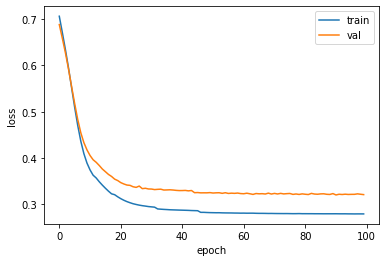

In [97]:
plot_loss(lt, "")

In [85]:
val_covs_bce = ct.covs["val"]

In [86]:
val_corrs_bce = []
for val_cov in val_covs_bce:
    val_corrs_bce.append(correlation_from_covariance(val_cov))

In [87]:
def get_cov_entry(val_mats, i, j):
    val = []
    for val_mat in val_mats:
        val.append(val_mat[i,j])
    return np.array(val)

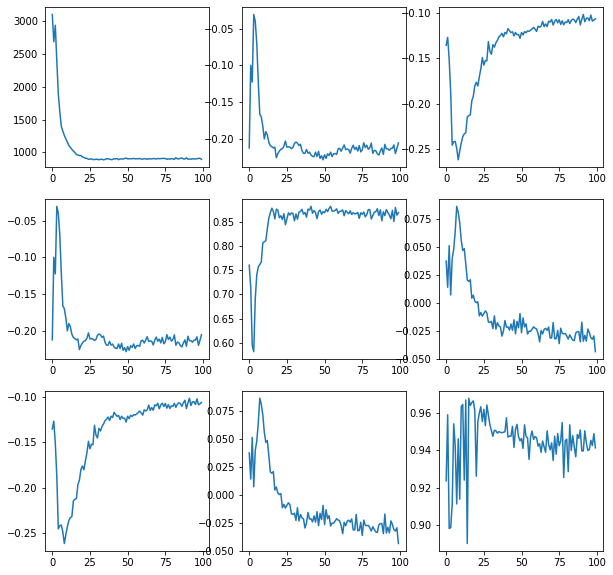

In [88]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        if i == j:
            val = get_cov_entry(val_covs_bce, i, j)
        else:
            val = get_cov_entry(val_corrs_bce, i, j)
        col.plot(val)

In [82]:
ct.val_shapes

{'sig': [array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 5.1624876e-01, 4.8364395e-01, 1.0731637e-04,
         0.0000000e+00, 0.0000000e+00], dtype=float32),
  array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 8.3063908e-02, 9.0680999e-01, 1.0071573e-02,
         5.4570261e-05, 0.0000000e+00], dtype=float32),
  array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 3.2817177e-02, 8.2863039e-01, 1.3505359e-01,
         3.4454984e-03, 5.3262316e-05], dtype=float32),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.03347098, 0.5323935 , 0.3885697 , 0.04407375, 0.00149208],
        dtype=float32),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.04991951, 0.29647428, 0.46313366, 0.17418724, 0.01628537],
        dtype=float32),
  array([0.        , 0.        , 0.        , 0.        , 0.00853073,
         0.05716

## 5. Setup INFERNO

In [66]:
from pytorch_inferno.inferno import *
from fastcore.all import store_attr, delegates, is_close

In [67]:
class HEPInferno(AbsInferno):
    r'''Implementation of INFERNO with HEP like systematics'''
    @delegates(AbsInferno)
    def __init__(self, interp_algo:str="default", shape_norm_sigma:Optional[List[float]]=None,
                 s_norm_sigma:Optional[List[float]]=None, b_norm_sigma:Optional[List[float]]=None, 
                 b_rate_param:bool=False, **kwargs):
        super().__init__(**kwargs)
        self.interp_algo = interp_algo
        self.shape_norm_sigma = shape_norm_sigma #torch.Tensor(shape_norm_sigma)
        self.s_norm_sigma = s_norm_sigma
        self.b_norm_sigma = b_norm_sigma
        self.b_rate_param = b_rate_param
        # Compute nuisance indeces
        self.poi_idx = [0]
        # Shape + norm
        if self.shape_norm_sigma is not None and len(self.shape_norm_sigma) != self.n_shape_alphas: raise ValueError("Number of norm uncertainties on shape nuisances must match the number of shape nuisance parameters")
        if self.n_shape_alphas > 0:
            self.shape_idxs = list(range(1,self.n_shape_alphas+1))
            self.n_alpha = 1+self.n_shape_alphas
        else:
            self.shape_idxs = []
        # Signal norms
        if self.s_norm_sigma is not None and len(self.s_norm_sigma) > 0:
            self.s_norm_idxs = list(range(self.n_alpha, self.n_alpha+len(self.s_norm_sigma)))
            self.n_alpha += len(self.s_norm_sigma)
        else:
            self.s_norm_idxs = []
        # Background norms + possible rate param
        if self.b_norm_sigma is not None and len(self.b_norm_sigma) > 0:
            self.b_norm_idxs = list(range(self.n_alpha, self.n_alpha+len(self.b_norm_sigma)))
            self.n_alpha += len(self.b_norm_sigma)
        else:
            self.b_norm_idxs = []
        if self.b_rate_param:
            self.b_rate_param_idx = list(self.n_alpha, self.n_alpha+1)
            self.n_alpha += 1
        else:
            self.b_rate_param_idx = []
        
        # Store covariance matrix
        self.covs, self.cov, self.cnt = {'trn':[], 'val':[]}, 0, 0
        self.val_shapes, self.sig_shape, self.bkg_shape  = {'sig':[], 'bkg':[]}, 0, 0
        
        print("*********************")
        print("Summary INFERNO setup")
        print("b_true", self.b_true)
        print("mu_true", self.mu_true)
        print("nshape_alphas", self.n_shape_alphas)
        print("shape idx", self.shape_idxs)
        print("shape_norm_sigma", self.shape_norm_sigma)
        print("s_norm_sigma", self.s_norm_sigma)
        print("s_norm_idxs", self.s_norm_idxs)
        print("b_norm_sigma", self.b_norm_sigma)
        print("b_norm_idxs", self.b_norm_idxs)
        print("b_rate_param", self.b_rate_param)
        print("n_alpha", self.n_alpha)
        print("interp_algo", self.interp_algo)
        print("*********************")

    def _aug_data(self): pass  # Override abs method
    def on_batch_begin(self) -> None: pass
    def on_batch_end(self) -> None: pass
    
    def on_epoch_begin(self) -> None: 
        self.cov, self.cnt = 0, 0
        self.sig_shape, self.bkg_shape = 0, 0
        
    def on_epoch_end(self) -> None:
        if self.wrapper.state == 'train':
            self.covs['trn'].append(  self.cov / self.cnt  )
        else:
            self.covs['val'].append(  self.cov / self.cnt  )
            self.val_shapes['sig'].append( self.sig_shape / self.cnt )
            self.val_shapes['bkg'].append( self.bkg_shape / self.cnt )

    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct        
        if self.shape_norm_sigma is not None: self.shape_norm_sigma = torch.Tensor(self.shape_norm_sigma).to(self.wrapper.device)
        if self.s_norm_sigma is not None: self.s_norm_sigma = torch.Tensor(self.s_norm_sigma).to(self.wrapper.device)
        if self.b_norm_sigma is not None: self.b_norm_sigma = torch.Tensor(self.b_norm_sigma).to(self.wrapper.device)

    def to_shape(self, p:Tensor, w:Optional[Tensor]=None) -> Tensor:
        f = (p*w).sum(0)+1e-7 if w is not None else p.sum(0)+1e-7
        return f/f.sum()   
        
        #print(torch.unsqueeze(torch.squeeze(p), 0).shape)
        """
        h = torch.histc(p, bins=10, min=0., max=1.)
        hist = SoftHistogram(bins=10, min=0., max=1., sigma=200., device=self.wrapper.device)
        #print(p.shape)
        eps=1e-7
        h = h.div(h.sum())+eps
        h_soft = hist(p)
        h_soft = h_soft.div(h_soft.sum())+eps
        #print("h_soft", h_soft)
        #print("h", h)
        return h_soft
        """
            
    def _get_up_down(self, x_s:Tensor, x_b:Tensor, w_s:Optional[Tensor]=None, w_b:Optional[Tensor]=None) -> Tuple[Tuple[Optional[Tensor],Optional[Tensor]],Tuple[Optional[Tensor],Optional[Tensor]]]:

        if self.n_shape_alphas != ((x_s.shape[-1]-1)/2): 
            raise ValueError("Number of specified shape nuisances n_shape_alphas", self.n_shape_alphas,
                             "must match the number of systematic variations:", (x_s.shape[-1]-1)/2 )
        
        u,d = [],[]
        # modified template variations
        for i in range(self.n_shape_alphas):
            idx_up = 1 + 2*i
            idx_down = 2 + 2*i
            up_batch = self.to_shape(self.wrapper.model(x_s[:,:,idx_up]))
            down_batch = self.to_shape(self.wrapper.model(x_s[:,:,idx_down]))
            u.append(up_batch)
            d.append(down_batch)    
        return (torch.stack(u),torch.stack(d)), (None,None)

    def get_ikk(self, f_s_nom:Tensor, f_b_nom:Tensor, f_s_up:Optional[Tensor], f_s_dw:Optional[Tensor], f_b_up:Optional[Tensor], f_b_dw:Optional[Tensor]) -> Tensor:
        r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
        alpha = torch.zeros((self.n_alpha), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): alpha[self.poi_idx] += self.mu_true
        #print("alpha", alpha)
        get_nll = partialler(hep_nll, s_true=self.mu_true, b_true=self.b_true, # Expectation values
                             f_s_nom=f_s_nom, f_b_nom=f_b_nom, # Nominal shapes
                             f_s_up=f_s_up, f_s_dw=f_s_dw, # Signal shapes
                             f_b_up=f_b_up, f_b_dw=f_b_dw, #Background shapes
                             shape_norm_sigma = self.shape_norm_sigma, # Norm unct on shapes
                             s_norm_sigma = self.s_norm_sigma, b_norm_sigma = self.b_norm_sigma # Norm unct on sig and bkg
                             ) 
        nll = get_nll(mu=alpha[self.poi_idx], s_norm_alpha=alpha[self.s_norm_idxs], 
                      b_norm_alpha=alpha[self.b_norm_idxs], shape_alpha=alpha[self.shape_idxs],
                      b_rate_param_alpha = alpha[self.b_rate_param_idx],
                      interp_algo = self.interp_algo)
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        cov = torch.inverse(h)        
        with torch.no_grad(): 
            self.cov += cov.detach().cpu().numpy()
            self.sig_shape += f_s_nom.detach().cpu().numpy()
            self.bkg_shape += f_b_nom.detach().cpu().numpy()
        self.cnt += 1
        return cov[self.poi_idx,self.poi_idx]

    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        b = self.wrapper.y.squeeze() == 0
        w_s = self.wrapper.w[~b] if self.wrapper.w is not None else None
        w_b = self.wrapper.w[b] if self.wrapper.w is not None else None
        f_s = self.to_shape(self.wrapper.y_pred[~b], w_s)
        f_b = self.to_shape(self.wrapper.y_pred[b], w_b)
        (f_s_up,f_s_dw),(f_b_up,f_b_dw)= self._get_up_down(self.wrapper.x[~b], self.wrapper.x[b], w_s, w_b)
        self.wrapper.loss_val = self.get_ikk(f_s_nom=f_s, f_b_nom=f_b, f_s_up=f_s_up, f_s_dw=f_s_dw, f_b_up=f_b_up, f_b_dw=f_b_dw)


In [68]:
# Set up network

net_inferno = nn.Sequential(nn.Linear(4,100),  nn.ReLU(),
                nn.Linear(100,100), nn.ReLU(),
                nn.Linear(100,10), VariableSoftmax(0.1))

"""
net_inferno = nn.Sequential(nn.Linear(4,100),  nn.ReLU(),
                        nn.Linear(100,100), nn.ReLU(),
                        nn.Linear(100,1),  nn.Sigmoid())

"""


lt = LossTracker()
shape_norm_sigma = [0.05, 0.02]
s_norm_sigma = []#[0.05, 0.1]
hep_inf = HEPInferno(b_true=qcd, mu_true=mu, n_shape_alphas=2, shape_norm_sigma=shape_norm_sigma,
                                 s_norm_sigma=s_norm_sigma, interp_algo="default")
#init_net(net_inferno)
model_inferno = ModelWrapper(net_inferno)


model_inferno.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
                  cbs=[hep_inf, lt])

*********************
Summary INFERNO setup
b_true 2689.5053333309675
mu_true 348.45252731445095
nshape_alphas 2
shape idx [1, 2]
shape_norm_sigma [0.05, 0.02]
s_norm_sigma []
s_norm_idxs []
b_norm_sigma None
b_norm_idxs []
b_rate_param False
n_alpha 3
interp_algo default
*********************


1: Train=1240.3329467773438 Valid=930.5303125
2: Train=878.5367529296875 Valid=879.3825073242188
3: Train=835.6947290039062 Valid=848.255966796875
4: Train=827.222138671875 Valid=834.7723364257813
5: Train=801.5720385742187 Valid=822.2471728515625
6: Train=784.96916015625 Valid=813.4121704101562
7: Train=772.4620703125 Valid=806.380341796875
8: Train=763.7699291992187 Valid=800.2116259765625
9: Train=758.5347778320313 Valid=799.5877392578125
10: Train=753.2054174804688 Valid=791.358369140625
11: Train=748.350400390625 Valid=793.6667456054688
12: Train=745.0706103515626 Valid=793.6547875976562
13: Train=741.1663598632813 Valid=789.41298828125
14: Train=740.9376513671875 Valid=787.516484375
15: Train=741.409267578125 Valid=785.2820581054688
16: Train=736.6660083007813 Valid=785.0564331054687
17: Train=733.6486694335938 Valid=781.6156298828125
18: Train=729.0081762695313 Valid=774.7118579101563
19: Train=726.3030224609375 Valid=777.7511010742187
20: Train=726.4125830078125 Valid=777.33263

In [175]:
hep_inf.val_shapes["sig"]

[array([1.21457924e-04, 1.72033126e-03, 1.97044797e-02, 1.53849587e-01,
        4.42078412e-01, 3.71065527e-01, 1.14609143e-02, 1.03910324e-07,
        1.00000008e-07, 1.00000008e-07], dtype=float32),
 array([2.9548744e-04, 4.7459500e-03, 3.8478434e-02, 1.9441885e-01,
        3.7756971e-01, 3.4186798e-01, 4.2623233e-02, 1.1303677e-06,
        1.0000001e-07, 1.0000001e-07], dtype=float32),
 array([1.4053567e-04, 2.6914447e-03, 2.8792538e-02, 1.7417872e-01,
        3.1767476e-01, 3.3349162e-01, 1.3546063e-01, 7.5705261e-03,
        1.0557609e-07, 1.0000001e-07], dtype=float32),
 array([1.62281364e-03, 1.50746880e-02, 7.15112612e-02, 1.99879467e-01,
        2.55651116e-01, 2.64888465e-01, 1.65889055e-01, 2.54697781e-02,
        1.41871997e-05, 1.00000044e-07], dtype=float32),
 array([4.70597623e-03, 2.95977518e-02, 1.00037985e-01, 1.99747354e-01,
        2.15837806e-01, 2.21303284e-01, 1.73335224e-01, 5.46372235e-02,
        7.98282912e-04, 1.00016017e-07], dtype=float32),
 array([9.96351

In [37]:
x = np.linspace(0,10,11)

In [38]:
list(hep_inf.val_shapes["sig"][0])+[0]

NameError: name 'hep_inf' is not defined

In [188]:
def plot_shapes(ax, idx=0, leg=False):
    ax.step(x, list(hep_inf.val_shapes["sig"][idx])+[0], where="post", label="signal")
    ax.step(x, list(hep_inf.val_shapes["bkg"][idx])+[0], where="post",label="bkg")
    
    plt.text(0.8, 0.9,"Epoch "+str(idx),
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax.transAxes, size=10,
    bbox=dict(facecolor='red', edgecolor=None, alpha=0.2))
    if leg:
        ax.legend(loc="upper left")

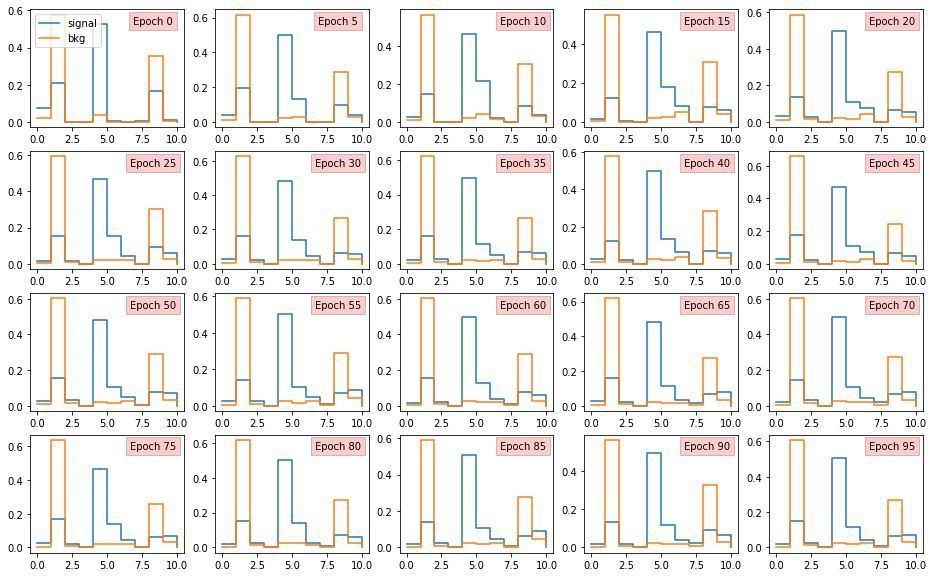

In [189]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(16,10))

eps = 0
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        if i+j == 0:
            leg=True
        else:
            leg=False
        plot_shapes(col, idx=eps*5, leg=leg)
        eps+=1

In [47]:
import imageio

In [74]:
def plot_shapes(idx=0, leg=False, filename="test.png"):
    
    fig, ax = plt.subplots()
    ax.set_ylim(0,1.)

    ax.step(x, list(hep_inf.val_shapes["sig"][idx])+[0], where="post", label="signal")
    ax.step(x, list(hep_inf.val_shapes["bkg"][idx])+[0], where="post",label="bkg")
    
    #plt.text(0.8, 0.9,"Epoch "+str(idx),
    #horizontalalignment='center',
    #verticalalignment='center',
    #transform = ax.transAxes, size=10,
    #bbox=dict(facecolor='red', edgecolor=None, alpha=0.2))
    if leg:
        ax.legend(loc="upper left")
    fig.savefig( filename )

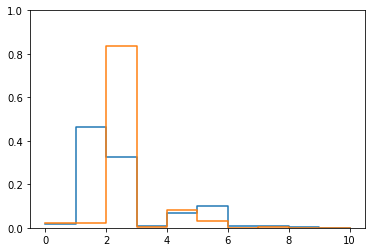

In [75]:
plot_shapes(idx=0, leg=False)

/home/centos/env/lib64/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


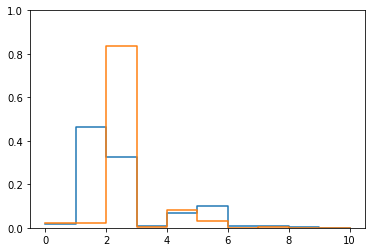

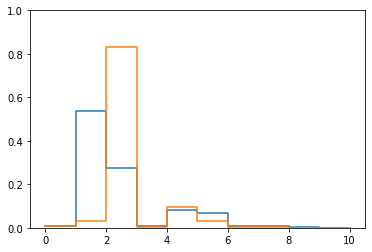

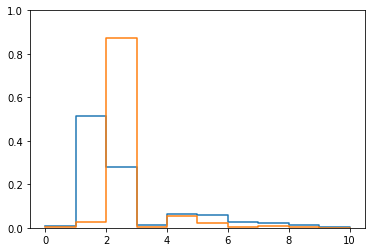

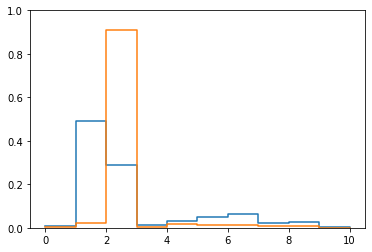

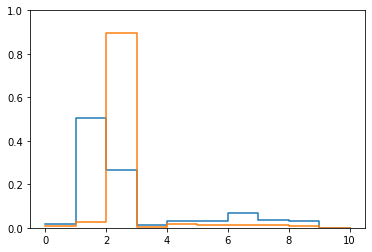

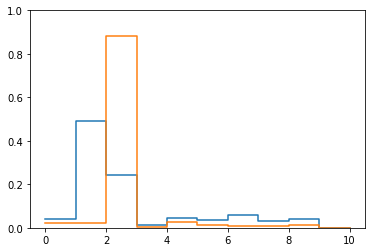

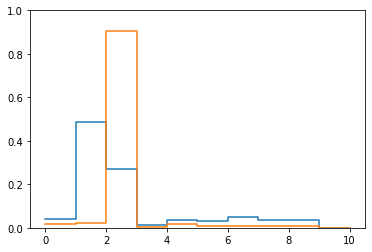

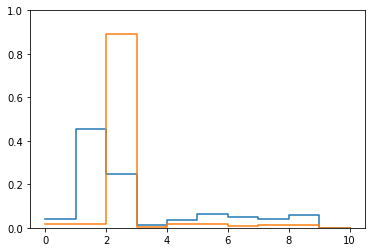

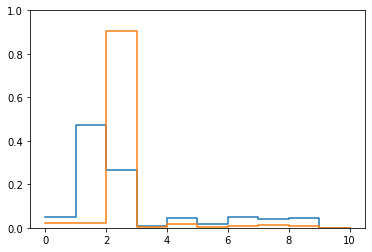

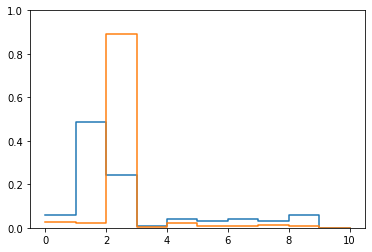

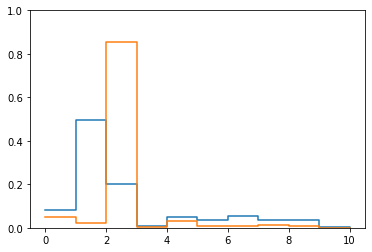

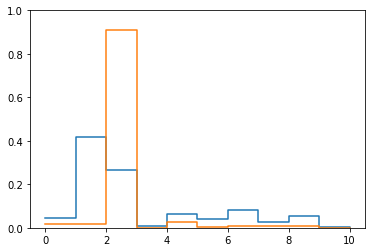

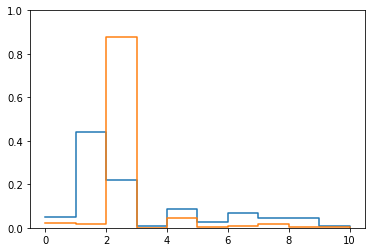

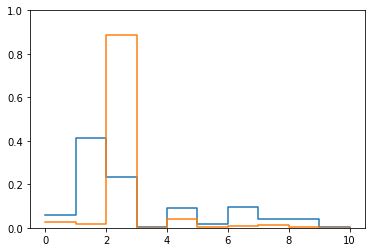

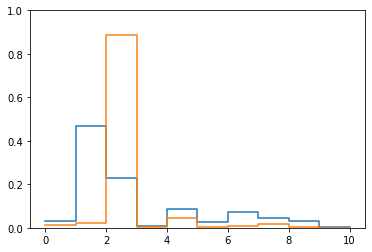

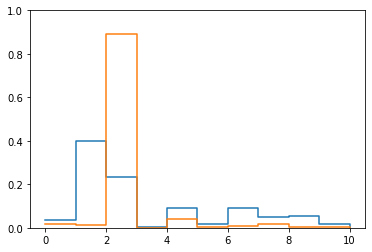

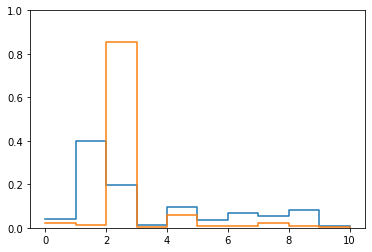

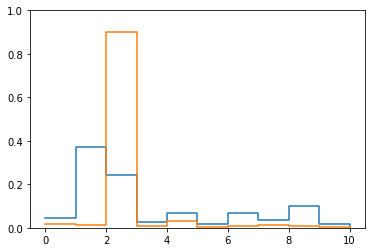

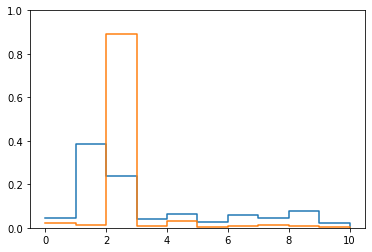

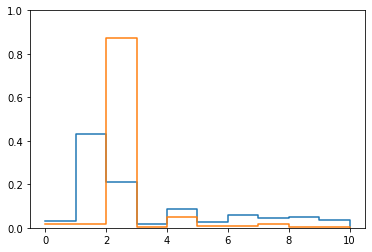

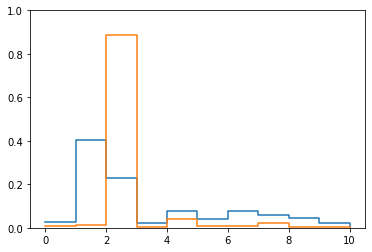

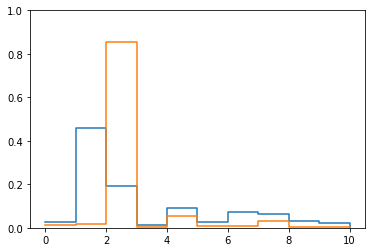

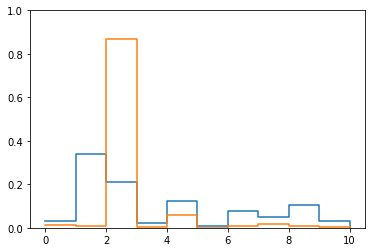

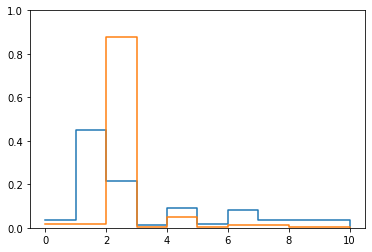

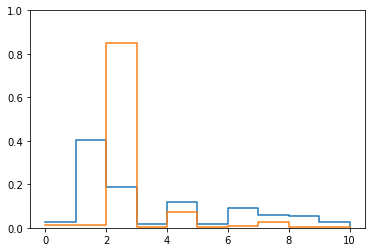

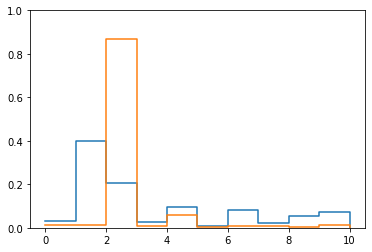

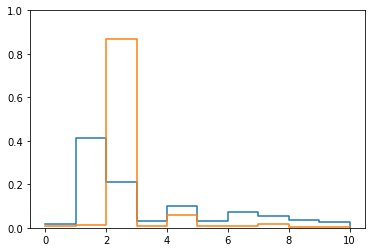

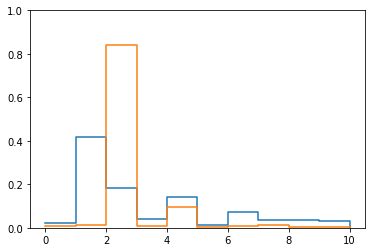

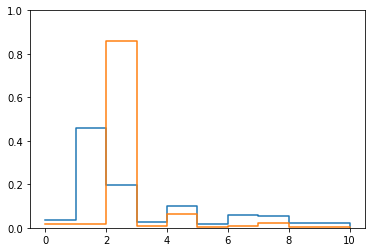

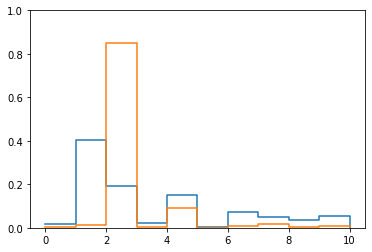

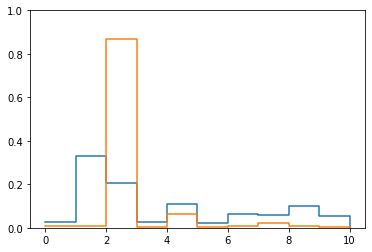

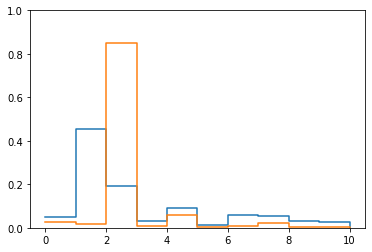

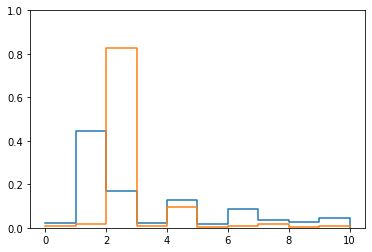

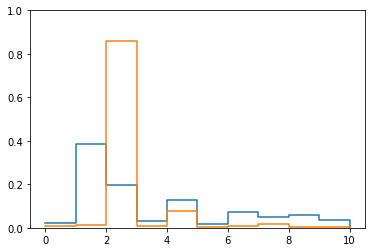

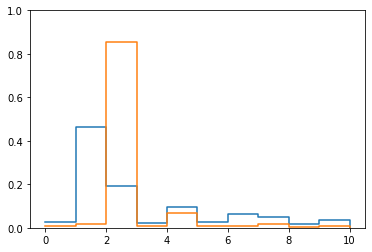

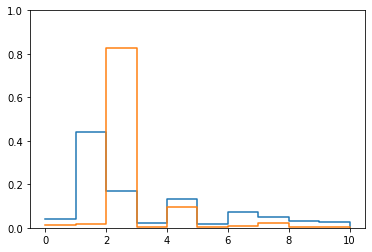

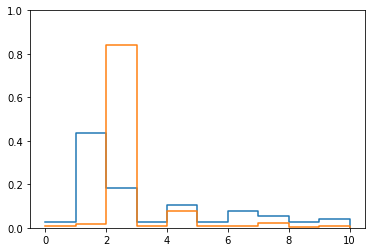

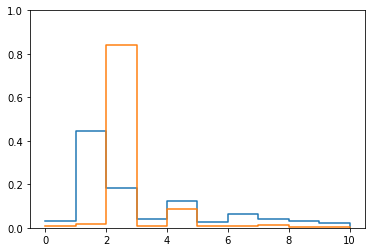

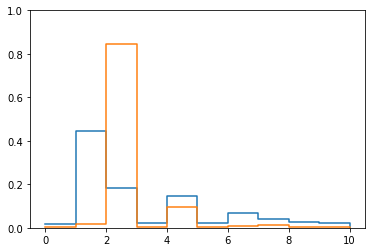

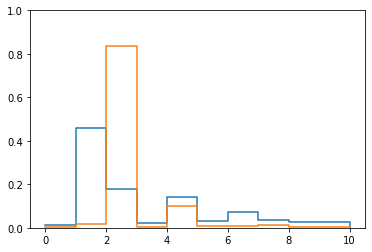

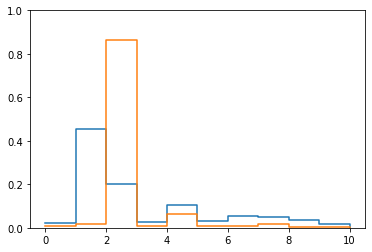

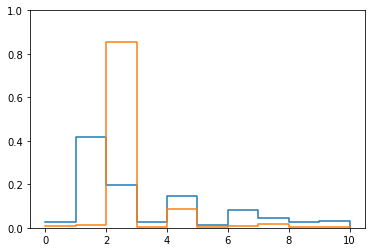

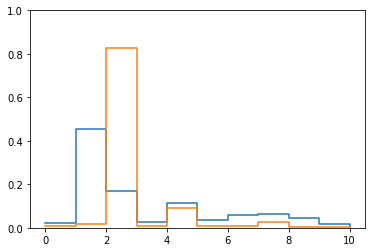

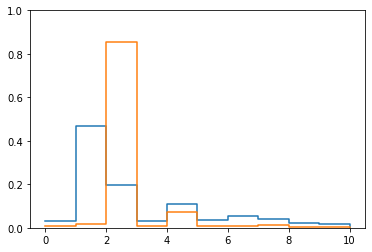

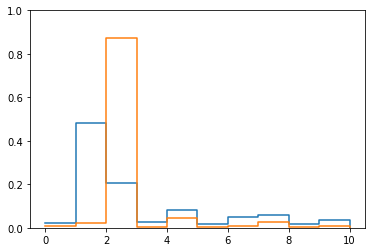

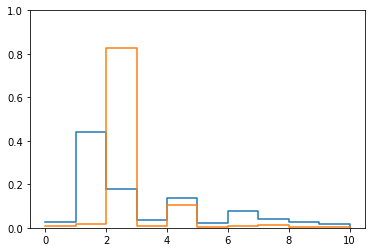

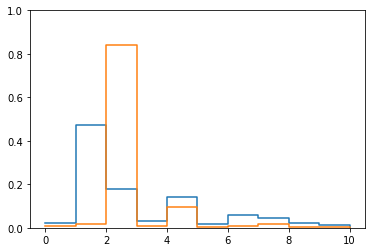

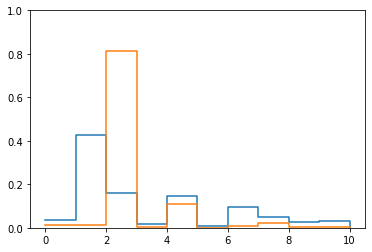

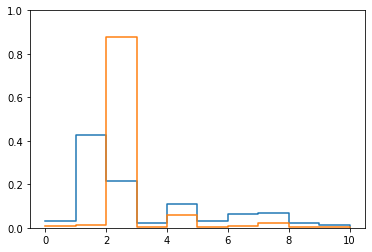

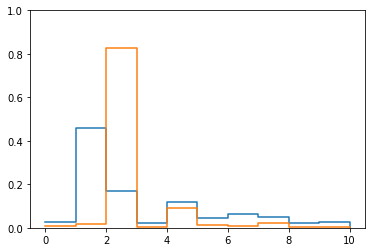

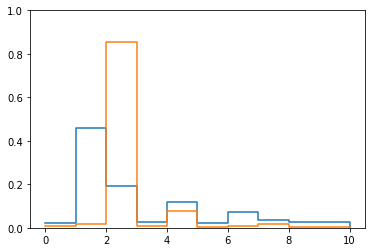

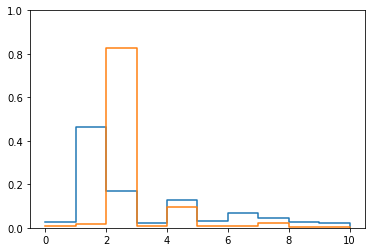

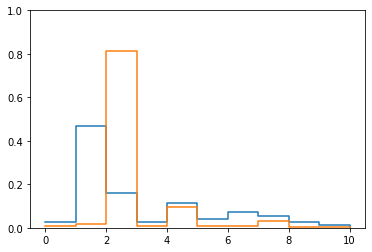

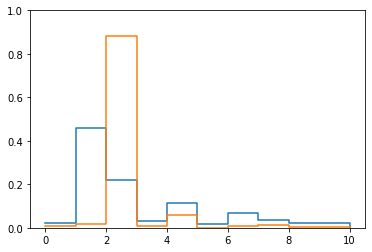

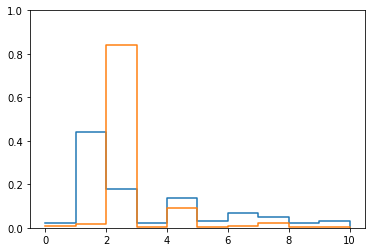

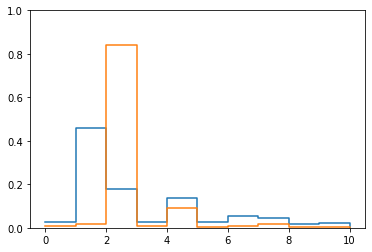

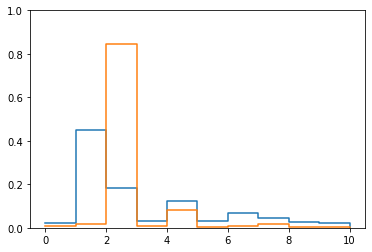

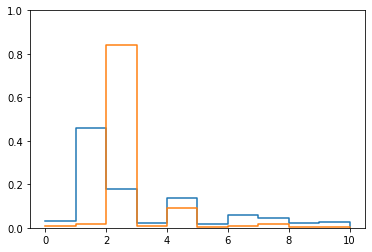

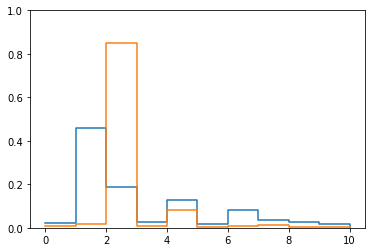

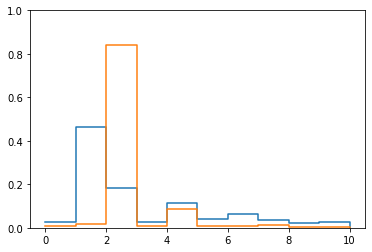

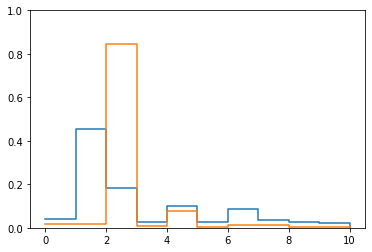

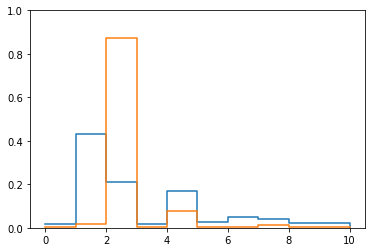

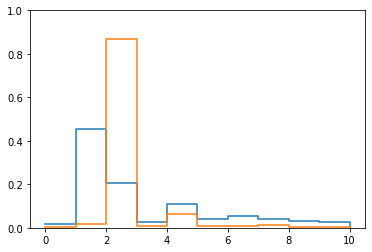

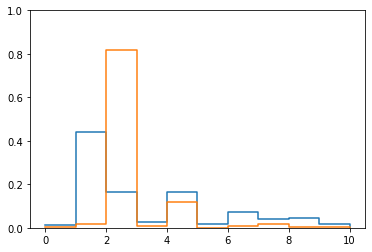

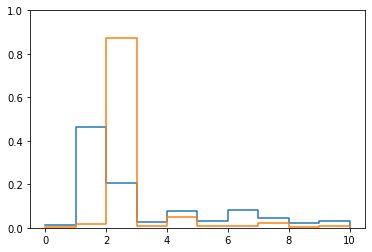

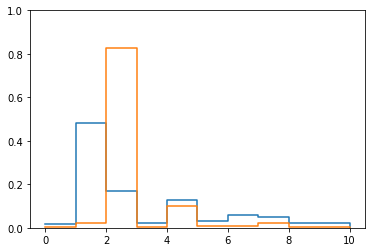

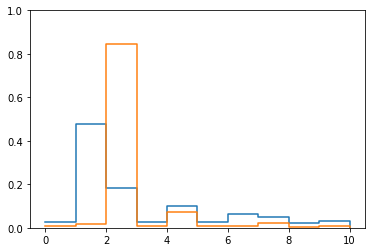

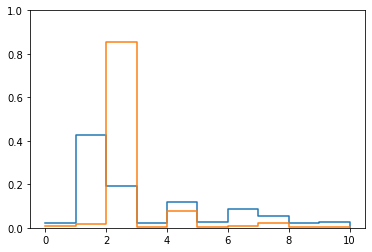

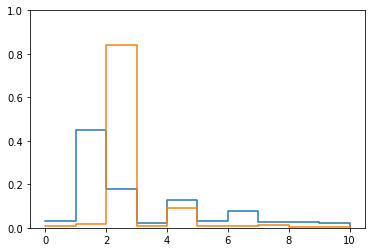

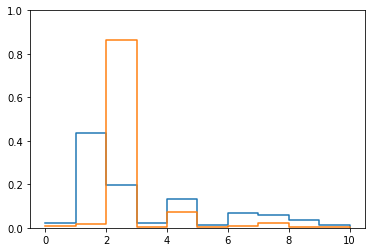

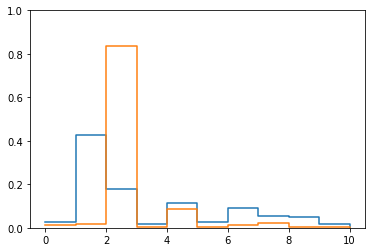

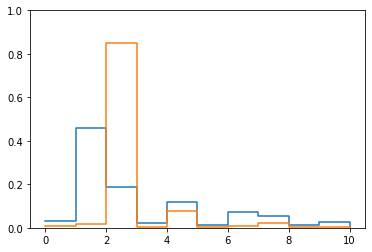

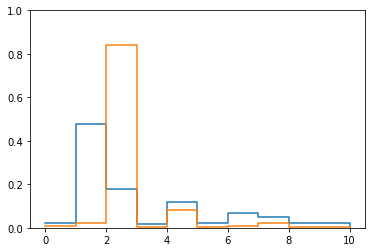

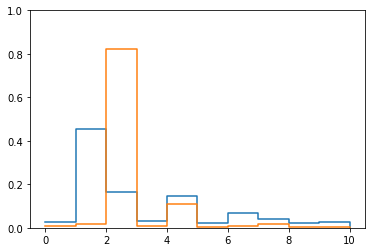

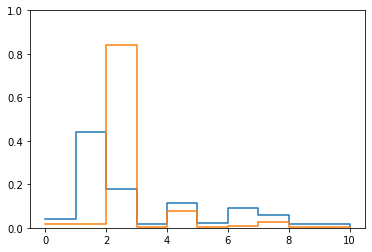

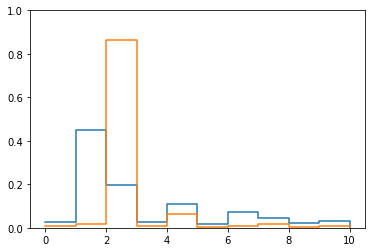

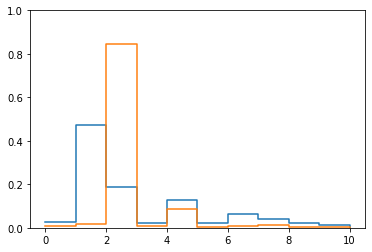

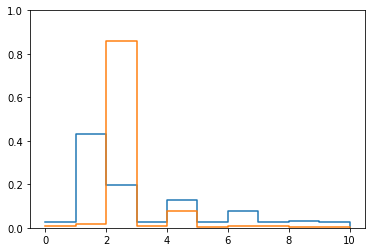

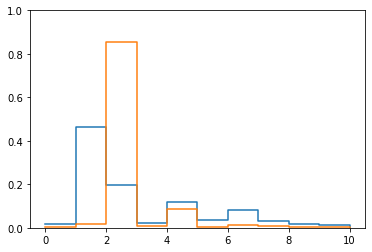

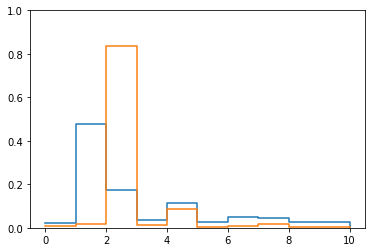

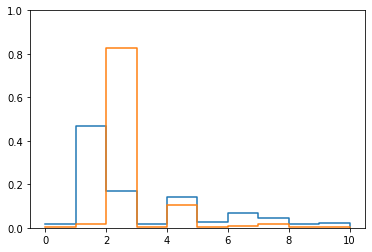

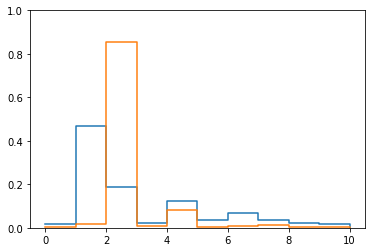

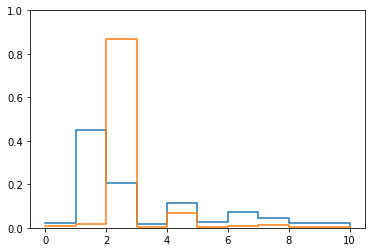

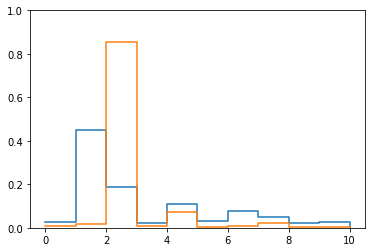

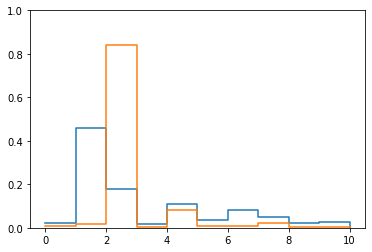

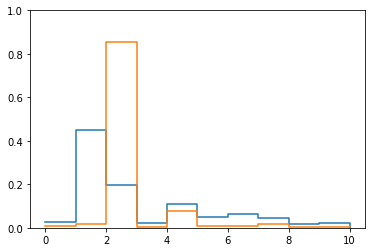

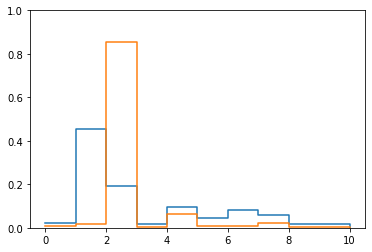

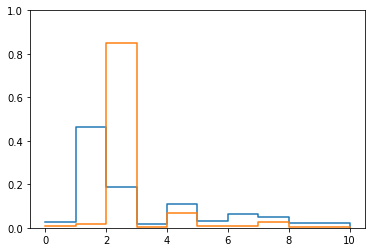

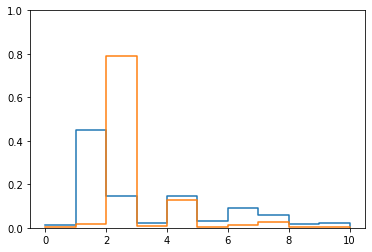

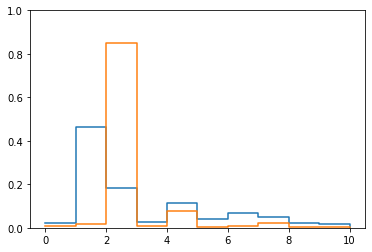

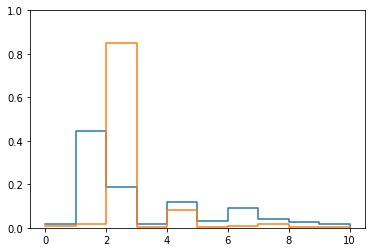

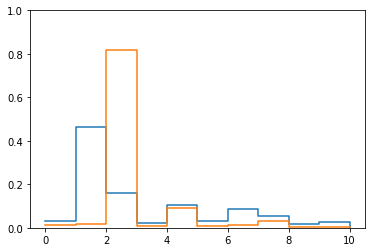

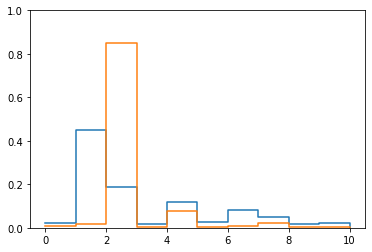

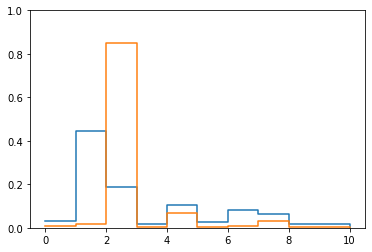

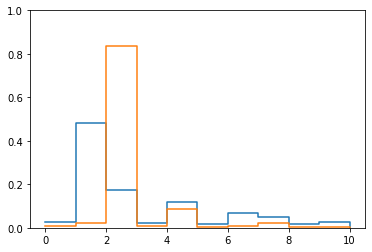

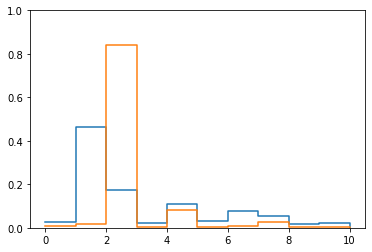

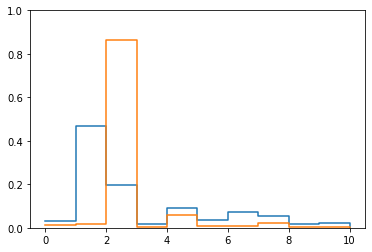

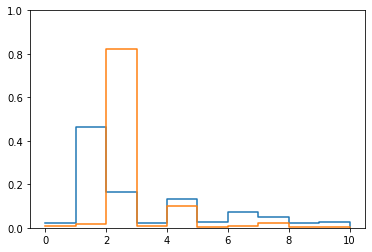

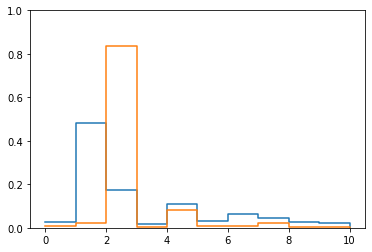

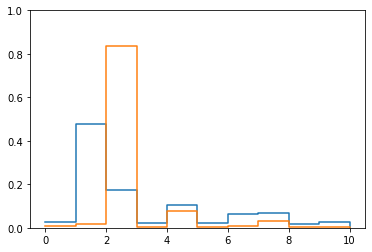

In [76]:
filenames = []
for i in range(100):
    # plot charts
    name = "/home/centos/data/gif/" + str(i)+".png"
    plot_shapes(idx=i, leg=False, filename=name)
    filenames.append(name)

In [77]:
# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:

eps = 0
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        if i+j == 0:
            leg=True
        else:
            leg=False
        plot_shapes(col, idx=eps*5, leg=leg)
        eps+=1

In [69]:
trn_covs = hep_inf.covs["trn"]
val_covs = hep_inf.covs["val"]

In [70]:
test = trn_covs[-1]

In [71]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [72]:
trn_corrs, val_corrs = [], []
for trn_cov, val_cov in zip(trn_covs, val_covs):
    trn_corrs.append(correlation_from_covariance(trn_cov))
    val_corrs.append(correlation_from_covariance(val_cov))

In [73]:
trn_corrs

[array([[ 1.0000001 , -0.05711356, -0.19814423],
        [-0.0571136 ,  1.0000001 ,  0.00129942],
        [-0.19814417,  0.00129942,  1.0000001 ]], dtype=float32),
 array([[ 1.0000001 , -0.01588698, -0.17561097],
        [-0.015887  ,  1.        , -0.02194998],
        [-0.17561096, -0.02194998,  1.0000001 ]], dtype=float32),
 array([[ 0.99999994, -0.02245984, -0.14868578],
        [-0.02245983,  1.        , -0.02972391],
        [-0.14868571, -0.02972391,  0.99999994]], dtype=float32),
 array([[ 1.        , -0.04185739, -0.15047199],
        [-0.04185743,  1.        , -0.03415009],
        [-0.15047202, -0.03415008,  1.        ]], dtype=float32),
 array([[ 0.99999994, -0.01975707, -0.15359043],
        [-0.01975708,  1.        , -0.0269015 ],
        [-0.1535903 , -0.02690151,  0.99999994]], dtype=float32),
 array([[ 1.        ,  0.00246197, -0.15216058],
        [ 0.00246195,  0.99999994, -0.01143067],
        [-0.15216072, -0.01143068,  0.99999994]], dtype=float32),
 array([[ 1.    

In [90]:
def get_cov_entry(trn_mats, val_mats, i, j):
    trn, val = [], []
    for trn_mat, val_mat in zip(trn_mats, val_mats):
        trn.append(trn_mat[i,j])
        val.append(val_mat[i,j])
    return np.array(trn), np.array(val)

In [75]:
trn_var, val_var = get_cov_entry(trn_covs, val_covs, 0, 0)

In [76]:
names = ["mu","JES",'b-tag']

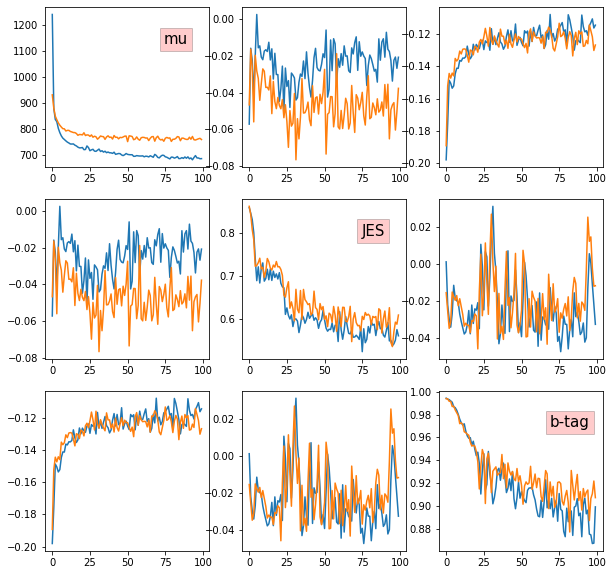

In [77]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        if i == j:
            trn, val = get_cov_entry(trn_covs, val_covs, i, j)
            plt.text(0.8, 0.8,names[i],
             horizontalalignment='center',
             verticalalignment='center',
             transform = col.transAxes, size=15,
             bbox=dict(facecolor='red', edgecolor=None, alpha=0.2))
        else:
            trn, val = get_cov_entry(trn_corrs, val_corrs, i, j)
        col.plot(trn)
        col.plot(val)

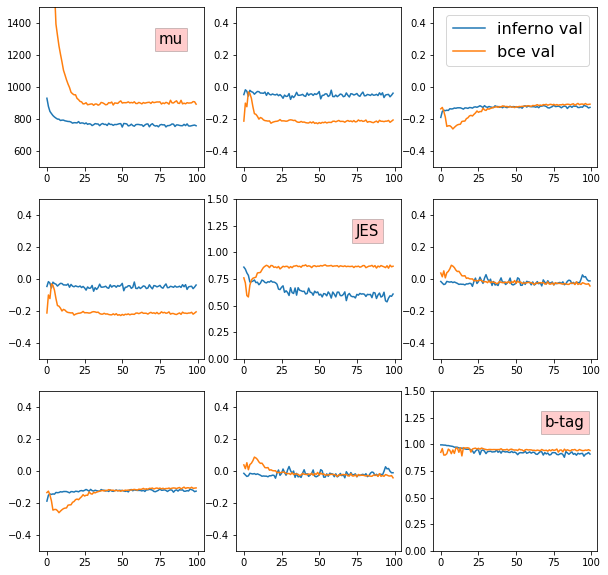

In [106]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        if i == j:
            inf, bce = get_cov_entry(val_covs, val_covs_bce, i, j)
            plt.text(0.8, 0.8,names[i],
             horizontalalignment='center',
             verticalalignment='center',
             transform = col.transAxes, size=15,
             bbox=dict(facecolor='red', edgecolor=None, alpha=0.2))
            if i==0:
                lims = (500,1500)
            else:
                lims = (0., 1.5)
        else:
            inf, bce = get_cov_entry(val_corrs, val_corrs_bce, i, j)
            lims = (-.5, .5)
        col.plot(inf, label="inferno val")
        col.plot(bce, label="bce val")
        col.set_ylim(lims)
        if (i==0) & (j==2):
            col.legend(loc="upper right", prop={'size': 16})

## 6. Test with CMS Open Data

In [41]:
import run_cmsopen
from torch.distributions import Normal

In [35]:

#features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'MET_met', 'deltaPhiTauMet', 'mt', 'mTauJet']
features = ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
shape_syst = ["06_jes"] #, "taue"]
weight_syst = ["btag_weight1"]
norm_syst = ["jes_06", "taue", "btag_weight1"]
use_weights = False

mu, qcd, sig_norm = run_cmsopen.get_norm(norm_syst)

mu 348.45252731445095
QCD 2689.5053333309675
jes_06 16.70084248968277
taue 11.82024566892062
btag 4.612317868087416


In [36]:
# Parameters for INFERNO training
inferno_args = {}
# Signal and bkg
inferno_args["b_true"] = qcd
inferno_args["mu_true"] = mu
# Number of shape nuisances
inferno_args["n_shape_alphas"] = len(shape_syst) + len(weight_syst)
# Constraints on the nuisance parameters - typically should be N(0,1) if +-1sigma templates are provided
inferno_args["shape_aux"] = [Normal(0,1) for i in range(len(shape_syst) + len(weight_syst))]
# Uncertainties on signal norm - should be Normal(0,s) with s in absolute event numbers
inferno_args["s_norm_aux"] = sig_norm #[Normal(0,10), Normal(0,10), Normal(0,10)]
# Boolean whether to let the background float
inferno_args["nonaux_b_norm"] = False

train_args = {}
train_args["lr"] = 1e-3
train_args["n_feats"] = len(features)
train_args["neurons"] = 100
train_args["bins"] = 10
train_args["temperature"] = 0.1
train_args["weights"] = False

OUTPATH = "/home/centos/data/inferno_cmsopen13"

bs = 1000
n_sig = 20000
epochs = 200

store = False

In [37]:
data = run_cmsopen.train(OUTPATH, features = features, 
                                        shape_syst = shape_syst,
                                        weight_syst = weight_syst,
                                        norm_syst = norm_syst, 
                                        epochs=epochs, bs=bs, n_sig=n_sig, 
                                        inferno_args = inferno_args, 
                                        train_args = train_args,
                                        use_weights = use_weights,
                                        store=store)

*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['06_jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************


In [40]:
from torch import optim, autograd, nn, Tensor
from pytorch_inferno.callback import *
from pytorch_inferno.utils import *
from pytorch_inferno.model_wrapper import ModelWrapper
from fastcore.all import partialler

In [39]:
# Set up network
net_inferno = nn.Sequential(nn.Linear(4,100),  nn.ReLU(),
                nn.Linear(100,100), nn.ReLU(),
                nn.Linear(100,10), VariableSoftmax(0.1))
lt = LossTracker()
#init_net(net_inferno)
model_inferno = ModelWrapper(net_inferno)

NameError: name 'VariableSoftmax' is not defined

In [36]:
shape_norm_sigma = [0.05, 0.02]

In [93]:
model_inferno.fit(2, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
                  cbs=[HEPInferno(b_true=qcd, mu_true=mu, n_shape_alphas=2, shape_norm_sigma=shape_norm_sigma), lt])  

*********************
Summary INFERNO setup
b_true 2689.5053333309675
mu_true 348.45252731445095
nshape_alphas 2
shape idx [1, 2]
shape_aux None
s_norm_aux []
shape_norm_sigma [0.05, 0.02]
n_alpha 3
*********************


RuntimeError: legacy constructor expects device type: cpubut device type: cuda was passed